In [3]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 5.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# import warnings
# warnings.filterwarnings(action='ignore') #warning 무시

Mounted at /content/drive


In [4]:
import random
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer # SentenceTransformer Version 2.2.2
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
# data_path = './data/'
data_path = '/content/drive/MyDrive/AI ML/DACON HANSOL/data/'

In [5]:
# train= pd.read_csv(f'{data_path}train.csv')
test = pd.read_csv(f'{data_path}test.csv')
train = pd.read_csv(f'{data_path}train.csv')
# train_qna = pd.read_csv(f'{data_path}train_80000_rule_based.csv')

train_ft = pd.read_csv(f'{data_path}train_ft_81900.csv')

In [6]:
category_lst = []
question_lst = []
answer_lst = []
for i in range(1, 3):
    for j in range(1, 6):
        for n in range(train.shape[0]):
            category = train['category'][n]
            question = train[f'질문_{i}'][n]
            answer = train[f'답변_{j}'][n]
            category_lst.append(category)
            question_lst.append(question)
            answer_lst.append(answer)

qna_df = pd.DataFrame({'category':category_lst,
                       'question':question_lst,
                       'answer':answer_lst})
qna_df

,category,question,answer
0,건축구조,면진장치가 뭐야?,면진장치란 지반에서 오는 진동 에너지를 흡수하여 건물에 주는 진동을 줄여주는 진동 ...
1,건축구조,내진설계의 종류 좀 알려줘,"내진 설계의 종류로 내진구조, 제진구조, 면진구조가 있습니다."
2,건축구조,철골구조의 장점이 뭐야?,철골구조는 건물의 외벽에는 그다지 하중이 걸리지 않기 때문에 고층 건물의 건축이 가...
3,건축구조,철골철근 콘크리트 구조가 뭐야?,"철근철골콘크리트는 철골과 철근, 그리고 콘크리트를 함께 사용하는 건축 구조입니다. ..."
4,건축구조,철골구조는 어떤 방식이 있어?,철골구조는 일반철골구조와 경량철골구조가 있습니다.
...,...,...,...
6435,타 마감하자,벽장 부위 결로가 발생하는 주된 원인은 무엇일까요?,벽장 부위 결로의 주된 원인은 충분한 환기가 이루어지지 않는 환경과 과도한 습기가 ...
6436,타 마감하자,벽체 결로가 AD나 PD에 면한다면 그 원인이 무엇인가요?,"AD, PD에 면한 벽체 결로의 원인으로는 외부 공기에 노출된 벽면이 실내보다 냉각..."
6437,타 마감하자,외벽 모서리 부위에 결로가 발생하는 것을 예방하는 방법이 있을까요?,외벽 모서리 부위에 결로가 발생하는 주요 원인은 높은 온도차입니다. 외벽 모서리는 ...
6438,타 마감하자,창호 결로를 해결하기 위한 가장 효과적인 방법은 무엇인가요?,"창호 결로를 방지하기 위한 대책으로는 KS에 규정된 프레임을 사용하고, 열관류율 및..."


# 모델 추론

In [25]:
kogpt_tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

# kogpt_model_name = 'kogpt2_80000_5epoch_0.13981loss'
kogpt_model_name = 'kogpt2_89000_0304_4epoch_0.13556loss'

kogpt_model = AutoModelForCausalLM.from_pretrained(f'{data_path}model/{kogpt_model_name}').to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [26]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(input_text, generated_text, alpha=0.95): # cosine 가중치 조절
    input_embedding = bert_model.encode(input_text)
    generated_embedding = bert_model.encode(generated_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([input_embedding], [generated_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    input_tokens = set(input_text.split())
    generated_tokens = set(generated_text.split())
    jaccard_sim = len(input_tokens.intersection(generated_tokens)) / len(input_tokens.union(generated_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
def Chatbot(input_text, model, tokenizer, max_len, device, num_samples=5):
    model.eval()
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    best_generated_text = None
    best_similarity_score = -1.0
    generated_texts = []  # 답변 후보군을 담을 리스트
    for i in range(num_samples):
        result_ids = model.generate(x,
                                    max_length=max_len,
                                    # repetition_penalty=1.0, # Rule-based 방식 사용하려면 off 해야 함
                                    num_return_sequences=1,
                                    do_sample=True,
                                    temperature=0.87,
                                    top_k=27,
                                    top_p=0.7)
        # result_ids = model.generate(x,max_length=max_len,num_beams=1,num_return_sequences=1,no_repeat_ngram_size=4,use_cache=True,do_sample=True,temperature=0.9,top_k=90,top_p=0.95,early_stopping=True)

        generated_text = tokenizer.decode(result_ids[0])
        generated_text = generated_text[q_len:-4]

        similarity_score = evaluate_similarity(text, generated_text)
        generated_texts.append((similarity_score,generated_text))
        print(generated_texts[i]) # 실제 돌릴땐 off

        if similarity_score > best_similarity_score:
            best_similarity_score = similarity_score
            best_generated_text = generated_text

    return best_generated_text

In [29]:
reset_seeds(SEED)

max_len = 200
answer_list = []
for i in tqdm(test['질문'].tolist()) :
    answer = Chatbot(i, kogpt_model, kogpt_tokenizer, max_len, device)
    answer_list.append(answer)

answer_list

  0%|          | 0/130 [00:00<?, ?it/s]

(0.6958203025070238, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6958203025070238, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6992089724395333, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 그리고 원목사이딩의 장

  1%|          | 1/130 [00:15<33:20, 15.51s/it]

(0.6958203025070238, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6400099446899011, '도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 녹은 도배지 안쪽의 금속 부식을 해결하고, 녹이 보이면 누출과 같은 문제가 발생합니다. 따라서 도배지를지를 대한 방수 및 누수 처리를 통해 누수를 막는 것이 중요합니다.')
(0.6066994369029999, '도배지에 녹이 묻어나온 현상은 공간 내 습도가 높거나 누수가 발생하여 발생할 수 있습니다. 이로 인해 도배지 안쪽의 금속이 녹아서 녹이 도배지에 베어나오게 됩니다. 습기가 높은 상태가 지속될 경우 녹오염이 발생할 수 있으며, 또한 누수에 의해 도배지가 젖은 상태가 유지될 경우 곰팡이가 발생할 수 있습니다.  이러한 경우에는 먼저, 제습기를 가동하거나 환기를 통해 공간 내 적정한 습도를 유지하는 것이 중요합니다. 또한, 누수를 제거하고 곰팡이가 발생한 도배지의 부분 및 전체를 교체하는 것이 필요할 수 있습니다. 이러한 보수작업은 전문가의 도움을 받아 진행하는 것이 좋습니다.')
(0.5820490181446075, '도배지에 녹이 보이면 곰팡이가 발생할 수 있습니다. 이러한 경우에는 누수 처리하고 곰팡이 제거를 철저히 하지 않으면 곰팡이 발생이 가능하다고 알려져 있습니다. 그러므로 누수 

  2%|▏         | 2/130 [00:26<27:17, 12.79s/it]

(0.62729152739048, '도배지에 녹이 보이면 누출될 수 있습니다. 누출은 도배지에 녹이 보이면 누수 문제가 발생할 수 있습니다. 이러한 경우에는 누수를 처리하고 곰팡이가 발생한 부분을 보수하는 것이 중요합니다. 누수 처리를 통해 공간 내 습도를 유지하는 것이 중요하며, 누수를 제거하고 곰팡이가 발생한 도배지 부분을 교체하는 것이 좋습니다. 도배지 안쪽 벽이나 석고보드에 녹이 보이면 누수 문제가 발생할 수 있습니다. 이러한 경우에는 누수 처리와 누수 처리가 필요합니다.')


  2%|▏         | 2/130 [00:28<30:49, 14.45s/it]


KeyboardInterrupt: 

In [ ]:
for a, b in zip(test['질문'].tolist(), answer_list) :
    print(f'질문 : {a}')
    print(f'답변 : {b}')
    print(' ')

# 추론 실험

In [180]:
cosine_score(train_df['question'][0], train_df['answer'][0])

0.78882265

In [181]:
tfidf_similarity(train_df['question'][0], train_df['answer'][0])*10

0.8060596067139124

In [ ]:
reset_seeds(SEED)
a = chatbot(test['질문'][0], kogpt_model, kogpt_tokenizer, device, 27, 0.7, 0.87)

In [185]:
device

'cpu'

In [31]:
def Chatbot(input_text, model, tokenizer, max_len, device, alpha=1,num_samples=5):
    model.eval()
    print('question', input_text)
    text = input_text.strip()
    text = '<q>' + text + '</s><a>'
    x = tokenizer.encode(text, return_tensors='pt').to(device)
    q_len = len(text) + 1

    best_generated_text = None
    best_similarity_score = -1.0
    generated_texts = []  # 답변 후보군을 담을 리스트
    for i in range(num_samples):
        result_ids = model.generate(x,
                                    max_length=max_len,
                                    # repetition_penalty=1.0, # Rule-based 방식 사용하려면 off 해야 함
                                    num_return_sequences=1,
                                    do_sample=True,
                                    temperature=0.7, #0.87
                                    top_k=27,
                                    top_p=0.7)
        # result_ids = model.generate(x,max_length=max_len,num_beams=1,num_return_sequences=1,no_repeat_ngram_size=4,use_cache=True,do_sample=True,temperature=0.9,top_k=90,top_p=0.95,early_stopping=True)

        generated_text = tokenizer.decode(result_ids[0])
        generated_text = generated_text[q_len:-4]

        similarity_score = cosine_score(text, generated_text)*alpha + tfidf_similarity(text, generated_text)*10*(1-alpha) # alpha는 코사인 유사도 기준
        # similarity_score = cosine_score(text, generated_text)*alpha

        generated_texts.append((similarity_score,generated_text))
        print(generated_texts[i]) # 실제 돌릴땐 off

        if similarity_score > best_similarity_score:
            best_similarity_score = similarity_score
            best_generated_text = generated_text

    return best_generated_text

In [188]:
reset_seeds(SEED)
max_len = 200

Chatbot(test['질문'].tolist()[0].strip(), kogpt_model, kogpt_tokenizer, max_len, device, 0.5)

(0.8632524290211597, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 데 주의해야 할 점은 몇 가지가 있습니다. 먼저, 색상이 흑백 또는 단색으로 제한되기 때문에 다양한 질감과 패턴을 활용하여 단조로움을 방지해야 합니다. 또한, 적절한 조명을 활용하여 공간의 깊이와 차원을 부여할 수 있도록 주의해야 합니다. 마지막으로, 습도 및 온도를 적절히 조절하여 지루함을 방지하고 공간에 조화로운 밸런스를 줄 수 있도록 해야 합니다. 이러한 점을 유의하면 원목사이딩을 활용하여 아름다운 공간을 꾸밀 수 있을 것입니다.')
(0.9722116521901243, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.8758211755555164, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 

'방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점이 있습니다.'

In [190]:

max_len = 200

Chatbot(test['질문'].tolist()[0].strip(), kogpt_model, kogpt_tokenizer, max_len, device, 0.9)

(0.709133396280119, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.743829260903723, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.7133433861564247, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 또한, 원목사이딩을 사용하는 데 필요한 비용이 많이 들 수 있습니다. 일반 목재와 달리 곰팡이가 적게 발생할 수 있고 습기에 강하다는 점이 단점으로 꼽힙니다. 또한 나무가 가지고 있는 자연스러운 아름다움과 고급스러운 느낌을 살릴 수 있어 건물의 외관을 더욱 아름답게 만들어 줍니다.')
(0.6963148767505019, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염

'방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.'

In [189]:
reset_seeds(SEED)
max_len = 200

Chatbot(test['질문'].tolist()[0].strip(), kogpt_model, kogpt_tokenizer, max_len, device, 1)

(0.6930971741676331, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.665299654006958, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에는 몇 가지 단점이 있습니다. 먼저, 열처리 과정으로 제작하는 탓에 가격이 일반 목재에 비해 높다는 점이 단점으로 꼽힙니다. 또한 어두운 색상을 띄고 있어서, 이에 대한 호불호가 갈릴 수 있다는 것도 중요한 단점입니다. 끝으로, 실제 나무로 만든 사이딩을 원할 경우 내구성이 약해 찢어질 수 있다는 점이 고려해야 합니다.')
(0.6867336630821228, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 것에 대한 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 또한 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6608351469039917, '방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 

'방청 페인트의 종류로는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트 등이 있습니다. 이러한 다양한 종류의 방청 페인트는 각자의 특징과 용도에 따라 선택되어 사용됩니다. 그리고 원목사이딩을 사용하는 데 필요한 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축/팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.'

In [198]:
input_text = question = test['질문'].tolist()[3].strip()

In [36]:
reset_seeds(SEED)

max_len = 200
answer_list = []
for i in tqdm(test['질문'].tolist()) :
    answer = Chatbot(i, kogpt_model, kogpt_tokenizer, max_len, device, alpha=0.85, num_samples=5)
    print(answer)
    answer_list.append(answer)

answer_list

  0%|          | 0/130 [00:00<?, ?it/s]

question 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
(0.6243405847241774, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6243405847241774, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
(0.6070390529734155, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가

  1%|          | 1/130 [00:09<19:58,  9.29s/it]

(0.6243405847241774, '방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.')
방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.
question 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
(0.5908277938265565, '도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 녹은 도배지에 녹이 보이면 누수 문제가 발생할 수 있습니다. 누수 상황에서는 누수를 해결하고, 곰팡이와 녹이 보이면 누수 처리를 하여 누수를 막는 것이 중요합니다. 이러한 누수 처리로 인해 도배지 안쪽의 금속이 녹을 수 있고, 녹이 보이면 누수 문제가 해결될 수 있습니다.')
(0.492609

  2%|▏         | 2/130 [00:14<15:01,  7.04s/it]

(0.41171498683571234, '도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 문제의 책임은 누수 처리에 있습니다. 누수 처리는 건축물의 소유자나 거주자의 책임이며, 누수를 해결하고 곰팡이와 녹이 보이면 누수 처리를 해야 합니다. 또한, 누수가 발생하면 곰팡이가 번식할 수 있으므로 누수 처리가 중요합니다. 이를 해결하기 위해서는 누수 처리와 곰팡이 제거가 필요합니다.')
도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 녹은 도배지에 녹이 보이면 누수 문제가 발생할 수 있습니다. 누수 상황에서는 누수를 해결하고, 곰팡이와 녹이 보이면 누수 처리를 하여 누수를 막는 것이 중요합니다. 이러한 누수 처리로 인해 도배지 안쪽의 금속이 녹을 수 있고, 녹이 보이면 누수 문제가 해결될 수 있습니다.
question 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
(0.6287330285786146, '큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다. 이러한 점들을 감안하여 건축자 및 시공 업체들은 클라이언트에게 건축 재료의 선택과 함께 추가적인 비용과 유지보수에 대해 충분한 설명을 제공해야 합니다. 그리고 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다.')
(0.6757836891467592, '큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다.

  2%|▏         | 3/130 [00:22<15:42,  7.42s/it]

(0.6287330285786146, '큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다. 이러한 점들을 감안하여 건축자 및 시공 업체들은 클라이언트에게 건축 재료의 선택과 함께 추가적인 비용과 유지보수에 대해 충분한 설명을 제공해야 합니다. 그리고 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다.')
큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다. 이러한 점들을 감안하여 건축자 및 시공 업체들은 클라이언트에게 건축 재료의 선택과 함께 추가적인 비용과 유지보수에 대해 충분한 설명을 제공해야 합니다. 또한, 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다.
question 철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
(0.6538466237829684, '철골 구조는 주로 강철 기둥과 형강으로 건축물의 골조를 구성하여 건축물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 강철 기둥이 하중을 지지하는 역할을 수행합니다. 또한, 외벽은 내장재 및 외장재를 커튼벽 형태로 설치하여 외부에서 발생하는 하중을 지탱합니다. 이러한 구조는 고층 건물 등에 적합하

  3%|▎         | 4/130 [00:29<15:13,  7.25s/it]

(0.6554064113656237, '철골 구조는 강철 기둥과 형강으로 건축물의 골조를 구성하여 건축물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 강철 기둥이 하중을 지지하는 역할을 수행합니다. 또한, 외벽은 내장재 및 외장재를 커튼벽 형태로 설치하여 외부에서 발생하는 하중을 지탱합니다. 이러한 구조는 고층 건물 등에 적합하고, 강도 및 안정성 면에서 우수한 특징을 가지고 있습니다.')
철골 구조는 강철 기둥과 형강으로 건축물의 골조를 구성하여 건축물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 강철 기둥이 하중을 지지하는 역할을 수행합니다. 또한, 외벽은 내장재 및 외장재를 커튼벽 형태로 설치하여 외부에서 발생하는 하중을 지탱합니다. 이러한 구조는 고층 건물 등에 적합하고, 강도 및 안정성 면에서 우수한 특징을 가지고 있습니다.
question 도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
(0.6695160348061043, '도배지의 끝 부분이 들뜨거나 깔끔한 마무리를 위해 필요합니다.')
(0.540356079044827, '도배지의 끝부분이 들뜨거나 깔끔한 마무리를 위해 필요한 경우 도배지 들뜸 현상이 발생할 수 있습니다. 이러한 현상은 공간 내 높은 습도, 내외부 온도의 큰 차이, 또는 벽면의 손상불균형 등이 원인일 수 있습니다.  습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습기를 관리하기 위해 제습기를 가동하고 환기를 통해 실내 적정 습도를 유지해야 합니다. 또한 내외부의 온도 차가 심할 경우, 결로가 생기며 들뜸 현상이 발생할 수 있기 때문에 온도를 조절하는 데 신경을 써야 합니다.  더불어, 벽면에 손상이 있는 경우에는 해당 부분을 복원하고 균형을 맞춘 후 재작업해야 합니다. 이러한 작업은 전문가의 도움을 받는 것이 좋습니다. 따라서 상기 사항을 유의하여 적절한 조치를 취하여 들뜸 현상을 개선하실 수 있습

  4%|▍         | 5/130 [00:36<14:58,  7.18s/it]

(0.5927210797334268, '도배지의 끝 부분이 들뜨거나 깔끔한 마무리를 위해 필요한 도배지입니다. 이러한 현상은 습도가 높거나 내외부 온도의 큰 차이, 그리고 벽면의 손상불균형 등이 원인일 수 있습니다. 습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습도를 조절하고 균형을 맞춘 후 재작업해야 합니다. 이때 전문가의 도움을 받는 것이 좋습니다.')
도배지의 끝 부분이 들뜨거나 깔끔한 마무리를 위해 필요합니다.
question 철근철골콘크리트 구조가 적용된 건물의 장단점은 무엇인가요?
(0.7464059208682942, '철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
(0.7464059208682942, '철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
(0.7464059208682942, '철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
(0.7464059208682942, '철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구

  5%|▍         | 6/130 [00:44<15:35,  7.54s/it]

(0.7464059208682942, '철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
철근철골콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.
question 어떤 상황에 개별 공간이 더 적합한지, 어떤 상황에 오픈 플랜 공간이 더 적합한지 알려주세요. 그리고 합지벽지의 어떤 단점이 있나요?
(0.7524903801727613, '개별 공간과 오픈 플랜 공간은 각각의 특징을 가지고 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다.')
(0.7090147304412696, '일반적으로, 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 

  5%|▌         | 7/130 [00:57<18:41,  9.11s/it]

(0.7524903801727613, '개별 공간과 오픈 플랜 공간은 각각의 특징을 가지고 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다.')
개별 공간과 오픈 플랜 공간은 각각의 특징을 가지고 있습니다. 개별 공간은 개인적인 공간과 프라이버시를 제공하여 조용한 환경을 유지할 수 있습니다. 반면에 오픈 플랜은 공간을 확장시켜 연결감을 높이고 커다란 공간을 만들어 낼 수 있습니다. 선택은 개인의 선호와 생활 방식에 따라 다릅니다. 만약 자주 손님을 맞이하는 등 활발한 활동이 많은 경우에는 오픈 플랜이 더 적합할 수 있습니다. 하지만 개인적인 시간을 중시하고 분리된 공간에서의 프라이버시를 중요시하는 경우에는 개별 공간이 더 적합할 수 있습니다. 그리고 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다.
question 도배지 들뜸 현상이 발생하는 가장 일반적인 원인은 무엇인가요?
(0.4960859733978904, '도배지 들뜸 현상은 일반적으로 벽면에 손상이 있을 때 발생할 수 있습니다. 손상된 벽면을 통해 습기가 유입하여 도배지의 끝 부분에서 들뜸 현상이 발

  6%|▌         | 8/130 [01:04<17:28,  8.59s/it]

(0.5140353667711206, '도배지 들뜸 현상은 습도가 높거나 내외부 온도의 큰 차이, 그리고 벽면의 손상으로 인해 발생할 수 있습니다. 습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습도를 조절하고 적정 온도를 유지해야 합니다. 내외부 온도 차가 심할 경우, 결로가 생기며 들뜸 현상이 발생할 수 있습니다. 또한, 벽면에 손상이 있을 경우에도 습기가 유입되어 도배지 들뜸의 원인이 될 수 있습니다. 이러한 문제를 해결하기 위해서는 건물의 외부와 내부 온도 대조를 잘 조절하여 온도 균형을 맞추는 것이 중요합니다. 또한, 벽면을 제대로 복원하고 평평하게 균형을 맞춘 후 재작업을 하는 것이 좋습니다. 이러한 작업은 전문가의 도움을 받는 것이 추천됩니다.')
도배지 들뜸 현상은 습도가 높거나 내외부 온도의 큰 차이, 그리고 벽면의 손상불균형 등이 원인일 수 있습니다. 습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 수 있으므로, 습기 조절과 실내 적정 습도를 유지해야 합니다. 또한 내외부의 온도 차가 심할 경우, 결로가 생기며 들뜸 현상이 발생할 수 있기 때문에 온도를 조절하는 데 신경을 써야 합니다. 들뜸 현상이 발생할 경우, 온도와 습도를 안정화시키고, 전문가의 도움을 받아 보수 작업을 하는 것이 좋습니다.
question 도배지에 얼룩이 생기는 다양한 원인들에 대해서 자세히 알려주세요.
(0.5923344763384732, '도배지에 얼룩이 생기는 원인은 다양한 요인으로 인해 발생할 수 있습니다. 첫째로, 공간 내의 높은 습도가 높은 경우, 도배지 표면이 젖어 다양한 물질이 흡수되어 표면에 얼룩 형태로 나타날 수 있습니다. 이 경우 습도 관리는 건물 소유자나 거주자의 책임이며, 제습기나 환기를 통해 실내 습도를 조절하고, 전문가의 도움을 받아 복원 작업을 하는 것이 좋습니다.둘째로, 공간 내 습도가 높은 경우, 곰팡이가 번식할 수 있습니다. 이 경우에도 건물 소유자나 거주자는 습기 관리의 책임이 있으며, 제습기나 환기를

  7%|▋         | 9/130 [01:15<18:49,  9.33s/it]

(0.6979142234330651, '도배지에 얼룩이 생기는 원인은 다양한 요인으로 인해 발생할 수 있습니다. 첫째, 높은 습도 또는 습기로 인해 도배지 표면이 젖으면 다양한 물질이 흡수될 수 있습니다. 이 경우 얼룩은 재료와 제조 공정 등을 통해 얼룩을 제거할 수 있습니다. 둘째, 공간 내의 습도 및 온도의 변화에도 주의해야 합니다. 공간 내 습도가 높으면 도배지에 얼룩이 생길 가능성이 있습니다. 이 경우에도 건물 소유자나 거주자는 습기 관리에 책임이 있으며, 제습기를 가동하고 실내 적정 습도를 유지해야 합니다.셋째, 누수 역시 중요한 부분입니다. 누수 처리와 누수 처리가 제대로 이루어지지 않으면 곰팡이가 생길 수 있습니다. 이 경우에도 누수 처리와 누수 처리가 적절하게 이루어지도록 노력해야 합니다. 또한, 전문가의 도움을 받아 얼룩을 제거하고 얼룩이 사라지도록 하는 것이 좋습니다.')
도배지에 얼룩이 생기는 원인은 다양한 요인으로 인해 발생할 수 있습니다. 첫째, 높은 습도 또는 습기로 인해 도배지 표면이 젖으면 다양한 물질이 흡수될 수 있습니다. 이 경우 얼룩은 재료와 제조 공정 등을 통해 얼룩을 제거할 수 있습니다. 둘째, 공간 내의 습도 및 온도의 변화에도 주의해야 합니다. 공간 내 습도가 높으면 도배지에 얼룩이 생길 가능성이 있습니다. 이 경우에도 건물 소유자나 거주자는 습기 관리에 책임이 있으며, 제습기를 가동하고 실내 적정 습도를 유지해야 합니다.셋째, 누수 역시 중요한 부분입니다. 누수 처리와 누수 처리가 제대로 이루어지지 않으면 곰팡이가 생길 수 있습니다. 이 경우에도 누수 처리와 누수 처리가 적절하게 이루어지도록 노력해야 합니다. 또한, 전문가의 도움을 받아 얼룩을 제거하고 얼룩이 사라지도록 하는 것이 좋습니다.
question 고층 건물을 건축할 때 철골구조가 주로 선택되는 이유는 무엇인가요?
(0.7499665655758586, '고층 건물을 건축할 때 가장 중요한 것은 고급스러운 외관과 화려한 조명으로 구성되며, 철재와 콘크리트를 결

  8%|▊         | 10/130 [01:19<15:20,  7.67s/it]

(0.7931255110171046, '고층 건물을 건축할 때는 일반적으로 벽돌, 블록, 석재와 같은 내화성 구조물을 사용하여, 철골과 벽돌을 결합하여 사용하는 것이 가장 좋습니다. 이러한 구조는 건물의 안전성을 향상시키고 건물의 변형을 최소화하는 데 도움이 됩니다.')
고층 건물을 건축할 때는 외벽이 가장 적합하며, 철골은 높은 강도를 가지고 있는 경우가 많습니다. 또한, 중층 건물이나 고층 건물에서는 철골과 철근, 그리고 콘크리트를 함께 사용하는 것이 안전하며, 내구성과 강도를 고려하여 건물을 설계해야 합니다.
question 유성페인트의 환경 오염에 대한 예시를 알려주세요.
(0.6123099923496808, '유성페인트의 특징은 다음과 같습니다.  1. 유해성 유성페인트에는 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있으며, 이러한 물질들은 호흡기나 피부 등을 통해 체내에 흡수될 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  2. 냄새 유성페인트는 강한 냄새를 가지고 있으며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니다.  3. 건조 시간 유성페인트는 건조 시간이 길며, 이로 인해 작업 시간이 더 오래 걸릴 수 있습니다. 또한, 건조 과정에서 발생하는 열로 인해 작업자가 불편함을 느낄 수 있습니다.  4. 환경 오염 유성페인트는 환경 오염을 유발할 수 있습니다. 유성페인트의 성분 중 일부는 대기 중에 방출되면 미세먼지나 오존 등의 오염물질을 생성할 수 있습니다.  5. 유지보수 어려움 유성페인트는 물에 녹지 않기 때문에 청소나 보수 ')
(0.31079963594675064, '유성페인트는 휘발성이 강하여 냄새가 나는 것이 특징이며, 특히 철재나 목재에 사용됩니다. 이러한 페인트를 사용하면 표면이 부드럽고 매끈하게 마감되며, 물에 강한 특성을 가지고 있습니다. 다만, 건조 속도가 느리고 수성페인트보다 냄새가 강하다는 점이 단점으로 작용합니다.')
(0.310799635

  8%|▊         | 11/130 [01:25<13:48,  6.96s/it]

(0.31079963594675064, '유성페인트는 휘발성이 강하여 냄새가 나는 것이 특징이며, 특히 철재나 목재에 사용됩니다. 이러한 페인트를 사용하면 표면이 부드럽고 매끈하게 마감되며, 물에 강한 특성을 가지고 있습니다. 다만, 건조 속도가 느리고 수성페인트보다 냄새가 강하다는 점이 단점으로 작용합니다.')
유성페인트의 특징은 다음과 같습니다.  1. 유해성 유성페인트에는 벤젠, 톨루엔, 자일렌과 같은 유해물질이 포함되어 있으며, 이러한 물질들은 호흡기나 피부 등을 통해 체내에 흡수될 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  2. 냄새 유성페인트는 강한 냄새를 가지고 있으며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니다.  3. 건조 시간 유성페인트는 건조 시간이 길며, 이로 인해 작업 시간이 더 오래 걸릴 수 있습니다. 또한, 건조 과정에서 발생하는 열로 인해 작업자가 불편함을 느낄 수 있습니다.  4. 환경 오염 유성페인트는 환경 오염을 유발할 수 있습니다. 유성페인트의 성분 중 일부는 대기 중에 방출되면 미세먼지나 오존 등의 오염물질을 생성할 수 있습니다.  5. 유지보수 어려움 유성페인트는 물에 녹지 않기 때문에 청소나 보수 
question 훼손과 오염은 어떻게 다른가요? 또한, 부실 시공으로 인해 타공하자가 발생할 가능성이 있나요?
(0.9870031250764657, '훼손과 오염은 물리적인 변화의 유무를 기준으로 구분됩니다. 훼손은 물리적 충격이나 힘을 받아 상태가 변한 것을 말하며, 찍힘이나 터짐과 같은 물리적 손상을 포함합니다. 반면에 오염은 물리적인 힘이나 충격으로 인한 변화가 아니라, 녹 오염이나 얼룩과 같은 물질의 부착으로 인해 생기는 변화를 의미합니다. 또한, 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공 불량이 발생할 수 있습니다. 또한, 시공자의 경험이 부족하거나 부실한 시공으로 인해 타공하자가 발생할 수

  9%|▉         | 12/130 [01:33<14:53,  7.58s/it]

(0.9625279318458448, '훼손과 오염은 물리적인 변화의 유무를 기준으로 구분됩니다. 훼손은 물리적 충격이나 힘을 받아 상태가 변한 것을 말하며, 찍힘이나 터짐과 같은 물리적 손상을 포함합니다. 반면에 오염은 물리적인 힘이나 충격으로 인한 변화가 아니라, 녹 오염이나 얼룩과 같은 물질의 부착으로 인해 생기는 변화를 의미합니다. 그리고 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공 불량이 발생할 수 있습니다. 또한, 시공자의 경험이 부족하거나 부실한 시공으로 인해 타공하자가 발생할 수 있습니다. 따라서 시공 전에는 경험이 풍부한 전문가 또는 시공업체를 선정하는 것이 중요합니다. 만약 부실 시공으로 인한 타공하자가 발견된다면, 즉시 해당 부분을 재작업하는 것이 바람직합니다.')
훼손과 오염은 물리적인 변화의 유무를 기준으로 구분됩니다. 훼손은 물리적 충격이나 힘을 받아 상태가 변한 것을 말하며, 찍힘이나 터짐과 같은 물리적 손상을 포함합니다. 반면에 오염은 물리적인 힘이나 충격으로 인한 변화가 아니라, 녹 오염이나 얼룩과 같은 물질의 부착으로 인해 생기는 변화를 의미합니다. 또한, 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공 불량이 발생할 수 있습니다. 또한, 시공자의 경험이 부족하거나 부실한 시공으로 인해 타공하자가 발생할 수 있습니다. 따라서 시공 전에는 경험이 풍부한 전문가 또는 시공업체를 선정하는 것이 중요합니다. 만약 부실 시공으로 인한 타공하자가 발견된다면, 즉시 해당 부분을 재작업하는 것이 바람직합니다.
question 철골콘크리트 구조에서 사용되는 철근의 재료적 특징은 무엇인가요?"
(0.6645337504103457, '철근콘크리트는 철근을 사용하여 인장력과 압축력을 효과적으로 견딘다는 재료적 특징을 이용한 구조법으로, 기둥, 보, 내력벽, 바닥 슬라브 등의 구조물을 철근 콘크리트로 제작합니다. 이러한 구조는 건축물의 형태가 자유롭고 일체화된 구조를 가

 10%|█         | 13/130 [01:38<13:14,  6.79s/it]

(0.5830616384744643, '철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
철근콘크리트는 기둥, 보, 내력벽, 바닥 슬라브 등의 주요 구조부가 철근 콘크리트 일체식 구조로 시공되며, 철근은 인장력과 압축력이 매우 강하고, 재료적 특징을 이용한 구조법이 철근콘크리트구조 입니다. 이러한 구조의 장점으로는 자유로운 형상, 일체화된 구조, 경제적인 제작, 내구성, 내화성, 내진성 등이 있습니다. 하지만 비강도자중에 비한 강도가 상대적으로 낮고, 다양한 이유로 균열이 발생하기 쉽다는 점 등이 단점으로 꼽힙니다.
question 방염벽지가 실크벽지와 합지벽지와 다른 점은 무엇인가요?
(0.3116486623883247, '방염벽지는 PVC 코팅이 되어있고 방화성 처리가 된 벽지를 말합니다. 이러한 처리로 인해 화재 시 유독가스의 확산속도를 지연시킨다는 장점이 있습니다. 건축물 내 화재 안전성을 높이기 위해 사용되며, 평당 가격은 10,000원에서 13,000원 정도로 평가됩니다. 다만, 시공이 어렵고 합지벽지나 실크벽지에 비해 상대적으로 비싸다는 단점을 가지고 있습니다.')
(0.5121321618556977, '방염벽지의 단점은 합지나 실크벽지보다 비용이 비싸며 전문 시공이 필요하여 시공비가 높아질 수 있다는 점입니다. 또한 보편적으로 사용되는 종이나 비닐벽지와 비교했을 때 내구성이 다소 떨어질 수 있다는 점도 있습니다.')
(0.3116486623883247, '방염벽지는 PVC 코팅이 되어있고 방화성 처리가 된 벽지를 말합니다. 이러한 처리로 인해 화재 시 유독가스의 확산속도를 지연시킨다는 장점이 있습니다. 건축물 내 화재 안전성을 높이기 위해 사용되며, 평당 가격은 10,000원에서 13,

 11%|█         | 14/130 [01:43<11:32,  5.97s/it]

(0.5121321618556977, '방염벽지의 단점은 합지나 실크벽지보다 비용이 비싸며 전문 시공이 필요하여 시공비가 높아질 수 있다는 점입니다. 또한 보편적으로 사용되는 종이나 비닐벽지와 비교했을 때 내구성이 다소 떨어질 수 있다는 점도 있습니다.')
방염벽지의 단점은 합지나 실크벽지보다 비용이 비싸며 전문 시공이 필요하여 시공비가 높아질 수 있다는 점입니다. 또한 보편적으로 사용되는 종이나 비닐벽지와 비교했을 때 내구성이 다소 떨어질 수 있다는 점도 있습니다.
question 도배지에 곰팡이가 생겼을 때 높은 습도가 원인인 경우, 습기 관리는 어떻게 해야 할까요?"
(0.7059947393605936, '도배지에 곰팡이가 생기면 건물 소유자나 거주자는 실내 습기 및 온도 관리, 누수 처리에 책임이 있습니다. 이를 해결하기 위해서는 누수 처리를 통해 누수를 처리하고 실내 습도를 유지하는 것이 중요합니다. 또한, 누수를 방지하기 위해 난방 및 냉방을 적절히 조절하고, 필요 시에는 습도 또한 관리하여야 합니다.')
(0.7405843925347747, '도배지에 곰팡이가 생기면 건물 소유자나 거주자는 실내 습기 및 온도 관리, 누수 처리에 책임이 있습니다. 이를 해결하기 위해서는 누수 처리하고 실내 습도를 유지하는 것이 중요합니다. 또한, 누수를 처리하고 곰팡이가 번식한 도배지 및 도배지 전체에 곰팡이가 번져 곰팡이가 번져있다면 즉시 제거하는 것이 중요합니다. 곰팡이가 존재하는 부분을 완전히 제거하고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 안쪽 벽이나 석고보드에 곰팡이가 번져있다면 재발방지를 위해 적절한 화학약품을 사용하여 깨끗하게 제거하는 것이 중요합니다. 필요시, 전문가의 조언을 구하고 깨끗한 환경에서 교체 작업을 진행하는 것이 좋습니다.')
(0.6903015216203563, '도배지에 곰팡이가 생기면 건물 소유자나 거주자는 실내 습기 및 온도 관리, 누수 처리에 책임이 있습니다. 이를 해결하기 위해서는 제습기를 사용하거나 실내 환기를 통해

 12%|█▏        | 15/130 [01:48<11:25,  5.96s/it]

(0.6633064878075953, '도배지에 곰팡이가 생기면 건물 소유자나 거주자는 실내 습기 및 온도 관리, 누수 처리에 책임이 있습니다. 이를 해결하기 위해서는 제습기를 사용하거나 실내 환기를 통해 적정한 습도를 유지하고, 내부와 외부 온도 차이를 줄이기 위해 난방 및 냉방을 조절해야 합니다. 또한, 누수가 발생하면 누수 처리가 필수적이며, 이를 해결하기 위해 보수 및 수리 작업이 필요합니다. 이러한 작업은 전문가의 도움을 받는 것이 좋습니다.')
도배지에 곰팡이가 생기면 건물 소유자나 거주자는 실내 습기 및 온도 관리, 누수 처리에 책임이 있습니다. 이를 해결하기 위해서는 누수 처리하고 실내 습도를 유지하는 것이 중요합니다. 또한, 누수를 처리하고 곰팡이가 번식한 도배지 및 도배지 전체에 곰팡이가 번져 곰팡이가 번져있다면 즉시 제거하는 것이 중요합니다. 곰팡이가 존재하는 부분을 완전히 제거하고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 안쪽 벽이나 석고보드에 곰팡이가 번져있다면 재발방지를 위해 적절한 화학약품을 사용하여 깨끗하게 제거하는 것이 중요합니다. 필요시, 전문가의 조언을 구하고 깨끗한 환경에서 교체 작업을 진행하는 것이 좋습니다.
question 롱브릭타일은 어떤 종류의 타일인가요? 그리고 페인트 상도재의 역할과 사용 방법에 대해 알려주세요.
(0.6259898293902402, '롱브릭타일은 일반 시멘트벽돌과는 다르게 얇고 긴 모양의 타일 형태로 와이드 벽돌이라고도 불리며, 노출 콘크리트와 비슷한 분위기를 연출할 수 있는 타일입니다. 이러한 특징으로 전통적인 벽돌 벽보다는 좀 더 현대적이고 세련된 느낌을 연출할 수 있으며, 다양한 디자인의 실내, 외부 벽면 장식에 활용될 수 있습니다. 또한, 페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한

 12%|█▏        | 16/130 [01:56<12:02,  6.34s/it]

(0.6505204314710001, '롱브릭타일은 일반 시멘트벽돌과는 다르게 얇고 긴 모양의 타일 형태로 와이드 벽돌이라고도 불리며, 노출 콘크리트와 비슷한 분위기를 연출할 수 있는 타일입니다. 이러한 특징으로 전통적인 벽돌 벽보다는 좀 더 현대적이고 세련된 느낌을 연출할 수 있으며, 다양한 디자인의 실내, 외부 벽면 장식에 활용될 수 있습니다. 그리고 페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다.')
롱브릭타일은 일반 시멘트벽돌과는 다르게 얇고 긴 모양의 타일 형태로 와이드 벽돌이라고도 불리며, 노출 콘크리트와 비슷한 분위기를 연출할 수 있는 타일입니다. 이러한 특징으로 전통적인 벽돌 벽보다는 좀 더 현대적이고 세련된 느낌을 연출할 수 있으며, 다양한 디자인의 실내, 외부 벽면 장식에 활용될 수 있습니다. 그리고 페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다.
question 준불연재료는 무엇인가요? 그리고 유성페인트를 사용하는 것에 대한 부작용이 있을까요?
(0.4977160394191742, '준불연재료란 화재에 견딜 수 있는 소재로, 일정 기간 동안보통 10분 화재에 견디는 소재를 의미합니다. 주로 건물 내부의 건축 재료로 사용되며, 화재를 예방하고 인명피해를 최소화하는 데 기여합니다. 또한, 유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 영향을 미칠 수 있습니다. 유성페인트의 주요 단점은 다음과 같습니다.  1. 유해성 유성페인트에

 13%|█▎        | 17/130 [02:07<14:39,  7.78s/it]

(0.4977160394191742, '준불연재료란 화재에 견딜 수 있는 소재로, 일정 기간 동안보통 10분 화재에 견디는 소재를 의미합니다. 주로 건물 내부의 건축 재료로 사용되며, 화재를 예방하고 인명피해를 최소화하는 데 기여합니다. 또한, 유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 영향을 미칠 수 있습니다. 유성페인트의 주요 단점은 다음과 같습니다.  1. 유해성 유성페인트에는 벤젠, 톨루엔, 자일렌 등의 유해물질이 포함되어 있으며, 이러한 물질들은 호흡기나 피부 등을 통해 체내에 흡수될 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  2. 냄새 유성페인트는 강한 냄새를 가지고 있으며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니다.  3. 건조 시간 유성페인트는 건조 시간이 길며')
준불연재료란 화재에 견딜 수 있는 소재로, 일정 기간 동안보통 10분 화재에 견디는 소재를 의미합니다. 주로 건물 내부의 건축 재료로 사용되며, 화재를 예방하고 인명피해를 최소화하는 데 기여합니다. 그리고 유성페인트는 주로 석유나 석탄에서 추출한 기름이나 화학물질로 만들어지며, 이들 중 일부는 인체에 유해한 영향을 미칠 수 있습니다. 유성페인트의 주요 단점은 다음과 같습니다.  1. 유해성 유성페인트에는 벤젠, 톨루엔, 자일렌 등의 유해물질이 포함되어 있으며, 이러한 물질들은 호흡기나 피부 등을 통해 체내에 흡수될 수 있습니다. 장기간 노출되면 암, 호흡기 질환, 피부 질환 등의 건강 문제를 유발할 수 있습니다.  2. 냄새 유성페인트는 강한 냄새를 가지고 있으며, 이는 작업자뿐만 아니라 주변 사람들에게도 불쾌감을 줄 수 있습니다.  3. 건조 시간 유성페인트는 건조 시간이 길며
question 어떤 환경 요인이 몰딩 수정을 유발할 수 있는가요? 그리고 반점이 생긴지 1년 이내인 하자에 대해 어떤 보수작업을 해야 하나요?
(0.76018979

 14%|█▍        | 18/130 [02:16<15:08,  8.11s/it]

(0.7601897997369236, '몰딩을 수정하는 환경 조건으로는 주로 햇빛, 습기, 화학물질 등의 외부 요인이 있습니다. 특히, 햇빛에 노출되거나 습기를 많이 흡수하거나 화학물질에 노출될 경우 몰딩이 수정되는 것이 흔한데요. 또한, 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다.')
몰딩을 수정하는 환경 조건으로는 주로 햇빛, 습기, 화학물질 등의 외부 요인이 있습니다. 특히, 햇빛에 노출되거나 습기를 많이 흡수하거나 화학물질에 노출될 경우 몰딩이 수정되는 것이 흔한데요. 그리고 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다.
question 벽에 뚫린 구멍이 이상하다고 하셨는데, 타공 불량이 발생하는 원인과 그 해결 방법에 대해 자세히 설명해주실 수 있을까요?"
(0.9164174969305188, '벽이나 천장에 잘못 뚫린 구멍은 "타공하자"라고 합니다. 타공하자가 발생하는 원인과 해결 방법에 대해 설명드리겠습니다.  1. 부실 시공    - 원인 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공불량이 발생할 수 있습니다.    - 책임 부담 시공자   - 해결 방법 타공 부위의

 15%|█▍        | 19/130 [02:21<13:39,  7.38s/it]

(0.4551670797051828, '타공불량이 발생하는 원인은 주로 난방과 같은 조건을 갖춘 공간에서 작업 시 부적절한 도구나 재료를 사용했을 때 발생할 수 있습니다. 이러한 작업은 인원이 부족한 경우나 시공자의 부주의에서 발생할 수 있으며, 이로 인해 타공불량이 발생할 수 있습니다. 그러므로, 문제를 해결하기 위해서는 타공 및 재료 선택과 같이 적절한 방법을 사용해야 하며, 전문가의 도움을 받아 적절한 대책을 마련하는 것이 중요합니다.')
벽이나 천장에 잘못 뚫린 구멍은 "타공하자"라고 합니다. 타공하자가 발생하는 원인과 해결 방법에 대해 설명드리겠습니다.  1. 부실 시공    - 원인 적절하지 않은 도구로 작업하거나 타공 부위의 크기를 정확히 측정하지 않고 작업하면 타공불량이 발생할 수 있습니다.    - 책임 부담 시공자   - 해결 방법 타공 부위의 크기를 정확히 측정하고 올바른 도구로 재작업해야 합니다.
question 다이닝 룸을 더 고급스럽게 꾸밀려면 어떻게 해야 하나요와 아레카 야자를 키우면 어떤 이점이 있는지의 관계는 무엇인가요?
(0.589942206096582, '다이닝 룸을 정통적으로 꾸미기 위해서는 대형 식탁과 고풍스러운 의자를 선택하는 것이 중요합니다. 또한, 고풍스러운 아트워크나 장식품을 활용하여 분위기를 더해주는 것도 좋은 방법입니다. 전통적인 조명 및 커다란 식기 세트 등을 활용하여 다이닝 룸의 고급스러운 분위기를 강조할 수 있습니다. 또한, 창가에는 커다란 커튼을 활용하여 고급스러운 분위기를 연출할 수 있습니다.복고풍의 가구와 소품 선택을 통해 전통적이면서도 우아한 분위기를 연출할 수 있습니다.')
(0.5903361590940225, '다이닝 룸을 고급스럽고 포근하게 꾸미고 싶다면, 전통적이고 우아한 느낌을 주는 가구를 선택하는 것이 좋습니다. 또한, 고급스러운 직물로 장식을 하여 분위기를 완성하고, 아트워크를 활용하여 화려한 분위기를 조성할 수 있습니다.')
(0.5766383972041385, '다이닝 룸을 고급스럽고

 15%|█▌        | 20/130 [02:26<12:11,  6.65s/it]

(0.5807885011627376, '다이닝 룸을 고급스럽고 포멀하게 꾸미기 위해서는 고풍스러우면서도 정교한 디자인의 가구, 화려한 크리스탈 조명, 그리고 풍부한 직물을 사용하는 것이 좋습니다. 또한, 미러나 아트워크를 활용하여 고급스러운 분위기를 연출할 수 있습니다. 또한, 현관이나 다이닝 룸으로 이어지는 입구부터 시작하여 색감과 소품의 조화로 고급스러운 분위기를 연출할 수 있습니다.')
다이닝 룸을 고급스럽고 포근하게 꾸미고 싶다면, 전통적이고 우아한 느낌을 주는 가구를 선택하는 것이 좋습니다. 또한, 고급스러운 직물로 장식을 하여 분위기를 완성하고, 아름다운 조명으로 분위기를 조성할 수 있습니다. 다이닝 룸을 포근하게 꾸미고 싶다면 전통적이면서도 우아한 느낌을 주는 가구를 선택할 수 있습니다.
question 습도가 높아서 석고수정이 발생하나요? 또한, 피스 하자가 무엇인지 자세히 설명해 주실 수 있나요?
(0.5938338275475581, '예, 습도가 높으면 석고는 습기를 흡수하고 물에 녹는 성질이 있기에 습도가 높으면 석고가 변형될 수 있습니다. 따라서, 높은 습도의 환경에서 석고제품을 사용할 때에는 습기 관리에 유의해야 합니다. 공간 내 습기를 제어하고 적절한 환기를 통해 실내 습도를 유지하는 것이 중요합니다. 때때로 제습기를 활용하여 습도를 조절하는 것도 도움이 될 수 있습니다. 또한, 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.')
(0.5938338275475581, '예, 습도가 높으면 석고는 습기를 흡수하고 물에 녹는 성질이 있기에 습도가 높으면 석고가 변형될 수 있습니다. 따라서, 높은 습도의 환경에서 석고제품을 사용할 때에는 습기 관리에 유의해야 합니다. 공간 내 습기를 제어하고 적절한 환기를 통해 실내 습도를 유지하는 것이 중요합니다. 때때로 제습기를 활용하여 습도를 조절하는 것도 도움이 될 수 있습니다. 또

 16%|█▌        | 21/130 [02:33<12:07,  6.67s/it]

(0.5938338275475581, '예, 습도가 높으면 석고는 습기를 흡수하고 물에 녹는 성질이 있기에 습도가 높으면 석고가 변형될 수 있습니다. 따라서, 높은 습도의 환경에서 석고제품을 사용할 때에는 습기 관리에 유의해야 합니다. 공간 내 습기를 제어하고 적절한 환기를 통해 실내 습도를 유지하는 것이 중요합니다. 때때로 제습기를 활용하여 습도를 조절하는 것도 도움이 될 수 있습니다. 또한, 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.')
예, 습도가 높으면 석고는 습기를 흡수하고 물에 녹는 성질이 있기에 습도가 높으면 석고가 변형될 수 있습니다. 따라서, 높은 습도의 환경에서 석고제품을 사용할 때에는 습기 관리에 유의해야 합니다. 공간 내 습기를 제어하고 적절한 환기를 통해 실내 습도를 유지하는 것이 중요합니다. 때때로 제습기를 활용하여 습도를 조절하는 것도 도움이 될 수 있습니다. 또한, 피스 하자는 벽지 안쪽에 사용된 못이나 다른 작은 물체로 인해 발생하는 하자를 말합니다. 피스 하자가 심하다면 도배지가 터질 위험이 있으므로 조속한 처리가 필요합니다.
question 공동주택의 실내 공기질을 측정할 때, 어떤 층에서 샘플을 채취하는 것이 가장 적절한가요?"
(0.8360816472879001, '공동주택의 실내 공기질을 측정하기 위해, 라돈을 제외한 공동주택의 실내공기질 측정을 위해 라돈은 제외한 경우, 실내공기질공정시험기준에 따라 100세대의 샘플로 시작합니다. 이 때, 저층부, 중층부, 고층부 각각 3개 세대를 기본으로 선택합니다. 이후 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취합니다. 샘플 채취 순서는 중층부, 저층부, 고층부로 진행됩니다.')
(0.7382775598214566, '공동주택의 실내공기질 측정을 위해 라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요

 17%|█▋        | 22/130 [02:40<11:57,  6.64s/it]

(0.738162639549773, '공동주택의 실내공기질 측정을 위해 라돈은 제외한 공동주택의 실내공기질 측정시료는 실내공기질공정시험기준에 따라 100세대의 샘플로 시작합니다. 이 때, 저층부, 중층부, 고층부 각각 3개 세대를 기본으로 선택합니다. 이후 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 샘플 채취 순서는 중층부, 저층부, 고층부로 진행됩니다.')
공동주택의 실내 공기질을 측정하기 위해, 라돈을 제외한 공동주택의 실내공기질 측정시료는 실내공기질공정시험기준에 따라 100세대의 샘플로 시작합니다. 이 때, 저층부, 중층부, 고층부 각각 3개 세대를 기본으로 선택합니다. 이후 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취합니다. 샘플 채취 순서는 중층부, 저층부, 고층부로 진행됩니다.
question 타일 바닥에서 파손된 타일을 교체하는 과정에 어떤 단계가 포함되나요? 또한, 겨울에 도배를 할 때 특별히 신경써야 할 사항이 있을까요?
(0.6647546384794759, '손상된 타일을 교체하는 방법은 다소 복잡할 수 있지만, 먼저 손상된 타일을 신중하게 제거해야 합니다. 타일을 제거할 때는 안전하게 작업하고 다른 타일을 손상시키지 않도록 주의해야 합니다. 제거한 후에는 깨끗한 바닥 표면을 확인하고 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 꼼꼼히 고정해야 합니다. 새로 교체하는 타일과 주변 타일의 일치 여부를 확인하고 완벽하게 설치되었는지 다시 한번 확인해야 합니다.생각보다 복잡한 과정으로 실수할 여지가 많으니, 전문가의 도움을 받는 것이 추천됩니다. 또한, 겨울철 도배할 때 주의사항을 안내해드리겠습니다. 1. 온도 유지 겨울에는 도배 작업 시 온도가 중요합니다. 너무 낮거나 높은 온도는 도배 지면의 건조 속도와 품질에 영향을 미칠 수 있습니다. 따라서 안정적인 온도를 유지하여 외부 온도의 변화로부터 보호해야 합니다. 2. 충분한 건조 시간 확보 도배 작업 후 충분한 건조

 18%|█▊        | 23/130 [02:50<13:41,  7.68s/it]

(0.6647546384794759, '손상된 타일을 교체하는 방법은 다소 복잡할 수 있지만, 먼저 손상된 타일을 신중하게 제거해야 합니다. 타일을 제거할 때는 안전하게 작업하고 다른 타일을 손상시키지 않도록 주의해야 합니다. 제거한 후에는 깨끗한 바닥 표면을 확인하고 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 꼼꼼히 고정해야 합니다. 새로 교체하는 타일과 주변 타일의 일치 여부를 확인하고 완벽하게 설치되었는지 다시 한번 확인해야 합니다.생각보다 복잡한 과정으로 실수할 여지가 많으니, 전문가의 도움을 받는 것이 추천됩니다. 또한, 겨울철 도배할 때 주의사항을 안내해드리겠습니다. 1. 온도 유지 겨울에는 도배 작업 시 온도가 중요합니다. 너무 낮거나 높은 온도는 도배 지면의 건조 속도와 품질에 영향을 미칠 수 있습니다. 따라서 안정적인 온도를 유지하여 외부 온도의 변화로부터 보호해야 합니다. 2. 충분한 건조 시간 확보 도배 작업 후 충분한 건조 시간을 확보하는 것이 중요')
손상된 타일을 교체하는 방법은 다소 복잡할 수 있지만, 먼저 손상된 타일을 신중하게 제거해야 합니다. 타일을 제거할 때는 안전하게 작업하고 다른 타일을 손상시키지 않도록 주의해야 합니다. 제거한 후에는 깨끗한 바닥 표면을 확인하고 새로운 타일을 설치하기 위해 접착제와 못을 사용하여 꼼꼼히 고정해야 합니다. 새로 교체하는 타일과 주변 타일의 일치 여부를 확인하고 완벽하게 설치되었는지 다시 한번 확인해야 합니다.생각보다 복잡한 과정으로 실수할 여지가 많으니, 전문가의 도움을 받는 것이 추천됩니다. 또한, 겨울철 도배할 때 주의사항을 안내해드리겠습니다. 1. 온도 유지 겨울에는 도배 작업 시 온도가 중요합니다. 너무 낮거나 높은 온도는 도배 지면의 건조 속도와 품질에 영향을 미칠 수 있습니다. 따라서 안정적인 온도를 유지하여 외부 온도의 변화로부터 보호해야 합니다. 2. 충분한 건조 시간 확보 도배 작업 후 충분한 건조 시간을 확보하는 것이 중요
question 유성페인트를 사용하는 것

 18%|█▊        | 24/130 [02:56<13:01,  7.37s/it]

(0.5434322047373592, '유성페인트는 휘발성이 강하여 냄새가 나는 것이 특징이며, 특히 철재나 목재에 사용됩니다. 이러한 페인트를 사용하면 표면이 부드럽고 매끈하게 마감되며, 물에 강한 특성을 가지고 있습니다. 다만, 건조 속도가 느리고 수성페인트보다 냄새가 강하다는 점이 단점으로 작용합니다. 그리고 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 도막의 내구성을 높여줘서 페인트가 오랫동안 벗겨지지 않고 유지될 수 있습니다.')
유성페인트는 휘발성이 강하여 냄새가 나는 것이 특징이며, 특히 철재나 목재에 사용됩니다. 이러한 페인트를 사용하면 표면이 부드럽고 매끈하게 마감되며, 물에 강한 특성을 가지고 있습니다. 다만, 건조 속도가 느리고 수성페인트보다 냄새가 강하다는 점이 단점으로 작용합니다. 또한, 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 도막의 내구성을 높여줘서 페인트가 오랫동안 벗겨지지 않고 유지될 수 있습니다.
question 가장 비싼 바닥재는 어떤 종류인가요? 또한, 유광 자기질 타일은 얼마나 오랫동안 사용할 수 있을까요?
(0.8872556152225002, '가장 비싼 바닥재는 고급 대리석 타일입니다. 대리석은 자연스러운 아름다움과 내구성으로 유명하며, 그만큼 가격도 높습니다. 그러나 그만큼의 비용이 들지만 뛰어난 품질과 탁월한 디자인으로 가장 고급스러운 인테리어를 만들어줄 수 있습니다. 또한, 유광 자기질 타일의 기대수명은 평균적으로 50년 정도입니다. 이는 적절한 유지보수와 관리가 이루어졌을 경우 해당되는 값으로, 사용 환경 및 조건에 따라 달라질 수 있습니다. 또한 제조사와 시공 업체의 품질, 작업 방법 등도 영향을 미칠 수 있습니다.따라서 정기적인 유지보수와 청소를 통해 수명을 연장시킬 수 있습니다.')
(0.91320795449542, '가장 비싼 바닥재는 고급 대리석 타일입니다. 대리석은 자연스러운 아름다움과 내구성으로 유명하며, 그만큼 가격도 높습니다. 그러나 그만큼의 비용이 들지만 뛰어난 품질과 탁월한 디자

 19%|█▉        | 25/130 [03:03<12:38,  7.23s/it]

(0.8872556152225002, '가장 비싼 바닥재는 고급 대리석 타일입니다. 대리석은 자연스러운 아름다움과 내구성으로 유명하며, 그만큼 가격도 높습니다. 그러나 그만큼의 비용이 들지만 뛰어난 품질과 탁월한 디자인으로 가장 고급스러운 인테리어를 만들어줄 수 있습니다. 또한, 유광 자기질 타일의 기대수명은 평균적으로 50년 정도입니다. 이는 적절한 유지보수와 관리가 이루어졌을 경우 해당되는 값으로, 사용 환경 및 조건에 따라 달라질 수 있습니다. 또한 제조사와 시공 업체의 품질, 작업 방법 등도 영향을 미칠 수 있습니다.따라서 정기적인 유지보수와 청소를 통해 수명을 연장시킬 수 있습니다.')
가장 비싼 바닥재는 고급 대리석 타일입니다. 대리석은 자연스러운 아름다움과 내구성으로 유명하며, 그만큼 가격도 높습니다. 그러나 그만큼의 비용이 들지만 뛰어난 품질과 탁월한 디자인으로 가장 고급스러운 인테리어를 만들어줄 수 있습니다. 또한, 유광 자기질 타일은 일반적으로 50년 정도의 기대수명을 가지고 있습니다. 이 기간 동안에는 적절한 유지보수와 관리가 이루어졌을 때 더 오랜 수명을 기대할 수도 있습니다. 타일의 상태와 환경적 요소에 따라 수명이 달라질 수 있으므로 정기적인 점검과 관리가 중요합니다.
question 풍수지리를 활용하여 집을 꾸밀 때 어떤 주의사항을 고려해야 할까요? 그리고 스탠드조명을 선택할 때 주의할 점이 있을까요?
(0.8764523722114353, '풍수지리를 활용하여 집을 꾸밀 때, 몇 가지 주의해야 할 점이 있습니다. 먼저, 문의 위치와 방향은 중요한데, 이는 에너지의 흐름과 관련이 있기 때문에 신중하게 결정해야 합니다. 또한 가구의 배치 역시 풍수지리에 영향을 미치는데, 방해되지 않고 에너지가 잘 흐를 수 있도록 배치하는 것이 좋습니다. 마지막으로, 색상 선택 또한 중요한데, 집의 특정 영역에 어두운 색상을 사용하거나 밝은 색상을 과용하는 것은 피하는 것이 좋습니다. 그리고 스탠드 조명을 선택할 때는 전체적인 분위기와 조화롭게 어울리는지

 20%|██        | 26/130 [03:13<13:38,  7.87s/it]

(0.8704561605616753, '풍수지리를 활용하여 집을 꾸밀 때, 몇 가지 주의해야 할 점이 있습니다. 먼저, 문의 위치와 방향은 중요한데, 이는 에너지의 흐름과 관련이 있기 때문에 신중하게 결정해야 합니다. 또한 가구의 배치 역시 풍수지리에 영향을 미치는데, 방해되지 않고 에너지가 잘 흐를 수 있도록 배치하는 것이 좋습니다. 마지막으로, 색상 선택 또한 중요한데, 집의 특정 영역에 어두운 색상을 사용하거나 밝은 색상을 과용하는 것은 피하는 것이 좋습니다. 그리고 스탠드 조명을 선택할 때는 전체적인 분위기와 조화롭게 어울리는지를 고려해야 합니다. 또한, 소품의 크기와 색상을 조절하여 공간에 균형을 유지하는 것이 중요합니다. 더불어, 에너지 소비를 줄이는 것이 중요합니다. 산업 디자인과 혁신적인 기술을 활용하여 편의성과 내구성을 동시에 고려해야 합니다. 또한, 내구성이 뛰어나고 유지보수가 간편한 제품을 선택해야 합니다. 마지막으로, 산업 스타일을 채택하여 공간의 기능성과 시각적 매력을 향상시킬 수 있습니다.')
풍수지리를 활용하여 집을 꾸밀 때, 몇 가지 주의해야 할 점이 있습니다. 먼저, 문의 위치와 방향은 중요한데, 이는 에너지의 흐름과 관련이 있기 때문에 신중하게 결정해야 합니다. 또한 가구의 배치 역시 풍수지리에 영향을 미치는데, 방해되지 않고 에너지가 잘 흐를 수 있도록 배치하는 것이 좋습니다. 마지막으로, 색상 선택 또한 중요한데, 집의 특정 영역에 어두운 색상을 사용하거나 밝은 색상을 과용하는 것은 피하는 것이 좋습니다. 그리고 스탠드 조명을 선택할 때는 전체적인 분위기와 조화롭게 어울리는지를 고려해야 합니다. 또한, 디자인과 기능성을 모두 고려하여 조명을 선택해야 합니다. 다양한 패턴과 색상을 활용하여 공간에 조화롭고 균형을 이루는 느낌을 주는 것이 중요합니다. 함께 조화롭게 어울리도록 선택한다면 좋은 인테리어가 완성될 것입니다.
question 반점이 1년 이상 생긴 하자를 보수하는 방법은 무엇인가요? 그리고 불량 도배지를 사용할 경우 

 21%|██        | 27/130 [03:23<14:53,  8.68s/it]

(0.8502621361645002, '반점이 1년 이상된 경우, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침한 후 건조시켜 이염된 유색 반점을 증발1회 2030분 소요, 23회 반복시킵니다. 그러나 만약 석고보드 원지와 벽지 원지에 존재하는 승화 염료가 벽지 표면으로 완전하게 이염된 경우 반점을 제거하기 어렵습니다. 이 경우 벽지를 재시공하는 것이 필요합니다. 배경지의 상태에 따라 전문가의 조언을 구하시기 바랍니다. 또한, 불량 도배지를 사용할 경우 내구성이 약해 도배지가 찢어질 수 있습니다. 정상적인 도배 작업에 필요한 강도와 내구성을 갖추지 못한 불량 도배지는 시공 후 수축이나 변형에 취약할 수 있으니, 품질이 보증된 제품을 선택하는 것이 중요합니다. 올바른 도배지 선택과 안전한 시공 방법을 통해 이러한 문제를 예방할 수 있으')
반점이 1년 이상된 경우, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침한 후 건조시켜 이염된 유색 반점을 증발1회 2030분 소요, 23회 반복시킵니다. 그러나 만약 석고보드 원지와 벽지 원지에 존재하는 승화 염료가 벽지 표면으로 완전하게 이염된 경우 반점을 제거하기 어렵습니다. 이 경우 벽지를 재시공하는 것이 필요합니다. 배경지의 상태에 따라 전문가의 조언을 구하시기 바랍니다. 그리고 불량 도배지를 사용할 경우 내구성이 약해 도배지가 찢어질 수 있습니다. 정상적인 도배 작업에 필요한 강도와 내구성을 갖추지 못한 불량 도배지는 시공 후 수축이나 변형에 취약할 수 있으니, 품질이 보증된 제품을 선택하는 것이 중요합니다. 올바른 도배지 선택과 안전한 시공 방법을 통해 이러한 문제를 예방할 수 있으
question 평지붕의 단점은 무엇인가요? 그리고 실크벽지의 교체 주기는 얼마나인가요?
(0.8420216312528102, '평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓

 22%|██▏       | 28/130 [03:32<14:52,  8.75s/it]

(0.8879665565249465, '평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 주로 57년입니다. 그러나 정기적인 청소와 유지보수를 통해 보다 오랜 시간 동안 사용할 수 있으며, 사용 환경이나 관리 상태에 따라 교체 주기가 달라질 수 있습니다. 따라서 실크벽지를 사용한 공간의 환경과 유지관리 상태를 주기적으로 확인하고 필요에 따라 교체 주기를 조정하는 것이 좋습니다.')
평지붕의 단점은 경사지붕에 비해 에너지 손실이 크고, 단열 및 방수를 위한 시공비용이 많이 들며 누수의 위험이 있으며 다른 지붕재보다 수명이 짧은 것이 주요한 단점입니다. 또한, 평지붕은 눈과 물이 쌓일 수 있는 위험이 있으며 물이 효과적으로 배출되지 않을 때 침수문제가 발생할 수 있습니다. 이러한 문제를 관리하기 위해서는 정기적인 청소 및 유지보수가 필요합니다. 그리고 실크벽지의 교체 주기는 주로 57년입니다. 그러나 정기적인 청소와 유지보수를 통해 보다 오랜 시간 동안 사용할 수 있으며, 사용 환경이나 관리 상태에 따라 교체 주기가 달라질 수 있습니다. 따라서 실크벽지를 사용한 공간의 환경과 유지관리 상태를 주기적으로 확인하고 필요에 따라 교체 주기를 조정하는 것이 좋습니다.
question 경량철골구조는 어떤 건물에 사용되는 건축 구조물인가요? 그리고 철골구조의 장점은 무엇인가요?
(0.8641506570410699, '경량철골구조는 1.53mm 두께의 철골을 사용하는 구조로, 파이프, C형 찬넬, LEB 자재 등으로 구성됩니다. 이러한 구조는 일반적으로 주택, 창고, 농자재 등에 사용되며 경제적인 재료로서 널리 사용됩니다. 경량철골구조

 22%|██▏       | 29/130 [03:41<14:37,  8.69s/it]

(0.8241750292604066, '경량철골구조는 1.53mm 두께의 철골을 사용하는 구조로, 파이프, C형 찬넬, LEB 자재 등으로 구성됩니다. 이러한 구조는 일반적으로 주택, 창고, 농자재 등에 사용되며 경제적인 재료로서 널리 사용됩니다. 경량철골구조는 경량이면서 동시에 강도를 유지하는 특징을 가지고 있어 다양한 건물에 적용됩니다. 또한, 철골구조의 장점은 건물의 외벽에 하중이 크게 걸리지 않아 고층 건물을 건축할 수 있는 점입니다. 또한 철골은 높은 강도를 가지고 있어 건물 전체에 안정성을 부여하며, 공간을 유연하게 활용할 수 있는 장점도 있습니다. 또한 철골구조는 건축 시간을 단축시키고, 건물의 변형을 예방하는 데에도 도움이 됩니다. 그러므로 고층 건물뿐만 아니라 다양한 형태의 건물을 건축하는 데 유용하게 활용될 수 있습니다.')
경량철골구조는 1.53mm 두께의 철골을 사용하는 구조로, 파이프, C형 찬넬, LEB 자재 등으로 구성됩니다. 이러한 구조는 일반적으로 주택, 창고, 농자재 등에 사용되며 경제적인 재료로서 널리 사용됩니다. 경량철골구조는 경량이면서 동시에 강도를 유지하는 특징을 가지고 있어 다양한 건물에 적용됩니다. 그리고 철골구조의 장점은 건물의 외벽에 하중이 크게 걸리지 않아 고층 건물을 건축할 수 있는 점입니다. 또한 철골은 높은 강도를 가지고 있어 건물 전체에 안정성을 부여하며, 공간을 유연하게 활용할 수 있는 장점도 있습니다. 또한 철골구조는 건축 시간을 단축시키고, 건물의 변형을 예방하는 데에도 도움이 됩니다. 그러므로 고층 건물뿐만 아니라 다양한 형태의 건물을 건축하는 데 유용하게 활용될 수 있습니다.
question 프리케스트 콘크리트 구조에 대해 자세히 설명해 주실 수 있나요? 그리고 조적식 구조란 무엇인가요?
(0.5551418809850743, '프리케스트콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브SLAB, 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에

 23%|██▎       | 30/130 [03:51<15:27,  9.28s/it]

(0.5316153199197464, '프리케스트콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브SLAB, 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC철근 콘크리트 공법과 병행하여 공장 생산 PC 부재와의 연결을 통해 공기 단축이 가능한 장점을 가지고 있습니다. 프리케스트콘크리트 구조는 건축물을 보다 신속하게 건설하고 품질을 관리할 수 있는 방법으로, 현재 건축산업에서 높은 인기를 얻고 있습니다. 또한, 조적식 구조는 벽돌 또는 콘크리트 블록을 모르타르로 점착하여 쌓는 구조입니다. 이 구조는 주택과 같은 소규모 건물에 주로 사용되며 내습, 내구성이 좋고 내화구조이며 경제적이어서 가장 보편적으로 사용됩니다. 하지만 수평방향의 외력에 상대적으로 약한 특성을 가지고 있으며, 단일 벽체면으로 쌓을 수 있는 수평 ')
프리케스트콘크리트 구조는 PC라고도 불리며, 건축물의 벽, 슬래브SLAB, 보 등의 콘크리트 부재를 공장에서 미리 제작하여 현장에서 조립하는 공법입니다. 이는 안정된 환경에서 품질관리와 대량생산이 가능하여 품질 확보 및 원가절감이 가능하며, 현장에서는 일부 구간 RC철근 콘크리트 공법과 병행하여 공장 생산 PC 부재와의 연결을 통해 공기 단축이 가능한 장점을 가지고 있습니다. 프리케스트콘크리트 구조는 건축물을 보다 신속하게 건설하고 품질을 관리할 수 있는 방법으로, 현재 건축산업에서 높은 인기를 얻고 있습니다. 그리고 조적식 구조는 벽돌 또는 콘크리트 블록을 모르타르로 점착하여 쌓는 구조입니다. 이 구조는 주택과 같은 소규모 건물에 주로 사용되며 내습, 내구성이 좋고 내화구조이며 경제적이어서 가장 보편적으로 사용됩니다. 하지만 수평방향의 외력에 상대적으로 약한 특성을 가지고 있으며, 단일 벽체면으로 쌓을 수 있는 수평 
question 반려동물을 위한 가구로 낮은 높이의 가구와 패브릭 소재의 가구가 선

 24%|██▍       | 31/130 [03:57<13:43,  8.32s/it]

(0.9994806727340011, '반려동물을 위한 가구에는 낮은 높이의 가구나 패브릭 소재의 가구 등이 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목과 관절을 보호할 수 있으며, 계단을 추가하여 다리 관절을 보호할 수도 있습니다. 또한 패브릭 소재의 가구는 세탁이 용이하고 스크래치가 덜 발생하는 등 가죽 소재의 가구에 비해 유리할 수 있습니다. 이외에도 반려동물 전용 침대나 간이 계단, 스크래치 방지 소재로 제작된 가구 등이 있어요.')
반려동물을 위한 가구에는 낮은 높이의 가구나 패브릭 소재의 가구 등이 있습니다. 낮은 높이의 가구를 선택하면 반려동물의 목과 관절을 보호할 수 있으며, 계단을 추가하여 다리 관절을 보호할 수도 있습니다. 또한 패브릭 소재의 가구는 세탁이 용이하고 스크래치가 덜 발생하는 등 가죽 소재의 가구보다 유리할 수 있습니다. 이외에도 반려동물 전용 침대나 간이 계단, 스크래치 방지 소재로 제작된 가구 등이 있어요.
question 몰딩 수정을 예방하기 위해 건물 내부에서 어떤 종류의 환경 관리가 필요한가요?
(0.44598643522282966, '몰딩이 수정되는 환경 조건으로는 주로 햇빛, 습기, 화학물질 등의 외부 요인이 있습니다. 특히, 햇빛에 노출되거나 습기를 많이 흡수하거나 화학물질에 노출될 경우 몰딩이 수정되는 것이 흔한데요.')
(0.472833251953125, '몰딩을 수정하거나 교체하는 것은 주로 고습환경에서 발생하는 몰딩의 일부입니다. 또한, 몰딩과 부속품의 파손도 고습환경에서 자주 발생할 수 있습니다. 환경적인 측면에서 문제가 발견되면 전문가의 도움을 받아 몰딩을 수리하는 것이 좋습니다.')
(0.4310108721256256, '몰딩을 수정하거나 교체하는 것은 몰딩의 종류에 따라 달라집니다. 만약, 해당 환경에서는 몰딩이 햇빛, 습기, 화학물질 등과 같은 외부 요소에 노출될 수 있으므로 폴리우레탄 몰딩을 선택하는 것이 좋습니다. 또한, 몰딩을 교체함으로써 공간의 습도를 적절하게 조절하는 것도 중요합니다

 25%|██▍       | 32/130 [04:00<10:44,  6.58s/it]

(0.3436064675450325, '몰딩을 수정하거나 교체하는 것은 몰딩과 완벽하게 조화를 이루는 과정입니다.')
몰딩을 수정하거나 교체하는 것은 주로 고습환경에서 발생하는 몰딩의 일부입니다. 또한, 몰딩과 부속품의 파손도 고습환경에서 자주 발생할 수 있습니다. 환경적인 측면에서 문제가 발견되면 전문가의 도움을 받아 몰딩을 수리하는 것이 좋습니다.
question KMEW 세라믹 지붕재의 단점에 대해 알려주세요. 또한, 세라믹 타일을 사용할 때 고려해야 할 단점은 무엇인가요?
(1.0908502000894011, 'KMEW 세라믹 지붕재의 주된 단점은 가격이 비싸고 무게가 무겁다는 것입니다. 또한, 설치 및 유지 보수에 추가 비용이 들 수 있다는 점도 간과해서는 안 됩니다. 또한, 세라믹 타일을 사용하는 것의 단점은 저온으로 구워내기 때문에 온도 변화에 민감하여 내장용으로만 사용되며, 경도가 상대적으로 약해 충격과 마모에 쉽게 영향을 받는다는 것입니다. 이는 세라믹 타일을 주로 실내나 경치 좋은 공간에서 사용하거나, 건물 건축 시 외부에서 적절한 보호를 받을 수 있는 부위에 사용하는 것을 권장하는 이유이기도 합니다.')
(1.0876719181859367, 'KMEW 세라믹 지붕재의 주된 단점은 가격이 비싸고 무게가 무겁다는 것입니다. 또한, 설치 및 유지 보수에 추가 비용이 들 수 있다는 점도 간과해서는 안 됩니다. 또한, 세라믹 타일을 사용하는 것에 대한 주요 단점은 저온으로 구워내기 때문에 온도 변화에 민감하여 내장용으로만 사용되며, 경도가 상대적으로 약해 충격과 마모에 쉽게 영향을 받는다는 것입니다. 이는 세라믹 타일을 주로 실내나 경치 좋은 공간에서 사용하거나, 건물 건축 시 외부에서 적절한 보호를 받을 수 있는 부위에 사용하는 것을 권장하는 이유이기도 합니다.')
(1.0601021030072513, 'KMEW 세라믹 지붕재의 주된 단점은 가격이 비싸고 무게가 무겁다는 것입니다. 또한, 설치 및 유지 보수에 추가 비용이 들 수 있다는 점도 간과해

 25%|██▌       | 33/130 [04:06<10:35,  6.55s/it]

(1.0908502000894011, 'KMEW 세라믹 지붕재의 주된 단점은 가격이 비싸고 무게가 무겁다는 것입니다. 또한, 설치 및 유지 보수에 추가 비용이 들 수 있다는 점도 간과해서는 안 됩니다. 또한, 세라믹 타일을 사용하는 것의 단점은 저온으로 구워내기 때문에 온도 변화에 민감하여 내장용으로만 사용되며, 경도가 상대적으로 약해 충격과 마모에 쉽게 영향을 받는다는 것입니다. 이는 세라믹 타일을 주로 실내나 경치 좋은 공간에서 사용하거나, 건물 건축 시 외부에서 적절한 보호를 받을 수 있는 부위에 사용하는 것을 권장하는 이유이기도 합니다.')
KMEW 세라믹 지붕재의 주된 단점은 가격이 비싸고 무게가 무겁다는 것입니다. 또한, 설치 및 유지 보수에 추가 비용이 들 수 있다는 점도 간과해서는 안 됩니다. 또한, 세라믹 타일을 사용하는 것의 단점은 저온으로 구워내기 때문에 온도 변화에 민감하여 내장용으로만 사용되며, 경도가 상대적으로 약해 충격과 마모에 쉽게 영향을 받는다는 것입니다. 이는 세라믹 타일을 주로 실내나 경치 좋은 공간에서 사용하거나, 건물 건축 시 외부에서 적절한 보호를 받을 수 있는 부위에 사용하는 것을 권장하는 이유이기도 합니다.
question 줄퍼티 마감은 무엇인가요? 또한, 액체방수공사는 무엇을 하는 것인가요?
(0.5895456321762641, '줄퍼티 마감은 건물 내부 벽면이나 천장의 석고보드 연결 부분에 발생하는 끈끈한 퍼티를 채워주고, 매끈한 표면을 만들어주는 작업을 말합니다. 일반적으로 1차와 2차로 나누어 작업을 수행하며, 올퍼티 마감보다 저렴하면서도 꾸준하게 사용되고 있습니다. 다만, 이음메 부분의 배부름 현상과 질감 차이가 발생할 수 있으므로 식당이나 가게, 공장과 같이 외관보다는 내부 마무리가 중요시되는 곳에 주로 적용됩니다. 그리고 액체방수공사는 건축물의 콘크리트나 모르타르 표면에 액체 형태의 방수제를 도포하거나 침투시키는 방법이며, 방수제를 혼합한 모르타르를 덧발라 침투를 차단하는 공법을 말합니다. 이를 통해 건물

 26%|██▌       | 34/130 [04:17<12:12,  7.63s/it]

(0.638297867253253, '줄퍼티 마감은 건물 내부 벽면이나 천장의 석고보드 연결 부분에 발생하는 끈끈한 퍼티를 채워주고, 매끈한 표면을 만들어주는 작업을 말합니다. 일반적으로 1차와 2차로 나누어 작업을 수행하며, 올퍼티 마감보다 저렴하면서도 꾸준하게 사용되고 있습니다. 다만, 이음메 부분의 배부름 현상과 질감 차이가 발생할 수 있으므로 식당이나 가게, 공장과 같이 외관보다는 내부 마무리가 중요시되는 곳에 주로 적용됩니다. 또한, 액체방수공사는 건축물의 콘크리트나 모르타르 표면에 액체 형태의 방수제를 도포하거나 침투시키는 방법이며, 방수제를 혼합한 모르타르를 덧발라 침투를 차단하는 공법을 말합니다. 이를 통해 건물의 내구성과 보온성을 유지하여 수분으로 인한 손상을 방지합니다. 이와 같은 방수작업은 건물의 오랜 수명을 보장하고 안정성을 확보하는 데 중요한 역할을 합니다.')
줄퍼티 마감은 건물 내부 벽면이나 천장의 석고보드 연결 부분에 발생하는 끈끈한 퍼티를 채워주고, 매끈한 표면을 만들어주는 작업을 말합니다. 일반적으로 1차와 2차로 나누어 작업을 수행하며, 올퍼티 마감보다 저렴하면서도 꾸준하게 사용되고 있습니다. 다만, 이음메 부분의 배부름 현상과 질감 차이가 발생할 수 있으므로 식당이나 가게, 공장과 같이 외관보다는 내부 마무리가 중요시되는 곳에 주로 적용됩니다. 또한, 액체방수공사는 건축물의 콘크리트나 모르타르 표면에 액체 형태의 방수제를 도포하거나 침투시키는 방법이며, 방수제를 혼합한 모르타르를 덧발라 침투를 차단하는 공법을 말합니다. 이를 통해 건물의 내구성과 보온성을 유지하여 수분으로 인한 손상을 방지합니다. 이와 같은 방수작업은 건물의 오랜 수명을 보장하고 안정성을 확보하는 데 중요한 역할을 합니다.
question 페인트 하도재 없이 페인트를 바로 칠할 경우 어떤 문제가 발생할 수 있나요?
(0.6713166923489232, '페인트 하도재는 페인트가 바탕면에 더 잘 미끄러지도록 하고 페인트의 내구성 및 방수 효과를 높이기 위해 사

 27%|██▋       | 35/130 [04:22<11:10,  7.05s/it]

(0.8299376715953328, '페인트 하도재는 페인트가 바탕면에 더 잘 미끄러지도록 하고 페인트의 접착력을 높이기 위해 사용됩니다. 해당 재료는 보통 방수나 녹방지와 같은 기능을 포함하고 있어 상황에 따라 선택적으로 사용됩니다. 만약 하도재 없이 바로 페인트를 칠하는 경우에는 페인트 도막의 내구성이 떨어져서 페인트가 일찌감치 벗겨질 수 있습니다.')
페인트 하도재는 페인트가 바탕면에 더 잘 미끄러지도록 하고 페인트의 접착력을 높이기 위해 사용됩니다. 해당 재료는 보통 방수나 녹방지와 같은 기능을 포함하고 있어 상황에 따라 선택적으로 사용됩니다. 만약 하도재 없이 바로 페인트를 칠하는 경우에는 페인트 도막의 내구성이 떨어져서 페인트가 일찌감치 벗겨질 수 있습니다.
question 바닥재가 남으면 어떻게 처리하는 게 좋을까요? 그리고 장판이 남을 때 어떻게 처리해야 하나요?
(0.5043064486478877, '나무재질의 바닥재를 처리하는 방법은 특수 규격 봉투불연성 폐기물 마대에 넣어서 배출하면 됩니다. 하지만 특수 규격 봉투를 구하기 어려운 경우가 많으니 지역의 구청이나 주민센터에 사전 문의하여 처리 방법에 대해 상담을 받아보세요. 또한 5톤 이상의 양은 전문 업체를 통해서 처리해야 하니 해당 업체에 문의하거나 조치를 취하셔야 합니다. 그리고 장판 처리를 위해 구청이나 주민센터에서 배출하셔야 합니다. 단, 장판의 크기에 따라 비용이 달라지므로 사전에 크기를 확인하신 후 처리하셔야 합니다.')
(0.536549837670282, '나무재질의 바닥재를 처리하는 방법은 특수 규격 봉투불연성 폐기물 마대에 넣어서 배출하면 됩니다. 하지만 특수 규격 봉투를 구하기 어려운 경우가 많으니 지역의 구청이나 주민센터에 사전 문의하여 처리 방법에 대해 상담을 받아보세요. 또한 5톤 이상의 양은 전문 업체를 통해서 처리해야 하니 해당 업체에 문의하거나 조치를 취하셔야 합니다. 그리고 장판 처리방법에 대해 알려드리겠습니다. 장판은 생활폐기물 스티커를 구매한 후 구청 또는

 28%|██▊       | 36/130 [04:29<10:58,  7.01s/it]

(0.5116601718686107, '나무재질의 바닥재를 처리하는 방법은 특수 규격 봉투불연성 폐기물 마대에 넣어서 배출하면 됩니다. 하지만 특수 규격 봉투를 구하기 어려운 경우가 많으니 지역의 구청이나 주민센터에 사전 문의하여 처리 방법에 대해 상담을 받아보세요. 또한 5톤 이상의 양은 전문 업체를 통해서 처리해야 하니 해당 업체에 문의하거나 조치를 취하셔야 합니다. 또한, 장판 처리방법에 대해 알려드리겠습니다. 장판은 생활폐기물 스티커를 구매한 후 구청 또는 주민센터에서 배출하셔야 합니다. 단, 장판의 크기에 따라 비용이 달라지므로 사전에 크기를 확인하신 후 처리하셔야 합니다.')
나무재질의 바닥재를 처리하는 방법은 특수 규격 봉투불연성 폐기물 마대에 넣어서 배출하면 됩니다. 하지만 특수 규격 봉투를 구하기 어려운 경우가 많으니 지역의 구청이나 주민센터에 사전 문의하여 처리 방법에 대해 상담을 받아보세요. 또한 5톤 이상의 양은 전문 업체를 통해서 처리해야 하니 해당 업체에 문의하거나 조치를 취하셔야 합니다. 또한, 장판 처리를 위해서는 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 바닥재가 흡수되지 않는다면, 도배지가 찢어지거나 벗겨질 수 있으니 주의해야 합니다. 또한, 스티커 형태로 되어 있어 벽지가 떨어지거나 오염될 수 있으므로, 적절한 방법으로 처리해야 합니다.
question 도배지에 생긴 반점을 없애기 위해 가장 효과적인 방법은 무엇인가요?
(0.6250293155811759, '도배지에 생긴 반점 처리 방법은 반점 제거 후 건조시켜 이염 방지제를 사용하여 깨끗하게 닦아내고, 필요하다면 표면 반점을 다시 광택을 내셔야 합니다.')
(0.5908252371404202, '도배지에 생긴 반점 중 하나는 석고보드에 함유된 안료나 염료 등의 물질이 도배지에 전이되어 있는 경우가 있을 수 있습니다. 이러한 경우 도배지 내부에 주사기를 사용하여 반점을 제거하는 것이 필요하며, 이 경우 반점 제거 후에 재도배지 제거해야 합니

 28%|██▊       | 37/130 [04:36<10:53,  7.03s/it]

(0.7454938018745704, '도배지에 생긴 반점 문제를 해결하기 위해 가장 중요한 것은 반점 제거입니다. 반점 제거 방법은 도배지에 얼룩이 생겼을 경우, 얼룩이 있는 부분을 문지르고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 반점 제거 방법은 도배지의 재마감이 필요한 경우, 전문 도배업체나 장인들과 협력하여 새로운 재료를 사용할 수 있습니다.')
도배지에 생긴 반점 문제를 해결하기 위해 가장 중요한 것은 반점 제거입니다. 반점 제거 방법은 도배지에 얼룩이 생겼을 경우, 얼룩이 있는 부분을 문지르고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 반점 제거 방법은 도배지의 재마감이 필요한 경우, 전문 도배업체나 장인들과 협력하여 새로운 재료를 사용할 수 있습니다.
question 새집증후군의 주요 원인은 무엇인가요?
(0.6413088161368146, '새집증후군의 원인은 휘발성 화학물질에 의한 것으로, 대부분의 경우 포름알데히드가 주 원인입니다. 새로 지은 집에 사용된 건축 자재나 가구 등에 포름알데히드가 사용되어 증상이 발생할 수 있습니다. 포름알데히드는 방부제나 접착제 등에 주로 사용되며, 높은 농도로 노출되면 눈과 인두, 피부 등을 자극하여 증상을 유발할 수 있습니다.')
(0.6057387436661062, '새집증후군은 새로 지은 집에 입주했을 때 이전에 없던 이상 증상이 신체에 나타나는 증후군으로, 그 원인은 휘발성 화학물질에 의한 것입니다. 특히, 주요 원인 물질로는 포름알데히드가 있으며, 이 물질은 주로 방부제나 접착제의 원료로 사용됩니다. 때문에, 새 집에 입주하면서 새로 지은 건물 내에서의 공기 중 포름알데히드 농도는 위험 수준까지 높아질 수 있으며, 이로 인해 새집증후군 증상이 나타날 수 있습니다.')
(0.6057387436661062, '새집증후군은 새로 지은 집에 입주했을 때 이전에 없던 이상 증상이 신체에 나타나는 증후군으로, 그 원인은 휘발성 화학물질에 의한 것입니다. 특히, 주요 원인 물질로는 포름알데히드가 

 29%|██▉       | 38/130 [04:41<09:51,  6.43s/it]

(0.6057387436661062, '새집증후군은 새로 지은 집에 입주했을 때 이전에 없던 이상 증상이 신체에 나타나는 증후군으로, 그 원인은 휘발성 화학물질에 의한 것입니다. 특히, 주요 원인 물질로는 포름알데히드가 있으며, 이 물질은 주로 방부제나 접착제의 원료로 사용됩니다. 때문에, 새 집에 입주하면서 새로 지은 건물 내에서의 공기 중 포름알데히드 농도는 위험 수준까지 높아질 수 있으며, 이로 인해 새집증후군 증상이 나타날 수 있습니다.')
새집증후군의 원인은 휘발성 화학물질에 의한 것으로, 대부분의 경우 포름알데히드가 주 원인입니다. 새로 지은 집에 사용된 건축 자재나 가구 등에 포름알데히드가 사용되어 증상이 발생할 수 있습니다. 포름알데히드는 방부제나 접착제 등에 주로 사용되며, 높은 농도로 노출되면 눈과 인두, 피부 등을 자극하여 증상을 유발할 수 있습니다.
question 방청도료 도장 작업을 위해 필요한 단계는 무엇인가요? 또한, 콘크리트 벽에 구멍을 뚫는 방법에는 어떤 도구나 기술을 사용해야 하나요?
(0.7161597030553036, '방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완전히 건조된 후에 페인팅 작업을 진행합니다. 그리고 콘크리트에 구멍을 뚫으려면 먼저 안전한 안경과 마스크를 착용해야 합니다. 그리고 코어드릴이나 해머드릴과 같은 강력한 전동 툴을 사용하여 구멍을 뚫어야 합니다. 이떄 사용하는 드릴 비트는 콘크리트를 깰 수 있는 강도를 가진 것으로 선택해야 합니다. 또한 작업 전에 꼭 콘크리트 주변을 깰 수 있는 공간이 있는지 확인하는 것이 중요합니다.')
(0.7161597030553036, '방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완

 30%|███       | 39/130 [04:49<10:32,  6.95s/it]

(0.7269398301589147, '방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완전히 건조된 후에 페인팅 작업을 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 먼저 안전한 안경과 마스크를 착용해야 합니다. 그리고 코어드릴이나 해머드릴과 같은 강력한 전동 툴을 사용하여 구멍을 뚫어야 합니다. 이떄 사용하는 드릴 비트는 콘크리트를 깰 수 있는 강도를 가진 것으로 선택해야 합니다. 또한 작업 전에 꼭 콘크리트 주변을 깰 수 있는 공간이 있는지 확인하는 것이 중요합니다.')
방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완전히 건조된 후에 페인팅 작업을 진행합니다. 또한, 콘크리트에 구멍을 뚫으려면 먼저 안전한 안경과 마스크를 착용해야 합니다. 그리고 코어드릴이나 해머드릴과 같은 강력한 전동 툴을 사용하여 구멍을 뚫어야 합니다. 이떄 사용하는 드릴 비트는 콘크리트를 깰 수 있는 강도를 가진 것으로 선택해야 합니다. 또한 작업 전에 꼭 콘크리트 주변을 깰 수 있는 공간이 있는지 확인하는 것이 중요합니다.
question 어떤 종류의 실내 식물을 선택해야 식물을 효과적으로 가꾸는 데 도움이 될까요? 그리고 인테리어에 가장 많이 사용되는 도배재료는 무엇인가요?
(0.9102286599322928, '실내 식물을 효과적으로 가꾸려면 공기 정화능력이 뛰어나며 실내 환경에 적합한 식물을 선택해야 합니다. 일반적으로 잘 자라는 상록식물이나 빛이 부족한 실내 환경에 적합한 감천식물, 가능하다면 해충에 강한 식물을 선택하는 것이 좋습니다. 또한, 미세먼지 등을 제거하는 공기 정화력이 뛰어난 식물을 고르는 것도 좋은 방법입니다. 생활 패턴 및 식물에 필요한 조건을 고려하여 적합한 식물을 선택하

 31%|███       | 40/130 [05:00<11:56,  7.96s/it]

(0.9102286599322928, '실내 식물을 효과적으로 가꾸려면 공기 정화능력이 뛰어나며 실내 환경에 적합한 식물을 선택해야 합니다. 일반적으로 잘 자라는 상록식물이나 빛이 부족한 실내 환경에 적합한 감천식물, 가능하다면 해충에 강한 식물을 선택하는 것이 좋습니다. 또한, 미세먼지 등을 제거하는 공기 정화력이 뛰어난 식물을 고르는 것도 좋은 방법입니다. 생활 패턴 및 식물에 필요한 조건을 고려하여 적합한 식물을 선택하고 관리하는 것이 중요합니다. 또한, 인테리어에서 주로 사용되는 도배 소재는 실크벽지입니다. 실크벽지는 다양한 패턴과 색상이 있으며 유지보수가 쉽고 내구성이 좋아 많은 사람들에게 선호되고 있습니다. 또한 실크벽지는 고급스러움과 질감이 뛰어나며, 고급 인테리어에서 널리 사용되며, 특히 조명의 변화에 따라 독특한 광택을 더해주는 등 효과적으로 공간의 분위기를 연출할 수 있다는 장점도 가지고 있습니다. 실크벽지는 집안 곳곳에서 사용할 수 있는 다재다능한 소재로 평판이')
실내 식물을 효과적으로 가꾸려면 공기 정화능력이 뛰어나며 실내 환경에 적합한 식물을 선택해야 합니다. 일반적으로 잘 자라는 상록식물이나 빛이 부족한 실내 환경에 적합한 감천식물, 가능하다면 해충에 강한 식물을 선택하는 것이 좋습니다. 또한, 미세먼지 등을 제거하는 공기 정화력이 뛰어난 식물을 고르는 것도 좋은 방법입니다. 생활 패턴 및 식물에 필요한 조건을 고려하여 적합한 식물을 선택하고 관리하는 것이 중요합니다. 그리고 인테리어에서 주로 사용되는 도배 소재는 실크벽지입니다. 실크벽지는 다양한 패턴과 색상이 있으며 유지보수가 쉽고 내구성이 좋아 많은 사람들에게 선호되고 있습니다. 또한 실크벽지는 고급스러움과 질감이 뛰어나며, 고급 인테리어에서 널리 사용되며, 특히 조명의 변화에 따라 독특한 광택을 더해주는 등 효과적으로 공간의 분위기를 연출할 수 있다는 장점도 가지고 있습니다. 실크벽지는 집안 곳곳에서 사용할 수 있는 다재다능한 소재로 평판이
question 원목마루와 롱브릭타일

 32%|███▏      | 41/130 [05:04<10:04,  6.79s/it]

(0.2505954891443252, '원목마루는 두께가 3mm 이상인 원목으로 만들어진 바닥재로, 평당 2030만원의 비용이 듭니다. 이 제품은 열전도율이 높아 난방 효율이 좋고, 시각적으로 매력적이며 쿠션과 촉감이 우수합니다. 그러나 습기에 취약하며, 온돌에 설치할 경우 표면이 갈라질 수 있는 문제가 있습니다.')
원목마루는 두께가 3mm 이상인 원목으로 만들어진 바닥재로, 평당 2030만원의 비용이 듭니다. 이 제품은 열전도율이 높아 난방 효율이 좋고, 시각적으로 매력적이며 쿠션과 촉감이 우수합니다. 그러나 습기에 취약하며, 온돌에 설치할 경우 표면이 갈라질 수 있는 문제가 있습니다.
question 침실을 더 아늑하게 꾸밀 수 있는 방법에는 어떤 것이 있을까요와 아이가 있는 집을 꾸밀 때 안전을 위해 고려해야 할 요소는 무엇인가요의 관계는 무엇인가요?
(0.8023809768134744, '침실을 아늑하게 꾸미고 싶다면 부드러운 조명과 포근한 이불, 그리고 나무 가구를 활용하는 것이 좋습니다. 또한, 차분한 색상과 부드러운 질감의 소품을 활용하여 공간을 편안하게 꾸밀 수 있습니다. 또한, 아이들이 좋아하는 주제나 취향을 반영하여 함께 아이와 함께 의논하여 방을 꾸며주는 것이 좋습니다.')
(0.7316344426146864, '침실을 아늑하게 꾸미고 싶다면 부드러운 조명과 포근한 이불, 그리고 나무 가구를 활용하는 것이 좋습니다. 또한, 차분한 색상과 부드러운 질감의 소품을 활용하여 공간을 편안하게 꾸밀 수 있습니다. 또한, 식물을 배치하거나 색다른 소품을 활용하여 공간에 자연스러운 느낌을 불어넣을 수 있습니다. 최종적으로는 개인적으로 소중한 것들과 사랑하는 물건들로 침실을 꾸며 아늑함을 더해보세요.')
(0.7449280109678371, '침실을 아늑하게 꾸미고 싶다면 부드러운 조명과 포근한 이불, 그리고 나무 가구를 활용하는 것이 좋습니다. 또한, 차분한 색상과 부드러운 질감의 소품을 활용하여 공간을 편안하게 꾸밀 수 있습니다. 또한, 식물을 배치

 32%|███▏      | 42/130 [05:08<08:41,  5.93s/it]

(0.7479115571179425, '침실을 아늑하게 만들기 위해서는 부드러운 조명과 포근한 이불, 그리고 나무 가구를 활용하는 것이 좋습니다. 또한, 공간을 조용하고 평온하게 만들기 위해 천이나 가려진 수납 공간을 활용하는 것도 좋은 방법입니다. 또한 차분한 색상과 부드러운 질감의 소품을 활용하여 공간을 편안하게 꾸밀 수 있습니다.')
침실을 아늑하게 꾸미고 싶다면 부드러운 조명과 포근한 이불, 그리고 나무 가구를 활용하는 것이 좋습니다. 또한, 차분한 색상과 부드러운 질감의 소품을 활용하여 공간을 편안하게 꾸밀 수 있습니다. 또한, 아이들이 좋아하는 주제나 취향을 반영하여 함께 아이와 함께 의논하여 방을 꾸며주는 것이 좋습니다.
question 인테리어에서 컬러매치를 위한 효과적인 팁이 있을까요? 그리고 복도나 협소한 공간을 확장시키기 위해 가장 효과적인 방법이 무엇일까요?
(0.6180548245681045, '컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 특정 색상을 강조하는 방법으로 액센트 컬러를 활용하는 것도 효과적입니다. 예를 들어, 액센트 벽지나 소품, 조명 등을 활용하여 공간에 포인트 컬러를 주는 것이 한가지 팁입니다. 또한, 공간의 크기나 형태에 따라 적합한 컬러 스키마를 선택하는 것도 중요합니다. 마지막으로, 실제로 카탈로그나 색깔 샘플을 이용하여 실제 공간에 어떻게 보일지 미리 시뮬레이션하는 것이 도움이 될 수 있습니다. 또한, 협소한 공간을 확장하는 방법 중 하나는 큰 거울을 사용하는 것입니다. 거울을 이용하면 공간이 더 넓어 보이게 만들어 줄 수 있습니다. 또한, 밝은 컬러의 벽을 선택하고, 슬림한 디자인의 가구를 사용하여 더 많은 공간을')
(0.636579312064342, '컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을

 33%|███▎      | 43/130 [05:18<10:30,  7.25s/it]

(0.636579312064342, '컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 특정 색상을 강조하는 방법으로 액센트 컬러를 활용하는 것도 효과적입니다. 예를 들어, 액센트 벽지나 소품, 조명 등을 활용하여 공간에 포인트 컬러를 주는 것이 한가지 팁입니다. 또한, 공간의 크기나 형태에 따라 적합한 컬러 스키마를 선택하는 것도 중요합니다. 마지막으로, 실제로 카탈로그나 색깔 샘플을 이용하여 실제 공간에 어떻게 보일지 미리 시뮬레이션하는 것이 도움이 될 수 있습니다. 그리고 협소한 공간을 확장하는 방법 중 하나는 큰 거울을 사용하는 것입니다. 거울을 이용하면 공간이 더 넓어 보이게 만들어 줄 수 있습니다. 또한, 밝은 컬러의 벽을 선택하고, 슬림한 디자인의 가구를 사용하여 더 많은 공간을')
컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 특정 색상을 강조하는 방법으로 액센트 컬러를 활용하는 것도 효과적입니다. 예를 들어, 액센트 벽지나 소품, 조명 등을 활용하여 공간에 포인트 컬러를 주는 것이 한가지 팁입니다. 또한, 공간의 크기나 형태에 따라 적합한 컬러 스키마를 선택하는 것도 중요합니다. 마지막으로, 실제로 카탈로그나 색깔 샘플을 이용하여 실제 공간에 어떻게 보일지 미리 시뮬레이션하는 것이 도움이 될 수 있습니다. 그리고 협소한 공간을 확장하는 방법 중 하나는 큰 거울을 사용하는 것입니다. 거울을 이용하면 공간이 더 넓어 보이게 만들어 줄 수 있습니다. 또한, 밝은 컬러의 벽을 선택하고, 슬림한 디자인의 가구를 사용하여 더 많은 공간을
question 그라스울 보온판의 주요 장점 중 하나인 흡음 성능은 어떻게 발휘될까요?"
(0.4994

 34%|███▍      | 44/130 [05:24<09:41,  6.77s/it]

(0.4472000807523727, '흡음재 중 판상형 흡음재는 벽과 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달되었을 때 판이 진동하여 마찰에 의해 소리가 소멸되는 것으로 판상형 흡음재의 특징은 소리를 흡수하기 보다는 저주파의 진동음을 소멸시키는 것으로 흡음률이 높진 않습니다.')
그라스울 보온판은 건축용으로 사용되는 단열흠음재 중 하나로, 우수한 흡음성과 단열성능을 보유하고 있어 다양한 용도로 활용됩니다. 또한 경량성과 우수한 방진 기능 덕분에 구조물의 진동, 균열, 수축, 팽창 등이 예상되는 장소에 적합하며, 시트 이음매를 접합하여 일체화하는 방식으로 설계되어 있습니다.
question 미네랄울 보온판은 왜 고속 회전원심공법으로 제조되는 건가요?"
(0.6389474438460703, '미네랄울 보온판은 규산 칼슘계 광석을 고온에서 용융시켜 만든 순수 무기질 섬유로, 이중 보온 시스템에서 주로 사용됩니다. 이 고속 회전원심공법 제조로 인해 얇은 굵기로 미세한 공기층을 형성하여 열전달을 효과적으로 차단할 수 있습니다. 이 제품은 고속 회전원심공법 제조로 인해 내구성과 조직력이 뛰어나며, 내수성, 내화학성, 내진성이 좋아 반영구적인 시공이 가능합니다. 또한, 흡음성이 뛰어나고 자재가 유연하여 탄력성이 뛰어나며 시공성이 편리합니다. 다만, 내단열재로 사용할 경우 습기를 조절할 수 있는 능력이 부족하여 시간이 지나면 곰팡이가 생길 가능성이 높습니다. 적용부위로는 목구조, 난연 및 방염의 목적으로 사용되며, 불연재료로 분류됩니다.')
(0.6378874931151653, '미네랄울 보온판은 규산 칼슘계 광석을 고온에서 용융시켜 만든 순수 무기질 섬유로, 이중 보온 시스템에서 주로 사용됩니다. 이 고속 회전원심공법 제조로 인해 얇은 굵기로 미세한 공기층을 형성하여 열전달을 효과적으로 차단할 수 있습니다. 이 제품은 고속 회전원심공법 제조로 인해 내구성과 조직력이 뛰어나면서 부식과 같은 열화현상이 나타나지 않습니다. 또한, 흡음성이 뛰어나고 자재가 유

 35%|███▍      | 45/130 [05:34<10:54,  7.71s/it]

(0.7261630964354415, '미네랄울 보온판은 규산 칼슘계 광석을 고온에서 용융시켜 만든 순수 무기질 섬유로, 이중 보온 시스템에서 주로 사용되는 보온재입니다. 이 제품은 고속 회전원심공법으로 제조되어 얇은 굵기로 미세한 공기층을 형성하여 열의 흐름을 효율적으로 조절할 수 있습니다. 미네랄울 보온판은 무기질이므로 불에 타지않고 내구성과 조직력이 뛰어나면서 부식과 같은 열화현상이 나타나지 않습니다. 또한, 흡음성이 뛰어나고 자재가 유연하여 탄력성이 뛰어나며 시공성이 편리합니다. 다만, 내단열재로 사용할 경우 습기를 조절할 수 있는 능력이 부족하여 시간이 지나면 곰팡이가 생길 가능성이 높습니다. 적용부위로는 목구조, 난연 및 방염의 목적으로 사용되며, 불연재료로 분류됩니다.')
미네랄울 보온판은 규산 칼슘계 광석을 고온에서 용융시켜 만든 순수 무기질 섬유로, 이중 보온 시스템에서 주로 사용됩니다. 이 고속 회전원심공법은 제조 후 필름 시공 후 연속적으로 압출하여 얇은 굵기로 미세한 공기층을 형성하여 열전달을 차단하는 효과를 얻을 수 있습니다.  미네랄울 보온판은 무기질이므로 불에 타지 않으며, 고속 회전원심공법 제조로 인해 내구성과 조직력이 뛰어나면서 부식과 같은 열화현상이 나타나지 않습니다. 또한, 흡음성이 뛰어나고 자재가 유연하여 탄력성이 뛰어나며 시공성이 편리합니다. 다만, 내단열재로 사용할 경우 습기를 조절할 수 있는 능력이 부족하여 시간이 지나면 곰팡이가 생길 가능성이 높습니다. 적용부위로는 목구조, 난연 및 방염의 목적으로 사용되며, 불연재료로 분류됩니다.
question 도배 후 필름 시공은 어떤 경우에 추천하시나요? 또한, 낡은 목재 가구의 흠집을 숨기는 방법을 알려주세요.
(0.651884087888936, '일반적으로 도배 후 필름을 시공하는 것이 일반적입니다. 이유는 벽지 위에 붙은 필름의 부착력이 도배지로 인해 떨어질 수 있기 때문입니다. 미관상의 호불호가 갈리기 때문에 실리콘 마감을 하게 되는데, 필요에 따라 일정을 조절하여 순서

 35%|███▌      | 46/130 [05:42<11:14,  8.03s/it]

(0.651884087888936, '일반적으로 도배 후 필름을 시공하는 것이 일반적입니다. 이유는 벽지 위에 붙은 필름의 부착력이 도배지로 인해 떨어질 수 있기 때문입니다. 미관상의 호불호가 갈리기 때문에 실리콘 마감을 하게 되는데, 필요에 따라 일정을 조절하여 순서를 바꿔서 진행할 수도 있습니다.그러나 일반적인 방법은 도배 후 필름 시공입니다. 그리고 흠집을 목재 펜스틱으로 채우고 흠집을 완만한 흠집 채우기 바로 전에 샌드지로 문질러 조각을 지나치게 여기지 않는 것이 중요합니다. 도마 위에서 펜스틱이 식으면, 나무 왁스를 사용하여 마감하세요. 이러한 마무리 작업은 가구에 쉽게 흠집이 들어가거나 노출되는 부분이 자주 있는 상황에서 효과적입니다.')
일반적으로 도배 후 필름을 시공하는 것이 일반적입니다. 이유는 벽지 위에 붙은 필름의 부착력이 도배지로 인해 떨어질 수 있기 때문입니다. 미관상의 호불호가 갈리기 때문에 실리콘 마감을 하게 되는데, 필요에 따라 일정을 조절하여 순서를 바꿔서 진행할 수도 있습니다.그러나 일반적인 방법은 도배 후 필름 시공입니다. 또한, 흠집을 목재 펜스틱으로 채우고 흠집을 완만한 흠집 채우기 바로 전에 샌드지로 문질러 조각을 지나치게 여기지 않는 것이 중요합니다. 도마 위에서 펜스틱이 식으면, 나무 왁스를 사용하여 마감하세요. 이러한 마무리 작업은 가구에 쉽게 흠집이 들어가거나 노출되는 부분이 자주 있는 상황에서 효과적입니다.
question 입구나 복도의 표면에 사용하기 적합한 페인트 종류는 무엇이며, 이 공간을 환영스럽게 꾸미는 데 있어 어떤 인테리어 요소가 중요한가요?
(0.663355059180392, '다양한 종류의 인테리어 인테리어 재료와 감각적인 디자인으로 화려한 분위기를 조성할 수 있습니다. 이에 더해, 공간에는 산뜻하고 자연스러운 느낌을 주는 다양한 방법을 사용할 수 있습니다.')
(0.5810715858993631, '다양한 종류의 인테리어 스타일과 개인 취향, 그리고 유지 보수에 따라 선택하면 됩니다. 많은 사람

 36%|███▌      | 47/130 [05:46<09:05,  6.58s/it]

(0.7300117862827895, '다양한 종류의 인테리어 스타일과 개인 취향, 그리고 기능성을 고려한 인테리어 요소입니다. 이러한 요소들은 인테리어 디자인에 영향을 미칩니다.')
다양한 종류의 인테리어 스타일과 개인 취향, 그리고 기능성을 고려한 인테리어 요소입니다. 이러한 요소들은 인테리어 디자인에 영향을 미칩니다.
question 도배지가 먼지나 연기로 인해 얼마나 빨리 오염될 수 있나요? 그리고 습도가 높을 때 곰팡이가 어떻게 발생하는지 자세히 알고 싶습니다.
(0.7122954310699776, '도배지 표면에 먼지나 연기가 축적되면 얼룩이 발생할 수 있습니다. 특히, 연기는 도배지에 오염을 일으킬 수 있으므로 주기적으로 청소를 하고 공기 청정기를 사용하여 도배지의 오염을 최소화하는 것이 좋습니다. 또한, 습기 때문에 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 곰팡이가 발생할 수 있습니다. 온도와 습도의 변화는 도배지의 팽창과 수축을 유발하고 접착제의 안정성에도 영향을 미쳐 도배지 꼬임이 발생할 가능성이 있습니다. 따라서, 실내 적정 습도를 유지하고 적정 온도를 유지하는 것이 중요합니다.')
(0.7122954310699776, '도배지 표면에 먼지나 연기가 축적되면 얼룩이 발생할 수 있습니다. 특히, 연기는 도배지에 오염을 일으킬 수 있으므로 주기적으로 청소를 하고 공기 청정기를 사용하여 도배지의 오염을 최소화하는 것이 좋습니다. 또한, 습기 때문에 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 곰팡이가 발생할 수 있습니다. 온도와 습도의 변화는 도배지의 팽창과 수축을 유발하고 접착제의 안정성에도 영향을 미쳐 도배지 꼬임이 발생할 가능성이 있습니다. 따라서, 실내 적정 습도를 유지하고 적정 온도를 유지하는 것이 중요합니다.')
(0.7122954310699776, '도배지 표면에 먼지나 연기가 축적되면 얼룩이 발생할 수 있습니다. 특히, 연기는 도배지에 오염을 일으킬 수 있으므로 주기적으로 청소를 하고 공기 청정기를 사용하여 도배지

 37%|███▋      | 48/130 [05:53<09:18,  6.81s/it]

(0.7122954310699776, '도배지 표면에 먼지나 연기가 축적되면 얼룩이 발생할 수 있습니다. 특히, 연기는 도배지에 오염을 일으킬 수 있으므로 주기적으로 청소를 하고 공기 청정기를 사용하여 도배지의 오염을 최소화하는 것이 좋습니다. 또한, 습기 때문에 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 곰팡이가 발생할 수 있습니다. 온도와 습도의 변화는 도배지의 팽창과 수축을 유발하고 접착제의 안정성에도 영향을 미쳐 도배지 꼬임이 발생할 가능성이 있습니다. 따라서, 실내 적정 습도를 유지하고 적정 온도를 유지하는 것이 중요합니다.')
도배지 표면에 먼지나 연기가 축적되면 얼룩이 발생할 수 있습니다. 특히, 연기는 도배지에 오염을 일으킬 수 있으므로 주기적으로 청소를 하고 공기 청정기를 사용하여 도배지의 오염을 최소화하는 것이 좋습니다. 또한, 습기 때문에 도배지에 스며들거나 습기로 인해 도배지가 팽창할 때 곰팡이가 발생할 수 있습니다. 온도와 습도의 변화는 도배지의 팽창과 수축을 유발하고 접착제의 안정성에도 영향을 미쳐 도배지 꼬임이 발생할 가능성이 있습니다. 따라서, 실내 적정 습도를 유지하고 적정 온도를 유지하는 것이 중요합니다.
question 방청페인트를 시공하는 방법에는 어떤 단계가 포함되나요? 또한, 배관공사 시 통기구를 설치해야 하는 이유가 무엇인가요?
(0.6241207467635463, '방청페인트를 시공하는 절차는 다음과 같습니다. 1. 피도면 정리 방청페인트를 도장하기 전에 페인트를 도장할 표면을 청소하고 평탄하게 다듬어 줍니다. 먼지나 오염물을 제거하고, 필요하다면 균열이나 결점을 보수합니다. 2. 방청도료 도장 표면을 광택이 없는 상태로 만들고 나서 첫 번째 층의 방청도료를 도장합니다. 방청도료는 스프레이를 사용하여 균일하게 도포해야 하며, 각 층이 건조한 후에 다음 층이 도장됩니다. 3. 상도작업 방청도료가 완전히 건조한 후에 마지막으로 상도작업을 수행합니다. 이는 페인트의 내구성과 광택을 높이기 위한 작업으로, 페인트의 

 38%|███▊      | 49/130 [06:03<10:34,  7.83s/it]

(0.581622661860783, '방청페인트를 시공하는 방법은 다음과 같습니다. 1. 피도면 정리 방청페인트를 도장하기 전에 페인트를 도장할 표면을 청소하고 평탄하게 다듬어 줍니다. 먼지나 오염물을 제거하고, 필요하다면 균열이나 결점을 보수합니다. 2. 방청도료 도장 표면을 광택이 없는 상태로 만들고 나서 첫 번째 층의 방청도료를 도장합니다. 방청도료는 스프레이를 사용하여 균일하게 도포해야 하며, 각 층이 건조한 후에 다음 층이 도장됩니다. 3. 상도작업 방청도료가 완전히 건조한 후에 마지막으로 상도작업을 수행합니다. 이는 페인트의 내구성과 광택을 높이기 위한 작업으로, 페인트의 표면을 매끈하고 광택있게 마무리해 줍니다. 또한, 배관공사 시 통기구를 설치하는 이유는 악취를 효과적으로 제거하고 배수도를 원활히 하기 위함입니다. 특히, 화장실이나 주')
방청페인트를 시공하는 절차는 다음과 같습니다. 1. 피도면 정리 방청페인트를 도장하기 전에 페인트를 도장할 표면을 청소하고 평탄하게 다듬어 줍니다. 먼지나 오염물을 제거하고, 필요하다면 균열이나 결점을 보수합니다. 2. 방청도료 도장 표면을 광택이 없는 상태로 만들고 나서 첫 번째 층의 방청도료를 도장합니다. 방청도료는 스프레이를 사용하여 균일하게 도포해야 하며, 각 층이 건조한 후에 다음 층이 도장됩니다. 3. 상도작업 방청도료가 완전히 건조한 후에 마지막으로 상도작업을 수행합니다. 이는 페인트의 내구성과 광택을 높이기 위한 작업으로, 페인트의 표면을 매끈하고 광택있게 마무리해 줍니다. 또한, 배관공사 시 통기구를 설치하는 이유는 악취를 효과적으로 제거하고 배수도를 원활히 하기 위함입니다. 특히, 화장실이나 주
question 유성발수제를 사용하는 것의 실제 효과는 무엇인가요? 또한, 규산질계 침투성 도포 방수공사는 어떤 방식으로 이루어지나요?
(0.5994844382171982, '유성발수제의 장점은 소재에 물의 침투를 차단하여 소재의 수명을 연장하고, 동결, 염에 의한 손상, 화학적 파괴, 생물에 의한 침

 38%|███▊      | 50/130 [06:12<10:55,  8.20s/it]

(0.5994844382171982, '유성발수제의 장점은 소재에 물의 침투를 차단하여 소재의 수명을 연장하고, 동결, 염에 의한 손상, 화학적 파괴, 생물에 의한 침식 등 다양한 외부 요인에 대해 보호해준다는 점입니다. 이는 건물 구조물이나 소재의 내구성을 향상시켜줄 수 있게 됩니다. 그리고 규산질계 침투성 도포 방수공사는 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 작업입니다. 이 방법은 외부 노출 콘크리트 표면, 실내 노출 콘크리트 표면, 외부 제물치장 콘크리트 표면, 그리고 실내 제물치장 콘크리트 표면에 적용됩니다. 이러한 공사를 통해 콘크리트의 수명을 연장하고 보다 효과적으로 방수 기능을 제공할 수 있습니다.')
유성발수제의 장점은 소재에 물의 침투를 차단하여 소재의 수명을 연장하고, 동결, 염에 의한 손상, 화학적 파괴, 생물에 의한 침식 등 다양한 외부 요인에 대해 보호해준다는 점입니다. 이는 건물 구조물이나 소재의 내구성을 향상시켜줄 수 있게 됩니다. 또한, 규산질계 침투성 도포 방수공사는 콘크리트 표면에 무기질의 활성 실리카 성분을 포함한 침투성 물질을 도포하여 콘크리트의 간극이나 공극에 침투시켜 수밀한 방수층을 형성하는 작업입니다. 이 방법은 외부 노출 콘크리트 표면, 실내 노출 콘크리트 표면, 외부 제물치장 콘크리트 표면, 그리고 실내 제물치장 콘크리트 표면에 적용됩니다. 이러한 공사를 통해 콘크리트의 수명을 연장하고 보다 효과적으로 방수 기능을 제공할 수 있습니다.
question 높은 습도로 인해 몰딩수정이 발생하는 경우가 있을까요? 또한, 내부와 외부 온도의 큰 차이로 인해 곰팡이 발생이 빨라지나요?
(0.8150293515173301, '고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서, 습도가 높은 공간에서 몰딩을 사용할 때는 소재의 특성을 고려하여 적합한 소재를 선택하는 것이 중요합니다. 또한, 몰딩을 시공한 후에

 39%|███▉      | 51/130 [06:19<10:26,  7.93s/it]

(0.8338118827220432, '고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서, 습도가 높은 공간에서 몰딩을 사용할 때는 소재의 특성을 고려하여 적합한 소재를 선택하는 것이 중요합니다. 또한, 몰딩을 시공한 후에도 공간의 습도를 적절히 관리하여 변형을 최소화할 필요가 있습니다. 또한, 내부와 외부 온도의 큰 차이로 인해 도배지에 결로가 생기고, 이로 인해 곰팡이가 발생할 수 있습니다. 이러한 경우, 온도 관리를 통해 내부와 외부 온도 차이를 줄이고, 제습기를 이용하여 습도를 조절하는 것이 도배지에 생기는 결로와 곰팡이를 예방하는 데 도움이 됩니다.')
고습도 환경에서 몰딩 소재가 팽창하거나 수축하여 변형될 수 있습니다. 따라서, 습도가 높은 공간에서 몰딩을 사용할 때는 소재의 특성을 고려하여 적합한 소재를 선택하는 것이 중요합니다. 또한, 몰딩을 시공한 후에도 공간의 습도를 적절히 관리하여 변형을 최소화할 필요가 있습니다. 또한, 내부와 외부 온도의 큰 차이로 인해 도배지에 결로가 생기고, 이로 인해 곰팡이가 발생할 수 있습니다. 이러한 경우, 온도 관리를 통해 내부와 외부 온도 차이를 줄이고, 제습기를 이용하여 습도를 조절하는 것이 도배지에 생기는 결로와 곰팡이를 예방하는 데 도움이 됩니다.
question 인테리어 소품을 선택할 때 어떤 요소에 주의해야 할까요와 주방을 활기차게 꾸미기 위해 어떤 요소를 추가할 수 있을까요의 관계는 무엇인가요?
(0.6817542199527477, '인테리어 소품을 선택할 때는 공간의 전반적인 분위기와 컨셉에 부합하는지를 고려해야 합니다. 소품의 크기와 비율을 잘 고려하여 공간에 조화롭고 균형을 이루는 느낌을 주는 것이 중요합니다. 또한, 감각적인 디자인과 소재, 색상이 자연스럽게 어우러져 공간을 아름답게 만드는데 도움이 됩니다. 소품의 배치에 있어서도 너무 과하거나 부족하지 않게 조절해야 하며, 충분한 간격을 유지하여 소품 간의 조화로운 균형을 유지하는 것이 좋습니다.')
(0.6817

 40%|████      | 52/130 [06:24<09:06,  7.01s/it]

(0.6817542199527477, '인테리어 소품을 선택할 때는 공간의 전반적인 분위기와 컨셉에 부합하는지를 고려해야 합니다. 소품의 크기와 비율을 잘 고려하여 공간에 조화롭고 균형을 이루는 느낌을 주는 것이 중요합니다. 또한, 감각적인 디자인과 소재, 색상이 자연스럽게 어우러져 공간을 아름답게 만드는데 도움이 됩니다. 소품의 배치에 있어서도 너무 과하거나 부족하지 않게 조절해야 하며, 충분한 간격을 유지하여 소품 간의 조화로운 균형을 유지하는 것이 좋습니다.')
인테리어 소품을 선택할 때는 공간의 전반적인 분위기와 컨셉에 부합하는지를 고려해야 합니다. 소품의 크기와 비율을 잘 고려하여 공간에 조화롭고 균형을 이루는 느낌을 주는 것이 중요합니다. 또한, 감각적인 디자인과 소재, 색상이 자연스럽게 어우러져 공간을 아름답게 만드는데 도움이 됩니다. 소품의 배치에 있어서도 너무 과하거나 부족하지 않게 조절해야 하며, 충분한 간격을 유지하여 소품 간의 조화로운 균형을 유지하는 것이 좋습니다.
question 초배지만 남은 벽에 페인트를 칠하면 어떤 문제가 발생하나요? 또한, 속건형 유성 발수제의 사용 목적과 효과에 대해 알려주세요.
(0.8286290574251023, '초배지는 매우 얇아서 고르지 않은 표면이 많아 페인트를 바로 칠할 경우 표면이 부식될 수 있고, 페인트의 부착력이 떨어지기 때문에 페인트를 바로 칠하는 것은 부적절합니다. 따라서 벽에 초배지를 칠한 후 페인트를 칠하는 것이 좋습니다. 그리고 속건형 유성 발수제의 장점으로는 다공성이 있는 각종 건축자재의 표면에 도장되어 빗물 등의 침투를 막아주어 건축자재의 색상을 보호하고 유지시켜주며, 건물의 균열이나 백화현상, 철근의 부식을 방지하여 건물의 수명을 연장시켜준다는 점이 있습니다. 또한, 속건형 유성 발수제는 건축물의 외관을 쾌적하게 보존시켜주고, 외부 온도의 변화로 인한 건축물 내부의 습기 유입을 차단하여 건축물 내부를 보호하는 기능도 가지고 있습니다.')
(0.8466053620667874, '초

 41%|████      | 53/130 [06:34<10:02,  7.83s/it]

(0.8286290574251023, '초배지는 매우 얇아서 고르지 않은 표면이 많아 페인트를 바로 칠할 경우 표면이 부식될 수 있고, 페인트의 부착력이 떨어지기 때문에 페인트를 바로 칠하는 것은 부적절합니다. 따라서 벽에 초배지를 칠한 후 페인트를 칠하는 것이 좋습니다. 그리고 속건형 유성 발수제의 장점으로는 다공성이 있는 각종 건축자재의 표면에 도장되어 빗물 등의 침투를 막아주어 건축자재의 색상을 보호하고 유지시켜주며, 건물의 균열이나 백화현상, 철근의 부식을 방지하여 건물의 수명을 연장시켜준다는 점이 있습니다. 또한, 속건형 유성 발수제는 건축물의 외관을 쾌적하게 보존시켜주고, 외부 온도의 변화로 인한 건축물 내부의 습기 유입을 차단하여 건축물 내부를 보호하는 기능도 가지고 있습니다.')
초배지는 매우 얇아서 고르지 않은 표면이 많아 페인트를 바로 칠할 경우 표면이 부식될 수 있고, 페인트의 부착력이 떨어지기 때문에 페인트를 바로 칠하는 것은 부적절합니다. 따라서 벽에 초배지를 칠한 후 페인트를 칠하는 것이 좋습니다. 또한, 속건형 유성 발수제의 장점으로는 다공성이 있는 각종 건축자재의 표면에 도장되어 빗물 등의 침투를 막아주어 건축자재의 색상을 보호하고 유지시켜주며, 건물의 균열이나 백화현상, 철근의 부식을 방지하여 건물의 수명을 연장시켜준다는 점이 있습니다. 또한, 속건형 유성 발수제는 건축물의 외관을 쾌적하게 보존시켜주고, 외부 온도의 변화로 인한 건축물 내부의 습기 유입을 차단하여 건축물 내부를 보호하는 기능도 가지고 있습니다.
question 벽지에 반점이 생겼을 때, 왜 1년 이내인 경우에만 벽지 아세톤 용제 함침 방법을 사용하고 개선 벽지로 재시공해야 하나요?
(0.7299869645006414, '벽지에 반점이 생겼을 때는 즉시 제거해야 합니다. 반점이 생긴 부분을 제거하고, 도배지 안쪽 벽이나 석고보드에 함유된 안료나 염료 등을 제거하는 것이 중요합니다. 반점이 생긴 부분을 완전히 제거하고, 재발을 방지하기 위해 철저한 제거 후에 재시공을

 42%|████▏     | 54/130 [06:39<08:41,  6.87s/it]

(0.7028583604624048, '벽지에 반점이 생기는 것을 방지하기 위해서는 가소제의 구성 성분이 알코올 및 아세톤 등의 유기 용제에 용해되지 않도록 개량하는 것이 중요합니다. 또한, 가소제가 도배지 원지 배면으로 이염되지 않도록 내이행성을 향상시키고 도배지 원지 두께를 증대하며, 강도보강제를 도배풀에 혼합하여 가소제와 승화 염료 비반응성으로 변경하는 것이 유용합니다. 이러한 조치들을 통해 벽지에 반점이 생기는 것을 효과적으로 방지할 수 있습니다.')
벽지에 반점이 생겼을 때는 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다.
question 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
(0.6163600276159138, '석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 그리고 기둥-보 구조 방식은 건축에서 사용되는 가장 오래된 목구조 방식 중 하나입니다. 이 방식은 통나무 구조에서 발전하여 주로 상업 건물이나 대형 주택 등에 사용됩니다. 최근에는 전통적인 플랫폼 구조와 결합하여 사용되기도 합니다.')
(0.5713097536776119, '석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 또한, 기둥

 42%|████▏     | 55/130 [06:45<08:28,  6.78s/it]

(0.5713097536776119, '석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 또한, 기둥-보 구조 방식은 건축에서 사용되는 가장 오래된 목구조 방식 중 하나입니다. 이 방식은 통나무 구조에서 발전하여 주로 상업 건물이나 대형 주택 등에 사용됩니다. 최근에는 전통적인 플랫폼 구조와 결합하여 사용되기도 합니다.')
석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 그리고 기둥-보 구조 방식은 건축에서 사용되는 가장 오래된 목구조 방식 중 하나입니다. 이 방식은 통나무 구조에서 발전하여 주로 상업 건물이나 대형 주택 등에 사용됩니다. 최근에는 전통적인 플랫폼 구조와 결합하여 사용되기도 합니다.
question 원목마루의 어떤 단점이 있는지 알려주세요. 그리고 도배지가 남으면 어떻게 처리해야 하나요?
(0.47145730492930765, '원목마루의 단점은 주로 비용 측면에서 언급됩니다. 원목마루는 다른 바닥재에 비해 비용이 비싸며, 특히 실내 습기나 온습도 변화에 쉽게 영향을 받기 때문에 유지 보수 비용도 높을 수 있습니다. 또한, 원목은 특히 습기에 민감하기 때문에 습기에 노출될 경우 변형이나 손상의 우려가 있습니다. 따라서 실내 환경이나 예산 등을 고려할 때 원목마루를 선택할 때 고려해야 하는 단점들입니다. 그리고 도배지를 처리하는 방법 중 하나는 폐기물 스티커를 부착하는 것입니다. 폐기물 스티커는 동사무소, 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있는 경우가 있으니 해당 시설의 담당자나 관리사무실에 문의하여 얻을

 43%|████▎     | 56/130 [06:53<08:48,  7.15s/it]

(0.4448684926665234, '원목마루의 단점은 주로 비용 측면에서 언급됩니다. 원목마루는 다른 바닥재에 비해 비용이 비싸며, 특히 실내 습기나 온습도 변화에 쉽게 영향을 받기 때문에 유지 보수 비용도 높을 수 있습니다. 또한, 원목은 특히 습기에 민감하기 때문에 습기에 노출될 경우 변형이나 손상의 우려가 있습니다. 따라서 실내 환경이나 예산 등을 고려할 때 원목마루를 선택할 때 고려해야 하는 단점들입니다. 또한, 도배지를 처리하는 방법 중 하나는 폐기물 스티커를 부착하는 것입니다. 폐기물 스티커는 동사무소, 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있는 경우가 있으니 해당 시설의 담당자나 관리사무실에 문의하여 얻을 수도 있습니다.')
원목마루의 단점은 주로 비용 측면에서 언급됩니다. 원목마루는 다른 바닥재에 비해 비용이 비싸며, 특히 실내 습기나 온습도 변화에 쉽게 영향을 받기 때문에 유지 보수 비용도 높을 수 있습니다. 또한, 원목은 특히 습기에 민감하기 때문에 습기에 노출될 경우 변형이나 손상의 우려가 있습니다. 따라서 실내 환경이나 예산 등을 고려할 때 원목마루를 선택할 때 고려해야 하는 단점들입니다. 그리고 도배지를 처리하는 방법 중 하나는 폐기물 스티커를 부착하는 것입니다. 폐기물 스티커는 동사무소, 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있는 경우가 있으니 해당 시설의 담당자나 관리사무실에 문의하여 얻을 수도 있습니다.
question 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 새집증후군을 예방하는 데 가장 효과적인 방법은 무엇인가요?
(0.5654161981681274, '마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 그리고 새집증후군을 예방하는 방법은 

 44%|████▍     | 57/130 [07:02<09:07,  7.49s/it]

(0.5654161981681274, '마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 그리고 새집증후군을 예방하는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.')
마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 그리고 새집증후군을 예방하는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.
question 강마루 바닥재의 장점은 무엇인가요?
(0.5723008973722222, '강마루의 장점은 다양한 디자인과 탁월한 표면 내구성, 유지보수의 용이함, 우수한 열전도율로 매우 효과적인 난방 효과가 있다는 점입니다. 또한, 강마루는 소음 발생이 적어 안정적인 실내 환경을 제공합니다.')
(0.5723008973722222, '강마루의 장점은 다양한 디자인과 탁월한 표면 내구성, 유지보수의 용이함, 우수한 열전도율로 매우 효과적인 난방 효과가 있다는 점입니

 45%|████▍     | 58/130 [07:04<07:15,  6.05s/it]

(0.5757615043419587, '강마루의 장점은 다양한 디자인과 탁월한 표면 내구성, 유지보수, 그리고 우수한 열전도율로 매우 효과적이며 강화된 내구성, 우수한 열전도율로 매우 효과적인 난방 효과가 있다는 점입니다. 또한, 강마루는 소음 발생이 적어 안정적인 실내 환경을 제공합니다.')
강마루의 장점은 다양한 디자인과 탁월한 표면 내구성, 유지보수, 그리고 우수한 열전도율로 매우 효과적이며 강화된 내구성, 우수한 열전도율로 매우 효과적인 난방 효과가 있다는 점입니다. 또한, 강마루는 소음 발생이 적어 안정적인 실내 환경을 제공합니다.
question 새집증후군을 예방하기 위해 창문을 열어 환기하는 이유는 무엇인가요?
(0.41447109945672556, '새집증후군을 예방하는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.')
(0.41296889771825934, '새집증후군을 예방하는 방법은 목재 가구나 건축 자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.')
(0.41447109945672556, '새집증후군을 예방하는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 

 45%|████▌     | 59/130 [07:10<07:05,  5.99s/it]

(0.41296889771825934, '새집증후군을 예방하는 방법은 목재 가구나 건축 자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.')
새집증후군을 예방하는 방법은 목재 가구나 건축자재에 포름알데히드 등의 유해 물질이 적게 사용된 제품을 선택하고, 가능하면 휘발성 유기 화합물을 함유하지 않은 천연 방향제를 사용하는 것이 좋습니다. 또한, 공기 정화 효과가 있는 식물을 실내에 배치하고, 가능한 매일 환기를 시켜 공기 중의 유해 물질을 줄이는 것이 중요합니다. 만약 새로운 가구나 건축자재를 구입할 때에는 친환경적이고 안전한 제품을 선택하는 것이 좋습니다.
question 도배풀을 제거하는 데 어떤 도구가 가장 효과적인가요? 또한, 옥상 방수용 탄성 에멀전 페인트를 사용하는 장점은 무엇인가요?
(0.8680101986892557, '도배풀을 제거하려면 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 도배풀이 제거되지 않는다면, 도배풀 제거제를 사용하여 도배풀을 완전히 제거할 수 있습니다. 이때에는 제조사의 지침을 잘 숙지하고 안전장비를 착용한 후 사용하세요. 또한, 옥상 방수용 탄성 에멀전 페인트의 장점은 건조 후 이음매 없이 연속적으로 형성된 도막이 뛰어난 내수성을 가지고 있어 건물의 충격, 수축, 팽창에도 도막이 갈라지거나 손상되지 않으며, 침수가 장기간 반복되는 옥외폭로 조건에서도 소지 부착성과 내구성을 유지할 수 있는 것입니다. 또한, 이 제품은 탄성과 인장강도를 보유하여 방수성을 높일 뿐만 아니라 건축물의 옥상을 보호하는 데 효과적입니다.')
(0.8680101986892557, '도배풀을 제거하려면

 46%|████▌     | 60/130 [07:19<07:54,  6.78s/it]

(0.8428212025458462, '도배풀을 제거하려면 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 도배풀이 제거되지 않는다면, 도배풀 제거제를 사용하여 도배풀을 완전히 제거할 수 있습니다. 이때에는 제조사의 지침을 잘 숙지하고 안전장비를 착용한 후 사용하세요. 그리고 옥상 방수용 탄성 에멀전 페인트의 장점은 건조 후 이음매 없이 연속적으로 형성된 도막이 뛰어난 내수성을 가지고 있어 건물의 충격, 수축, 팽창에도 도막이 갈라지거나 손상되지 않으며, 침수가 장기간 반복되는 옥외폭로 조건에서도 소지 부착성과 내구성을 유지할 수 있는 것입니다. 또한, 이 제품은 탄성과 인장강도를 보유하여 방수성을 높일 뿐만 아니라 건축물의 옥상을 보호하는 데 효과적입니다.')
도배풀을 제거하려면 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 도배풀이 제거되지 않는다면, 도배풀 제거제를 사용하여 도배풀을 완전히 제거할 수 있습니다. 이때에는 제조사의 지침을 잘 숙지하고 안전장비를 착용한 후 사용하세요. 또한, 옥상 방수용 탄성 에멀전 페인트의 장점은 건조 후 이음매 없이 연속적으로 형성된 도막이 뛰어난 내수성을 가지고 있어 건물의 충격, 수축, 팽창에도 도막이 갈라지거나 손상되지 않으며, 침수가 장기간 반복되는 옥외폭로 조건에서도 소지 부착성과 내구성을 유지할 수 있는 것입니다. 또한, 이 제품은 탄성과 인장강도를 보유하여 방수성을 높일 뿐만 아니라 건축물의 옥상을 보호하는 데 효과적입니다.
question 통나무구조 방식의 건물에서 침하 현상을 최소화하기 위해 어떤 디테일을 고려해야 하나요?
(0.7609946950158484, '통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고

 47%|████▋     | 61/130 [07:24<07:22,  6.41s/it]

(0.7609946950158484, '통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다.')
통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다.
question MSDS(Material Safety Data Sheet)가 필요한 이유는 무엇인가요?
(0.7403854486181867, 'MSDSMaterial Safety Data Sheet는 물질안전보건자료로, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관 및 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA산업안전보건국과 같은 규제 기관에서 요구하고 있습니다. 또한, MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명하며, 사업주는 MSDS를 통해 화학물질 관리와 관련된 정보를 얻을 수 있습니다. 근로자는 MSDS를 통해 직업병이나 재해사고로부터 자신을 보호할 수 있게 됩니다. MSDS는 산업안전보건법에 따라 제조사는 MSDS를 작성해야 하며, 각 국가마다 MSDS의 형식은 다를 수 있지만, 최근에

 48%|████▊     | 62/130 [07:35<08:40,  7.65s/it]

(0.7384914975981047, 'MSDSMaterial Safety Data Sheet는 물질안전보건자료로, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관 및 폐기에 대한 지침을 담은 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA산업안전보건국과 같은 규제 기관에서 요구하고 있습니다. 또한, MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명하며, 사업주는 MSDS를 통해 화학물질 관리와 관련된 정보를 얻을 수 있습니다. 근로자는 MSDS를 활용하여 직업병이나 재해사고로부터 자신을 예방할 수 있게 됩니다. MSDS는 산업안전보건법에 따라 제조사는 MSDS를 작성해야 하며, 각 국가마다 MSDS의 형식은 다를 수 있지만, 최근에는 전 세계적으로 동일한 양식과 체계의 MSDS를 사용하는 추세')
MSDSMaterial Safety Data Sheet는 물질안전보건자료로, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관 및 폐기에 대한 지침을 담은 문서입니다. 산업안전보건공단, 환경공단, 미국의 OSHA산업안전보건국과 같은 규제 기관에서 요구하는데, 작업장 내 화학물질에 대한 유해한 노출에서 근로자를 보호하기 위한 목적으로 사용됩니다. MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명하며, 사업주는 MSDS를 통해 화학물질 관리와 관련된 정보를 얻을 수 있습니다. 근로자는 MSDS를 활용하여 직업병이나 재해사고로부터 자신을 보호할 수 있게 됩니다. MSDS는 산업안전보건법에 따라 제조사는 MSDS를 작성해야 하며, 각 국가마다 MSDS의 형식은 다를 수 있지만, 최근에는 전 세계적으로 사용되는 건축 자재입니다.
question 인테리어 디자인에서 에나멜 계열 페인트를 사용하여 공간의 색상을 선택할 때 고려해야 할 요소들은 무엇인가요?
(0.8861679260326342, '색상 선택은 인테리어 디자

 48%|████▊     | 63/130 [07:41<08:10,  7.32s/it]

(0.9942411345266512, '색상 선택은 인테리어 디자인에서 매우 중요한 부분입니다. 색상을 고를 때에는, 공간의 크기와 조명, 그리고 개인의 취향과 감성을 고려해야 합니다. 공간이 작은 경우에는 밝고 경쾌한 색상을 사용하여 공간을 확장하는 효과를 만들 수 있습니다. 반면에 큰 공간에서는 진한 색상을 사용하여 아늑한 분위기를 조성하는 것이 좋습니다. 또한, 따뜻한 색상을 선택하여 공간을 따뜻하고 아늑하게 만들어 줄 수 있습니다.')
색상 선택은 인테리어 디자인에서 매우 중요한 부분입니다. 색상을 고를 때에는, 공간의 크기와 조명, 그리고 개인의 취향과 감성을 고려해야 합니다. 공간이 작은 경우에는 밝고 경쾌한 색상을 사용하여 공간을 확장하는 효과를 만들 수 있습니다. 반면에 큰 공간에서는 진한 색상을 사용하여 아늑한 분위기를 조성하는 것이 좋습니다. 또한, 따뜻한 색상을 선택하여 공간을 따뜻하고 아늑하게 만들어 줄 수 있습니다.
question 라돈을 측정하는 데 가장 적합한 지점은 어디인가요? 그리고 MSDS(Material Safety Data Sheet)는 무엇을 포함하고 있나요?
(0.6881905171808411, '라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 그리고 MSDSMaterial Safety Data Sheet는 물질안전보건자료를 나타내며, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관, 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미')
(0.662296529649248

 49%|████▉     | 64/130 [07:52<08:59,  8.18s/it]

(0.7310617809295556, '라돈을 측정하려면 먼저 시료를 채취해야 합니다. 이때, 측정은 도배 작업환경, 발코니 확장 여부, 몰딩 및 문 교체 여부, 그리고 부엌 및 욕실의 컬러 수 등에 따라 달라질 수 있습니다. 따라서 각 요소들을 최소한으로 배치하고 공간에서 충분히 측정하여 작업 환경을 개선할 수 있습니다. 또한, MSDSMaterial Safety Data Sheet는 물질안전보건자료를 나타내며, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관, 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA산업안전보건국와 같은 규제 기관에서 요구하고 있습니다. 또한, MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을')
라돈을 측정하려면 먼저 시료를 채취해야 합니다. 이때, 측정은 도배 작업자뿐만 아니라 수행 전 준비해야 하며, 필요하다면 추가적인 측정지점을 확보하는 것이 좋습니다. 또한, MSDSMaterial Safety Data Sheet는 물질안전보건자료를 나타내며, 화학 물질의 잠재적 위험에 대한 정보와 안전한 취급, 보관, 폐기에 대한 지침을 포함하는 문서입니다. MSDS는 작업장 내 화학물질에 대한 유해한 노출로부터 근로자를 보호하기 위해 산업안전보건공단, 환경공단, 미국의 OSHA산업안전보건국와 같은 규제 기관에서 요구하고 있습니다. 또한, MSDS는 화학물질의 유해성, 위험성, 응급조치 요령, 취급 방법 등을 설명한 자료로, 사업주는 MSDS 상의 유해성, 위험성 정보, 취급, 저장 방법, 응급조치요령, 독성 등의
question 새집증후군을 해결하기 위한 방법에는 어떤 것들이 있나요? 그리고 소화기 종류에는 어떤 것들이 있는지 알려주세요.
(0.5537380181906433, '새집증후군을 해결하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 첫째로, 천연 소재나 포름알데히드 처리를 하지 않

 50%|█████     | 65/130 [08:00<08:47,  8.12s/it]

(0.5537380181906433, '새집증후군을 해결하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 첫째로, 천연 소재나 포름알데히드 처리를 하지 않은 자재를 사용해야 합니다. 둘째로는 창문을 열어 자연 환기를 유도해야 하며, 새로 이사하기 전에는 실내 난방을 30도 이상으로 8시간 정도 유지하여 휘발성 유기물질을 제거하는 것이 좋습니다. 또한, 실내 공기 정화 식물을 심거나 공기 정화기를 사용하는 것도 도움이 될 수 있습니다. 이러한 점들을 유의하여 새집증후군을 해결할 수 있습니다. 또한, 소화기의 주요 종류로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기가 있습니다. 또한 물 소화기와 거품 소화기 등도 있으며, 화재 종류에 따라 다양한 소화기가 사용됩니다.')
새집증후군을 해결하기 위해서는 몇 가지 주의해야 할 점이 있습니다. 첫째로, 천연 소재나 포름알데히드 처리를 하지 않은 자재를 사용해야 합니다. 둘째로는 창문을 열어 자연 환기를 유도해야 하며, 새로 이사하기 전에는 실내 난방을 30도 이상으로 8시간 정도 유지하여 휘발성 유기물질을 제거하는 것이 좋습니다. 또한, 실내 공기 정화 식물을 심거나 공기 정화기를 사용하는 것도 도움이 될 수 있습니다. 이러한 점들을 유의하여 새집증후군을 해결할 수 있습니다. 또한, 소화기의 주요 종류로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기가 있습니다. 또한 물 소화기와 거품 소화기 등도 있으며, 화재 종류에 따라 다양한 소화기가 사용됩니다.
question 질석벽지가 아트월이나 현관 입구에서 많이 사용되는 이유는 무엇인가요?
(0.865037853820958, '질석벽지는 뛰어난 단열성능과 탁월한 질감을 가지며, 고급스러운 분위기를 연출할 수 있습니다. 또한, 친환경적이고 친환경적인 소재로 제작된 아트월이나 벽지 역시 많은 사람들에게 좋은 선택지입니다. 이러한 벽지는 공간을 조용하게 만들어줄 뿐만 아니라 온도와 습도의 변화를 야기할 수 있습니다. 그러므로 아트월이나 현관 입구에서 많이 사용되는 벽지

 51%|█████     | 66/130 [08:04<07:25,  6.97s/it]

(0.6587965316960904, '질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착하여 만든 벽지입니다. 질감이 풍부하여 아트월, 현관 입구 등에 많이 사용되며, 단열과 결로방지 기능이 뛰어나고 고급스러운 질감이 특징입니다. 다만, 가격이 비싸고 시공 및 유지보수가 어려운 단점이 있습니다.')
질석벽지는 뛰어난 단열성능과 탁월한 질감을 가지며, 고급스러운 분위기를 연출할 수 있습니다. 또한, 친환경적이고 친환경적인 소재로 제작된 아트월이나 벽지 역시 많은 사람들에게 좋은 선택지입니다. 이러한 벽지는 공간을 조용하게 만들어줄 뿐만 아니라 온도와 습도의 변화를 야기할 수 있습니다. 그러므로 아트월이나 현관 입구에서 많이 사용되는 벽지 중 하나입니다.
question 석고보드를 이동하면 도배지 꼬임이 발생할 가능성이 있나요? 또한, 건조시간이 충분하지 않으면 도배지가 꼬일 수 있는 이유가 무엇인가요?
(0.8957058394249904, '도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지 꼬임 하자가 발생하는 다양한 원인과 책임소재, 그리고 해결 방법이 존재합니다. 온도, 습도, 접착제의 사용, 건조 시간, 실리콘 또는 본드 처리 등의 다양한 요소들이 도배지 꼬임에 영향을 미칠 수 있습니다. 경우에 따라서는 전문가의 도움을 받아 부분 혹은 전체 재작업이 필요할 수 있습니다. 또한, 건조시간이 충분하지 않을 경우, 도배지 꼬임이 발생할 수 있습니다. 도배가 완전히 건조되지 않은 상태에서 벽면이 변하거나 수축할 수 있기 때문입니다. 따라서 제조사에서 권장하는 건조 기간 동안 도배를 완전히 건조시켜야 합니다. 만약 충분한 건조 시간을 주지 않으면, 꼬임이 발생할 수 있으니 주의해야 합니다.')
(0.8957058394249904, '도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지

 52%|█████▏    | 67/130 [08:13<08:01,  7.65s/it]

(0.8699050501502014, '도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지 꼬임 하자가 발생하는 다양한 원인과 책임소재, 그리고 해결 방법이 존재합니다. 온도, 습도, 접착제의 사용, 건조 시간, 실리콘 또는 본드 처리 등의 다양한 요소들이 도배지 꼬임에 영향을 미칠 수 있습니다. 경우에 따라서는 전문가의 도움을 받아 부분 혹은 전체 재작업이 필요할 수 있습니다. 그리고 건조시간이 충분하지 않을 경우, 도배지 꼬임이 발생할 수 있습니다. 도배가 완전히 건조되지 않은 상태에서 벽면이 변하거나 수축할 수 있기 때문입니다. 따라서 제조사에서 권장하는 건조 기간 동안 도배를 완전히 건조시켜야 합니다. 만약 충분한 건조 시간을 주지 않으면, 꼬임이 발생할 수 있으니 주의해야 합니다.')
도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지 꼬임 하자가 발생하는 다양한 원인과 책임소재, 그리고 해결 방법이 존재합니다. 온도, 습도, 접착제의 사용, 건조 시간, 실리콘 또는 본드 처리 등의 다양한 요소들이 도배지 꼬임에 영향을 미칠 수 있습니다. 경우에 따라서는 전문가의 도움을 받아 부분 혹은 전체 재작업이 필요할 수 있습니다. 또한, 건조시간이 충분하지 않을 경우, 도배지 꼬임이 발생할 수 있습니다. 도배가 완전히 건조되지 않은 상태에서 벽면이 변하거나 수축할 수 있기 때문입니다. 따라서 제조사에서 권장하는 건조 기간 동안 도배를 완전히 건조시켜야 합니다. 만약 충분한 건조 시간을 주지 않으면, 꼬임이 발생할 수 있으니 주의해야 합니다.
question 폴리에스테르 흡음 단열재의 장점 중 하나인 "배수기능"은 어떤 종류의 공간에 사용하기에 적합한가요?
(0.7486129316452264, '폴리에스테르 흡음 단열재는 폴리에스테르 섬유를 적층하고 열로 융착하여 만든 단열재입니다. 주요 가공 방법으로는

 52%|█████▏    | 68/130 [08:23<08:44,  8.46s/it]

(0.7486129316452264, '폴리에스테르 흡음 단열재는 폴리에스테르 섬유를 적층하고 열로 융착하여 만든 단열재입니다. 주요 가공 방법으로는 일반형, 가공형, 타일형 등이 있습니다. 이 제품은 환경표지 인증한국환경산업기술원, 친환경 건축자재한국공기청정협회, 그리고 우수한 재활용 가능성을 인정받아 GR인증을 받았습니다.  폴리에스테르 흡음 단열재의 장점으로는 물을 흡수할 때 결합력과 인장강도가 뛰어나 배수가 원활하며, 뭉침 현상떡짐이 발생하지 않습니다. 또한, 형태가 오랫동안 유지되어 열전도율과 흡음 특성이 변하지 않습니다. 이 제품은 자체 수분율이 매우 낮고 빠르게 건조되는 특징을 갖고 있습니다. 더불어 대기오염에도 강한 내구성을 가지고 있어 풍화되거나 오염될 염려가 적으며, 재활용과 소각이 용이합니다.  하지만 폴리에스터 재질의 특성상 표면 초기 상태는 좋을 수 있지만 박리되면하나의 재료가 다른 ')
폴리에스테르 흡음 단열재는 폴리에스테르 섬유를 적층하고 열로 융착하여 만든 단열재입니다. 주요 가공 방법으로는 일반형, 가공형, 타일형 등이 있습니다. 이 제품은 환경표지 인증한국환경산업기술원, 친환경 건축자재한국공기청정협회, 그리고 우수한 재활용 가능성을 인정받아 GR인증을 받았습니다.  폴리에스테르 흡음 단열재의 장점으로는 물을 흡수할 때 결합력과 인장강도가 뛰어나 배수가 원활하며, 뭉침 현상떡짐이 발생하지 않습니다. 또한, 형태가 오랫동안 유지되어 열전도율과 흡음 특성이 변하지 않습니다. 이 제품은 자체 수분율이 매우 낮고 빠르게 건조되는 특징을 갖고 있습니다. 더불어 대기오염에도 강한 내구성을 가지고 있어 풍화되거나 오염될 염려가 적으며, 재활용과 소각이 용이합니다.  하지만 폴리에스터 재질의 특성상 표면 초기 상태는 좋을 수 있지만 박리되면하나의 재료가 다른 
question 도배 후 제조사 권장 건조시간을 지키지 않으면 어떤 문제가 발생할 수 있나요?
(0.5378313019454714, '도배 후 도배지가 완전히 건조되기까지 최대 일주일이 

 53%|█████▎    | 69/130 [08:27<07:04,  6.95s/it]

(0.5378313019454714, '도배 후 도배지가 완전히 건조되기까지 최대 일주일이 걸릴 수 있습니다. 건조 기간 동안에는 온도와 습도에 유의해야 하며, 일주일이 지난 후에도 도배지가 완전히 건조되지 않았다면 전문가의 도움을 받아 진단받아야 합니다.')
도배 후 도배지가 완전히 건조되기까지 최대 일주일이 걸릴 수 있습니다. 건조 기간 동안에는 온도와 습도에 유의해야 하며, 일주일이 지난 후에도 도배지가 완전히 건조되지 않았다면 전문가의 도움을 받아 진단받아야 합니다.
question 내단열 방식에서 발생하는 열교 문제와 곰팡이 발생의 원인은 무엇인가요?
(0.4836665203372069, '내단열 방식은 외단열보다 비용이 높고 시공이 어려우며 공사 기간이 길어 공사 비용을 절약할 수 있는 장점이 있습니다. 그러나 내단열 방식은 열교 문제가 발생할 수 있고 숙련된 기술자가 필요하다는 단점이 있습니다. 열교란 벽의 모서리나 창문 주변과 같이 단열재가 없는 부분에서 열이 빠져나가는 현상으로, 이로 인해 열 손실과 곰팡이 발생이 가능합니다. 이는 건물 내부의 온도와 습도, 외부 온도 등을 고려할 때 열교 문제가 발생할 가능성이 있습니다. 따라서 내단열 방식을 선택할 때는 열교 문제를 고려하고 적절한 설계와 시공이 필요합니다. 또한, 내단열 방식은 장단점이 존재하므로, 상황에 맞는 선택이 중요합니다.')
(0.4259771992568624, '내단열 방식은 외단열보다 비용이 더 많이 들며, 이는 주로 내단열보다 실내에서 발생합니다. 열교란 벽의 모서리나 창문 주변과 같이 단열재가 없는 부분에서 열이 빠져나가는 것을 말합니다. 이로 인해 열 손실과 온도 차이로 인한 곰팡이 발생 가능성이 있습니다. 내단열 방식을 선택할 때에는 열교 문제를 고려하고 적절한 설계와 시공이 필요합니다. 또한, 내단열 방식은 공간 면적을 일정 부분 차지하므로, 계획을 세워야 합니다. 따라서 상황에 맞는 방식을 선택하는 것이 중요합니다.')
(0.3365512408020689, '내단열 

 54%|█████▍    | 70/130 [08:31<05:59,  6.00s/it]

(0.26079087703906856, '내단열 방식은 외단열 시공에 비해 비용이 높고, 시공이 어려우며 전문 시공자재가 필요하여 시공비가 상대적으로 높다는 단점이 있습니다.')
내단열 방식은 외단열보다 비용이 높고 시공이 어려우며 공사 기간이 길어 공사 비용을 절약할 수 있는 장점이 있습니다. 그러나 내단열 방식은 열교 문제가 발생할 수 있고 숙련된 기술자가 필요하다는 단점이 있습니다. 열교란 벽의 모서리나 창문 주변과 같이 단열재가 없는 부분에서 열이 빠져나가는 현상으로, 이로 인해 열 손실과 곰팡이 발생이 가능합니다. 이는 건물 내부의 온도와 습도, 외부 온도 등을 고려할 때 열교 문제가 발생할 가능성이 있습니다. 따라서 내단열 방식을 선택할 때는 열교 문제를 고려하고 적절한 설계와 시공이 필요합니다. 또한, 내단열 방식은 장단점이 존재하므로, 상황에 맞는 선택이 중요합니다.
question 도배지가 찢어진 경우 터짐 하자가 발생하는 원인과 그에 따른 책임소재는 무엇인가요? 그리고 이를 해결하기 위해 어떤 방법을 사용할 수 있나요?
(0.8284541914875185, '도배지가 찢어진 하자를 터짐 하자라고 합니다. 터짐 하자가 발생하는 원인과 책임소재 그리고 해결 방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지의 불완전 제거 터짐 현상이 발생하는 원인 중 하나로, 기존 실크 벽지를 충분히 제거하지 않은 경우가 있습니다. 이는 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  2. 절단 부위 과소 또 다른 원인으로는 도배지의 절단 부위가 구조물에 비해 과소하게 절단되어 장력을 이기지 못하고 찢어질 수 있는 경우가 있습니다. 이 경우도 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  3. 불량 도배지 사용 도배지 자체의 품질이 좋지 않거나 불량한 경우에는 내구성이 약해 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요')
(0.8284541914875185, '

 55%|█████▍    | 71/130 [08:41<07:12,  7.33s/it]

(0.8284541914875185, '도배지가 찢어진 하자를 터짐 하자라고 합니다. 터짐 하자가 발생하는 원인과 책임소재 그리고 해결 방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지의 불완전 제거 터짐 현상이 발생하는 원인 중 하나로, 기존 실크 벽지를 충분히 제거하지 않은 경우가 있습니다. 이는 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  2. 절단 부위 과소 또 다른 원인으로는 도배지의 절단 부위가 구조물에 비해 과소하게 절단되어 장력을 이기지 못하고 찢어질 수 있는 경우가 있습니다. 이 경우도 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  3. 불량 도배지 사용 도배지 자체의 품질이 좋지 않거나 불량한 경우에는 내구성이 약해 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요')
도배지가 찢어진 하자를 터짐 하자라고 합니다. 터짐 하자가 발생하는 원인과 책임소재 그리고 해결 방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지의 불완전 제거 터짐 현상이 발생하는 원인 중 하나로, 기존 실크 벽지를 충분히 제거하지 않은 경우가 있습니다. 이는 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  2. 절단 부위 과소 또 다른 원인으로는 도배지의 절단 부위가 구조물에 비해 과소하게 절단되어 장력을 이기지 못하고 찢어질 수 있는 경우가 있습니다. 이 경우도 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  3. 불량 도배지 사용 도배지 자체의 품질이 좋지 않거나 불량한 경우에는 내구성이 약해 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요
question 건물의 면진장치는 지진 발생 시 어떻게 작동하나요?
(0.45636567842132814, '건물의 지반으로부터 오는 진동 에너지를 감소시키기 위해 사용되는 장치입니다.')
(0.4815203077023167, '면진장치

 55%|█████▌    | 72/130 [08:43<05:35,  5.78s/it]

(0.6748477573995215, '건물의 지진으로 인한 피해를 최소화하기 위해서는 우선 시공자의 설치가 필요합니다. 또한, 실내 환기를 통해 지진으로부터 보호해야 합니다. 이를 위해 가구 및 소품들의 테마와 스타일을 조율하여 지진에 대비해야 합니다. 지진 발생 시 추가적인 안전장비를 착용하고, 건물 구조 및 구조에 변형을 최소화하는 것이 중요합니다.')
건물의 지진으로 인한 피해를 최소화하기 위해서는 우선 시공자의 설치가 필요합니다. 또한, 실내 환기를 통해 지진으로부터 보호해야 합니다. 이를 위해 가구 및 소품들의 테마와 스타일을 조율하여 지진에 대비해야 합니다. 지진 발생 시 추가적인 안전장비를 착용하고, 건물 구조 및 구조에 변형을 최소화하는 것이 중요합니다.
question 페인트 상도재의 역할과 사용 방법에 대해 알려주세요. 또한, 강화마루의 장점은 무엇입니까?
(0.5521616438498154, '페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다. 그리고 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다. 이러한 특성으로 인해 강화마루는 충격이나 흠집에도 강하며, 쉽게 시공 및 유지보수할 수 있습니다. 또한, 강화마루는 접착 시공을 하지 않아 친환경적이라는 장점도 있습니다.')
(0.5771097037086115, '페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다. 또한, 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다

 56%|█████▌    | 73/130 [08:50<05:44,  6.04s/it]

(0.5771097037086115, '페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다. 또한, 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다. 이러한 특성으로 인해 강화마루는 충격이나 흠집에도 강하며, 쉽게 시공 및 유지보수할 수 있습니다. 또한, 강화마루는 접착 시공을 하지 않아 친환경적이라는 장점도 있습니다.')
페인트 상도재는 최종 마감으로 칠하는 페인트로, 영어로는 Top Coating이라고 합니다. 상도재는 하도재와 주도재의 제품을 보호하는 역할을 담당하며, 외부 표면에 노출될 때의 열 및 기후에 강하며 내구성이 높은 특징을 가지고 있습니다. 이러한 장점 때문에 가격이 다소 비쌉니다. 또한, 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다. 이러한 특성으로 인해 강화마루는 충격이나 흠집에도 강하며, 쉽게 시공 및 유지보수할 수 있습니다. 또한, 강화마루는 접착 시공을 하지 않아 친환경적이라는 장점도 있습니다.
question 경질우레탄폼 보온판은 왜 경제적인 선택인가요?
(0.38256798088550564, '경질우레탄 폼은 폴리소시아노레이트Polyisocyanurate, PIR를 단열소재로 사용하여 기존 폴리우레탄Polyurethane, PUR의 장점을 그대로 유지하면서 자기 소화성과 내열성, 저연성 등이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵

 57%|█████▋    | 74/130 [09:01<07:09,  7.67s/it]

(0.3776467889547348, '경질우레탄폼은 폴리소시아노레이트Polyisocyanurate, PIR를 단열소재로 사용하여 기존 폴리우레탄Polyurethane, PUR의 장점을 그대로 유지하면서 자기 소화성과 내열성, 저연성 등이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄폼은 주로 철근콘크리트 구조에 적용되며, 난연성 재료이나 난')
경질우레탄 폼은 폴리소시아노레이트Polyisocyanurate, PIR를 단열소재로 사용하여 기존 폴리우레탄Polyurethane, PUR의 장점을 그대로 유지하면서 자기 소화성과 내열성, 저연성 등이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄 폼은 주로 철근콘크리트 구조에 적용되며, 난연성 재료이나 난
question 상도작업은 어떻게 이뤄지나요? 또한, 공간을 넓게 보이도록 인테리어를 꾸미는 방법은 뭐가 있을까요?
(0.6546898045679511, 

 58%|█████▊    | 75/130 [09:09<07:03,  7.71s/it]

(0.6650305458774092, '상도작업은 마감재가 완전히 건조된 후, 원하는 색상의 에나멜이나 조합페인트 등을 사용하여 마무리하는 작업입니다. 방청도료가 마르고 결합된 후에 이어지며, 마감 재료가 마르기 전에 상도작업을 진행하면 원활한 결과를 얻을 수 있습니다. 또한, 일반적으로, 옅은 색상의 벽지와 세로로 긴 패턴의 벽지를 사용하면 공간이 더 넓어 보입니다. 또한, 커튼을 최대한 천장에 가까이 걸어서 길게 늘어지도록 하면 창문이 이전보다 크게 보여서 공간이 더 넓어 보입니다. 또한, 가구나 소품을 벽지와 비슷한 색상으로 맞추면 공간이 훨씬 더 넓어 보이게 만들 수 있습니다.')
상도작업은 마감재가 완전히 건조된 후, 원하는 색상의 에나멜이나 조합페인트 등을 사용하여 마무리하는 작업입니다. 방청도료가 마르고 결합된 후에 이어지며, 마감 재료가 마르기 전에 상도작업을 진행하면 원활한 결과를 얻을 수 있습니다. 또한, 일반적으로, 옅은 색상의 벽지와 세로로 긴 패턴의 벽지를 사용하면 공간이 더 넓어 보입니다. 또한, 커튼을 최대한 천장에 가까이 걸어서 길게 늘어지도록 하면 창문이 이전보다 크게 보여서 공간이 더 넓어 보입니다. 또한, 가구나 소품을 벽지와 비슷한 색상으로 맞추면 공간이 훨씬 더 넓어 보이게 만들 수 있습니다.
question 도배지가 울음 현상을 보일 때 그 원인과 대처 방법은 무엇인가요?
(0.5612941695007085, '도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 말합니다. 이런 경우 일반적으로는 도배가 완전히 건조되기 전까지 발생하는 것으로, 건조가 완료된 후에도 이 현상이 계속된다면 시공사에게 연락하여 상태를 진단하고 조치를 취해야 합니다. ')
(0.5612941695007085, '도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 말합니다. 이런 경우 일반적으로는 도배가 완전히 건조되기 전까지 발생하는 것으로, 건조가 완료된 후에도 이 현상이 계속된다면 시공사에게 

 58%|█████▊    | 76/130 [09:12<05:44,  6.37s/it]

(0.5612941695007085, '도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 말합니다. 이런 경우 일반적으로는 도배가 완전히 건조되기 전까지 발생하는 것으로, 건조가 완료된 후에도 이 현상이 계속된다면 시공사에게 연락하여 상태를 진단하고 조치를 취해야 합니다. ')
도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 말합니다. 이런 경우 일반적으로는 도배가 완전히 건조되기 전까지 발생하는 것으로, 건조가 완료된 후에도 이 현상이 계속된다면 시공사에게 연락하여 상태를 진단하고 조치를 취해야 합니다. 
question 사무실 실내공기 측정을 위한 적절한 위치는 어디일까요? 그리고 아파트 도배 평수를 어떻게 계산해야 하나요?
(0.9391691995771548, '실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 아파트 도배평수는 주로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것입니다.')
(0.9114915843351126, '실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 

 59%|█████▉    | 77/130 [09:22<06:27,  7.31s/it]

(0.9366991953096994, '실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 아파트 도배평수를 계산하는 방법은 주로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것입니다.')
실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 아파트 도배평수는 주로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것입니다.
question 도배지에 고습도로 인해 생기는 얼룩을 제거하는 방법이 있을까요? 또한, 구조적 결함 때문에 석고수정이 발생할 가능성이 있는가요?
(0.6922273037415366, '도배지에 고습도가 높으면 도배지의 표면이 젖어 다양한 물질이 흡수될 수 있습니다. 이에 따라 실내의 적정

 60%|██████    | 78/130 [09:29<06:14,  7.20s/it]

(0.7917368135851303, '도배지에 고습도가 높으면 도배지의 표면이 젖어 다양한 물질이 흡수될 수 있습니다. 이로 인해 표면에 얼룩 형태로 나타날 수 있습니다. 따라서 습도가 높은 상태에서 도배지를 사용할 때에는 소재의 특성을 고려하여 적합한 소재를 선택하는 것이 중요합니다. 또한, 건물의 구조적 결함은 석고수정의 발생을 유발할 수 있습니다. 구조적 결함은 건축물의 설계나 시공 과정에서 발생한 결함으로, 이로 인해 석고보드가 균등하게 설치되지 않거나 찌그러지는 경우가 발생할 수 있습니다. 이는 건물의 안정성에 영향을 미칠 수 있으므로 반드시 전문가의 조사와 보수가 필요합니다.')
도배지에 고습도가 높으면 도배지의 표면이 젖어 다양한 물질이 흡수될 수 있습니다. 이로 인해 표면에 얼룩 형태로 나타날 수 있습니다. 따라서 습도가 높은 상태에서 도배지를 사용할 때에는 특히 접착제의 품질과 사용 방법에 유의해야 합니다.습기를 제거하고 낮추는 등의 보완 조치를 취할 수 있지만, 전문가의 도움이 필요할 수 있습니다. 또한, 건물의 구조적 결함은 석고수정의 발생을 유발할 수 있습니다. 구조적 결함은 건축물의 설계나 시공 과정에서 발생한 결함으로, 이로 인해 석고보드가 균등하게 설치되지 않거나 찌그러지는 경우가 발생할 수 있습니다. 이는 건물의 안정성에 영향을 미칠 수 있으므로 반드시 전문가의 조사와 보수가 필요합니다.
question 대리석 타일이 난방 절감에 어떤 역할을 하는 건가요?
(0.5256047796100812, '대리석 타일은 가장 경제적인 바닥재 중 하나로, 뛰어난 난방 효율과 탁월한 습도 조절 능력을 가지고 있습니다. 또한, 공간을 깔끔하고 넓어 보이게 만들어주는 장점이 있습니다. 대리석은 자연스럽고 아름다운 디자인으로 많은 사람들에게 인기가 있는 건축 재료 중 하나입니다.')
(0.34855315843254053, '대리석 타일은 실내 공간에 적합한 자연석 중 하나로, 자연스러운 아름다움과 고급스러운 분위기를 조성해주며 공간을 아름답게 꾸며줍

 61%|██████    | 79/130 [09:34<05:33,  6.54s/it]

(0.44543744514671396, '대리석 타일은 자연석으로 만들어진 타일을 말합니다. 평당 4050만원 정도의 가격으로 고가의 재료에 해당합니다. 이 타일은 열전도율이 높아 난방비를 절감할 수 있을 뿐만 아니라 깔끔한 외관과 실제보다 공간이 넓어 보이는 효과가 있다는 장점이 있지만, 시공 난이도가 높고 고가의 재료이기 때문에 세밀한 시공이 필요합니다.')
대리석 타일은 가장 경제적인 바닥재 중 하나로, 뛰어난 난방 효율과 탁월한 습도 조절 능력을 가지고 있습니다. 또한, 공간을 깔끔하고 넓어 보이게 만들어주는 장점이 있습니다. 대리석은 자연스럽고 아름다운 디자인으로 많은 사람들에게 인기가 있는 건축 재료 중 하나입니다.
question 외단열 시공 시 외부 환경 조건이 중요한 이유는 무엇인가요?
(0.37721637224845483, '외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을 제공하여 내부 온도를 안정화하는 데에도 도움을 줍니다.')
(0.37721637224845483, '외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을 제공하여 내부 온도를 안정화하는 데에도 도움을 줍니다.')
(0.37721637224845483, '외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을 제공하여 내부 온도를 안정화하는 데에도 도움을 줍니다.')
(0.37721637224845483, '외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을

 62%|██████▏   | 80/130 [09:37<04:36,  5.53s/it]

(0.37721637224845483, '외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을 제공하여 내부 온도를 안정화하는 데에도 도움을 줍니다.')
외단열 시공은 내단열 시공에 비해 단열성능이 우수하며, 더불어 건물 표면적을 확보하는 데에도 용이합니다. 이는 외부에서 추가적인 단열재를 부착하거나 성능을 쉽게 개선할 수 있는 환경을 제공하여 내부 온도를 안정화하는 데에도 도움을 줍니다.
question 스탠드 조명을 선택할 때 어떤 조명이 적합한가요?
(0.6196269310835105, '스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.')
(0.6196269310835105, '스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.')
(0.6196269310835105, '스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.')
(0.6196269310835105, '스탠드 조명은 이

 62%|██████▏   | 81/130 [09:41<04:06,  5.02s/it]

(0.6196269310835105, '스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.')
스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.
question 실크벽지의 얼룩을 지워내는 가장 효과적인 방법이 있을까요? 그리고 부적절한 설치로 인해 제품의 품질에 영향을 미칠 수 있을까요?
(0.7965334221342508, '실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다. 그리고 부적절한 설치로 인해 면 불량이 발생할 수 있습니다. 부지런한 시공과 신중한 작업이 필요하며, 시공자의 주의를 요구합니다.')
(0.7911909182047008, '실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에

 63%|██████▎   | 82/130 [09:48<04:36,  5.76s/it]

(0.7971611073019453, '실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다. 그리고 부적절한 설치로 인해 면 불량이 발생할 수 있습니다. 올바른 설치 및 보수가 필요하며, 특히 부적절한 접착제의 사용은 도배지 꼬임을 일으킬 수 있습니다. 따라서 올바른 접착제를 사용하여 작업을 하셔야 합니다.')
실크벽지의 얼룩을 지우는 방법은 먼저 부드러운 천에 따뜻한 물을 조금 묻힌 후 얼룩을 가볍게 닦아보세요. 만약 얼룩이 지워지지 않는다면 중성세제나 알코올을 이용하여 얼룩을 제거할 수 있습니다. 하지만, 얼룩이 더욱 심각한 경우 실크벽지를 교체하거나 전문가의 도움을 받는 것이 좋습니다. 왜냐하면 실크벽지는 민감한 소재이기 때문에 무리하게 처리할 경우 손상을 입을 수 있기 때문입니다. 그리고 부적절한 설치로 인해 면 불량이 발생할 수 있습니다. 올바른 설치 및 보수가 필요하며, 특히 부적절한 접착제의 사용은 도배지 꼬임을 일으킬 수 있습니다. 따라서 올바른 접착제를 사용하여 작업을 하셔야 합니다.
question 차음재의 차음 성능은 어떻게 평가되나요?
(0.2552330642938614, '차음재 차음재 중 단일재는 각종 보드류, 콘크리트, 유리 등과 같은 균질의 벽체 뿐만 아니라, 석고보드, 합판, 단열재, 석면보드 등도 포함될 수 있습니다. 이러한 재료들은 단일로 사용되어 외부 소음을 차단하거나 내부 소음을 외부로 유출시키는 역할을 합니다.')
(0.3085466861724853, '차음재 차음재는 소음을 효과적으로 줄일 뿐만 아니라 건물의 안전성을 향상시키고, 건물의 수명을 연장시킵니다. 또한, 실내 외부 마감재와 실외 마감

 64%|██████▍   | 83/130 [09:52<04:00,  5.12s/it]

(0.2552330642938614, '차음재 차음재 중 단일재는 각종 보드류, 콘크리트, 유리 등과 같은 균질의 벽체 뿐만 아니라, 석고보드, 합판, 단열재, 석면보드 등도 포함될 수 있습니다. 이러한 재료들은 단일로 사용되어 외부 소음을 차단하거나 내부 소음을 외부로 유출시키는 역할을 합니다.')
차음재 차음재는 일반적으로 음을 차단하기 위해 사용되는 재질입니다. 차음 성능은 dB 단위의 투과손실로 측정되며, 수치가 클수록 차음 성능이 우수한 재료라고 할 수 있습니다. 이러한 소리 차단 기능을 위해서는 빈틈이 없고 높은 밀도를 가진 재료가 사용되기 때문에, 얇은 두께에 비해 상당한 무게를 갖게 됩니다.
question 공동주택의 실내 공기질을 측정하기 위한 적절한 지점은 어디일까요? 그리고 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요?
(0.8023369567545997, '라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 그리고 마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다.')
(0.7827309060028755, '라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고

 65%|██████▍   | 84/130 [10:01<04:46,  6.23s/it]

(0.7827309060028755, '라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 또한, 마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다.')
라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 그리고 마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다.
question 실크벽지의 얼룩을 제거하기 위한 다양한 방법 중에서 특히 효과적인 방법은 무엇인가요?
(0.7312960247568335, '실크벽지의 얼룩을 제거하기 위해서는 우선 주방세제와 물을 섞은 용액을 사용하여 얼룩을 가볍게 닦아보세요. 그 후 깨끗한 물로 흠뻑 젖은 천으로 닦아내고, 마지막으로 건조시켜주시면 됩니다. 만약 얼룩이 사라지지 않는다면 실크벽지를 교체하는 것이 좋은 방법일 수 있습니다.')
(0.6640849024852159, '실크벽지의 얼룩을 제거하기 위해서는 부드러운 천을 물에 적시고 얼룩이

 65%|██████▌   | 85/130 [10:04<04:01,  5.37s/it]

(0.6964094678603344, '실크벽지의 얼룩을 제거하기 위해서는 우선 주방세제와 물을 섞은 용액으로 준비해야 합니다. 그 후 깨끗한 물로 흠뻑 젖은 천으로 닦아내고, 마지막으로 건조시키면 됩니다. 만약, 이 방법으로 얼룩이 사라지지 않는다면, 실크벽지 전체를 교체해야 할 수도 있습니다.')
실크벽지의 얼룩을 제거하기 위해서는 우선 주방세제와 물을 섞은 용액을 사용하여 얼룩을 가볍게 닦아보세요. 그 후 깨끗한 물로 흠뻑 젖은 천으로 닦아내고, 마지막으로 건조시켜주시면 됩니다. 만약 얼룩이 사라지지 않는다면 실크벽지를 교체하는 것이 좋은 방법일 수 있습니다.
question 페인트 처리 시 페인트의 양에 따라 어떤 절차를 따라야 하나요?
(0.6390344003786496, '페인트 처리방법은 남은 페인트의 양에 따라 달라집니다. 만약, 남은 페인트의 양이 적다면 신문이나 헌 옷에 적신 다음 종량제 봉투에 버리는 것이 가능합니다. 남은 페인트 양이 6ml이상 100kg 미만일 경우, 페기물 수탁업체를 통해 처리해야 하며, 100kg 이상이라면 구청 환경과에 신고해야 합니다. 이때, 필요한 서류로는 폐기물처리계획서, 폐기물분석결과서, 폐기물수탁확인서가 각 1통 준비되어야 합니다.')
(0.6443234116086228, '페인트 처리방법은 남은 페인트의 양에 따라 달라집니다. 만약, 남은 페인트의 양이 적다면 신문이나 헌 옷에 적신 다음 종량제 봉투에 버리는 것이 가능합니다. 페인트 양이 6ml이상 100kg 미만일 경우, 페기물 수탁업체를 통해 처리해야 하며, 100kg 이상이면 구청 환경과에 신고해야 합니다. 이때, 필요한 서류로는 폐기물처리계획서, 폐기물분석결과서, 폐기물수탁확인서가 각 1통 준비되어야 합니다.')
(0.6379610086430958, '페인트 처리방법은 남은 페인트의 양에 따라 달라집니다. 만약, 남은 페인트의 양이 적다면 신문이나 헌 옷에 적신 다음 종량제 봉투에 버리는 것이 가능합니다. 남은 페인트 양이 6ml이상 100kg 미

 66%|██████▌   | 86/130 [10:11<04:12,  5.73s/it]

(0.68237175845943, '페인트 처리 방법은 남은 페인트의 양에 따라 달라집니다. 만약, 남은 페인트의 양이 적다면 신문이나 헌 옷에 적신 다음 종량제 봉투에 버리는 것이 가능합니다. 남은 페인트 양이 6ml이상 100kg 미만일 경우 페기물 수탁업체를 통해 처리해야 하며, 100kg 이상이라면 구청 환경과에 신고해야 합니다. 이때, 필요한 서류로는 폐기물처리계획서, 폐기물분석결과서, 폐기물수탁확인서가 각 1통 준비되어야 합니다.')
페인트 처리 방법은 남은 페인트의 양에 따라 달라집니다. 만약, 남은 페인트의 양이 적다면 신문이나 헌 옷에 적신 다음 종량제 봉투에 버리는 것이 가능합니다. 남은 페인트 양이 6ml이상 100kg 미만일 경우 페기물 수탁업체를 통해 처리해야 하며, 100kg 이상이라면 구청 환경과에 신고해야 합니다. 이때, 필요한 서류로는 폐기물처리계획서, 폐기물분석결과서, 폐기물수탁확인서가 각 1통 준비되어야 합니다.
question 건설 산업은 어떤 종류의 작업을 포함하는지, 그리고 토목이 무엇인지 설명해줘.
(0.6458456981159071, '건설은 건축과 토목의 총칭으로 건축물 또는 기반시설을 건설하는 프로세스와 관련된 모든 활동을 포함합니다. 이는 건물을 짓거나 만들거나 하는 것부터 도로, 다리, 터널, 댐 등의 토목구조물을 건설하는 과정을 의미합니다. 그리고 토목은 목재, 철재, 토석 등을 활용하여 도로, 교량, 항만, 제방, 철도, 건물, 상하수도 등을 건설하는 공사를 의미합니다. 이와 같은 공사를 수행하는 전문가들을 토목기술자라고 하며, 토목은 인프라를 구축하고 유지하는 데 중요한 역할을 합니다. 토목 기술은 안전하고 효율적인 건설을 위해 세밀한 계획과 전문적인 기술이 필요합니다. 또한, 환경 보호 및 지속가능한 발전을 고려하여 현대적이고 친환경적인 건설을 지향하고 있습니다.')
(0.6458456981159071, '건설은 건축과 토목의 총칭으로 건축물 또는 기반시설을 건설하는 프로세스와 관련된 모든 활동을 포함합

 67%|██████▋   | 87/130 [10:18<04:24,  6.15s/it]

(0.6458456981159071, '건설은 건축과 토목의 총칭으로 건축물 또는 기반시설을 건설하는 프로세스와 관련된 모든 활동을 포함합니다. 이는 건물을 짓거나 만들거나 하는 것부터 도로, 다리, 터널, 댐 등의 토목구조물을 건설하는 과정을 의미합니다. 그리고 토목은 목재, 철재, 토석 등을 활용하여 도로, 교량, 항만, 제방, 철도, 건물, 상하수도 등을 건설하는 공사를 의미합니다. 이와 같은 공사를 수행하는 전문가들을 토목기술자라고 하며, 토목은 인프라를 구축하고 유지하는 데 중요한 역할을 합니다. 토목 기술은 안전하고 효율적인 건설을 위해 세밀한 계획과 전문적인 기술이 필요합니다. 또한, 환경 보호 및 지속가능한 발전을 고려하여 현대적이고 친환경적인 건설을 지향하고 있습니다.')
건설은 건축과 토목의 총칭으로 건축물 또는 기반시설을 건설하는 프로세스와 관련된 모든 활동을 포함합니다. 이는 건물을 짓거나 만들거나 하는 것부터 도로, 다리, 터널, 댐 등의 토목구조물을 건설하는 과정을 의미합니다. 그리고 토목은 목재, 철재, 토석 등을 활용하여 도로, 교량, 항만, 제방, 철도, 건물, 상하수도 등을 건설하는 공사를 의미합니다. 이와 같은 공사를 수행하는 전문가들을 토목기술자라고 하며, 토목은 인프라를 구축하고 유지하는 데 중요한 역할을 합니다. 토목 기술은 안전하고 효율적인 건설을 위해 세밀한 계획과 전문적인 기술이 필요합니다. 또한, 환경 보호 및 지속가능한 발전을 고려하여 현대적이고 친환경적인 건설을 지향하고 있습니다.
question 제진구조는 건물 구조 중에서 어떤 역할을 하는 건가요? 그리고 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요?
(0.5375451789180745, '제진구조란 지진이 발생했을 때 건물이 받게 되는 지진의 영향을 최소화하기 위해 설치된 시스템을 말합니다. 이러한 구조는 지진의 역학적 힘을 흡수하고 건물을 보호하여, 지진으로 인한 피해를 최소화하는 데 사용됩니다. 또한, 중목구조는 건물의 지탱을 하기 위해

 68%|██████▊   | 88/130 [10:25<04:29,  6.41s/it]

(0.5375451789180745, '제진구조란 지진이 발생했을 때 건물이 받게 되는 지진의 영향을 최소화하기 위해 설치된 시스템을 말합니다. 이러한 구조는 지진의 역학적 힘을 흡수하고 건물을 보호하여, 지진으로 인한 피해를 최소화하는 데 사용됩니다. 또한, 중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니다. 중목구조는 건물 전체에 일정한 하중을 전달하면서 내구성과 안정성을 확보하는 데에 사용됩니다.')
제진구조란 지진이 발생했을 때 건물이 받게 되는 지진의 영향을 최소화하기 위해 설치된 시스템을 말합니다. 이러한 구조는 지진의 역학적 힘을 흡수하고 건물을 보호하여, 지진으로 인한 피해를 최소화하는 데 사용됩니다. 또한, 중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니다. 중목구조는 건물 전체에 일정한 하중을 전달하면서 내구성과 안정성을 확보하는 데에 사용됩니다.
question 작은 공간의 홈오피스에 원목사이딩을 사용할 때 고려해야 할 단점과 이를 극복하기 위한 인테리어 팁은 무엇인가요?
(0.7724061915482772, '작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에는 몇 가지 팁이 있습니다. 먼저, 벽면을 이용한 수납을 활용하여 수납 공간을 최대한 확보하고, 접이식 가구를 활용하여 필요할 때만 사용할 수 있는 공간을 확보할 수 있습니다. 또한, 밝은 컬러의 스키마를 활용하여 공간을 밝고 활기차게 만들어 작은 공간도 더 넓어 보이도록 하는 것이 좋습니다. 또한, 효과적인 조명과 적절한 수납 시스템을 설치하여 작은 공간을 최대한 활용할 수 있습니다.')
(0.7724061915482772, '작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에

 68%|██████▊   | 89/130 [10:29<04:00,  5.86s/it]

(0.7724061915482772, '작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에는 몇 가지 팁이 있습니다. 먼저, 벽면을 이용한 수납을 활용하여 수납 공간을 최대한 확보하고, 접이식 가구를 활용하여 필요할 때만 사용할 수 있는 공간을 확보할 수 있습니다. 또한, 밝은 컬러의 스키마를 활용하여 공간을 밝고 활기차게 만들어 작은 공간도 더 넓어 보이도록 하는 것이 좋습니다. 또한, 효과적인 조명과 적절한 수납 시스템을 설치하여 작은 공간을 최대한 활용할 수 있습니다.')
작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에는 몇 가지 팁이 있습니다. 먼저, 벽면을 이용한 수납을 활용하여 수납 공간을 최대한 확보하고, 접이식 가구를 활용하여 필요할 때만 사용할 수 있는 공간을 확보할 수 있습니다. 또한, 밝은 컬러의 스키마를 활용하여 공간을 밝고 활기차게 만들어 작은 공간도 더 넓어 보이도록 하는 것이 좋습니다. 또한, 효과적인 조명과 적절한 수납 시스템을 설치하여 작은 공간을 최대한 활용할 수 있습니다.
question 알루미늄징크의 단점에 대해서 자세히 알려주세요 또한, 아이소핑크의 장점은 무엇인가요?
(0.6967963293174331, '알루미늄징크의 단점은 시공이 실수로 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해 부식이 발생할 수 있어 부식 방지를 위한 추가적인 방법이 필요할 수 있습니다. 또한, 아이소핑크는 단열재 중에서 열전도율이 가장 낮아 에너지 절약 효과가 크며, 습기에 강하고 곰팡이 및 세균 증식을 막아주는 특징이 있습니다. 또한 시공이 간편하여 공사 기간과 비용을 절약할 수 있는 장점이 있습니다.')
(0.6967963293174331, '알루미늄징크의 단점은 시공이 실수로 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해

 69%|██████▉   | 90/130 [10:36<04:07,  6.19s/it]

(0.6751160268081375, '알루미늄징크의 단점은 시공이 실수로 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해 부식이 발생할 수 있어 부식 방지를 위한 추가적인 방법이 필요할 수 있습니다. 그리고 아이소핑크는 단열재 중에서 열전도율이 가장 낮아 에너지 절약 효과가 크며, 습기에 강하고 곰팡이 및 세균 증식을 막아주는 특징이 있습니다. 또한 시공이 간편하여 공사 기간과 비용을 절약할 수 있는 장점이 있습니다.')
알루미늄징크의 단점은 시공이 실수로 잘못될 경우 울음 현상이 발생하며, 또한 리얼징크보다 비교적 더 비싼 가격이 단점으로 언급됩니다. 이 외에도 알루미늄징크는 다른 금속과의 접촉에 의해 부식이 발생할 수 있어 부식 방지를 위한 추가적인 방법이 필요할 수 있습니다. 또한, 아이소핑크는 단열재 중에서 열전도율이 가장 낮아 에너지 절약 효과가 크며, 습기에 강하고 곰팡이 및 세균 증식을 막아주는 특징이 있습니다. 또한 시공이 간편하여 공사 기간과 비용을 절약할 수 있는 장점이 있습니다.
question 겨울철 도배 작업에서 실내 온도를 일정하게 유지해야 하는 이유는 무엇인가요?
(1.1392091359359662, '겨울철 도배 작업 시 실내 온도를 일정하게 유지하기 위해서는 10도 이상의 온도를 유지하는 것이 중요합니다. 너무 낮거나 높은 온도는 도배 지면의 건조 속도와 품질에 영향을 줄 수 있으므로 안정적인 온도를 유지해야 합니다. 따라서 도배 작업 전 온도를 체크하여 작업 환경을 최적화하는 것이 매우 중요합니다.')
(1.0900724586237684, '도배 작업 시 실내 온도를 일정하게 유지하기 위해서는 몇 가지 중요한 고려 사항이 있습니다. 첫째, 실내 온도를 일정하게 유지하기 위해 보일러나 전열기를 사용해야 합니다. 둘째, 열기를 충분히 가동하여 실내 온도를 일정하게 유지해야 합니다. 실내 온도를 높이기 위해 오랜 시간 동안 전열기를

 70%|███████   | 91/130 [10:41<03:36,  5.56s/it]

(1.0573068324142882, '겨울철 도배 작업 시 실내 온도를 일정하게 유지하기 위해서는 10도 이상의 온도를 유지하는 것이 중요합니다. 또한 작업 환경을 안정화시키고 온도를 적절히 유지하는 것도 중요합니다. 만약 실내 온도를 노점온도 이상으로 유지하는 것이 어렵다면 작업 환경을 안정화시키고 온도를 안정화하는 데 도움이 될 것입니다.')
겨울철 도배 작업 시 실내 온도를 일정하게 유지하기 위해서는 10도 이상의 온도를 유지하는 것이 중요합니다. 너무 낮거나 높은 온도는 도배 지면의 건조 속도와 품질에 영향을 줄 수 있으므로 안정적인 온도를 유지해야 합니다. 따라서 도배 작업 전 온도를 체크하여 작업 환경을 최적화하는 것이 매우 중요합니다.
question 철골구조의 화재 안전 보완을 위한 다양한 방법에는 무엇이 있을까요? 그리고 벽돌구조란 무엇인가요?
(0.8771041873165195, '철골구조의 화재에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 또한, 벽돌구조는 건물을 구성하는 벽체와 기초 등을 벽돌과 석회모르타르를 사용하여 쌓는 구조물을 말합니다. 이는 건물을 짓는 데 기본적으로 사용되는 방법으로, 블록, 석재, 타일과 같은 재료를 혼용하여 벽, 담장, 굴뚝 등 다양한 구조물을 건설하는 데 쓰입니다.')
(0.9046612234952802, '철골구조의 화재에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고

 71%|███████   | 92/130 [10:49<04:09,  6.55s/it]

(0.9046612234952802, '철골구조의 화재에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 벽돌구조는 건물을 구성하는 벽체와 기초 등을 벽돌과 석회모르타르를 사용하여 쌓는 구조물을 말합니다. 이는 건물을 짓는 데 기본적으로 사용되는 방법으로, 블록, 석재, 타일과 같은 재료를 혼용하여 벽, 담장, 굴뚝 등 다양한 구조물을 건설하는 데 쓰입니다.')
철골구조의 화재에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 벽돌구조는 건물을 구성하는 벽체와 기초 등을 벽돌과 석회모르타르를 사용하여 쌓는 구조물을 말합니다. 이는 건물을 짓는 데 기본적으로 사용되는 방법으로, 블록, 석재, 타일과 같은 재료를 혼용하여 벽, 담장, 굴뚝 등 다양한 구조물을 건설하는 데 쓰입니다.
question 석구조란 무엇인가요? 그리고 기둥-보 구조 방식은 무엇을 의미하나요?
(0.5713097536776119, '석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적

 72%|███████▏  | 93/130 [10:55<03:53,  6.31s/it]

(0.6163600276159138, '석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 그리고 기둥-보 구조 방식은 건축에서 사용되는 가장 오래된 목구조 방식 중 하나입니다. 이 방식은 통나무 구조에서 발전하여 주로 상업 건물이나 대형 주택 등에 사용됩니다. 최근에는 전통적인 플랫폼 구조와 결합하여 사용되기도 합니다.')
석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 그리고 기둥-보 구조 방식은 건축에서 사용되는 가장 오래된 목구조 방식 중 하나입니다. 이 방식은 통나무 구조에서 발전하여 주로 상업 건물이나 대형 주택 등에 사용됩니다. 최근에는 전통적인 플랫폼 구조와 결합하여 사용되기도 합니다.
question 포세린 타일을 사용하는 것에 대한 단점이 무엇인가요? 그리고 셀룰로오스의 단점에 대해 설명해주세요.
(0.6957005461727759, '포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 표면이 미끄러울 수 있어서 바닥재로 사용할 때 환경에 따라 미끄러질 우려가 있을 수 있습니다. 또한, 셀룰로오스의 단점은, 정밀한 시공 능력이 필요하다는 점입니다. 셀룰로오스는 정확한 시공 및 조절이 요구되기 때문에 숙련된 전문가나 시공자에게 의존해야 하는 단점이 있습니다.')
(0.6957005461727759, '포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 표면이 미끄러울 수 있어서 바닥재로 사용할 때 환경에 따라 미끄러질 우려가 있을 수 있습니다. 또한, 셀룰로오스의 단점은, 정밀

 72%|███████▏  | 94/130 [11:00<03:30,  5.84s/it]

(0.6957005461727759, '포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 표면이 미끄러울 수 있어서 바닥재로 사용할 때 환경에 따라 미끄러질 우려가 있을 수 있습니다. 또한, 셀룰로오스의 단점은, 정밀한 시공 능력이 필요하다는 점입니다. 셀룰로오스는 정확한 시공 및 조절이 요구되기 때문에 숙련된 전문가나 시공자에게 의존해야 하는 단점이 있습니다.')
포세린 타일은 시공 방법에 따라 하자 발생률이 높고 오염에 취약하다는 단점이 있습니다. 또한, 표면이 미끄러울 수 있어서 바닥재로 사용할 때 환경에 따라 미끄러질 우려가 있을 수 있습니다. 또한, 셀룰로오스의 단점은, 정밀한 시공 능력이 필요하다는 점입니다. 셀룰로오스는 정확한 시공 및 조절이 요구되기 때문에 숙련된 전문가나 시공자에게 의존해야 하는 단점이 있습니다.
question 부드러운 욕실 인테리어를 위해 사용할 수 있는 소재나 색상은 어떤 것들이 있을까요? 그리고 반려동물을 위한 바닥재에는 어떤 종류가 있는지 알려주세요.
(0.7949120176189935, '욕실을 부드럽게 꾸밀려면 연한 파스텔 컬러와 부드러운 조명이 효과적입니다. 또한, 자연적이고 부드러운 느낌을 주는 소재를 사용하여 인테리어하는 것이 중요합니다. 예를 들어, 목재나 자연 돌재료를 사용하거나 식물을 배치하여 자연적 요소를 추가할 수 있습니다. 또한 플러피한 타월이나 부드러운 샤워 커튼 등을 활용하여 부드러운 감성을 강조할 수 있습니다. 이러한 조합을 통해 욕실에 부드러운 분위기를 조성할 수 있습니다. 또한, 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어, 미끄럼 방지 기능이 있는 바닥재가 있어서 반려 동물들이 미끄러지지 않도록 도와주는 역할을 합니다. 이는 반려동물이 뛰어다니는 습성을 고려하여 다칠 위험이나 다리 관절에 무리가 가지 않도록 도와줍니다. 또한, 바닥재를 교체하기 어려운 상황이라면 카펫이나 러그를 깔아두는 것도 좋은 방법입니다. 이러한 바닥재')
(

 73%|███████▎  | 95/130 [11:10<04:05,  7.01s/it]

(0.9109307333089631, '부드러운 욕실을 위해 사용할 수 있는 색상이나 도구들은 주로 욕실에 사용됩니다. 또한, 부드러운 문양과 부드러운 조명을 활용하여 욕실의 전반적인 분위기를 부드럽게 만들어 줄 수 있습니다. 또한, 수납 공간을 충분히 확보하여 불필요한 물건을 숨기고 공간을 부드럽게 만들어 주는 것이 중요합니다. 이를 통해 욕실이 더욱 아늑하고 편안한 분위기로 꾸며질 수 있습니다. 그리고 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어, 미끄럼 방지 기능이 있는 바닥재가 있어서 반려 동물들이 미끄러지지 않도록 도와주는 역할을 합니다. 이는 반려동물이 뛰어다니는 습성을 고려하여 다칠 위험이나 다리 관절에 무리가 가지 않도록 도와줍니다. 또한, 바닥재를 교체하기 어려운 상황이라면 카펫이나 러그를 깔아두는 것도 좋은 방법입니다. 이러한 바닥재들은 반려동물의 건강과 안전을 위해 선택할 수 있는 옵션들 ')
부드러운 욕실을 위해 사용할 수 있는 색감과 소품들의 조화, 그리고 식물을 고려하여 조화롭게 선택하는 것이 좋습니다. 또한, 부드러운 문양과 부드러운 조명을 활용하여 소음을 최소화하는 것이 좋습니다. 그리고 반려동물을 위한 바닥재는 다양한 종류가 있습니다. 예를 들어, 미끄럼 방지 기능이 있는 바닥재가 있어서 반려 동물들이 미끄러지지 않도록 도와주는 역할을 합니다. 이는 반려동물이 뛰어다니는 습성을 고려하여 다칠 위험이나 다리 관절에 무리가 가지 않도록 도와줍니다. 또한, 바닥재를 교체하기 어려운 상황이라면 카펫이나 러그를 깔아두는 것도 좋은 방법입니다. 이러한 바닥재들은 반려동물의 건강과 안전을 위해 선택할 수 있는 옵션들 중 하나입니다.
question 팬던트 라이트는 무엇이며, 어떤 용도로 사용되나요? 그리고 인테리어에서 바닥재를 선택할 때 고려해야 할 중요한 요소는 무엇인가요?
(0.8167400169125809, '팬던트 라이트는 천장에 길게 늘어뜨린 전선을 통해 조명을 설치하는 조명 스타일을 의미합니다. 이러한 조명은 다양한

 74%|███████▍  | 96/130 [11:19<04:20,  7.66s/it]

(0.8425833936477012, '팬던트 라이트는 천장에 길게 늘어뜨린 전선을 통해 조명을 설치하는 조명 스타일을 의미합니다. 이러한 조명은 다양한 디자인과 소재로 제공되어 공간에 세련된 분위기를 조성할 수 있는 장점이 있지만, 청소와 전구 교체 등 유지 보수가 다소 어려울 수 있다는 단점도 함께 고려해야 합니다. 그리고 바닥재를 선택할 때 가장 중요한 요소는 공간의 크기와 형태입니다. 작은 공간일수록 밝은 색상과 작은 패턴의 벽지를 선택하는 것이 좋고, 큰 공간에는 진한 색상과 큰 패턴을 활용할 수 있습니다. 또한, 조명 상태와 가구의 색상을 고려하여 바닥재를 선택해야 합니다. 바닥재의 색상과 질감은 전반적인 디자인과 어울리도록 조화롭게 선택하는 것이 필요합니다. 함께 조화롭게 어울리도록 선택한다면 좋은 인테리어가 완성될 것입니다.')
팬던트 라이트는 천장에 길게 늘어뜨린 전선을 통해 조명을 설치하는 조명 스타일을 의미합니다. 이러한 조명은 다양한 디자인과 소재로 제공되어 공간에 세련된 분위기를 조성할 수 있는 장점이 있지만, 청소와 전구 교체 등 유지 보수가 다소 어려울 수 있다는 단점도 함께 고려해야 합니다. 그리고 바닥재를 선택할 때 가장 중요한 요소는 공간의 크기와 형태입니다. 작은 공간일수록 밝은 색상과 작은 패턴의 벽지를 선택하는 것이 좋고, 큰 공간에는 진한 색상과 큰 패턴을 활용할 수 있습니다. 또한, 조명 상태와 가구의 색상을 고려하여 바닥재를 선택해야 합니다. 바닥재의 색상과 질감은 전반적인 디자인과 어울리도록 조화롭게 선택하는 것이 필요합니다. 함께 조화롭게 어울리도록 선택한다면 좋은 인테리어가 완성될 것입니다.
question 속건형 유성 발수제가 건물의 수명을 연장시키는 원리는 무엇인가요?
(0.5886737191371101, '속건형 유성 발수제는 건축물의 외벽이나 콘크리트 표면, 목재, 금속 등과 같은 다양한 재료에 사용되며, 표면에 도포되면 빗물 등의 습기가 침투하여 표면에 도막이 형성되지 않고 굳어지게 하는 역할을 합니다.

 75%|███████▍  | 97/130 [11:23<03:36,  6.55s/it]

(0.6472761608139381, '속건형 유성 발수제는 건축물의 외벽이나 콘크리트 표면, 목재, 금속 등과 같은 다양한 재료에 사용될 수 있습니다. 이 제품은 표면에 도막을 형성하지 않고도 물을 침투시켜 발수 처리를 해주는 역할을 합니다. 이는 건축물 내부로의 수분 유입을 방지하여 건축물의 수명을 연장시킵니다.')
속건형 유성 발수제는 건축물의 외벽이나 콘크리트 표면, 목재, 금속 등과 같은 다양한 재료에 사용될 수 있습니다. 이 제품은 표면에 도막을 형성하지 않고도 물을 침투시켜 발수 처리를 해주는 역할을 합니다. 이는 건축물 내부로의 수분 유입을 방지하여 건축물의 수명을 연장시킵니다.
question 주방에서 조리할 때 어떤 종류의 조명이 가장 적합한가요?
(0.6008059769868851, '주방을 활기차게 꾸미기 위해서는 몇 가지 중요한 고려 사항이 있습니다. 밝은 컬러 스키마, 식물, 그리고 개방형 수납을 고려해보세요. 또한, 주방 가구와 선택한 조명을 활용하여 아늑하고 세련된 분위기를 조성하는 것이 좋습니다. 작은 주방을 밝고 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 밝은 컬러는 작은 주방을 밝고 환한 느낌으로 만들어줄 수 있습니다. 또한, 식물은 주방을 밝고 활기차게 만들어줄 것입니다.')
(0.6416423857212067, '주방을 위한 조리 공간은 식탁과 조리대에 따라 다르게 선택되어야 합니다. 식탁 위에는 팬던트 조명을 설치하여 식사하는 사람들 간의 집중도를 높일 수 있습니다. 또한 조리대에는 눈에 피로가 없을 정도로 밝은 조명을 사용하는 것이 좋습니다. 적정 조도는 조리 공간은 200lux를 기준으로 150300lux, 식탁은 100lux를 기준으로 60150lux가 적절합니다. 따라서 각 구역에 맞는 적절한 조명을 선택하여 주방 환경을 개선할 수 있습니다.')
(0.6616762787103653, '주방을 위한 조리 방법은 매우 중요합니다. 식탁과 음식 조리대에 따라 조명의 추천이 달라집니다. 식탁 

 75%|███████▌  | 98/130 [11:29<03:29,  6.56s/it]

(0.6779091071001702, '주방은 식탁이 있는 다이닝 공간과 음식을 조리하는 조리대에 따라 추천하는 조명이 달라집니다. 식탁 위에는 팬던트 조명을 설치하여 식사하는 사람들 간의 집중도를 높일 수 있습니다. 또한 조리대에는 눈에 피로가 없을 정도로 밝은 조명을 사용하는 것이 좋습니다. 적정 조도는 조리 공간은 200lux를 기준으로 150300lux, 식탁은 100lux를 기준으로 60150lux가 적절합니다. 따라서 각 구역에 맞는 적절한 조명을 선택하여 주방 환경을 개선할 수 있습니다.')
주방은 식탁이 있는 다이닝 공간과 음식을 조리하는 조리대에 따라 추천하는 조명이 달라집니다. 식탁 위에는 팬던트 조명을 설치하여 식사하는 사람들 간의 집중도를 높일 수 있습니다. 또한 조리대에는 눈에 피로가 없을 정도로 밝은 조명을 사용하는 것이 좋습니다. 적정 조도는 조리 공간은 200lux를 기준으로 150300lux, 식탁은 100lux를 기준으로 60150lux가 적절합니다. 따라서 각 구역에 맞는 적절한 조명을 선택하여 주방 환경을 개선할 수 있습니다.
question 인테리어에서 생기 넘치는 식물과 아트워크를 부착할 때 밀풀을 사용하는 것이 좋은가요, 그리고 밀풀 사용 시 주의할 점은 무엇인가요?
(0.77317450132416, '인테리어에서 생기 넘치는 식물을 활용하여 아늑하고 자연스러운 분위기를 연출할 수 있습니다. 또한, 미세먼지 등을 제거하는 공기 정화 식물을 사용하여 쾌적한 실내 환경을 조성할 수 있습니다. 뿐만 아니라 실내 오염을 제거하기 위해 식물이나 천연 소재를 사용하여 환경을 생각하는 인테리어 활동에 동참할 수 있습니다. 이 외에도 친환경 프라임 우드 또는 샌드 알뤼미늄을 사용하는 것도 고려해볼 만 합니다. 또한, 밀풀은 옥수수 등의 전분이 함께 포함된 풀로, 저렴한 가격과 좋은 접착력이 특징입니다. 다만, 유통기간이 짧고 보관에 유의해야 하며 풀자국이 남을 수 있는 단점이 있습니다. 여기에 관해서 주의할 점은 저장 시 직사광선을 

 76%|███████▌  | 99/130 [11:36<03:28,  6.72s/it]

(0.7366689093417647, '인테리어에서 생기 넘치는 식물을 활용하여 아늑하고 자연스러운 분위기를 연출할 수 있습니다. 또한, 미세먼지 등을 제거하는 공기 정화 식물을 사용하여 공기 중의 유해 물질을 줄이는 것이 좋습니다. 뿐만 아니라, 에어컨이나 선풍기 등을 활용하여 공간의 공기를 적절히 순환시키는 것도 중요합니다. 수시로 청소를 하고 먼지와 이물질을 제거하는 것도 공기 정화 효과를 얻는 데 도움이 됩니다. 또한, 밀풀은 옥수수 등의 전분이 함께 포함된 풀로, 저렴한 가격과 좋은 접착력이 특징입니다. 다만, 유통기간이 짧고 보관에 유의해야 하며 풀자국이 남을 수 있는 단점이 있습니다. 여기에 관해서 주의할 점은 저장 시 직사광선을 피하고 습기가 없는 곳에 보관하는 것이 중요합니다.')
인테리어에서 생기 넘치는 식물을 활용하여 아늑하고 자연스러운 분위기를 연출할 수 있습니다. 또한, 미세먼지 등을 제거하는 공기 정화 식물을 사용하여 쾌적한 실내 환경을 조성할 수 있습니다. 뿐만 아니라 실내 오염을 제거하기 위해 식물이나 천연 소재를 사용하여 환경을 생각하는 인테리어 활동에 동참할 수 있습니다. 이 외에도 친환경 프라임 우드 또는 샌드 알뤼미늄을 사용하는 것도 고려해볼 만 합니다. 또한, 밀풀은 옥수수 등의 전분이 함께 포함된 풀로, 저렴한 가격과 좋은 접착력이 특징입니다. 다만, 유통기간이 짧고 보관에 유의해야 하며 풀자국이 남을 수 있는 단점이 있습니다. 여기에 관해서 주의할 점은 저장 시 직사광선을 피하고 습기가 없는 곳에 보관하는 것이 중요합니다.
question 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요. 그리고 통나무구조 방식은 어떤 건물에 사용되는 건축 구조 방식인가요?
(0.7802974744177028, '철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 

 77%|███████▋  | 100/130 [11:47<03:51,  7.73s/it]

(0.7802974744177028, '철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다. 또한, 통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다.')
철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다. 그리고 통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다.
question 공명형 흡음재가 특정 주파수에 한정적으로 적용되는 이유는 무엇인가요?"
(0.5534921291958911, '공명형 흡음재는 소리를 전달하는 동안 판이 진동하여 마찰 소리를 소멸시키는 역할을 하는 것으로 주로 소리를

 78%|███████▊  | 101/130 [11:49<03:01,  6.26s/it]

(0.5976414240985819, '공명형 흡음재 중 타공보드는 전면에 촘촘한 구멍과 뒷면에 다공질형이 결합되어 있는 보드입니다. 이러한 구조는 공명기 역할을 하며, 특정 주파수 이하의 소리를 보드 뒷면으로 통과시키지만 특정 주파수 이상의 소리는 반사시킵니다. 이로써 타공보드는 특정 주파수 이하의 소리를 흡수하고, 주변 환경에서 발생하는 잡음을 줄이는 역할을 합니다.')
공명형 흡음재 중 타공보드가 있다는 위치에 두고, 이들은 공명하여 특정 주파수 이하의 소리를 보드 뒷면으로 통과시키지만 특정 주파수 이상의 소리는 반사시킵니다.
question 결로의 발생 원인은 무엇이고, 이를 방지하기 위해 어떤 시공방법을 사용해야 하나요?
(0.4615270893880577, '결로 발생의 원인은 습도가 높고 표면 온도가 차가워지는 것입니다. 동일한 내용을 다르게 표현하면, 높은 습도와 저온의 표면 온도로 인해 결로가 생기는 것입니다. 상황은 같지만 표현은 다른 한 문장으로는, 습도가 높고 표면이 차가운 경우에는 결로가 발생할 수 있습니다.')
(0.44456180561034153, '결로 발생의 원인은 습도가 높은 상태에서 공기가 냉각되면서 수분이 응축되는 현상입니다. 습도가 증가하고 표면 온도가 낮아지는 있지만, 이는 영향이 적어서 지속적인 환기와 습도 감소가 원인일 수 있습니다.')
(0.4651321008106552, '결로 발생의 원인은 습도가 높은 상태에서 공기가 냉각되면서 수분이 응축되는 현상입니다. 습도가 증가하고 저음이면서 동시에 단열재의 성능이 감소되는데, 이는 건물 내부의 높은 습도와 저음, 외부 충격으로 인한 파손의 원인 중 하나입니다.')
(0.4648834478310595, '결로 발생의 원인은 습도가 높은 상태에서 공기가 냉각되면서 수분이 응축되는 현상입니다. 습도가 증가하고 이어서 발생하는 이물질과 곰팡이들은 건물 외벽이나 비 난방공간에 접한 부분에서 주로 발생합니다.')


 78%|███████▊  | 102/130 [11:53<02:30,  5.37s/it]

(0.48645266782065755, '결로 발생의 원인은 주로 고온 다습환경에서 수분이 축적되어 발생합니다. 특히 실내의 높은 습기와 외부의 차가운 표면이 결합하여 발생하는 경우가 많습니다. 이러한 상황들이 결로를 유발하는 주된 원인으로 작용하고 있다고 할 수 있습니다.')
결로 발생의 원인은 주로 고온 다습환경에서 수분이 축적되어 발생합니다. 특히 실내의 높은 습기와 외부의 차가운 표면이 결합하여 발생하는 경우가 많습니다. 이러한 상황들이 결로를 유발하는 주된 원인으로 작용하고 있다고 할 수 있습니다.
question 베란다를 활용하여 야외 라운지를 만들기 위해 필요한 장비나 소품은 어떤 것이 있을까요와 거실에 현대적인 느낌을 주기 위한 팁은 무엇인가요의 관계는 무엇인가요?
(0.7764435640449534, '베란다를 야외 라운지로 활용하기 위해서는 몇 가지 요소가 필요합니다. 우선, 편안한 의자나 소파, 작은 테이블 및 식물들을 추가하여 아늑하고 편안한 분위기를 조성할 수 있습니다. 또한, 베란다의 활용도를 높이기 위해 작은 정원을 조성하여 자연의 아름다움을 누릴 수도 있습니다. 마지막으로, 패드나 쿠션을 추가하여 휴식을 취하기 좋은 분위기를 만들어보세요. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.')
(0.852936596950858, '베란다를 야외 라운지로 활용하기 위해서는 몇 가지 요소가 필요합니다. 우선, 편안하고 아늑한 분위기를 위해 야외 가구가 필요합니다. 베란다에 테이블과 의자를 배치하거나, 따뜻한 날씨에는 해먹 천장을 설치하는 것이 좋습니다. 또한, 식물을 활용하여 자연스러운 분위기를 조성할 수 있고, 식물들은 공간을 밝고 상쾌하게 만들어줍니다. 마지막으로, 패드나 쿠션을 추가하여 편안하게 휴식을 취할 수 있도록 하는 것도 좋은 방법입니다. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.')
(0.8694325586792206, '베란다를 

 79%|███████▉  | 103/130 [11:59<02:32,  5.63s/it]

(0.7824528392482901, '베란다를 야외 라운지로 활용하기 위해서는 몇 가지 아이디어가 있습니다. 먼저, 편안한 야외 가구를 추가하여 휴식을 취할 수 있는 공간으로 꾸미는 것이 좋습니다. 또한, 식물이나 조화로운 식물 배치를 통해 쾌적한 분위기를 조성할 수 있습니다. 마지막으로, 편안한 패드나 쿠션을 추가하여 휴식을 취하기 좋은 분위기를 만들어보세요. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.')
베란다를 야외 라운지로 활용하기 위해서는 몇 가지 요소가 필요합니다. 먼저, 편안하고 아늑한 분위기를 위해 야외 가구가 필요합니다. 베란다에 테이블과 의자를 배치하거나, 따뜻한 날씨에는 해먹 천장을 설치하는 것이 좋습니다. 또한, 식물을 활용하여 자연스러운 분위기를 조성할 수 있고, 식물들은 공간을 밝고 상쾌하게 만들어줍니다. 마지막으로, 패드나 쿠션을 추가하여 편안하게 휴식을 취할 수 있도록 하는 것이 좋습니다. 이러한 요소들을 조합하여 베란다를 보다 편안하고 아늑한 야외 라운지로 변신시킬 수 있습니다.
question 페인트 작업 시 유해물질을 최소화하기 위해 어떤 점을 유의해야 하나요?"
(0.642724496607334, '페인트 작업 시 유해한 환경호르몬 배출을 억제하고, 이에 따라 방부목과 몰딩, 그리고 우레탄 소재의 제품을 사용하여 환경친화적인 제품을 선택하는 것이 중요합니다.')
(0.5835861276497074, '페인트 작업 시에는 적절한 환기 시설을 설치하고, 마스크와 같은 개인보호구를 착용하는 것이 중요합니다. 또한, 환경적인 요소로부터 보호하기 위해 건물 외부의 외벽을 보호하고 장식하는 것이 좋습니다.')
(0.4932071970760426, '페인트 작업 시 유해물질로는 벤젠, 톨루엔, 자일렌과 같은 VOCs휘발성유기화합물이 포함됩니다. 이러한 물질들은 페인트를 사용할 때 호흡기나 피부를 통해 체내로 흡수되어 건강에 악영향을 미치며, 일반적으로 VOCs는 공기 중에 오랫동안 머무

 80%|████████  | 104/130 [12:03<02:16,  5.25s/it]

(0.6545017131510377, '페인트 작업 시에는 안전하고 적절한 환기가 필요합니다. 먼저, 페인트를 사용하여 표면을 부드럽고 안정적인 상태로 만들어야 합니다. 그 후 깨끗한 색상과 질감을 선택하여 작업자를 보호하기 위해 적절한 환기를 유지해야 합니다. 또한, 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 작업 시 깔끔한 외관을 유지하는데 도움이 됩니다. 그 외에도 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 작업 시 깔끔한 외관을 유지할 수 있습니다.')
페인트 작업 시에는 안전하고 적절한 환기가 필요합니다. 먼저, 페인트를 사용하여 표면을 부드럽고 안정적인 상태로 만들어야 합니다. 그 후 깨끗한 색상과 질감을 선택하여 작업자를 보호하기 위해 적절한 환기를 유지해야 합니다. 또한, 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 작업 시 깔끔한 외관을 유지하는데 도움이 됩니다. 그 외에도 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 작업 시 깔끔한 외관을 유지할 수 있습니다.
question 흡음재 중 판 진동형의 작동 원리는 무엇인가요?"
(0.5859008603837808, '흡음재 중 판상형재는 벽과 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달되었을 때 판이 진동하여 마찰에 의해 소리가 소멸되는 것으로 판상형재의 특징은 소리를 흡수하기 보다는 저주파의 진동음을 소멸시키는 것으로 흡음률이 높진 않습니다.')
(0.5863874798633117, '흡음재 중 판상형은 벽과 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달되었을 때 판이 진동하여 마찰에 의해 소리가 소멸되는 것으로 판상형 흡음재의 특징은 소리를 흡수하기 보다는 저주파의 진동음을 소멸시키는 것으로 흡음률이 높진 않습니다.')
(0.5859008603837808, '흡음재 중 판상형재는 벽과 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달되었을 때 판이 진동하여 마찰에 의해 소리가 소멸되는 것으로 판상형재의 특징은 소리를 흡수하기 보다는

 81%|████████  | 105/130 [12:07<02:03,  4.94s/it]

(0.4632108588363698, '흡음재 중 판상형에는 벽과 벽이 만나는 부분이나 다른 좁고 구석진 곳을 깔끔하게 마감하기 위해 사용되는 공구입니다. 이 도구는 꼼꼼한 마감 작업에 필요하지만, 대체재로는 플라스틱 카드나 다른 평평한 도구를 사용할 수 있습니다.')
흡음재 중 판상형은 벽과 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달되었을 때 판이 진동하여 마찰에 의해 소리가 소멸되는 것으로 판상형 흡음재의 특징은 소리를 흡수하기 보다는 저주파의 진동음을 소멸시키는 것으로 흡음률이 높진 않습니다.
question 점토벽돌을 사용하는 것의 장점은 무엇인가요? 또한, 도료와 벽지 중에서 어떤 것을 선택하는 것이 더 나은 선택일까요?
(0.7489599222434551, '점토벽돌의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 또한, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.')
(0.7489599222434551, '점토벽돌의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 또한, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.')
(0.7090656812434917, '점토벽돌의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 그리고 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.')
(0.7489599222434551, '점토벽돌의 장점은 다음과 같습니다. 1

 82%|████████▏ | 106/130 [12:12<01:52,  4.67s/it]

(0.7090656812434917, '점토벽돌의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 그리고 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.')
점토벽돌의 장점은 다음과 같습니다. 1. 유지보수가 용이하다. 2. 저렴하다. 3. 친환경적이다. 또한, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.
question 강화마루는 어떤 재료로 제작되나요? 또한, 징크판넬의 단점에는 어떤 것들이 있을까요?
(0.5042477364064555, '강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 그리고 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또한, 시공이 잘못되면 쉽게 녹슬 수 있다는 점이 있습니다. 따라서, 적절한 시공 및 유지보수가 필요하며, 특히 습기가 많은 환경에서는 주의해야 합니다.')
(0.5315630076880231, '강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 또한, 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또

 82%|████████▏ | 107/130 [12:19<02:04,  5.40s/it]

(0.5042477364064555, '강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 그리고 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또한, 시공이 잘못되면 쉽게 녹슬 수 있다는 점이 있습니다. 따라서, 적절한 시공 및 유지보수가 필요하며, 특히 습기가 많은 환경에서는 주의해야 합니다.')
강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 또한, 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또한, 시공이 잘못되면 쉽게 녹슬 수 있다는 점이 있습니다. 따라서, 적절한 시공 및 유지보수가 필요하며, 특히 습기가 많은 환경에서는 주의해야 합니다.
question 벽에 타공하자가 발생했을 때, 이로 인해 벽장 부위에 결로가 생길 수 있는지, 그리고 이를 방지하기 위한 방법은 무엇인가요?
(0.6243885231380318, '벽면에 타공하자가 발생하는 경우, 손상된 벽을 통해 습기가 유입하여 도배지의 끝 부분에서 발생하는 문제입니다. 해당 작업은 개인이 직접 하기 어렵기 때문에 전문가의 도움을 받는 것이 좋습니다. 또한, 벽면에 손상이 있을 경우에도 습기가 유입되어 도배지의 끝 부분에서 들뜸 현상이 발생할 수 있습니다. 이러한 문제는 공간 내 높은 습도, 내외부 온도의 큰 차이, 또는 벽면의 손상불균형 등이 원인일 수 있습니다.  습도가 높으면 도배지의 접착력이 감소하여 벽면에서 떨어질 

 83%|████████▎ | 108/130 [12:27<02:17,  6.25s/it]

(0.6580518643148608, '벽면에 타공하자가 발생하는 경우, 손상된 벽을 통해 습기가 유입하여 도배지의 끝 부분에서 발생하는 문제입니다. 해당 부분을 복원하고 균형을 맞춘 후 재작업을 하는 것이 좋습니다. 또한, 타공 부위의 크기를 정확히 측정하고 올바른 도구를 사용하여 재작업해야 합니다. 그리고 벽장을 부위 결로의 대책으로는 외기에 노출되지 않도록 외벽을 가진 벽장을 만들지 않도록 주의해야 합니다. 또한 벽장의 구조를 개선하여 대류가 잘 되도록 하고 온도차를 최소화하는 것이 중요합니다. 또한, 벽면의 습도를 줄이기 위해 건물 내부의 적절한 환기 및 보일러나 제습기 등을 이용하여 온도와 습도를 조절하는 것도 필요합니다.')
벽면에 타공하자가 발생하는 경우, 손상된 벽을 통해 습기가 유입하여 도배지의 끝 부분에서 발생하는 문제입니다. 해당 부분을 복원하고 균형을 맞춘 후 재작업을 하는 것이 좋습니다. 또한, 타공 부위의 크기를 정확히 측정하고 올바른 도구를 사용하여 재작업해야 합니다. 그리고 벽장을 부위 결로의 대책으로는 외기에 노출되지 않도록 외벽을 가진 벽장을 만들지 않도록 주의해야 합니다. 또한 벽장의 구조를 개선하여 대류가 잘 되도록 하고 온도차를 최소화하는 것이 중요합니다. 또한, 벽면의 습도를 줄이기 위해 건물 내부의 적절한 환기 및 보일러나 제습기 등을 이용하여 온도와 습도를 조절하는 것도 필요합니다.
question 물 누수로 인한 곰팡이와 곰팡이 냄새를 제거하는 데 사용할 수 있는 가정용 청소용품이 있을까요? 그리고 펫테리어가 무엇인지 자세히 알려주세요.
(0.7969253112686514, '먼저, 물이 누수하는 부분을 확인하여 곰팡이와 냄새를 제거하고 방지하기 위해 다음 단계를 따라야 합니다.   1. 벽면을 청소합니다. 2. 물 누수 부분을 고쳐야 하며, 물이 스며들지 않도록 보호하는 방수 처리가 필요할 수 있습니다. 3. 곰팡이를 제거하기 위해 곰팡이 제거제를 사용합니다. 표면에 발라주고 일정 시간을 기다린 후 깨끗한 천으로 

 84%|████████▍ | 109/130 [12:37<02:36,  7.44s/it]

(0.7969253112686514, '먼저, 물이 누수하는 부분을 확인하여 곰팡이와 냄새를 제거하고 방지하기 위해 다음 단계를 따라야 합니다.   1. 벽면을 청소합니다. 2. 물 누수 부분을 고쳐야 하며, 물이 스며들지 않도록 보호하는 방수 처리가 필요할 수 있습니다. 3. 곰팡이를 제거하기 위해 곰팡이 제거제를 사용합니다. 표면에 발라주고 일정 시간을 기다린 후 깨끗한 천으로 닦아내야 합니다. 4. 다음으로, 곰팡이 방지 페인트를 사용하여 벽면을 색칠합니다. 곰팡이 방지 페인트는 살균 작용을 통해 곰팡이의 번식을 막아주고, 재생장을 방지할 수 있습니다.  이러한 단계를 통해 곰팡이와 곰팡이 냄새를 제거하고 방지할 수 있습니다. 하지만, 곰팡이 문제가 심각할 경우 전문가의 도움을 받는 것이 좋습니다. 또한, 펫테리어란 반려동물과의 삶을 고려하여 주거 공간을 인테리어하는 것을 말합니다. 펫테리')
먼저, 물이 누수하는 부분을 확인하여 곰팡이와 냄새를 제거하고 방지하기 위해 다음 단계를 따라야 합니다.   1. 벽면을 청소합니다. 2. 물 누수 부분을 고쳐야 하며, 물이 스며들지 않도록 보호하는 방수 처리가 필요할 수 있습니다. 3. 곰팡이를 제거하기 위해 곰팡이 제거제를 사용합니다. 표면에 발라주고 일정 시간을 기다린 후 깨끗한 천으로 닦아내야 합니다. 4. 다음으로, 곰팡이 방지 페인트를 사용하여 벽면을 색칠합니다. 곰팡이 방지 페인트는 살균 작용을 통해 곰팡이의 번식을 막아주고, 재생장을 방지할 수 있습니다.  이러한 단계를 통해 곰팡이와 곰팡이 냄새를 제거하고 방지할 수 있습니다. 하지만, 곰팡이 문제가 심각할 경우 전문가의 도움을 받는 것이 좋습니다. 또한, 펫테리어란 반려동물과의 삶을 고려하여 주거 공간을 인테리어하는 것을 말합니다. 펫테리
question 도배지를 너무 작게 자르면 어떤 문제가 발생할 수 있을까요? 그리고 높은 습도로 인해 도배지 패턴이 이어지지 않을 수 있는 이유가 무엇일까요?
(0.9163607405361616, '도배지를 너무

 85%|████████▍ | 110/130 [12:46<02:39,  7.95s/it]

(0.9163607405361616, '도배지를 너무 작게 자르면 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생할 수 있습니다. 따라서 도배지를 자를 때에는 충분한 여유를 가지고 잘라야 하며, 몰딩과의 사이즈에 맞게 적절한 크기로 자르는 것이 중요합니다. 만약 틈새가 발생했다면 다시 잘라서 맞추는 것이 좋습니다. 그리고 높은 습도로 인해 도배 풀의 접착력이 떨어지면 도배지의 패턴이 이어지지 않을 수 있습니다. 습도가 높으면 도배 풀이 제대로 건조되지 않고 끼는 경우가 발생할 수 있어요. 따라서 습도가 높은 상태에서 도배 작업을 진행할 때에는 특히 접착제의 품질과 사용 방법에 유의해야 합니다.습기를 제거하고 낮추는 등의 보완 조치를 취할 수 있지만, 전문가의 도움이 필요할 수 있습니다.')
도배지를 너무 작게 자르면 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생할 수 있습니다. 따라서 도배지를 자를 때에는 충분한 여유를 가지고 잘라야 하며, 몰딩과의 사이즈에 맞게 적절한 크기로 자르는 것이 중요합니다. 만약 틈새가 발생했다면 다시 잘라서 맞추는 것이 좋습니다. 그리고 높은 습도로 인해 도배 풀의 접착력이 떨어지면 도배지의 패턴이 이어지지 않을 수 있습니다. 습도가 높으면 도배 풀이 제대로 건조되지 않고 끼는 경우가 발생할 수 있어요. 따라서 습도가 높은 상태에서 도배 작업을 진행할 때에는 특히 접착제의 품질과 사용 방법에 유의해야 합니다.습기를 제거하고 낮추는 등의 보완 조치를 취할 수 있지만, 전문가의 도움이 필요할 수 있습니다.
question 알러지가 있는 사람들이 매끄럽고 평평한 벽지를 선택하는 이유는 무엇인가요?
(0.6931376804805087, '알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 이는 알러지 유발물질의 축적을 최소화하여 알레르기 증상을 완화시키는 데 도움이 됩니다. 또한, VOCs휘발성 유기 화합물이 없거나 낮은 무독성 벽지를 선택하는 것

 85%|████████▌ | 111/130 [12:52<02:20,  7.39s/it]

(0.6931376804805087, '알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 이는 알러지 유발물질의 축적을 최소화하여 알레르기 증상을 완화시키는 데 도움이 됩니다. 또한, VOCs휘발성 유기 화합물이 없거나 낮은 무독성 벽지를 선택하는 것도 좋은 방법이 될 수 있습니다. VOCs는 공기 중에 농도가 높은 경우 건강에 해로운 물질로, 무독성이나 낮은 수준의 VOCs를 가진 벽지를 선택하여 건강한 실내 환경을 유지하는 데 기여할 수 있습니다.')
알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 이는 알러지 유발물질의 축적을 최소화하여 알레르기 증상을 완화시키는 데 도움이 됩니다. 또한, VOCs휘발성 유기 화합물이 없거나 낮은 무독성 벽지를 선택하는 것도 좋은 방법이 될 수 있습니다. VOCs는 공기 중에 농도가 높은 경우 건강에 해로운 물질로, 무독성이나 낮은 수준의 VOCs를 가진 벽지를 선택하여 건강한 실내 환경을 유지하는 데 기여할 수 있습니다.
question 아파트 도배 평수를 계산하는 방법과 소화기 설치 시 주의해야 할 사항에 대해 설명해줄 수 있나요?
(0.6432562825996672, '일반적으로 아파트 도배 평수는 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 직접 방문하여 실제 상황을 확인한 후에는 더 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것입니다.')
(0.6447444985993868, '아파트 도배 평수는 일반적으로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 직접 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수

 86%|████████▌ | 112/130 [12:57<01:58,  6.59s/it]

(0.6447444985993868, '아파트 도배 평수는 일반적으로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 직접 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것입니다.')
아파트 도배 평수는 일반적으로 분양 평수의 2.5배로 계산합니다. 이는 도배 작업에 필요한 도배지 면적을 대략적으로 파악하기 위한 근사치이며, 각 아파트의 구조와 비율에 따라 실제 도배 면적과 추가 작업 여부에 따라 실제 도배 면적에 변화가 발생할 수 있습니다. 따라서 도배 사업자나 시공업자는 각 아파트의 도배 평수를 측정한 후 작업을 진행해야 하며, 도배 작업을 진행하기 전에는 실내 장식방법과 크게 고려하는 것이 좋습니다.
question 마감재의 하자를 판단하는 데 어떤 방법을 사용해야 할까요? 그리고 라돈을 측정하는 데 가장 적합한 지점은 어디인가요?
(0.5731803896365717, '마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 또한, 라돈을 구분하는 방법은 다음과 같습니다. 1. 712 만원의 가격대를 가진 공간을 청소합니다. 먼지나 석고를 사용하여 구멍을 메운 후, 필요에 따라 패팅을 적용합니다. 2. 712 만원의 가격대를 가진 공간을 다시 가열하여 제작합니다. 해당 작품을 공간의 중심에 배치하여 관람객들이 쉽게 접근하고 즐길 수 있도록 배려하는 것이 중요합니다. 3. 불량 도배지를 사용할 경우 내구성이 약해 도배지가 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요합니다.')
(0.5027268573304212, '마감재의 하자 여부를 판단하는 데 있어서 고려해야 할

 87%|████████▋ | 113/130 [13:04<01:55,  6.78s/it]

(0.7128255358750568, '마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 그리고 라돈을 측정하기 위해서는 먼저 측정시료가 필요합니다. 병에 채취한 후 세대간 경계벽체용으로 제조된 우레탄 고무계, 아크릴 고무계, 고무 아스팔트계 등과 같은 액상형 재료를 사용하여 저속으로 측정합니다. 그 결과를 통해 전체 도배 작업에 대한 견적을 얻을 수 있습니다.')
마감재의 하자 여부를 판단하는 데 있어서 고려해야 할 사항은, 설계도서와의 일치 여부뿐만 아니라, 기능상, 미관상, 안전상의 문제 여부도 중요합니다. 이를 통해 마감재의 하자 여부를 쉽게 판단할 수 있습니다. 그리고 라돈을 측정하기 위해서는 먼저 측정시료가 필요합니다. 병에 채취한 후 세대간 경계벽체용으로 제조된 우레탄 고무계, 아크릴 고무계, 고무 아스팔트계 등과 같은 액상형 재료를 사용하여 저속으로 측정합니다. 그 결과를 통해 전체 도배 작업에 대한 견적을 얻을 수 있습니다.
question 이산화탄소 소화기에 대해 좀 더 자세히 알 수 있을까요? 그리고 분말 소화기는 어떤 용도로 사용되는 건가요?
(0.6758723367479372, '이한산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 그리고 분말 소화기는 탄산수소 나트륨 분말을 사용하여 불을 질식 소화시키는 소화기입니다. 해당 분말은 불연성 고압가스에 의해 방출되어 소화약제로 작용하며, 질소나 이산화탄소를 이용하여 불을 질식시킵니다. 이러한 방식으로 화재를 진압하고 진압하는 동

 88%|████████▊ | 114/130 [13:13<01:59,  7.48s/it]

(0.6866812711886054, '>이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한, 분말 소화기는 탄산수소 나트륨 분말을 사용하여 불을 질식 소화시키는 소화기입니다. 해당 분말은 불연성 고압가스에 의해 방출되어 소화약제로 작용하며, 질소나 이산화탄소를 이용하여 불을 질식시킵니다. 이러한 방식으로 화재를 진압하고 진압하는 동안 불꽃을 막아 확산을 예방하는 역할을 합니다.')
>이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 그리고 분말 소화기는 탄산수소 나트륨 분말을 사용하여 불을 질식 소화시키는 소화기입니다. 해당 분말은 불연성 고압가스에 의해 방출되어 소화약제로 작용하며, 질소나 이산화탄소를 이용하여 불을 질식시킵니다. 이러한 방식으로 화재를 진압하고 진압하는 동안 불꽃을 막아 확산을 예방하는 역할을 합니다.
question 면진장치는 어떤 용도로 사용되는 건가요? 그리고 면진구조는 어떤 건물 구조나 시스템을 의미하나요?
(0.46852071524896716, '면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동을 줄여주는 장치입니다. 지반으로부터 오는 진동 에너지의 영향을 완화시키기 위해 사용됩니다. 또한, 면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 변형을

 88%|████████▊ | 115/130 [13:18<01:40,  6.68s/it]

(0.46852071524896716, '면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동을 줄여주는 장치입니다. 지반으로부터 오는 진동 에너지의 영향을 완화시키기 위해 사용됩니다. 또한, 면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 변형을 완화시켜 건물의 안전성을 높이는 역할을 합니다. 지진 시 건물의 이동을 완화시켜 구조물의 파괴를 방지하고 안전을 유지하는 중요한 역할을 합니다.')
면진장치는 건물에 오는 지반 진동의 영향을 최대한으로 흡수하여 건물에 전달되는 진동을 줄여주는 장치입니다. 지반으로부터 오는 진동 에너지의 영향을 완화시키기 위해 사용됩니다. 그리고 면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 변형을 완화시켜 건물의 안전성을 높이는 역할을 합니다. 지진 시 건물의 이동을 완화시켜 구조물의 파괴를 방지하고 안전을 유지하는 중요한 역할을 합니다.
question 외단열재가 실내 온도 유지에 어떻게 도움을 주며, 이를 시공할 때 고려해야 할 주요 장점들은 무엇인가요?
(0.6118577092885971, '외단열재는 주로 건물의 단열재로 사용되며, 특히 철재와 접촉하면 강도가 뛰어나고 단열성이 우수하여 건물 내부의 온도와 습도를 안정적으로 유지하는 데 사용됩니다. 이러한 외단열재는 공간을 효율적으로 활용할 수 있는 유연성을 가지고 있어, 건물의 안전성을 향상시키는 데 매우 효과적입니다.')
(0.6030466914176941, '외단열재는 주로 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열재의 부착은 외부 마감재의 부착으로 인해 진행하는 것이 일반적입니다.')
(0.6124126821756363, '외단열재는 주로 건물의 콘크리트

 89%|████████▉ | 116/130 [13:24<01:28,  6.33s/it]

(0.6076046735048294, '외단열재는 주로 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열재의 부착이 어렵고 숙련된 기술자가 담당하기에 외부 마감재의 동반이 어렵다는 단점이 있습니다.')
외단열재는 주로 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열재의 부착이 어렵다면 외부 마감재의 동반이 필수적이며, 외부에서의 작업은 날씨의 영향을 많이 받기 때문에 너무 더운 날이나 습한 날에는 단열재 부착이 어려울 수 있습니다. 따라서 외단열 작업 시에는 숙련된 시공자의 전문 기술과 경험이 매우 중요합니다.
question 외단열과 내단열의 차이점은 무엇이며, 각각의 시공방법이 어떻게 단열 효과에 영향을 미치나요?
(0.36436557013067883, '외단열은 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열을 실시하려면 외부 마감재가 필수이며, 외부에서의 작업은 날씨의 영향을 많이 받기 때문에 너무 더운 날이나 습한 날에는 단열재 부착이 어려울 수 있습니다. 따라서 외단열 작업 시에는 숙련된 시공자의 전문 기술과 경험이 매우 중요합니다.')
(0.36436557013067883, '외단열은 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과

 90%|█████████ | 117/130 [13:30<01:22,  6.33s/it]

(0.36436557013067883, '외단열은 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열을 실시하려면 외부 마감재가 필수이며, 외부에서의 작업은 날씨의 영향을 많이 받기 때문에 너무 더운 날이나 습한 날에는 단열재 부착이 어려울 수 있습니다. 따라서 외단열 작업 시에는 숙련된 시공자의 전문 기술과 경험이 매우 중요합니다.')
외단열은 건물의 콘크리트 골조와 외벽 재료 사이에 단열재를 부착하는 방식입니다. 이 방법은 건축물 겉면을 단열재로 감싸줌으로써 우수한 단열 효과를 제공하며, 열이 빠져나가거나 냉기가 들어오는 현상으로 인한 결로와 곰팡이 등의 하자 발생을 줄일 수 있습니다. 그러나 외단열을 실시하려면 외부 마감재가 필수이며, 외부에서의 작업은 날씨의 영향을 많이 받기 때문에 너무 더운 날이나 습한 날에는 단열재 부착이 어려울 수 있습니다. 따라서 외단열 작업 시에는 숙련된 시공자의 전문 기술과 경험이 매우 중요합니다.
question 바닥재의 종류 중에서 가장 인기 있는 것은 무엇이며, 가장 비싼 바닥재는 무엇인가요?
(0.5999889700915011, '데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루는 바닥재의 다양한 종류입니다.')
(0.5999889700915011, '데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루는 바닥재의 다양한 종류입니다.')
(0.5999889700915011, '데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루는 바닥재의 다양한 종류입니다.')
(0.5797495289797193, '다양한 바닥재 종류를 

 91%|█████████ | 118/130 [13:33<01:05,  5.43s/it]

(0.5999889700915011, '데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루는 바닥재의 다양한 종류입니다.')
데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루는 바닥재의 다양한 종류입니다.
question 포세린 타일의 장점과 단점은 무엇인가요?
(0.3957920825540389, '포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타일은 여름에는 시원하고 겨울에는 따뜻한 느낌을 주며 내구성이 뛰어나 바닥 울림이 적다는 장점이 있습니다. 다만, 가격이 다소 비싸고 충격 흡수율이 낮아 노약자가 있는 집안에는 적절하지 않을 수 있습니다.')
(0.3957920825540389, '포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타일은 여름에는 시원하고 겨울에는 따뜻한 느낌을 주며 내구성이 뛰어나 바닥 울림이 적다는 장점이 있습니다. 다만, 가격이 다소 비싸고 충격 흡수율이 낮아 노약자가 있는 집안에는 적절하지 않을 수 있습니다.')
(0.3957920825540389, '포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타일은 여름에는 시원하고 겨울에는 따뜻한 느낌을 주며 내구성이 뛰어나 바닥 울림이 적다는 장점이 있습니다. 다만, 가격이 다소 비싸고 충격 흡수율이 낮아 노약자가 있는 집안에는 적절하지 않을 수 있습니다.')
(0.3957920825540389, '포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타

 92%|█████████▏| 119/130 [13:39<00:59,  5.40s/it]

(0.3957920825540389, '포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타일은 여름에는 시원하고 겨울에는 따뜻한 느낌을 주며 내구성이 뛰어나 바닥 울림이 적다는 장점이 있습니다. 다만, 가격이 다소 비싸고 충격 흡수율이 낮아 노약자가 있는 집안에는 적절하지 않을 수 있습니다.')
포세린 타일은 점토를 기본 재료로 사용하여 만든 무광의 타일을 말합니다. 이러한 타일의 평당 가격은 일반적으로 10만원부터 20만원 정도입니다. 포세린 타일은 여름에는 시원하고 겨울에는 따뜻한 느낌을 주며 내구성이 뛰어나 바닥 울림이 적다는 장점이 있습니다. 다만, 가격이 다소 비싸고 충격 흡수율이 낮아 노약자가 있는 집안에는 적절하지 않을 수 있습니다.
question 중목구조 방식에 대해 좀 더 자세히 설명해 주실 수 있을까요? 그리고 철근콘크리트 구조에 대해 좀 더 자세히 알려주세요.
(0.5405121397472576, '중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니다. 중목구조는 건물 전체에 일정한 하중을 전달하면서 내구성과 안정성을 확보하는 데에 사용됩니다. 또한, 철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
(0.5405121397472576, '중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니

 92%|█████████▏| 120/130 [13:46<00:59,  5.98s/it]

(0.5635395903838056, '중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니다. 중목구조는 건물 전체에 일정한 하중을 전달하면서 내구성과 안정성을 확보하는 데에 사용됩니다. 그리고 철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.')
중목구조는 건물의 지탱을 하기 위해 건축물의 틀과 지지대로 사용되는 양식을 말합니다. 이 구조 방식은 기본적으로 기중-보 방식과 유사하지만, 구조용 목재로 큰 각재를 사용하여 건축하는 것이 특징입니다. 중목구조는 건물 전체에 일정한 하중을 전달하면서 내구성과 안정성을 확보하는 데에 사용됩니다. 그리고 철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.
question 도배지는 얼마나의 양이 필요한가요? 또한, 벽에 구멍을 막는 가장 효과적인 방법은 무엇인가요?
(0.7823337699376692, '도배지는 도배할 평수에 2.5를 곱한 값의 5분의 1 만큼 필요합니다. 예를 들어 32평 아파트의 경우 도배평수는 80평322.5이고, 이에 5분의 1을 곱하면 16롤만큼 필요합니다. 하지만 작업자의 숙련도, 작업환경, 집 구조 등에 따라 필요한 양이 달라질 수 있으니 정확한 양을 확인하기 위해 견적상담을 받는 것이 좋습니다. 또한, 벽에 구멍을 메우기 위해 먼저 합

 93%|█████████▎| 121/130 [13:54<00:58,  6.55s/it]

(0.7823337699376692, '도배지는 도배할 평수에 2.5를 곱한 값의 5분의 1 만큼 필요합니다. 예를 들어 32평 아파트의 경우 도배평수는 80평322.5이고, 이에 5분의 1을 곱하면 16롤만큼 필요합니다. 하지만 작업자의 숙련도, 작업환경, 집 구조 등에 따라 필요한 양이 달라질 수 있으니 정확한 양을 확인하기 위해 견적상담을 받는 것이 좋습니다. 또한, 벽에 구멍을 메우기 위해 먼저 합성 먼지나 석고를 사용하여 구멍을 메우고, 이후에는 필요에 따라 패팅을 적용합니다. 패팅은 벽의 표면을 매끈하게 하고 색상을 일치시키는 데 도움이 됩니다.')
도배지는 도배할 평수에 2.5를 곱한 값의 5분의 1 만큼 필요합니다. 예를 들어 32평 아파트의 경우 도배평수는 80평322.5이고, 이에 5분의 1을 곱하면 16롤만큼 필요합니다. 하지만 작업자의 숙련도, 작업환경, 집 구조 등에 따라 필요한 양이 달라질 수 있으니 정확한 양을 확인하기 위해 견적상담을 받는 것이 좋습니다. 또한, 벽에 구멍을 메우기 위해 먼저 합성 먼지나 석고를 사용하여 구멍을 메우고, 이후에는 필요에 따라 패팅을 적용합니다. 패팅은 벽의 표면을 매끈하게 하고 색상을 일치시키는 데 도움이 됩니다.
question 경질우레탄폼 보온판을 사용한 외단열 시공은 어떤 장점을 가지며, 이를 통해 어떻게 결로와 곰팡이 발생을 줄일 수 있나요?
(0.5521035075217605, '경질우레탄폼은 주로 건축물의 단열재로 사용되며, 특히 PIR폴리소시아노레이트을 단열소재로 사용하여 폴리우레탄PUR의 장점을 그대로 유지하면서 사면 소화성, 내열성, 저연성이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습

 94%|█████████▍| 122/130 [14:04<01:01,  7.70s/it]

(0.5521035075217605, '경질우레탄폼은 주로 건축물의 단열재로 사용되며, 특히 PIR폴리소시아노레이트을 단열소재로 사용하여 폴리우레탄PUR의 장점을 그대로 유지하면서 사면 소화성, 내열성, 저연성이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄폼은 주로 철근콘크리트 구조에 적용되며,')
경질우레탄폼은 주로 건축물의 단열재로 사용되며, 특히 PIR폴리소시아노레이트을 단열소재로 사용하여 폴리우레탄PUR의 장점을 그대로 유지하면서 사면 소화성, 내열성, 저연성이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄폼은 주로 철근콘크리트 구조에 적용되며,
question 질석벽지가 아트월이나 현관 입구에 많이 사용되는 이유는 무엇인가요?
(0.6624310620019528, '질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착하여 만든 벽지입니다. 질감이 풍부하여 아트월, 현관 입

 95%|█████████▍| 123/130 [14:07<00:44,  6.31s/it]

(0.490849706530571, '질석벽지는 뛰어난 단열성능과 탁월한 표면 내구성을 가지며, 고급스러운 질감을 지니고 있습니다. 그러나 가격이 높고 시공 및 유지관리가 어려운 단점이 있습니다.')
질석벽지는 운모계 광석을 가열하여 나온 결정 조각을 종이 위에 뿌려 접착하여 만든 벽지입니다. 질감이 풍부하여 아트월, 현관 입구 등에 많이 사용되며, 단열과 결로방지 기능이 뛰어나고 고급스러운 질감이 특징입니다. 다만, 가격이 비싸고 시공 및 유지보수가 어려운 단점이 있습니다.
question 시트 방수공사를 통해 건물의 에너지 절감 효과를 어떻게 얻을 수 있나요?"
(0.5823230122285888, '시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법으로 에너지를 절감할 수 있는 장점이 있습니다. 이 방수제는 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용되며 내약품성을 갖고 있어 옥상 녹화, 옥상 정원구조에 적합합니다. 또한 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하며 시트 이음매를 접합하여 누수가 없도록 일체화하는 방식을 채택하고 있습니다.')
(0.5823230122285888, '시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법으로 에너지를 절감할 수 있는 장점이 있습니다. 이 방수제는 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용되며 내약품성을 갖고 있어 옥상 녹화, 옥상 정원구조에 적합합니다. 또한 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하며 시트 이음매를 접합하여 누수가 없도록 일체화하는 방식을 채택하고 있습니다.')
(0.5823230122285888, '시트 방수공사는 수

 95%|█████████▌| 124/130 [14:15<00:39,  6.64s/it]

(0.5823230122285888, '시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법으로 에너지를 절감할 수 있는 장점이 있습니다. 이 방수제는 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용되며 내약품성을 갖고 있어 옥상 녹화, 옥상 정원구조에 적합합니다. 또한 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하며 시트 이음매를 접합하여 누수가 없도록 일체화하는 방식을 채택하고 있습니다.')
시트 방수공사는 수지를 기본으로 안정제, 향균제, 방염제, 초내후성 안료를 혼합하여 제조한 방수제를 사용하여 건물의 지붕이나 벽면에 시공하는 작업을 말합니다. 이 방수제는 바탕면과 무관하게 시공할 수 있으며, 외단열 공법으로 에너지를 절감할 수 있는 장점이 있습니다. 이 방수제는 옥상, 지붕, 판넬 지붕 등의 방수용으로 사용되며 내약품성을 갖고 있어 옥상 녹화, 옥상 정원구조에 적합합니다. 또한 구조물의 진동, 균열, 수축, 팽창이 예상되는 장소에 적합하며 시트 이음매를 접합하여 누수가 없도록 일체화하는 방식을 채택하고 있습니다.
question 내진설계에서 안정성을 높이기 위한 순서는 무엇인가요? 그리고 내진구조란 무엇인가요?
(0.7038665680834024, '내진설계에서 안정성이 높은 순서대로 설명드리겠습니다. 먼저 내진설계에서 안정성이 높은 순서는 내진구조, 제진구조, 면진구조 순으로 됩니다. 내진구조는 지진 시 건물의 외력을 지진으로부터 분산시키는 역할을 하며 안정성이 가장 높은 구조로 여겨집니다.제진구조는 지진 시 발생하는 충격과 역행력을 흡수하고 건물을 보호하는 역할을 하며 고층 건물 등에서 사용됩니다. 마지막으로 면진구조는 지진으로 인한 외력을 외벽 등을 통해 건물 구조 내부로 전달하는 구조로, 안정성이 상대적으로 낮은 구조입니다. 또한, 내진구조란 지진이 발생했을 때 건물

 96%|█████████▌| 125/130 [14:25<00:39,  7.86s/it]

(0.7038665680834024, '내진설계에서 안정성이 높은 순서대로 설명드리겠습니다. 먼저 내진설계에서 안정성이 높은 순서는 내진구조, 제진구조, 면진구조 순으로 됩니다. 내진구조는 지진 시 건물의 외력을 지진으로부터 분산시키는 역할을 하며 안정성이 가장 높은 구조로 여겨집니다.제진구조는 지진 시 발생하는 충격과 역행력을 흡수하고 건물을 보호하는 역할을 하며 고층 건물 등에서 사용됩니다. 마지막으로 면진구조는 지진으로 인한 외력을 외벽 등을 통해 건물 구조 내부로 전달하는 구조로, 안정성이 상대적으로 낮은 구조입니다. 또한, 내진구조란 지진이 발생했을 때 건물이나 시설물이 붕괴되지 않도록 설계된 구조를 의미합니다. 내진벽과 같은 부재를 설치하여 지진파에 대비하여 건물을 보다 안전하게 만드는 것이 내진구조의 핵심입니다. 내진설계를 통해 건물이 지진에 대응할 수 있도록 고려되며, 지진 시 건물의 토양이나 지반에 의해 발생하는 흔들림에도 견딜 수')
내진설계에서 안정성이 높은 순서대로 설명드리겠습니다. 먼저 내진설계에서 안정성이 높은 순서는 내진구조, 제진구조, 면진구조 순으로 됩니다. 내진구조는 지진 시 건물의 외력을 지진으로부터 분산시키는 역할을 하며 안정성이 가장 높은 구조로 여겨집니다.제진구조는 지진 시 발생하는 충격과 역행력을 흡수하고 건물을 보호하는 역할을 하며 고층 건물 등에서 사용됩니다. 마지막으로 면진구조는 지진으로 인한 외력을 외벽 등을 통해 건물 구조 내부로 전달하는 구조로, 안정성이 상대적으로 낮은 구조입니다. 그리고 내진구조란 지진이 발생했을 때 건물이나 시설물이 붕괴되지 않도록 설계된 구조를 의미합니다. 내진벽과 같은 부재를 설치하여 지진파에 대비하여 건물을 보다 안전하게 만드는 것이 내진구조의 핵심입니다. 내진설계를 통해 건물이 지진에 대응할 수 있도록 고려되며, 지진 시 건물의 토양이나 지반에 의해 발생하는 흔들림에도 견딜 수
question 분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를 어떻

 97%|█████████▋| 126/130 [14:36<00:34,  8.74s/it]

(0.7273174105027074, '분말 소화기를 사용할 때 주의할 점으로는 다음과 같은 사항이 있습니다. 먼저 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한 받침대를 사용하여 소화기 부식을 방지하고, 한 달에 한 번은 흔들어 분말이 굳어지지 않도록 주의해야 합니다. 또한 직사광선이나 고온 다습한 장소에서 보관하거나 사용해서는 안 되며, 사용 후에는 내부 약제를 완전히 제거해야 합니다. 받침대를 사용하여 소화기를 보관함에 놓고, 소화기를 흔들어 분말이 굳어짐을 방지하고, 직사광선과 고온 다습한 장소에서 보관, 사용한다는 점 등을 유의해야 합니다. 그리고 아파트 도배평수는 주로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것')
분말 소화기를 사용할 때 주의할 점으로는 다음과 같은 사항이 있습니다. 먼저 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한 받침대를 사용하여 소화기 부식을 방지하고, 한 달에 한 번은 흔들어 분말이 굳어지지 않도록 주의해야 합니다. 또한 직사광선이나 고온 다습한 장소에서 보관하거나 사용해서는 안 되며, 사용 후에는 내부 약제를 완전히 제거해야 합니다. 받침대를 사용하여 소화기를 보관함에 놓고, 소화기를 흔들어 분말이 굳어짐을 방지하고, 직사광선과 고온 다습한 장소에서 보관, 사용한다는 점 등을 유의해야 합니다. 그리고 아파트 도배평수는 주로 분양 평수의 2.5배로 계산합니다. 이는 보편적인 규칙으로, 실제 도배 작업을 수행하기 전에는 전문가의 방문 상담을 받아볼 것을 권장합니다. 전문가가 방문하여 실제 상황을 확인한 후에는 보다 정확한 도배 평수를 계산할 수 있으며, 이는 실제 도배 작업 비용을 예상하는 데 도움이 될 것
question 압출법 보온판의 가장 큰 장점은 무

 98%|█████████▊| 127/130 [14:48<00:28,  9.59s/it]

(0.49685448091309586, '압출법 보온판은 원료를 가열 용융하여 연속적으로 압출 발포시켜 성형한 제품으로, 아이소핑크, 골드폼의 상표명으로 불립니다. 이 제품은 우수한 단열효과와 압축강도를 가지고 있으며, 시공이 간단하고 내부식성 및 내수성이 뛰어나서 다양한 환경에서 사용할 수 있습니다.  그러나 압출법 보온판의 단점으로는 EPS비드법 보온판 1종에 비해 가격이 비쌉니다. 또한 시간이 지남에 따라 단열성능이 저하되고, 마감미장의 접착력이 떨어져 외단열 미장마감공법에 사용할 수 없습니다. 또한 햇빛에 노출되거나 바닥마루 등에서 70가 넘어가면 2차 발포를 하여 외장재나 마루가 들뜨는 현상이 발생할 수 있습니다. 이러한 이유로 몰탈과 같이 내단열로 사용되며, 스타코와 같은 외장마감과 같이 사용할 수 없습니다.  주로 철근 콘크리트 구조에 적용되며, 난연성 재료이지만 난연')
압출법 보온판은 원료를 가열 용융하여 연속적으로 압출하여 발포시켜 성형한 제품으로, 아이소핑크, 골드폼의 상표명으로 불립니다. 이 제품은 우수한 단열효과와 압축강도를 가지고 있으며, 시공이 간단하고 내부식성 및 내수성이 뛰어나서 다양한 환경에서 사용할 수 있습니다.  그러나 압출법 보온판의 단점으로는 EPS비드법 보온판 1종에 비해 가격이 비쌉니다. 또한 시간이 지남에 따라 단열성능이 저하되고, 마감미장의 접착력이 떨어져 외단열 미장마감공법에 사용할 수 없습니다. 또한 햇빛에 노출되거나 바닥마루 등에서 70가 넘어가면 2차 발포를 하여 외장재나 마루가 들뜨는 현상이 발생할 수 있습니다. 이러한 이유로 몰탈과 같이 내단열로 사용되며, 스타코와 같은 외장마감과 같이 사용할 수 없습니다.  주로 철근 콘크리트 구조에 적용되며, 난연성 재료이지만 난연
question 평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어떤 장점이 있나요?
(0.7141021608105036, '옥상의 빈 공간을 활용할 수 있는 이유로 평지붕의 장점은 무엇인가요?')
(0.6

 98%|█████████▊| 128/130 [14:51<00:15,  7.53s/it]

(0.6116403334688382, '평지붕의 장점은 옥상을 활용하여 정원이나 휴식 공간으로 만들 수 있다는 점입니다. 또한, 태양광 패널이나 태양열 발전 설비를 설치할 수 있어 에너지 절감 효과도 얻을 수 있습니다. 이러한 장점들을 통해 평지붕은 친환경적이고 다양한 용도로 활용할 수 있는 것이 특징입니다.')
옥상의 빈 공간을 활용할 수 있는 이유로 평지붕의 장점은 무엇인가요?
question 석고수정이 발생하는 가장 큰 원인은 무엇인가요? 그리고 이를 해결하는 방법에 대해 알려주세요."
(0.5813825358130692, '석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도    - 원인 습기에 노출되면 석고가 변형될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.   - 해결 방법 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합니다.  3. 구조적 결함   - 원인 건물 자체의 구조적 결함으로 석고')
(0.5813825358130692, '석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 

 99%|█████████▉| 129/130 [15:02<00:08,  8.59s/it]

(0.5816658212008816, '석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도    - 원인 습기에 노출되면 석고가 변형될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.   - 해결 방법 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합니다.  3. 구조적 결함    - 원인 건물 자체의 구조적 결함으')
석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도    - 원인 습기에 노출되면 석고가 변형될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.   - 해결 방법 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합니다.  3. 구조적 결함    - 원인 건물 자체의 구조적 결함으
question 카페트의 기대 수명은 얼마나 될까요? 그리고 오리지널징크의 장점에는 무엇이 있나요?
(0.6544935658018398, '카페트의 기대수명은 제품의 품질과 사

100%|██████████| 130/130 [15:09<00:00,  7.00s/it]

(0.6544935658018398, '카페트의 기대수명은 제품의 품질과 사용 환경에 따라 다를 수 있지만, 일반적으로 6년 정도를 기대할 수 있습니다. 그러나 주로 다다미하거나 가구를 자주 옮기는 공간에서 사용하는 경우에는 수명이 단축될 수 있으니 이 점을 유의하셔야 합니다. 또한 정기적인 청소와 유지보수를 통해 카페트의 수명을 연장할 수 있습니다. 또한, 오리지널징크는 다른 징크에 비해 수명이 길고 다양한 패턴과 디자인이 가능하며 친환경적이고 금속 부식에 대한 내식성이 뛰어나 유지보수가 쉽다는 장점이 있습니다. 또한 오리지널징크는 가벼우면서도 매우 견고하며 낮은 유지보수 비용과 높은 재활용 가능성을 갖고 있습니다.')
카페트의 기대수명은 제품의 품질과 사용 환경에 따라 다를 수 있지만, 일반적으로 6년 정도를 기대할 수 있습니다. 그러나 주로 다다미하거나 가구를 자주 옮기는 공간에서 사용하는 경우에는 수명이 단축될 수 있으니 이 점을 유의하셔야 합니다. 또한 정기적인 청소와 유지보수를 통해 카페트의 수명을 연장할 수 있습니다. 그리고 오리지널징크는 다른 징크에 비해 수명이 길고 다양한 패턴과 디자인이 가능하며 친환경적이고 금속 부식에 대한 내식성이 뛰어나 유지보수가 쉽다는 장점이 있습니다. 또한 오리지널징크는 가벼우면서도 매우 견고하며 낮은 유지보수 비용과 높은 재활용 가능성을 갖고 있습니다.


['방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.',
 '도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 녹은 도배지에 녹이 보이면 누수 문제가 발생할 수 있습니다. 누수 상황에서는 누수를 해결하고, 곰팡이와 녹이 보이면 누수 처리를 하여 누수를 막는 것이 중요합니다. 이러한 누수 처리로 인해 도배지 안쪽의 금속이 녹을 수 있고, 녹이 보이면 누수 문제가 해결될 수 있습니다.',
 '큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다. 이러한 점들을 감안하여 건축자 및 시공 업체들은 클라이언트에게 건축 재료의 선택과 함께 추가적인 비용과 유지보수에 대해 충분한 설명을 제공해야 합니다. 또한, 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다.',
 '철골 구조는 강철 기둥과 형강으로 건축물의 골조를 구성하여 건축물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 강철 

In [37]:
for a, b in zip(test['질문'].tolist(), answer_list) :
    print(f'질문 : {a}')
    print(f'답변 : {b}')
    print(' ')

질문 : 방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용하는 것에 어떤 단점이 있을까요?
답변 : 방청 페인트의 종류로는 광명단 페인트, 방청산화철 페인트, 알루미늄 페인트, 역청질 페인트, 워시 프라이머, 크롬산아연 페인트, 규산염 페인트 등이 있습니다. 이러한 페인트들은 노출되는 환경 및 건축물의 요구에 따라 선택되어 사용됩니다. 방청 페인트는 방수 및 방풍 특성을 가지고 있어 건축물의 내부나 외부에 사용되는데, 이를 통해 건축물을 보호하고 지속적으로 유지보수할 수 있습니다. 또한, 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다.
 
질문 : 도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
답변 : 도배지에 녹이 보이면 누출과 같은 문제가 발생할 수 있습니다. 이러한 녹은 도배지에 녹이 보이면 누수 문제가 발생할 수 있습니다. 누수 상황에서는 누수를 해결하고, 곰팡이와 녹이 보이면 누수 처리를 하여 누수를 막는 것이 중요합니다. 이러한 누수 처리로 인해 도배지 안쪽의 금속이 녹을 수 있고, 녹이 보이면 누수 문제가 해결될 수 있습니다.
 
질문 : 큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?
답변 : 큐블럭의 주요 단점으로는 일반 벽돌에 비해 비싼 가격과 균열 발생 가능성, 습기로 인한 하자 발생 가능성이 있습니다. 또한, 설치 시 추가적으로 접착재와 전문 기술이 요구되어 비용이 더 들어갈 수 있다는 점도 단점으로 꼽힙니다. 이러한 점들을 감안하여 건축자 및 시공 업체들은 클라이언트에게 건축 재료의 선택과 함께 추가적인 비용과 유지보수에 대해 충분한 설명을 제공해야 합니다. 또한, 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 

In [38]:
# Embedding Vector 추출
vector_model = SentenceTransformer('distiluse-base-multilingual-cased-v1') # 평가를 위한 Embedding Vector 추출에 활용하는 모델

pred_vector = vector_model.encode(answer_list)
pred_vector.shape

(130, 512)

In [39]:
submission = pd.read_csv(f'{data_path}sample_submission.csv')
submission

,id,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_502,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511
0,TEST_000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TEST_001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TEST_002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TEST_003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TEST_004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TEST_125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,TEST_126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,TEST_127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,TEST_128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
submission.iloc[:,1:] = pred_vector
submission

,id,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_502,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511
0,TEST_000,0.016505,0.027477,-0.007674,0.023561,0.043476,0.016157,-0.043902,0.075080,0.053489,...,-0.019078,-0.039833,-0.009508,-0.033278,-0.007745,0.022880,0.042437,0.022185,0.002829,0.045073
1,TEST_001,-0.002757,0.018247,-0.041012,0.032709,0.114808,-0.020720,-0.008881,-0.044172,-0.007961,...,-0.050537,0.011301,0.019938,-0.022529,-0.017984,0.026948,-0.004500,-0.033554,-0.003838,0.000459
2,TEST_002,0.003638,-0.029090,0.000698,0.004888,0.121392,-0.056421,-0.002232,-0.016315,0.040002,...,-0.014185,-0.025733,0.052575,0.004147,-0.028460,0.002148,0.011809,-0.028942,-0.017485,0.068401
3,TEST_003,-0.024904,0.026803,0.016072,0.031263,0.063680,-0.066857,-0.082912,-0.013381,-0.027964,...,-0.034751,-0.032946,0.026902,-0.020843,-0.039890,0.062450,-0.016382,-0.007746,-0.045382,0.038157
4,TEST_004,-0.029543,0.084317,0.006331,-0.005694,-0.061896,0.099618,0.053137,0.063940,0.021894,...,-0.028267,-0.028764,0.123538,0.029595,0.023527,0.053861,-0.049393,-0.023045,0.004336,0.003074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,TEST_125,0.013248,-0.051327,0.011205,0.000216,0.105424,-0.018287,0.067859,0.009392,0.036419,...,0.004376,0.021125,0.027100,-0.041788,0.041196,0.034046,-0.001315,-0.036252,-0.032206,0.021400
126,TEST_126,-0.000454,-0.026904,-0.010067,-0.026410,0.093283,-0.018216,-0.012956,-0.010718,0.000793,...,-0.057936,-0.012610,0.036730,-0.028785,-0.008342,0.052508,-0.057224,-0.017858,-0.036006,0.081521
127,TEST_127,-0.000143,0.013231,-0.022820,0.026164,-0.018428,-0.013423,0.001033,0.008904,-0.048963,...,-0.072780,-0.084960,0.003026,-0.029123,-0.000053,0.041885,0.002062,0.025855,0.020794,0.056700
128,TEST_128,0.038731,-0.022971,-0.081722,0.026994,0.082427,-0.078229,0.018056,0.020947,0.002485,...,-0.042002,0.013559,0.023807,-0.036752,-0.028486,-0.000698,0.000320,0.002852,0.048912,-0.025660


In [41]:
submission.to_csv(f'{data_path}{kogpt_model_name}_similarity0.85_0304.csv', index=False)
submission.to_csv(f'{kogpt_model_name}_similarity0.85_0304.csv', index=False)

In [197]:
max_len = 200
reset_seeds(SEED)

alpha_values = [1, 0.9, 0.7, 0.5, 0.3, 0.1]

results = {}

# for i in tqdm(range(1, 5)):
question = test['질문'].tolist()[3].strip()

results[question] = {}

for alpha in alpha_values:
    response = Chatbot(question, kogpt_model, kogpt_tokenizer, max_len, device, alpha)
    results[question][alpha] = response


(0.5614116787910461, '일반철골구조와 경량철골구조는 두 종류의 철 골조 시스템입니다.')
(0.6309122443199158, '습식방식과 건식방식은 건축물의 외벽, 지붕, 바닥과 같은 단열재를 사용하여 벽체나 천장을 마감하는 방식입니다.')
(0.6528109908103943, '습식방식과 건식방식은 건축물의 외벽에서 사용되는 방식으로, 단열재를 사용하여 벽체나 천장을 밀착시키는 방식입니다. 이 방식은 건축물 외벽에 직접 결로를 생기지 않으면서 온도 전달을 차단하여 건축물 내부의 습기를 조절하는데 사용됩니다.')
(0.7699059247970581, '일반철골구조는 주로 형강, 강판, 평강 등의 강재를 볼트나 용접 등을 통해 결합하여 건물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 고층 건물에서 안정성을 확보하는 데 도움을 주며, 강재들의 단열과 방수를 향상시키는 데 도움을 줍니다.')
(0.6871187090873718, '철골구조는 주로 대형 건물이나 다층 주거 건물에 사용됩니다. 이 방식에서는 화재에 대한 강한 저항력을 가지고 있어 건물을 보호할 수 있으며, 시공 과정에서 공기를 단축시킬 수 있어 건물 내부에서 자유롭게 활용할 수 있습니다. 또한, 철골구조는 화재에 의한 건물 피해를 최소화하는 데 도움을 주며, 건물 내부로부터 건물을 보호하는 데에 사용됩니다.')
(0.48827678561210636, '습기 문제를 해결하기 위해 제습기를 사용하고 실내를 환기시키는 방법을 추천합니다. 또한, 단열재를 강화하여 온도차를 줄이고 결로 현상을 방지하는 것도 효과적입니다.')
(0.7203775661710397, '철골구조는 주로 일반철골구조와 경량철골구조로 구분됩니다. 이외에도 최근에는 고층 건물에서 사용되는 초고층철골구조나 환경 친화적인 재료를 사용하는 친환경철골구조 등 다양한 방식이 제안되고 있습니다.')
(0.5921875476837158, '철골구조는 주로 대형 건물이나 다층 주거 건물에 사용됩니다. 이러한 구조는 화재에 강한 

KeyboardInterrupt: 

In [199]:
for question, alpha_responses in results.items():
    print(f'Question: {question}')
    for alpha, response in alpha_responses.items():
        print(f'  Alpha: {alpha}, Response: {response}')
    print('\n')


Question: 철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
  Alpha: 1, Response: 일반철골구조는 주로 형강, 강판, 평강 등의 강재를 볼트나 용접 등을 통해 결합하여 건물의 하중을 지탱하는 구조를 말합니다. 이러한 구조는 고층 건물에서 안정성을 확보하는 데 도움을 주며, 강재들의 단열과 방수를 향상시키는 데 도움을 줍니다.
  Alpha: 0.9, Response: 철골구조는 주로 일반철골구조와 경량철골구조로 구분됩니다. 이외에도 최근에는 고층 건물에서 사용되는 초고층철골구조나 환경 친화적인 재료를 사용하는 친환경철골구조 등 다양한 방식이 제안되고 있습니다.
  Alpha: 0.7, Response: 철골구조는 일반적으로 벽돌, 블록, 석재 등을 사용하여 건물을 구축합니다. 이러한 구조는 수평의 형강으로 횡력을 받아들이고, 수직의 형강으로 하중을 지지하는 역할을 합니다. 또한 내화성과 내진성 및 내진성 등의 우수한 용도를 가지고 있어 안정성이 높습니다.
  Alpha: 0.5, Response: 벽체와 기초를 결합하여 우수한 단열 효과를 제공하는 고층 건물에는 스프레이를 효과적으로 사용하는 것이 좋습니다. 또한, 자연광을 최대한 활용하기 위해 환기를 충분히 시키는 것이 중요합니다. 또한, 적절한 환기 시스템을 구축하고 정기적인 청소를 규칙적으로 하며, 습기가 축적되는 것을 방지하기 위해 주의해야 합니다.
  Alpha: 0.3, Response: 철골구조는 건물 외벽에 하중을 전달하기 위해 설치하는 방식입니다. 이는 철골 구조의 강도와 내구성을 향상시켜 화재 발생 시 안전을 보장하고, 건물 내외부의 벽체 및 마감재를 부착하기 위해 설치됩니다.




In [ ]:
selected_question = '원하는 질문 입력'

for alpha, response in results[selected_question].items():
    print(f'Alpha: {alpha}, Response: {response}')

# 토픽분류 모델 (Deberta)

In [ ]:
trai['category']

# 카테고리별 단어사전 만들기 (명사? 답변)

# 유사도 및 평가기준 실험

#### euclidean

In [121]:
import numpy as np

def euclidean_similarity(vector1, vector2):
    distance = np.linalg.norm(vector1 - vector2)
    similarity = 1 / (1 + distance)
    return similarity

def euclidean_score(input_text, generated_text):
    input_embedding = embedding_model.encode(input_text)
    generated_embedding = embedding_model.encode(generated_text)
    euclidean_similarity_score = euclidean_similarity(input_embedding, generated_embedding)
    return euclidean_similarity_score


In [56]:
euclidean_score(train_df['question'][0], train_df['answer'][0])

0.29769951874689654

#### jaccard

In [123]:
def jaccard_similarity(vector1, vector2):
    set1 = set(vector1)
    set2 = set(vector2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / union
    return similarity

def jaccard_score(input_text, generated_text):
    input_embedding = embedding_model.encode(input_text).tolist()
    generated_embedding = embedding_model.encode(generated_text).tolist()
    jaccard_similarity_score = jaccard_similarity(input_embedding, generated_embedding)
    return jaccard_similarity_score


In [64]:
jaccard_score(train_df['question'][0], train_df['answer'][0])

0.0

In [33]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score

embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

#### TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_similarity(query, sentence):
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([query, sentence])

    # 코사인 유사도 계산
    from sklearn.metrics.pairwise import cosine_similarity
    similarity_score = cosine_similarity(vectors[0], vectors[1])[0][0]

    return similarity_score


#### cosine

In [35]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b) if norm_a != 0 and norm_b != 0 else 0

def cosine_score(input_text, generated_text):
    input_embedding = embedding_model.encode(input_text)
    generated_embedding = embedding_model.encode(generated_text)

    cosine_similarity_score = cosine_similarity(input_embedding, generated_embedding)
    cosine_similarity_score = max(cosine_similarity_score, 0)

    return cosine_similarity_score

In [13]:
cosine_score(train_df['question'][0], train_df['answer'][0])

NameError: name 'train_df' is not defined

In [46]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(input_text, generated_text, alpha=0.95): # cosine 가중치 조절
    input_embedding = bert_model.encode(input_text)
    generated_embedding = bert_model.encode(generated_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([input_embedding], [generated_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    input_tokens = set(input_text.split())
    generated_tokens = set(generated_text.split())
    jaccard_sim = len(input_tokens.intersection(generated_tokens)) / len(input_tokens.union(generated_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [88]:
train_ft[100:]

,category,question,answer
100,마감재,압출법단열판의 장점이 뭐야?,압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있으며 단열재 중 열전...
101,마감재,장판의 장점이 뭐야?,장판은 단가와 시공비가 저렴하고 보행감이 좋으며 높은 열전도율로 난방효과가 좋고 층...
102,마감재,강화마루의 장점이 뭐야?,강화마루는 마루 중 가격과 시공비가 가장 저렴하고 충격과 흠집에 강하며 시공 및 유...
103,마감재,층간소음을 줄이기 위한 인테리어 추천해줘,"층간소음을 줄이기 위한 인테리어로 카펫, 소음 저감 바닥재 등이 있습니다."
104,마감재,KMEW 세라믹 지붕재가 뭐야?,KMEW 세라믹 지붕재는 산화티타늄처리를 한 지붕재입니다.
...,...,...,...
79995,마감하자 + 인테리어,"도배지에 울음이 생겼어 또한, 2023년의 최신 인테리어 디자인 트렌드가 무엇인가요?",도배지 울음이란 도배지가 평평하지 않고 국소적으로 볼록하게 튀어나오는 현상을 의미합...
79996,마감재 + 시공,"그라스울의 단점이 뭐야? 또한, 액체방수공사가 뭐야?",그라스울의 단점은 유리 조직으로써 맨손으로 만지면 다칠 수 있다는 점과 내부마감을 ...
79997,마감재 + 마감하자,포세린 타일이 뭐야? 그리고 부적절한 접착제를 사용하면 도배지꼬임이 발생할 수 있어?,포세린 타일은 점토를 주원료로 만들어진 무광의 타일을 말합니다. 이는 여름에는 시원...
79998,마감하자 + 타 마감하자,"구조적 결함으로 인해 석고수정이 발생할 수 있어? 또한, 결로 판정 기준이 어떻게 돼?","건물 자체의 구조적 결함에 의해 석고수정이 발생할 수 있습니다. 또한, 결로 판정 ..."


In [102]:
train_df = train_ft[1000:1100].reset_index(drop=True).copy()
train_df

,category,question,answer
0,인테리어 + 타 마감하자,"협소한 공간에서도 쾌적한 인테리어를 구성하는 방법은 무엇인가요? 또한, 부엌 및 욕...",협소한 공간에서 쾌적한 인테리어를 위해 가구의 크기를 신중하게 선택하여 공간을 효율...
1,마감재 + 인테리어,하이샤시의 장점이 뭐야? 그리고 스탠드조명에 대해 설명해줘,하이샤시의 장점은 무게가 가벼워 시공이 비교적 용이하고 알루미늄 샤시보다 방음성이 ...
2,마감재 + 시공,벽지와 도료 중 어떤 것을 선택해야 하나요? 그리고 누수 확인할 수 있는 방법을 알려줘,벽지는 다양한 패턴과 텍스처를 추가할 수 있어 공간에 풍성함을 더해주는 장점이 있습...
3,마감재 + 마감재,비닐사이딩의 장점이 뭐야? 그리고 탄화목사이딩의 단점이 뭐야?,"비닐사이딩의 장점은 가격이 비교적 저렴하고 시공이 간편하여 공사비가 적게 들며, 새..."
4,기타 + 마감재,사무실의 실내공기 시료채취 및 측정지점이 어떻게 돼? 그리고 징크판넬의 장점이 뭐야?,실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2...
...,...,...,...
95,건축구조 + 마감재,면진구조가 뭐야? 그리고 다공질 흡음재 중 아트보드는 뭐야?,"면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 ..."
96,마감재 + 마감하자,"강화마루의 장점이 뭐야? 또한, 도배지가 찢어졌어",강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다...
97,마감재 + 시공,"PVC 샤시의 장점이 뭐야? 또한, 외단열을 시공하면 어떤 장점이 있어?",PVC 샤시의 장점 중 하나는 무게가 가볍다는 것입니다. 이는 시공 작업이 비교적 ...
98,시공 + 시공,내부 도어 핸들이 느슨하게 움직이는 경우 어떻게 수리하나요? 그리고 외단열을 시공하...,"내부 도어 핸들이 느슨하게 움직인다면, 먼저 핸들을 고정하는 나사나 볼트를 조이는 ..."


# 4개 유사도간 비교 (매칭 vs 비매칭)

In [147]:
cosine_list = []
jaccard_list = []
euclidean_list = []
tfidf_list = []

for i in tqdm(range(train_df.shape[0])):
    question = train_df['question'][i]
    answer = train_df['answer'][i]

    cosine_similarity_score = cosine_score(question, answer)
    jaccard_similarity_score = jaccard_score(question, answer)
    euclidean_similarity_score = euclidean_score(question, answer)
    tfidf_similarity_score = tfidf_similarity(question, answer)

    print(f'Question: {question}')
    print(f'Answer: {answer}')

    print(f'cosine score: {cosine_similarity_score:.4f}')
    print(f'tfidf score: {tfidf_similarity_score:.4f}')
    print(f'jaccard score: {jaccard_similarity_score:.4f}')
    print(f'euclidean score: {euclidean_similarity_score:.4f}')
    print(' ')

    cosine_list.append(cosine_similarity_score)
    jaccard_list.append(jaccard_similarity_score)
    euclidean_list.append(euclidean_similarity_score)
    tfidf_list.append(tfidf_similarity_score)

  1%|          | 1/100 [00:01<03:06,  1.88s/it]

Question: 협소한 공간에서도 쾌적한 인테리어를 구성하는 방법은 무엇인가요? 또한, 부엌 및 욕실의 결로의 원인은 뭐야?
Answer: 협소한 공간에서 쾌적한 인테리어를 위해 가구의 크기를 신중하게 선택하여 공간을 효율적으로 활용하는 것이 중요합니다. 또한 조명과 색상을 적절히 조화시켜 밝고 환한 분위기를 연출하며, 수납 공간을 창의적으로 활용하여 깔끔한 분위기를 유지하는 것이 좋습니다. 또한 거울과 유리 소재를 사용하여 공간을 확장시키고 화이트 톤과 파스텔 컬러 등의 색감을 활용하여 시원하고 밝은 인상을 줄 수 있습니다. 그리고 부엌이나 욕실의 결로가 발생하는 가장 큰 원인은 외벽이나 비 난방공간에 접한 면이 벽체의 일부인 부엌이나 욕실에서 외부의 차가운 표면 온도와 내부의 높은 습도가 결로가 발생할 수 있는 최적의 조건이 됩니다. 특히, 한방향 통풍이 어렵고 벽면이 오랫동안 습기에 노출되는 환경에서 결로가 심해질 수 있습니다.itchens or bathrooms are susceptible to condensation due to their exposure to cold exterior walls or unheated spaces. This creates optimal conditions for condensation to occur, with the combination of cold exterior surfaces and high interior humidity. Additionally, poor ventilation and prolonged exposure to moisture can exacerbate the problem.
cosine score: 0.7888
tfidf score: 0.0806
jaccard score: 0.0000
euclidean score: 0.3756
 


  2%|▏         | 2/100 [00:03<02:54,  1.78s/it]

Question: 하이샤시의 장점이 뭐야? 그리고 스탠드조명에 대해 설명해줘
Answer: 하이샤시의 장점은 무게가 가벼워 시공이 비교적 용이하고 알루미늄 샤시보다 방음성이 좋으며 단열 성능이 우수하다는 것입니다. 또한 강철 샤시에 비해 부식이 적고 유지보수가 간편하다는 점도 장점으로 꼽힙니다. 그리고 스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.
cosine score: 0.5655
tfidf score: 0.0483
jaccard score: 0.0000
euclidean score: 0.3312
 


  3%|▎         | 3/100 [00:05<02:58,  1.84s/it]

Question: 벽지와 도료 중 어떤 것을 선택해야 하나요? 그리고 누수 확인할 수 있는 방법을 알려줘
Answer: 벽지는 다양한 패턴과 텍스처를 추가할 수 있어 공간에 풍성함을 더해주는 장점이 있습니다. 한편, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다. 그리고 누수를 확인하는 방법 중 하나는 수도계량기를 확인하는 것입니다. 실내의 모든 수도꼭지를 잠갔는데도 수도계량기의 별표가 돌아간다면 누수가 발생했다는 것을 의미합니다. 또한, 변기 탱크 안이나 수도관 주변에 물이 새고 있는지 확인하는 것도 도움이 될 수 있습니다. 누수가 계속되는 경우 전문가와 상담하여 빠른 조치가 필요합니다.
cosine score: 0.7490
tfidf score: 0.0495
jaccard score: 0.0000
euclidean score: 0.4029
 


  4%|▍         | 4/100 [00:07<02:52,  1.79s/it]

Question: 비닐사이딩의 장점이 뭐야? 그리고 탄화목사이딩의 단점이 뭐야?
Answer: 비닐사이딩의 장점은 가격이 비교적 저렴하고 시공이 간편하여 공사비가 적게 들며, 새로 설치하는 것이 간편합니다. 또한 가격 대비 방음과 단열 기능이 우수하여 저렴하면서도 효율적인 단열 효과를 얻을 수 있다는 점이 장점으로 꼽힙니다. 그리고 탄화목사이딩의 단점은 목재에 열처리를 하기 때문에 가격이 상대적으로 높을 수 있고, 특히 어두운 색상의 경우 사람마다 호불호가 갈릴 수 있습니다. 또한, 특별한 관리가 필요하지는 않지만, 일반 목재처럼 주기적인 오일 칠이나 유지보수를 해주어야 하는 점 또한 단점으로 언급될 수 있습니다.
cosine score: 0.7980
tfidf score: 0.0633
jaccard score: 0.0000
euclidean score: 0.3980
 


  5%|▌         | 5/100 [00:08<02:48,  1.78s/it]

Question: 사무실의 실내공기 시료채취 및 측정지점이 어떻게 돼? 그리고 징크판넬의 장점이 뭐야?
Answer: 실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 징크판넬의 장점은 오리지널징크와 디자인이 유사하면서도 더 저렴한 가격대에 제공된다는 것입니다. 또한, 기후 환경에 영향을 받지 않으며 시간이 경과해도 탈색이나 변형이 적습니다. 이는 오랜 기간 동안 유지보수 없이 사용할 수 있는 내구성을 의미합니다.
cosine score: 0.8235
tfidf score: 0.0393
jaccard score: 0.0000
euclidean score: 0.4050
 


  6%|▌         | 6/100 [00:11<03:15,  2.08s/it]

Question: 흡음재 중 다공질이 뭐야? 그리고 내부 문이 제대로 열리지 않거나 닫히지 않을 때 어떻게 조치하나요?
Answer: 흡음재 중 다공질은 미세 구멍이나 틈이 많이 있는 재질을 의미합니다. 이러한 다공질 재질로는 유리면, 암면, 목모판, 코르크 판, 석고보드, 콘크리트 블록 등이 있으며, 고주파 흡음률이 더 뛰어나다는 특징을 가지고 있습니다. 또한, 문이 제대로 열리지 않거나 닫히지 않을 때, 문틀이 치우친 경우가 가장 흔한 원인입니다. 이 경우에는 수평계를 이용하여 문틀을 수평으로 맞추고 조정해야 합니다. 먼저 문틀 주변을 살펴보고 불규칙한 부분이 있는지 확인한 후 조정해야 합니다. 만약 문틀이 수평으로 맞춰지지 않는다면 전문가의 도움을 받는 것이 좋습니다.
cosine score: 0.7772
tfidf score: 0.1347
jaccard score: 0.0000
euclidean score: 0.4052
 


  7%|▋         | 7/100 [00:13<03:15,  2.10s/it]

Question: 파벽돌의 단점이 뭐야? 그리고 인테리어 디자인 프로젝트를 시작할 때 어떻게 첫 단계부터 계획을 세워야 하나요?
Answer: 파벽돌의 단점으로는 공급량이 한정적이므로 가격이 비교적 높고, 또한 파벽돌은 다른 재료들에 비해 접착력이 약해 지속적인 유지보수가 필요하다는 점이 있습니다. 이러한 특성 때문에 파벽돌을 사용하는 건물이나 구조물은 주기적인 관리와 보수가 필요하며, 초기 비용 부담도 고려해야 합니다. 그리고 인테리어 디자인 프로젝트를 시작할 때는 다음과 같은 첫 단계를 따라가 보시기 바랍니다. 1. 목표 설정 먼저 인테리어 디자인 프로젝트의 목표를 명확하게 설정해야 합니다. 예를 들어, 특정 공간의 기능성, 효율성, 미적 가치 및 분위기 등을 목표로 할 수 있습니다. 2. 예산 계획 다음으로는 프로젝트에 투자할 예산을 계획해야 합니다. 예산은 재료, 가구, 소품, 인테리어 디자이너 또는 시공업체의 비용 등을 포함해야 합니다. 3. 스타일 선택 이어서 원하는 스타일을 선택해야 합니다. 현대적, 전통적, 빈티지, 산업적 디자인 등 다양한 스타일 중에서 고객의 취향과 공간에 맞는 스타일을 고려해야 합니다.  이러한 첫 단계를 잘 수립하여 프로젝트를 시작하면 보다 체계적으로 프로젝트를 진행할 수 있을 것입니다.
cosine score: 0.7920
tfidf score: 0.1466
jaccard score: 0.0000
euclidean score: 0.3852
 


  8%|▊         | 8/100 [00:15<03:01,  1.97s/it]

Question: 압출법단열판의 장점이 뭐야? 그리고 석고수정이 뭐야?
Answer: 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다. 그리고 석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도    - 원인 습기에 노출되면 석고가 변형될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.    - 해결 방법 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합니다.  3. 구조적 결함    - 원인 건물 자체의 구조적 결함으로 석고 수정이 발생할 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임이 있습니다.    - 해결 방법 건물의 구조적 결함을 해결하고, 수정된 석고를 전문가의 도움을 받아 복구하는 것이 필요합니다.
cosine score: 0.6652
tfidf score: 0.0468
jaccard score: 0.0000
euclidean score: 0.3879
 


  9%|▉         | 9/100 [00:17<02:51,  1.89s/it]

Question: 석고보드를 사용하는 이유가 뭐야? 또한, 천연마루는 기대수명이 얼마야?
Answer: 석고보드는 경제적이며 가볍고 절단하기 쉬우며, 단열성능이 탁월하기 때문에 건축자재로 자주 활용됩니다. 또한 인체에 무해하고 친환경적이어서 안전한 마감재로 사용됩니다. 이러한 이유로 석고보드는 건축 및 내부 마감재로 널리 사용되고 있습니다. 또한, 천연마루의 기대수명은 일반적으로 50년 정도입니다. 그러나 제대로 관리되고 유지보수가 잘 이루어진다면 더 오랜 기간 사용할 수 있습니다. 또한 사용빈도, 환경 조건 및 마루의 종류에 따라 수명이 달라질 수 있으므로 주기적인 청소와 유지보수가 중요합니다.
cosine score: 0.7866
tfidf score: 0.0685
jaccard score: 0.0000
euclidean score: 0.4125
 


 10%|█         | 10/100 [00:18<02:46,  1.85s/it]

Question: 강화마루는 기대수명이 얼마야? 또한, 인테리어에서 창문 커버링을 선택할 때 고려해야 할 사항은 무엇인가요?
Answer: 강화마루는 일반적으로 25년 동안 사용할 수 있는 것으로 기대되지만, 정기적인 유지보수와 적절한 사용 조건을 유지하면 수명을 더 늘릴 수 있습니다. 최신 기술과 재료를 사용하여 제작된 강화마루는 올바른 관리와 보수를 통해 더 오랜 수명을 기대할 수 있습니다. 그리고 창문 커버링을 선택할 때, 먼저 공간의 조명 상태를 고려해야 합니다. 창문 커버링은 방안으로 들어오는 햇빛을 제어하므로, 방의 채광 상태에 맞게 커버링을 선택하는 것이 중요합니다. 또한, 개인의 프라이버시 요구도 고려해야 합니다. 얼마나 많은 개인 혹은 가구가 창가에 앉는지, 창문의 위치와 방향이 어떻게 되는지, 이와 같은 사항을 고려하여 커버링을 선택하는 것이 좋습니다. 그리고 인테리어 스타일과의 조화도 중요한데, 커버링은 방안의 분위기와 스타일을 결정하는데 큰 영향을 끼치기 때문입니다. 목적에 맞게 가장 적합한 커버링 옵션을 선택해야 합니다.
cosine score: 0.7830
tfidf score: 0.1774
jaccard score: 0.0000
euclidean score: 0.3880
 


 11%|█         | 11/100 [00:20<02:41,  1.81s/it]

Question: 한지벽지의 장점이 뭐야? 또한, 고풍스러운 스타일을 위한 인테리어 아이디어가 필요해요.
Answer: 한지벽지의 장점은 습기와 통풍에 우수하며 인체에 무해하고 친환경적이라는 것입니다. 또한 한지벽지는 내구성이 뛰어나고 장시간 사용해도 변형되지 않는 강한 튼튼함이 있습니다. 이러한 특성으로 인해 실내 공간에서의 장식뿐만 아니라 건강에도 긍정적인 영향을 줄 수 있습니다. 또한, 고풍스러운 스타일을 연출하기 위해서는 화려한 카펫, 목재 가구, 러그와 드레이페 등이 어울립니다. 이 외에도 벽지나 가구의 색상 선택에서는 귀족적인 분위기를 연출할 수 있는 다양한 조합을 고려해보시는 것이 좋습니다.특히 카펫이나 러그는 전통적인 문양과 디자인을 선택하여 관능적인 분위기를 연출할 수 있습니다. 또한 조명은 조화로운 분위기를 조성하는 데 큰 역할을 하므로 고풍스러운 조명을 고려해보는 것도 좋은 방법입니다.
cosine score: 0.8485
tfidf score: 0.1273
jaccard score: 0.0000
euclidean score: 0.4388
 


 12%|█▏        | 12/100 [00:22<02:35,  1.77s/it]

Question: 커튼월이 뭐야? 또한, 팬던트 라이트에 대해 설명해줘
Answer: 커튼월은 건물의 구조적인 하중을 외벽이 아닌 들보, 기중, 바닥, 지붕으로 모두 지탱하고, 외벽은 하중을 부담하지 않으면서 건축자재를 마치 커튼을 덮듯이 외벽으로 삼는 건축 양식입니다. 이를 통해 외벽은 장식적이거나 방역적인 역할을 하면서도 외벽의 고강도를 이용하여 내력적인 효과를 발생시킵니다. 그리고 팬던트 라이트는 천장에 길게 늘어뜨린 전선을 통해 조명을 설치하는 조명 스타일을 의미합니다. 이러한 조명은 다양한 디자인과 소재로 제공되어 공간에 세련된 분위기를 조성할 수 있는 장점이 있지만, 청소와 전구 교체 등 유지 보수가 다소 어려울 수 있다는 단점도 함께 고려해야 합니다.
cosine score: 0.6132
tfidf score: 0.0221
jaccard score: 0.0000
euclidean score: 0.3543
 


 13%|█▎        | 13/100 [00:24<02:52,  1.98s/it]

Question: 유성발수제의 장점이 뭐야? 그리고 어떻게 테라스를 활용하여 야외 공간을 아늑하게 꾸밀 수 있을까요?
Answer: 유성발수제의 장점은 소재에 물의 침투를 차단하여 소재의 수명을 연장하고, 동결, 염에 의한 손상, 화학적 파괴, 생물에 의한 침식 등 다양한 외부 요인에 대해 보호해준다는 점입니다. 이는 건물 구조물이나 소재의 내구성을 향상시켜줄 수 있게 됩니다. 그리고 테라스를 아늑하게 만들기 위해서는 몇 가지 아이디어를 활용할 수 있습니다. 먼저, 야외 가구를 선택할 때 편안하고 아늑한 디자인의 가구를 선택하여 쾌적한 분위기를 조성할 수 있습니다. 또한, 다채로운 식물들을 구비하여 공간을 활기차고 아름답게 만들어 보세요. 더불어, 외부 조명을 추가하여 저녁이되어도 테라스에서 풍경을 감상할 수 있도록 하는 것도 좋은 방법입니다. 이러한 요소들을 조합하여 테라스를 아늑하고 편안한 휴식공간으로 꾸밀 수 있습니다.
cosine score: 0.8223
tfidf score: 0.1414
jaccard score: 0.0000
euclidean score: 0.4298
 


 14%|█▍        | 14/100 [00:27<02:58,  2.08s/it]

Question: 강마루의 장점이 뭐야? 또한, 벽지에서 크랙이 발생한 경우 어떻게 처리해야 하나요?
Answer: 강마루는 다양한 디자인과 탁월한 표면 내구성을 갖추고 있어 인기가 많습니다. 또한 유지 보수가 간편하고 열전도율이 높아 난방에 탁월한 효과를 보여주며, 소음을 최소화하는 등 다양한 장점이 있습니다. 그리고 벽지에서 크랙이 발생한 경우, 먼저 크랙을 메우고 깁스 및 스패틀링을 사용하여 표면을 평탄하게 만들어야 합니다. 크랙을 메우는 과정에서 적절한 크랙 메꾸기 재료를 사용하여 꼼꼼히 메워야 하며, 크랙 주변의 벽지를 깨끗하게 닦아내고 건조시킨 후에 스패틀링하여 표면을 부드럽게 다듬어야 합니다. 이후 새로운 벽지나 도배작업을 할 때에는 크랙이 다시 발생하지 않도록 신중하게 처리해야 합니다.
cosine score: 0.7203
tfidf score: 0.1554
jaccard score: 0.0000
euclidean score: 0.4128
 


 15%|█▌        | 15/100 [00:28<02:48,  1.98s/it]

Question: 이산화탄소 소화기가 뭐야? 또한, 작은 공간을 활용하여 효과적인 홈오피스를 만드는 방법이 무엇인가요?
Answer: 이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한, 작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에는 몇 가지 팁이 있습니다. 먼저, 벽면을 이용한 수납을 활용하여 수납 공간을 최대한 확보하고, 접이식 가구를 활용하여 필요할 때만 사용할 수 있는 공간을 확보할 수 있습니다. 또한, 밝은 컬러의 스키마를 활용하여 공간을 밝고 활기차게 만들어 작은 공간도 더 넓어 보이도록 하는 것이 좋습니다. 또한, 효과적인 조명과 적절한 수납 시스템을 설치하여 작은 공간을 최대한 활용할 수 있습니다.
cosine score: 0.6025
tfidf score: 0.3001
jaccard score: 0.0000
euclidean score: 0.3222
 


 16%|█▌        | 16/100 [00:30<02:39,  1.90s/it]

Question: 쌀풀에 대해 알려줘 또한, 이음새 롤러가 뭐야?
Answer: 쌀풀은 쌀로 만든 풀을 지칭하는 용어로, 친환경적이고 밀풀에 비해 약 1.5배의 높은 접착력과 내구성을 가지고 있습니다. 그러나 비용이 다소 비싸다는 단점이 있습니다. 이러한 특성으로 인해 쌀풀은 공간에 안정적이고 오랫동안 사용할 수 있는 좋은 풀 재료로 활용됩니다. 또한, 이음새 롤러는 벽지를 부착하는 과정에서 발생하는 공기 포포를 제거하고, 벽지의 가장자리나 이음새 부분에 벽지가 뜨는 것을 방지하기 위해 사용되는 도구입니다. 이 도구는 벽지가 완벽하게 평평하게 부착되도록 도와주며, 금속이나 플라스틱으로 만들어진 롤러 형태를 가지고 있습니다. 이음새 롤러는 벽지 시공 시에 공기를 효과적으로 제거하여 벽지가 완벽하게 부착될 수 있도록 도와줍니다.
cosine score: 0.6631
tfidf score: 0.0821
jaccard score: 0.0000
euclidean score: 0.3262
 


 17%|█▋        | 17/100 [00:32<02:33,  1.85s/it]

Question: 조적식 구조는 어떤 방식이 있어? 그리고 어떻게 복도를 더 밝고 환영스럽게 만들 수 있을까요?
Answer: 조적식 구조는 건물을 건설할 때 사용되는 주된 방식으로, 벽돌구조, 블록구조, 석구조 등이 있습니다. 이러한 방식은 건물의 벽체와 기초를 만드는 데 사용되며, 각각의 방식은 재료와 시공 방법 등이 조금씩 다를 수 있습니다. 그리고 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 간단한 방법들이 있습니다. 먼저, 밝은 조명은 복도를 밝고 환한 느낌으로 만들어주는데 중요한 역할을 합니다. LED 조명을 사용하여 밝고 균일한 조명을 조성하는 것이 좋습니다. 또한, 거울을 활용하여 복도에 있는 조명을 반사시켜 공간을 확장시키고 밝은 느낌을 주는 효과를 얻을 수 있습니다. 마지막으로, 화사하고 밝은 컬러의 벽지나 바닥재를 선택하여 공간에 활력을 불어넣을 수 있습니다. 이렇게 하면 복도를 밝고 환영스럽게 만들 수 있습니다.
cosine score: 0.7879
tfidf score: 0.1898
jaccard score: 0.0000
euclidean score: 0.3998
 


 18%|█▊        | 18/100 [00:34<02:29,  1.82s/it]

Question: 화재에 취약한 철골구조의 보완법에 뭐가 있을까? 또한, 스터드 공법이 뭐야?
Answer: 철골구조는 화재 발생 시 내구성이 약해지는데, 이는 건물의 붕괴로 이어질 수 있습니다. 이에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 스터드 공법은 벽체나 천장을 마감하는 인테리어 공사 중 하나로, 경량철골공법이라고도 불립니다. 이 방법은 천장과 바닥에 러너철재를 설치하고, 그 사이에 스터드철재를 끼워넣어 고정한 뒤, 그 표면에 석고보드, 합판, 판넬과 같은 마감재를 붙여 완성하는 방식입니다. 스터드 공법은 내부 구조를 견고하고 안정적으로 지탱할 뿐만 아니라, 인테리어 마감재를 부착하기에도 적합한 방법으로 널리 사용됩니다.
cosine score: 0.8653
tfidf score: 0.0548
jaccard score: 0.0000
euclidean score: 0.4542
 


 19%|█▉        | 19/100 [00:35<02:24,  1.79s/it]

Question: 탄화목사이딩의 장점이 뭐야? 그리고 마루의 스크래치를 어떻게 숨기나요?
Answer: 탄화목사이딩의 장점은 일반 목재에 비해 내구성이 뛰어나고 관리가 용이하며 친환경적이라는 점입니다. 이러한 특징으로 인해 탄화목사이딩은 건물 외벽에 적합하며 오랫동안 유지보수 없이 사용할 수 있습니다. 또한, 스크래치가 생긴 마루를 숨기는 방법은 다음과 같아요. 먼저, 나무 본드나 마루 패치 키트를 사용해서 스크래치를 채워주신 후 연마하여 원래 상태로 복원하시면 됩니다. 연마 과정에서는 마찰을 최소화하고 부드러운 연마지를 사용하여 부드럽게 마무리하는 것이 좋습니다.더 자세한 정보는 전문가의 조언을 구하는 것을 권해 드립니다.
cosine score: 0.6930
tfidf score: 0.0482
jaccard score: 0.0000
euclidean score: 0.3885
 


 20%|██        | 20/100 [00:37<02:32,  1.91s/it]

Question: 폴리싱 타일의 기대수명은 얼마야? 그리고 정배작업이 뭐야?
Answer: 폴리싱 타일은 일반적으로 50년 정도의 기대수명을 가지고 있습니다. 하지만 이는 정확한 사용 조건, 유지 보수, 그리고 사용 환경 등에 따라 달라질 수 있으므로 정기적인 점검과 유지보수가 필요합니다.습기, 온도 변화, 그리고 사용빈도 등에도 영향을 받을 수 있으므로 폴리싱 타일을 오랫동안 사용하기 위해서는 적절한 관리가 필요합니다. 또한, 정배작업은 벽지를 자르고, 벽지의 뒷면에 도배용 접착제를 바르는 작업을 말합니다. 이후, 벽지를 벽면에 부착하는 일련의 과정을 포함하고 있습니다.
cosine score: 0.8191
tfidf score: 0.0973
jaccard score: 0.0000
euclidean score: 0.3951
 


 21%|██        | 21/100 [00:40<02:43,  2.07s/it]

Question: 도배작업 시 필요한 공구 좀 알려줘 그리고 인테리어에서 컬러매치에 대한 꿀팁은 무엇인가요?
Answer: 도배작업을 위해서는 몇 가지 필수적인 공구가 필요합니다. 먼저, 기존 벽지를 제거하기 위해 벽지 제거용 칼과 벽지 스크래퍼가 필요합니다. 또한 벽면을 준비하고 복원하기 위해 스패틀링 도구와 코너래퍼가 필요합니다. 이어서 새로운 벽지를 부착하기 위한 벽지 칼, 도배풀, 롤러 등도 필수적으로 준비해야 합니다. 이러한 공구들을 적절하게 사용하여 도배작업을 수행할 수 있습니다. 그리고 컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 특정 색상을 강조하는 방법으로 액센트 컬러를 활용하는 것도 효과적입니다. 예를 들어, 액센트 벽지나 소품, 조명 등을 활용하여 공간에 포인트 컬러를 주는 것이 한가지 팁입니다. 또한, 공간의 크기나 형태에 따라 적합한 컬러 스키마를 선택하는 것도 중요합니다. 마지막으로, 실제로 카탈로그나 색깔 샘플을 이용하여 실제 공간에 어떻게 보일지 미리 시뮬레이션하는 것이 도움이 될 수 있습니다.
cosine score: 0.6583
tfidf score: 0.0123
jaccard score: 0.0000
euclidean score: 0.3516
 


 22%|██▏       | 22/100 [00:42<02:33,  1.97s/it]

Question: 이산화탄소 소화기가 뭐야? 그리고 장롱 옮기는 법 좀 알려줘
Answer: 이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한,  질문 장롱 옮기는 법 좀 알려줘   답변 장롱을 옮기는 방법은 다음과 같습니다.  1. 장롱 내의 물건을 비워주세요.  2. 물건을 비운 후에 빈 공간이 되도록 장롱을 드래그해서 이동할 위치로 옮겨주세요. 3. 이때 최대한 수직적으로 드래그해서 옮기는 것이 좋고, 드래그할 때 완전히 드래그하기 어려운 경우에는 주변에 도와줄 수 있는 사람들에게 도움을 청하세요.  위의 과정을 따라하시면 안전하게 장롱을 옮길 수 있습니다.
cosine score: 0.6589
tfidf score: 0.1669
jaccard score: 0.0000
euclidean score: 0.3570
 


 23%|██▎       | 23/100 [00:43<02:26,  1.91s/it]

Question: 도배지 얼룩 지우는 방법 좀 알려줘 그리고 방수재 종류는 뭐가 있어?
Answer: 도배지 얼룩을 지우는 방법은 종이 도배지와 실크 도배지가 다르기 때문에 각각에 따라 비슷한 방법이 있으며, 얼룩의 원료에 따라 다양한 방법이 있습니다.   1. 종이 도배지 아름다운 벽지를 보호하면서 얼룩을 지우는 방법은 베이킹소다와 따뜻한 물을 사용하는 것입니다. 부드러운 천에 베이킹소다와 물을 섞어 반죽을 만든 뒤 얼룩이 있는 부위에 조금씩 발라주세요. 얼룩이 제거되면 물로 헹구어 건조시킵니다.  2. 실크 도배지 실크 도배지의 경우, 따뜻한 물과 중성 세제를 사용하여 닦아내야 합니다. 얼룩이 있는 부위에 약간의 중성 세제를 바르고 부드러운 천을 이용하여 부드럽게 문지르십시오. 그 후 깨끗한 물로 닦아내고 건조시킵니다.  만약 얼룩을 지우는 과정에서 얼룩이 완전히 지워지지 않는다면 해당 부분을 교체하는 것이 좋습니다. 그리고 방수재에는 방수용 도료와 발수제 외에도 여러 종류가 있습니다. 이외에도 전용 밀봉테이프, 실리콘, 폴리우레탄 방수제, 아스팔트 방수제 등이 있습니다. 이 중에서도 건물의 구조나 사용 용도에 따라 적합한 방수재를 선택해야 합니다.
cosine score: 0.6940
tfidf score: 0.0882
jaccard score: 0.0000
euclidean score: 0.3833
 


 24%|██▍       | 24/100 [00:45<02:23,  1.89s/it]

Question: 인테리어에 사용되는 도배재료 중에서 가장 인기 있는 소재는 무엇인가요? 그리고 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요?
Answer: 현재 가장 인기 있는 도배 소재는 실크벽지입니다. 실크벽지는 다양한 패턴과 색상이 있으며 유지보수가 쉽고 내구성이 좋아 많은 사람들에게 선호되고 있습니다. 또한 실크벽지는 고급스러움과 질감이 뛰어나며, 고급 인테리어에서 널리 사용되며, 특히 조명의 변화에 따라 독특한 광택을 더해주는 등 효과적으로 공간의 분위기를 연출할 수 있다는 장점도 가지고 있습니다. 실크벽지는 집안 곳곳에서 사용할 수 있는 다재다능한 소재로 평판이 높고, 특히 현대적이고 고급스러운 분위기를 연출하고 싶을 때 많이 활용됩니다. 또한, 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다.
cosine score: 0.7313
tfidf score: 0.0817
jaccard score: 0.0000
euclidean score: 0.3631
 


 25%|██▌       | 25/100 [00:47<02:16,  1.82s/it]

Question: PVC 샤시가 뭐야? 또한, 도배솔이 뭐야?
Answer: PVC 샤시는 창문이나 문 등의 프레임에서 사용되는 건축 소재로, 폴리염화비닐이라는 열가소성 플라스틱으로 만들어진 샤시를 의미합니다. 이러한 특성으로 인해 PVC 샤시는 내구성이 뛰어나며, 낮은 열전도율로 인해 단열성이 뛰어나고, 열팽창률이 낮아 온도 변화에 강합니다. 또한 유지보수가 용이하고 친환경적인 재료로도 알려져 있습니다. 그리고 도배솔은 벽지를 벽에 붙인 후 기포가 생기지 않도록 위에서 아래로 쓸어내리는 도구입니다. 주로 도배 작업 시에 사용되며, 마른 걸레나 다른 도구를 사용하여도 기본적으로 동일한 효과를 볼 수 있지만, 도배솔을 사용하면 더 빠르고 효율적으로 작업을 수행할 수 있습니다.
cosine score: 0.7237
tfidf score: 0.0656
jaccard score: 0.0000
euclidean score: 0.3646
 


 26%|██▌       | 26/100 [00:49<02:11,  1.78s/it]

Question: 소화기 종류는 뭐가 있어? 또한, 노출콘크리트가 뭐야?
Answer: 소화기의 주요 종류로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기가 있습니다. 또한 물 소화기와 거품 소화기 등도 있으며, 화재 종류에 따라 다양한 소화기가 사용됩니다. 그리고 노출콘크리트란 콘크리트를 그대로 건물의 외피로 사용하는 것을 의미합니다. 이는 콘크리트의 특성과 견고함을 살려 건물의 외부를 아름답게 마감하는 방식으로, 콘크리트의 철저한 관리와 보수로 오랜 기간 동안 유지할 수 있는 견고한 건축물을 만들어 냅니다. 별도의 외부 재료나 마감재를 사용하지 않고 콘크리트를 그대로 노출시키는 것이 특징입니다.
cosine score: 0.7372
tfidf score: 0.0947
jaccard score: 0.0000
euclidean score: 0.3742
 


 27%|██▋       | 27/100 [00:51<02:15,  1.85s/it]

Question: 커튼월이 뭐야? 그리고 철근콘크리트 구조가 뭐야?
Answer: 커튼월은 건물의 구조적인 하중을 외벽이 아닌 들보, 기중, 바닥, 지붕으로 모두 지탱하고, 외벽은 하중을 부담하지 않으면서 건축자재를 마치 커튼을 덮듯이 외벽으로 삼는 건축 양식입니다. 이를 통해 외벽은 장식적이거나 방역적인 역할을 하면서도 외벽의 고강도를 이용하여 내력적인 효과를 발생시킵니다. 또한, 철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.
cosine score: 0.6951
tfidf score: 0.0203
jaccard score: 0.0000
euclidean score: 0.3684
 


 28%|██▊       | 28/100 [00:53<02:30,  2.10s/it]

Question: 하이샤시가 뭐야? 또한, 석고보드의 이동으로 인해 도배지 꼬임이 발생할 수 있어?
Answer: 하이샤시는 주로 PVC폴리염화비닐로 만들어진 열가소성 플라스틱으로 만든 창틀이나 문틀을 가리키는 용어입니다. 이러한 소재는 내구성이 뛰어나고 부식이 발생하지 않으며, 가볍고 환경에도 친화적입니다. 또한, 단열성능이 우수하여 단열 효과가 좋고, 유지보수가 쉽다는 특징이 있습니다. 그리고 도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지 꼬임 하자가 발생하는 다양한 원인과 책임소재, 그리고 해결 방법이 존재합니다. 온도, 습도, 접착제의 사용, 건조 시간, 실리콘 또는 본드 처리 등의 다양한 요소들이 도배지 꼬임에 영향을 미칠 수 있습니다. 경우에 따라서는 전문가의 도움을 받아 부분 혹은 전체 재작업이 필요할 수 있습니다.
cosine score: 0.5069
tfidf score: 0.1046
jaccard score: 0.0000
euclidean score: 0.3262
 


 29%|██▉       | 29/100 [00:55<02:24,  2.04s/it]

Question: 비닐사이딩의 장점이 뭐야? 또한, 벽에 구멍을 막는 방법은?
Answer: 비닐사이딩의 장점은 가격이 비교적 저렴하고 시공이 간편하여 공사비가 적게 들며, 새로 설치하는 것이 간편합니다. 또한 가격 대비 방음과 단열 기능이 우수하여 저렴하면서도 효율적인 단열 효과를 얻을 수 있다는 점이 장점으로 꼽힙니다. 또한, 벽에 구멍을 메우기 위해 먼저 합성 먼지나 석고를 사용하여 구멍을 메우고, 이후에는 필요에 따라 패팅을 적용합니다. 패팅은 벽의 표면을 매끈하게 하고 색상을 일치시키는 데 도움이 됩니다.
cosine score: 0.8503
tfidf score: 0.1638
jaccard score: 0.0000
euclidean score: 0.4351
 


 30%|███       | 30/100 [00:57<02:18,  1.97s/it]

Question: 내후성강판이 뭐야? 그리고 냉장고를 옮길 때 주의할 점이 뭐야?
Answer: 내후성 강판은 철강에 소량의 인, 동, 크롬, 니켈 등을 첨가한 재료로, 물과 산소의 침투를 제한하여 부식을 억제하는 특징이 있습니다. 이를 통해 일반 강에 비해 48배의 내후성을 갖고 있습니다. 그리고 냉장고를 옮길 때 주의할 점은 장판이 상하지 않도록 험겁한 바닥에 냉장고를 옮기지 않는 것이 중요합니다. 또한 냉장고를 이동한 후에는 냉장고 뒷면보다 앞면이 높은 위치에 두고, 좌우로 수평을 맞춰주어야 합니다. 이렇게 하면 냉장고 안의 냉매 오일이 균일하게 흐를 수 있고, 제품의 성능을 유지할 수 있습니다. 그리고 냉장고 안에 있는 물건은 꼭 비우고 이동하는 것이 좋습니다.
cosine score: 0.7692
tfidf score: 0.1307
jaccard score: 0.0000
euclidean score: 0.3864
 


 31%|███       | 31/100 [00:59<02:11,  1.91s/it]

Question: 대리석은 기대수명이 얼마야? 그리고 냉장고 옮기는 법 좀 알려줘
Answer: 대리석은 기대 수명이 50년으로 예상됩니다. 이는 대리석이 내구성이 뛰어나고 오랜 기간 동안 유지되는 자연석으로서 건축 및 실내 장식에 많이 사용되는 데 기인합니다. 50년의 수명은 대리석이 지속적으로 가치 있는 재료로 인정받고 있는 이유 중 하나입니다. 그리고 냉장고를 옮기기 위해서는 먼저 냉장고 뒷면에 위치한 다리 받침대를 스패너로 푼 다음, 바퀴를 이용하여 냉장고를 옮기면 됩니다. 냉장고를 옮길 때는 반드시 냉장고 안의 식품을 먼저 비우고, 냉장고 문을 제대로 닫았는지 확인한 후 안전을 고려하여 옮기시기 바랍니다. 만약 냉장고가 무거워서 혼자 옮기기 어렵다면, 다른 사람의 도움을 받아 옮기는 것이 좋습니다.
cosine score: 0.7254
tfidf score: 0.1405
jaccard score: 0.0000
euclidean score: 0.3709
 


 32%|███▏      | 32/100 [01:01<02:07,  1.88s/it]

Question: 열반사 단열재에 대해 설명해줘 또한, 창문 유리가 흠집이 생겼을 때 어떻게 수리하나요?
Answer: 열반사 단열재는 에틸렌발포수지 위에 은박지를 붙인 형태의 단열재로, 복사 에너지를 반사시켜 열의 이동을 방해하는 원리를 통해 열전달을 차단합니다. 이러한 특징으로, 얇은 두께로 시공이 가능하기 때문에 지붕을 건식 시공할 때에 외단열재로 사용하면 효과적입니다. 롤형태로 출시되어 곡면에 자주 사용되며, 철근콘크리트 구조에 적용할 수 있습니다.  그러나 열반사 단열재는 공기층과 접하지 않고 모래나 콘크리트 등의 재료들 사이에 끼어있으면 열을 전달하는 역할만 하게되며, 은박지가 오염되면 성능이 떨어지는 단점이 있습니다. 또한 일반열반사 단열재는 가연성 재료이므로 준불연열반사 단열재가 따로 개발되었습니다. 또한, 창문 유리에 흠집이 생겼을 때는 유리 수리 연마제를 사용하여 흠집을 다듬고, 필요하다면 충전재로 흠집을 채우고 유리를 다시 광택을 내셔야 합니다. 특히 유리의 크기와 흠집 정도에 따라 전문가의 도움을 받는 것이 중요합니다. 작은 흠집은 DIY로 수리할 수 있겠지만, 크고 심한 흠집은 전문가의 도움을 받아야 합니다. 따라서 유리 수리 전문가에게 상담을 받고 적절한 조치를 취하는 것이 좋습니다.
cosine score: 0.5835
tfidf score: 0.0992
jaccard score: 0.0000
euclidean score: 0.3303
 


 33%|███▎      | 33/100 [01:02<02:03,  1.84s/it]

Question: 콘크리트는 어떻게 처리해? 그리고 발포우레탄폼의 장점이 뭐야?
Answer: 콘크리트를 처리하기 위해서는 먼저 콘크리트 파편을 둔화시키고 관련 규정과 법률을 준수하여 합법적인 방법으로 처리해야 합니다. 콘크리트 재활용 시설을 통해 재활용하거나 건설 폐기물 처리 시설을 활용하여 적절히 처리할 수 있습니다. 또한, 콘크리트 파편을 폐기물 처리 시설에 운반할 때에는 안전을 위해 적절한 보호장비를 착용하여 안전한 운반 및 처리가 이뤄져야 합니다. 그리고 발포우레탄폼은 방수 기능과 단열 특성이 우수하여 건축 및 공사 현장에서 많이 사용됩니다. 또한 경량성과 우수한 방진 기능 덕분에 구조물의 안전성을 높일 뿐만 아니라 소음과 진동 감소에도 기여합니다. 이로써 발포우레탄폼은 다양한 건설 관련용도로 널리 활용되고 있습니다.
cosine score: 0.7394
tfidf score: 0.0194
jaccard score: 0.0000
euclidean score: 0.3569
 


 34%|███▍      | 34/100 [01:04<02:03,  1.87s/it]

Question: 탄화목이 뭐야? 그리고 PVC 샤시의 장점이 뭐야?
Answer: 탄화목은 고온과 증기압을 이용하여 고열처리한 목재를 말합니다. 고열처리된 목재는 내구성이 향상되며 해충에 대한 저항력과 내습기성이 향상되는데, 이는 실시간 탄화라고 부르는 화학적 변화로 이어집니다. 탄화목은 흔히 야외 데크나 가구, 바닥재, 우드 판넬 등에 사용됩니다. 또한, PVC 샤시의 장점 중 하나는 무게가 가볍다는 것입니다. 이는 시공 작업이 비교적 쉽고 편리하게 이뤄질 수 있게 해줍니다. 또한, PVC 샤시는 알루미늄 샤시보다 뛰어난 방음성과 단열성능을 보유하고 있다는 점도 장점으로 꼽힙니다.
cosine score: 0.7249
tfidf score: 0.0648
jaccard score: 0.0000
euclidean score: 0.3645
 


 35%|███▌      | 35/100 [01:07<02:13,  2.06s/it]

Question: 석구조가 뭐야? 또한, 스타코플렉스가 뭐야?
Answer: 석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 또한, 스타코플렉스는 외장재로 사용되는 소석회를 기본 재료로 하고, 대리석 가루나 점토를 섞어 만든 건축 재료입니다. 이것은 건물의 외벽에 사용되어 보온 및 방수 효과를 가지며, 풍부한 디자인과 다양한 색상으로 마감할 수 있는 장점이 있습니다.
cosine score: 0.3854
tfidf score: 0.0243
jaccard score: 0.0000
euclidean score: 0.3036
 


 36%|███▌      | 36/100 [01:09<02:07,  2.00s/it]

Question: 방부목이 뭐야? 또한, 퍼티 마감의 종류는 뭐가 있어
Answer: 방부목이란 주로 나무나 목재에 대한 내구성을 강화하기 위해 화학적 방부처리를 한 목재를 말합니다. 이러한 처리를 통해 목재가 곰팡이, 해충, 부식 등의 공격으로부터 보호되고 내구성이 강화됩니다. 이로써 방부목은 실내 및 실외에서의 사용에 적합하며, 오랜 기간 동안 안정적으로 사용할 수 있는 목재로 활용됩니다. 그리고 퍼티 마감의 종류로는 줄퍼티 마감과 올퍼티 마감이 주로 사용됩니다. 또한, 부분퍼티 마감과 격자퍼티 마감 등 다양한 종류가 있습니다. 이러한 종류에는 각각의 특성과 장단점이 있으므로, 사용하고자 하는 상황과 목적에 맞게 선택하는 것이 중요합니다.
cosine score: 0.3948
tfidf score: 0.0689
jaccard score: 0.0000
euclidean score: 0.3153
 


 37%|███▋      | 37/100 [01:10<02:00,  1.92s/it]

Question: 친환경벽지가 뭐야? 또한, 외벽 모서리 부위에 결로가 발생하는 원인이 뭐야?
Answer: 친환경벽지는 인체에 유해한 환경호르몬 배출을 억제하고, 실내 공기를 정화하고 향균하는 기능을 갖춘 벽지입니다. 이러한 특징으로 인해 친환경벽지는 많은 사람들에게 좋은 평가를 받고 있으며, 다양한 실내 공간에서 널리 시공되고 있습니다. 또한, 외벽 모서리 부위에 결로가 발생하는 주요 원인은 높은 온도차입니다. 외벽 모서리는 내부의 온도가 외부로부터 잘 전달되지 않는 반면, 외부와의 거리가 가까워 실내와 외부 간의 온도 차이가 커집니다. 이로 인해 습기가 균일하게 퍼지지 못하고, 실내의 공기 중 일부가 모서리에서 노점온도 이하로 냉각되어 결로가 생성됩니다.
cosine score: 0.7620
tfidf score: 0.1555
jaccard score: 0.0000
euclidean score: 0.3861
 


 38%|███▊      | 38/100 [01:12<01:55,  1.86s/it]

Question: 분말 소화기를 사용할 때 주의할 점이 뭐야? 또한, 세라믹사이딩의 장점이 뭐야?
Answer: 분말 소화기를 사용할 때 주의할 점으로는 다음과 같은 사항이 있습니다. 먼저 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한 받침대를 사용하여 소화기 부식을 방지하고, 한 달에 한 번은 흔들어 분말이 굳어지지 않도록 주의해야 합니다. 또한 직사광선이나 고온 다습한 장소에서 보관하거나 사용해서는 안 되며, 사용 후에는 내부 약제를 완전히 제거해야 합니다. 받침대를 사용하여 소화기를 보관함에 놓고, 소화기를 흔들어 분말이 굳어짐을 방지하고, 직사광선과 고온 다습한 장소에서 보관, 사용한다는 점 등을 유의해야 합니다. 그리고 세라믹사이딩의 장점은 빠르고 간편한 시공으로 공사비용을 줄일 수 있으며 탁월한 자가세정 기능을 가지고 있습니다. 또한, 다양한 색상과 무늬를 선택할 수 있어 건물의 외관에 다채로운 디자인을 부여할 수 있으며, 덧붙임 공법을 통해 보수 및 유지보수 작업이 용이하다는 점도 장점입니다.
cosine score: 0.7415
tfidf score: 0.1459
jaccard score: 0.0000
euclidean score: 0.3859
 


 39%|███▉      | 39/100 [01:14<01:51,  1.82s/it]

Question: 내진설계에서 안정성이 높은 순서대로 말해줘 그리고 징크판넬은 뭐야?
Answer: 내진설계에서 안정성이 높은 순서대로 설명드리겠습니다. 먼저 내진설계에서 안정성이 높은 순서는 내진구조, 제진구조, 면진구조 순으로 됩니다. 내진구조는 지진 시 건물의 외력을 지진으로부터 분산시키는 역할을 하며 안정성이 가장 높은 구조로 여겨집니다.제진구조는 지진 시 발생하는 충격과 역행력을 흡수하고 건물을 보호하는 역할을 하며 고층 건물 등에서 사용됩니다. 마지막으로 면진구조는 지진으로 인한 외력을 외벽 등을 통해 건물 구조 내부로 전달하는 구조로, 안정성이 상대적으로 낮은 구조입니다. 또한, 징크판넬은 건축 외장재로 사용되는 제품으로, 단열재 위에 징크모양의 컬러강판이 부착된 제품을 말합니다. 이러한 외장재는 오리지널 징크가 아닌 비슷한 디자인의 철판으로 제작되었기 때문에 자석에 붙는 성질이 있습니다. 징크판넬은 외부 벽면의 안정성과 방수 기능을 높여주는 효과를 가지고 있습니다.
cosine score: 0.6525
tfidf score: 0.2406
jaccard score: 0.0000
euclidean score: 0.3657
 


 40%|████      | 40/100 [01:16<01:49,  1.83s/it]

Question: 다공질 흡음재의 종류는 뭐가 있어? 또한, 벽면에 사용되는 도장재료 중에서 페인트와 타일 중 어떤 것이 더 인기가 있나요?
Answer: 다공질 흡음재의 종류로는 스펀지, 타공보드, 목모보드, 아트보드 등이 있습니다. 이 외에도 앰비언트 고민감 음향 고품질 폴리우레탄 패널, 파우치 패널 등도 사용될 수 있습니다. 이러한 재료는 각각의 특징에 따라 음향 흡수 기능에 맞게 선택하여 사용됩니다. 또한, 페인트와 타일은 각자의 장단점에 따라 선택되는데, 최근에는 페인트보다 타일이 더 많은 관심을 받고 있습니다. 특히 주방이나 화장실과 같이 습기가 많은 장소에는 타일이 더 인기가 있습니다. 이는 타일이 청결하고 유지보수가 용이하며, 장기적으로 사용하기에 효과적이기 때문입니다. 또한, 타일은 다양한 디자인과 색상을 제공하여 고급스럽고 세련된 분위기를 연출할 수 있는데, 이러한 이유로 타일이 더 많은 인기를 얻고 있습니다.
cosine score: 0.8224
tfidf score: 0.0727
jaccard score: 0.0000
euclidean score: 0.4173
 


 41%|████      | 41/100 [01:17<01:47,  1.82s/it]

Question: 페놀폼에 대해 설명해줘 또한, 모노벽돌이 뭐야?
Answer: 페놀폼은 페놀포름알데히드 수지로 만든 보드에 폴리우레탄 필름을 래핑한 단열재로, 단열성능이 가장 뛰어나며 높은 내화온도를 가지고 있습니다. 이로써 냉난방비를 줄여주어 에너지를 절약할 수 있으며, Non-Freon 친환경 발포가스를 사용하여 녹색건축 인증 가산점 1점을 획들할 수 있습니다. 하지만, 수분 흡수 시 열저항이 감소하고, 낮은 PH로 강철의 부식을 가속화하며, 잔류 포름알데히드의 존재로 건강과 안전에 영향을 줄 수 있습니다. 또한, 폴리우레탄 필름의 접착문제와 편법시공의 문제가 있을 수 있습니다. 이러한 특징들로 보아 페놀폼은 주로 철근콘크리트 구조에 적용되며, 양쪽면의 내화성능이 다를 수 있습니다. 그리고 모노벽돌은 시멘트를 사용하여 만든 벽돌로, 일반 벽돌과 달리 시멘트를 사용하여 제작되어 더욱 견고하고 내구성이 뛰어나며, 벽면의 외관을 더욱 균일하게 유지할 수 있는 장점이 있습니다. 이러한 특성으로 인해 모노벽돌은 주로 외장재로 사용되며, 건물의 외부를 보다 근사하게 마감하는 데 활용됩니다.
cosine score: 0.5710
tfidf score: 0.0170
jaccard score: 0.0000
euclidean score: 0.3207
 


 42%|████▏     | 42/100 [01:20<01:59,  2.05s/it]

Question: 벽돌구조가 뭐야? 그리고 실내 조명을 선택할 때 주의해야 할 포인트는 어떤 것이 있나요?
Answer: 벽돌구조는 건물을 구성하는 벽체와 기초 등을 벽돌과 석회모르타르를 사용하여 쌓는 구조물을 말합니다. 이는 건물을 짓는 데 기본적으로 사용되는 방법으로, 블록, 석재, 타일과 같은 재료를 혼용하여 벽, 담장, 굴뚝 등 다양한 구조물을 건설하는 데 쓰입니다. 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 다양한 요소를 고려해야 합니다. 먼저 공간의 크기와 목적에 맞는 조명을 선택해야 합니다. 조명의 밝기와 색온도 역시 중요한데, 밝기는 활동하는데 필요한 적절한 조도를 제공하고, 색온도는 분위기와 효율성에 영향을 줍니다. 무엇보다도 조명의 디자인과 재질을 주의하여 고려해야 합니다. 내부 장식 스타일과 맞아떨어지는 조명을 선택하고, 재질은 내구성과 시각적인 매력을 고려해야 합니다. 또한, 인테리어 컨셉, 에너지 효율, 조명의 방향성, 설치와 유지보수의 편의성 등의 요소도 고려해야 합니다.
cosine score: 0.7502
tfidf score: 0.1016
jaccard score: 0.0000
euclidean score: 0.3648
 


 43%|████▎     | 43/100 [01:22<01:57,  2.05s/it]

Question: 곰팡이가 증식하기 좋은 환경이 뭐야? 또한, 칼받이가 뭐야?
Answer: 곰팡이가 증식하기 좋은 환경은 보통 온도가 20도에서 30도 사이이고, 습도가 60 이상인 환경입니다. 뿐만 아니라 통풍이 원활하지 않고, 통풍이 잘 되지 않는 습기가 많고 어둡고 습기가 차단된 장소에도 증식하기 좋은 환경입니다. 그리고 칼받이는 도배 작업에서 사용되는 도구로, 도배지의 끝 부분을 깔끔하게 다듬거나 원하는 모양으로 조절할 수 있는 도구입니다. 이 도구는 풀이가 나오는 끝부분을 깔끔하게 다듬을 수 있고, 예쁜 마무리를 위해 사용됩니다. 뾰족한 형태로 되어 있어 작업이 상대적으로 쉽습니다.
cosine score: 0.6926
tfidf score: 0.1032
jaccard score: 0.0000
euclidean score: 0.3935
 


 44%|████▍     | 44/100 [01:24<01:49,  1.96s/it]

Question: 합지벽지의 얼룩은 어떻게 지워? 또한, 펫테리어가 뭐야?
Answer: 합지벽지의 얼룩을 지우는 방법은 먼저 식빵에 조금의 치약이나 주방세제를 발라 얼룩진 부위를 가볍게 문질러준 후, 물기를 꽉 짠 물걸레로 닦아주시면 됩니다. 만약 이러한 방법으로 얼룩이 완전히 지워지지 않는다면, 온도가 따뜻한 물에 베이킹소다를 섞어 반죽을 만들어 사용하는 것을 추천드립니다. 의도하지 않은 곳에 얼룩이 생길 경우 신속하게 대처하여 세탁이나 세척을 통해 물기를 제거하는 것이 중요합니다. 그리고 펫테리어란 반려동물과의 삶을 고려하여 주거 공간을 인테리어하는 것을 말합니다. 펫테리어는 반려동물과 함께 살아가는 가정의 생활환경을 고려하여 디자인하고 꾸밀 때 필요한 공간 계획, 가구, 장식품 등을 포함합니다. 이를 통해 반려동물과 사람이 함께 편안하게 생활할 수 있는 환경을 조성하는 것이 목표입니다.
cosine score: 0.6709
tfidf score: 0.0195
jaccard score: 0.0000
euclidean score: 0.3456
 


 45%|████▌     | 45/100 [01:26<01:45,  1.92s/it]

Question: 왜 실크벽지가 합지 벽지에 비해 필요한 도배사가 더 많아? 그리고 어떻게 색상 심리를 활용하여 공간의 분위기를 조절할 수 있을까요?
Answer: 실크벽지의 경우 합지벽지와 달리 소재 특성상 촘촘한 직물 구조로 인해 표면의 불규칙한 질감을 최대한 표현하기 위해 초배작업이 필요합니다. 이러한 작업이 필요한 이유로 인해 실크벽지의 도배사가 더 필요하게 됩니다. 또한, 색상 심리를 활용하여 공간의 분위기를 조절할 수 있습니다. 적절한 색상 선택은 사람들에게 편안함, 활기, 그리고 집중력을 제공할 수 있습니다. 각 색이 갖는 특징을 이해하고, 원하는 분위기와 맞는 색상을 선택하는 것이 중요합니다. 예를 들어, 청록색은 안정감을 주고, 빨간색은 에너지를 공급하며, 노란색은 활기를 불어넣는 효과가 있습니다. 따라서, 적절한 색상을 사용하여 원하는 분위기를 조절할 수 있습니다.
cosine score: 0.8452
tfidf score: 0.1823
jaccard score: 0.0000
euclidean score: 0.4304
 


 46%|████▌     | 46/100 [01:27<01:41,  1.89s/it]

Question: 화재에 취약한 철골구조의 보완법에 뭐가 있을까? 또한, 목재 마감재는 어떻게 처리해
Answer: 철골구조는 화재 발생 시 내구성이 약해지는데, 이는 건물의 붕괴로 이어질 수 있습니다. 이에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 목재 마감재를 처리하는 방법은 종량제 봉투에 포함될 수 있는 양이라면 종량제 봉투에 담고, 그 양을 초과하는 경우엔 마대자루를 활용하여 포장한 후 관련 폐기물 스티커를 부착해야 합니다.
cosine score: 0.8851
tfidf score: 0.0428
jaccard score: 0.0000
euclidean score: 0.4727
 


 47%|████▋     | 47/100 [01:29<01:37,  1.85s/it]

Question: 오리지널징크의 장점이 뭐야? 또한, 난연재료가 뭐야?
Answer: 오리지널징크는 다른 징크에 비해 수명이 길고 다양한 패턴과 디자인이 가능하며 친환경적이고 금속 부식에 대한 내식성이 뛰어나 유지보수가 쉽다는 장점이 있습니다. 또한 오리지널징크는 가벼우면서도 매우 견고하며 낮은 유지보수 비용과 높은 재활용 가능성을 갖고 있습니다. 또한, 난연재료는 불이 붙더라도 무기화되거나 무료하면서 실내 인테리어 제품 및 건축 자재에 사용되는 재료로써, 화재에 견딜 수 있는 소재를 의미합니다. 이러한 소재는 불에 저항하여 빠르게 확산되는 것을 방지하고, 화재로부터 인명과 재산을 보호하는 역할을 합니다.
cosine score: 0.6652
tfidf score: 0.0693
jaccard score: 0.0000
euclidean score: 0.3519
 


 48%|████▊     | 48/100 [01:31<01:35,  1.84s/it]

Question: 도배지가 남으면 어떻게 처리해? 그리고 어떻게 간단한 장식 아이디어로 공간을 활력 있게 만들 수 있을까요?
Answer: 도배지를 처리하는 방법 중 하나는 폐기물 스티커를 부착하는 것입니다. 폐기물 스티커는 동사무소, 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있는 경우가 있으니 해당 시설의 담당자나 관리사무실에 문의하여 얻을 수도 있습니다. 그리고 간단한 장식 아이디어로 공간을 활력 있게 만드는 방법은 다양합니다. 생기 넘치는 식물을 활용하거나, 선명한 컬러 아크센트를 활용하여 공간을 생동감 있게 만들 수 있습니다. 또한, 벽면이나 공간을 아트워크로 꾸며주는 것도 좋은 방법입니다. 이런 간단한 아이디어들을 통해 새롭고 활기찬 분위기를 연출할 수 있을 것입니다.
cosine score: 0.6882
tfidf score: 0.1897
jaccard score: 0.0000
euclidean score: 0.3488
 


 49%|████▉     | 49/100 [01:34<01:46,  2.10s/it]

Question: 청고벽돌의 단점이 뭐야? 그리고 목재 가구의 접착부가 약하게 된 경우 어떻게 수리하나요?
Answer: 청고벽돌은 다른 외장재에 비해 시공비용이 상대적으로 높을 수 있고, 특히 오래된 수입 벽돌을 사용할 경우 강도가 상대적으로 약할 수 있다는 점이 주요한 단점으로 꼽힙니다. 또한 청고벽돌은 경량이기 때문에 일부 기초구조물에서는 적합하지 않을 수 있으며, 녹 스테인과 같은 표면 손상이 발생할 수 있다는 점도 고려해야 합니다. 또한, 약해진 목재 가구의 접착부를 수리하는 방법은 다음과 같습니다. 1. 약해진 부분을 분해합니다. 부분을 개별적으로 다시 조립할 수 있도록 해야 합니다. 2. 목재용 접착제를 사용하여 약해진 부분을 다시 접착합니다. 접착제를 부분과 부분 사이에 골고루 발라주는 것이 중요합니다. 3. 부분을 다시 조립하고, 필요에 따라 클램프고정장치를 사용하여 제대로 접착될 때까지 압착합니다. 4. 접착제가 완전히 말릴 때까지 몇 시간 동안 가구를 사용하지 않도록 합니다. 아무런 압력이 가해지지 않도록 주의하여야 합니다. 5. 필요에 따라 추가적인 보강을 위해 나사가 사용된 부분의 나사 조임을 다시 확인하여야 합니다.
cosine score: 0.8387
tfidf score: 0.0364
jaccard score: 0.0000
euclidean score: 0.4245
 


 50%|█████     | 50/100 [01:36<01:44,  2.09s/it]

Question: 비드법 보온판 2종의 장점이 뭐야? 또한, 스탠드조명에 대해 설명해줘
Answer: 비드법 보온판 2종은 단열성이 높을 뿐만 아니라 시간이 흐를수록 경시 현상이 없고, 습기와 곰팡이로부터 영향을 받지 않는 특징이 있습니다. 또한, 내구성이 뛰어나고 저밀도인 것도 높은 절연 효과를 보장하는데 도움이 됩니다. 또한, 스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.
cosine score: 0.6149
tfidf score: 0.1016
jaccard score: 0.0000
euclidean score: 0.3566
 


 51%|█████     | 51/100 [01:38<01:37,  1.99s/it]

Question: 방수와 발수의 차이가 뭐야? 그리고 도배, 페인팅이 가능한 벽은 뭐야?
Answer: 방수는 제품 표면에 특정 코팅을 씌워 제품이 물을 흡수하지 않도록 만드는 것을 말하며, 발수는 표면에 물이 미끄러지거나 튕겨 나가도록 특정 막을 형성하는 것을 말합니다. 따라서 방수는 물을 제품 내부로 들어가지 않게 하고, 발수는 물을 표면에서 미끄러뜨리거나 튕겨내는 역할을 합니다. 그리고 도배와 페인팅이 가능한 벽은 합지벽지입니다. 합지벽지는 벽면의 불규칙한 표면을 평탄하게 하고 도배 및 페인팅 작업을 용이하게 합니다. 따라서 내부 벽면 재마감이 필요한 경우, 합지벽지를 사용하여 쉽게 도배 및 페인팅 작업을 할 수 있습니다.
cosine score: 0.5798
tfidf score: 0.1009
jaccard score: 0.0000
euclidean score: 0.3270
 


 52%|█████▏    | 52/100 [01:39<01:31,  1.90s/it]

Question: 흡음재 구조는 어떤 것이 있어? 또한, 도배 후 건조는 얼마나 해야 해?
Answer: 흡음재의 구조로는 다공질, 공명형, 그리고 판 진동형이 있는데, 다공질은 소음파가 다시 흡수되는 현상이 발생하는 미세 다공질 구조를 말하며, 공명형은 특정 주파수에 흡음 효율이 높은 형태이며, 판 진동형은 파장의 혼합으로 인한 저음, 중음, 고음을 체계적으로 흡음하는 구조입니다. 그리고 도배 후 도배지가 완전히 건조되기까지는 보통 최대 일주일의 시간이 필요합니다. 하지만 환경적 요인에 따라 건조 시간이 달라질 수 있으므로 습도와 온도를 고려하여 적정한 시간을 고려해야 합니다. 또한, 제조사의 권장 건조시간을 따르는 것이 중요하며, 도배작업이 완전히 마무리되기 전에는 벽면에 부담을 주지 말고 조심해야 합니다.
cosine score: 0.5868
tfidf score: 0.0566
jaccard score: 0.0000
euclidean score: 0.3450
 


 53%|█████▎    | 53/100 [01:41<01:26,  1.84s/it]

Question: ABC 소화기가 뭐야? 또한, 데코타일이 뭐야?
Answer: ABC 소화기는 A, B, C 급 화재를 모두 진압할 수 있는 소화기로, A급은 일반 화재, B급은 가연성 액체 화재, C급은 가스 화재를 의미합니다. 이러한 다양한 종류의 화재에 대응할 수 있는 소화기로, 일반 가정이나 상업 시설에서 많이 사용됩니다. 그리고 데코타일은 플라스틱을 사용한 견고한 장판 조각으로, 가격은 평당 36만원이며 다양한 디자인과 패턴을 제공합니다. 이러한 데코타일은 작은 공간에 시공해도 시각적으로 더 넓어 보이는 장점이 있지만 보행감이 떨어진다는 단점이 있습니다. 데코타일은 주로 실내 바닥재 및 벽면 장식재로 사용되며, 경쟁적인 가격과 다양한 디자인으로 시공성이 뛰어나기 때문에 널리 사용되고 있습니다.
cosine score: 0.4024
tfidf score: 0.0183
jaccard score: 0.0000
euclidean score: 0.2919
 


 54%|█████▍    | 54/100 [01:43<01:25,  1.85s/it]

Question: 압출법단열판의 단점이 뭐야? 또한, 어떻게 간단한 장식 아이디어로 공간을 활력 있게 만들 수 있을까요?
Answer: 압출법단열판은 시간이 지나면 단열 성능이 떨어지는 경시현상이 있는 것이 주요한 단점입니다. 또한, 비드법 단열재에 비해 가격이 상대적으로 높고 충격에 약해서 파손율이 높은 편이기도 합니다. 때문에 장기적인 성능과 내구성 측면에서 고려가 필요한 제품이라고 할 수 있습니다. 또한, 간단한 장식 아이디어로 공간을 활력 있게 만드는 방법은 다양합니다. 생기 넘치는 식물을 활용하거나, 선명한 컬러 아크센트를 활용하여 공간을 생동감 있게 만들 수 있습니다. 또한, 벽면이나 공간을 아트워크로 꾸며주는 것도 좋은 방법입니다. 이런 간단한 아이디어들을 통해 새롭고 활기찬 분위기를 연출할 수 있을 것입니다.
cosine score: 0.7468
tfidf score: 0.2682
jaccard score: 0.0000
euclidean score: 0.4088
 


 55%|█████▌    | 55/100 [01:45<01:22,  1.84s/it]

Question: 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요? 또한, 침실은 어떤 조명을 추천해?
Answer: 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다. 또한, 침실을 위한 조명으로는 침대 스탠드와 취침등 조명이 적합하며, 불면증을 예방하기 위해서는 노란색의 따뜻한 빛을 내는 조명을 추천합니다. 또한 조도를 조절할 수 있는 제품을 선택하는 것이 좋습니다. 일반적으로 침실에서의 적정 조도는 20lux를 기준으로 하며, 1530lux 사이가 적당한 범위라고 할 수 있습니다.
cosine score: 0.8240
tfidf score: 0.0734
jaccard score: 0.0000
euclidean score: 0.3926
 


 56%|█████▌    | 56/100 [01:48<01:35,  2.18s/it]

Question: 금속기와의 장점은 뭐야? 또한, 어떻게 다이닝 룸을 포멀하게 꾸밀 수 있을까요?
Answer: 금속기와의 장점은 다양합니다. 우선 점토기에 비해 가벼워서 시공이 용이하고 저렴합니다. 또한, 지진이나 태풍과 같은 자연재해에 강하다는 점도 장점으로 꼽힙니다. 또한 금속의 내식성과 내구성으로 인해 수명이 길고, 화재 발생 시 빠른 대피와 탈출을 도와줄 수 있는 안전성도 갖추고 있습니다.ghest task first, followed by the next highest priority task, and so on. This approach can help increase efficiency and productivity. 또한, 다이닝 룸을 포멀하게 꾸미기 위해서는 고풍스러우면서도 정교한 디자인의 가구, 화려한 크리스탈 조명, 그리고 풍부한 직물을 사용하는 것이 좋습니다. 또한, 미러나 아트워크를 활용하여 고급스러운 분위기를 연출할 수 있습니다. 또한, 현관이나 다이닝 룸으로 이어지는 입구부터 시작하여 색감과 소품의 조화로 고급스러운 분위기를 연출할 수 있습니다.
cosine score: 0.7032
tfidf score: 0.1919
jaccard score: 0.0000
euclidean score: 0.3574
 


 57%|█████▋    | 57/100 [01:51<01:46,  2.48s/it]

Question: 누수에 의해 도배지에 녹이 묻어나올 수 있어? 그리고 내부 도어 핸들이 느슨하게 움직이는 경우 어떻게 수리하나요?
Answer: 누수로 도배지가 젖은 상태가 오래 지속될 경우, 녹이 묻어나올 수 있습니다. 녹이 생기면 도배지가 손상되고 건강 문제가 발생할 수 있으므로, 빠르게 복구하는 것이 중요합니다. 먼저 누수를 일으킨 원인을 파악하고 수정한 후, 전문가의 도움을 받아 도배지를 철저히 건조시키고 교체하는 것이 좋습니다. preventive measures are essential. 또한, 내부 도어 핸들이 느슨하게 움직인다면, 먼저 핸들을 고정하는 나사나 볼트를 조이는 것이 좋습니다. 만약 이것이 문제를 해결하지 못하면, 나사나 볼트를 교체하여 핸들을 다시 견고하게 고정해야 합니다. 또한, 핸들 부착 부위의 낡은 나사나 볼트를 새로운 것으로 교체하면 문제를 해결하는 데 도움이 될 수 있습니다. 
cosine score: 0.7789
tfidf score: 0.1131
jaccard score: 0.0000
euclidean score: 0.4152
 


 58%|█████▊    | 58/100 [01:54<01:46,  2.54s/it]

Question: 징크판넬의 단점이 뭐야? 그리고 스파티필름의 효과는 뭐야?
Answer: 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또한, 시공이 잘못되면 쉽게 녹슬 수 있다는 점이 있습니다. 따라서, 적절한 시공 및 유지보수가 필요하며, 특히 습기가 많은 환경에서는 주의해야 합니다. 그리고 스파티필름의 효과는 연구에 따르면, 벤젠, 톨루엔, 에딜벤젠, 자일렌과 같은 유해한 화합물을 흡수하여 제거하는 데 탁월한 효과를 보입니다. 특히, 아세톤을 제거하는 데 우수한 성과를 보여줍니다. 이는 환경을 위해 독성 물질을 제거하고 공기를 깨끗하게 유지하는 데 도움이 됩니다.
cosine score: 0.6722
tfidf score: 0.0955
jaccard score: 0.0000
euclidean score: 0.3799
 


 59%|█████▉    | 59/100 [01:56<01:47,  2.61s/it]

Question: 도배지와 몰딩면에 틈새가 있어 또한, 주방을 활기차게 꾸미려면 어떤 요소를 추가해야 할까요?
Answer: 도배지와 몰딩면에 생긴 틈새 문제는 틈새과다 하자라고 합니다. 이것이 발생하는 주요 원인과 책임소재, 그리고 이를 해결하기 위한 방법에 대해 설명드리겠습니다.  1. 도배지 절단 부위 과소 틈새가 발생하는 원인 중 하나는 도배지를 부착해야 하는 면에 비해 작게 절단했을 때 발생할 수 있습니다. 이 때 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생합니다. 이와 같은 문제는 시공자의 책임으로 귀속되며, 정확한 절단크기 측정 후 보수작업을 진행하거나 재작업을 요청할 수 있습니다.  2. 공간 내 높은 습도 또 다른 원인으로는 공간 내 습도가 높을 경우 도배 풀의 접착력이 떨어져 이음부 불량이 발생할 수 있습니다. 이 때 건물의 소유자나 거주자가 습기 관리의 책임이 있으며, 제습기 가동, 환기를 통해 적정 습도를 유지하고 전문가의 도움을 받아 보수작업이 필요합니다.  이러한 문제점을 고려하여 전문가의 조언과 도움을 받아 문제를 신속히 해결하는 것이 좋습니다. 또한, 주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 첫째로, 활기찬 분위기를 위해 밝은 컬러 스키마와 함께 따뜻한 조명을 활용할 수 있습니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 공간을 깔끔하게 정리하면 도움이 될 것입니다. 더불어 신선한 과일이나 꽃 등을 직접 꾸며 나가면, 주방에 활력을 더해줄 수 있습니다.
cosine score: 0.4435
tfidf score: 0.1129
jaccard score: 0.0000
euclidean score: 0.2948
 


 60%|██████    | 60/100 [01:59<01:45,  2.65s/it]

Question: 화재 관련 마감재 종류가 뭐가 있어? 그리고 장롱 옮기는 법 좀 알려줘
Answer: 화재 관련 마감재 종류는 크게 물연재료, 준불연재료, 난연재료로 분류됩니다. 이들은 각각 물에 흠뻑 젖은 상태에서만, 높은 온도에서만 불이 붙거나 연소를 계속하지 않는 성질을 가지고 있습니다. 또한,  질문 장롱 옮기는 법 좀 알려줘   답변 장롱을 옮기는 방법은 다음과 같습니다.  1. 장롱 내의 물건을 비워주세요.  2. 물건을 비운 후에 빈 공간이 되도록 장롱을 드래그해서 이동할 위치로 옮겨주세요. 3. 이때 최대한 수직적으로 드래그해서 옮기는 것이 좋고, 드래그할 때 완전히 드래그하기 어려운 경우에는 주변에 도와줄 수 있는 사람들에게 도움을 청하세요.  위의 과정을 따라하시면 안전하게 장롱을 옮길 수 있습니다.
cosine score: 0.8478
tfidf score: 0.1846
jaccard score: 0.0000
euclidean score: 0.4545
 


 61%|██████    | 61/100 [02:04<02:11,  3.37s/it]

Question: 키즈 룸을 꾸밀 때 어떤 디자인 요소를 고려해야 하나요? 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 어떤 것이 있나요?
Answer: 키즈 룸을 꾸밀 때 주의해야 하는 요소는 안전성, 창의성을 자극하는 요소, 그리고 공간 활용입니다. 아이들의 안전을 위해 미끄럼 방지 장치, 날카로운 가구나 소품을 배치하지 않도록 주의해야 합니다. 또한 아이들의 창의성을 자극하기 위해 색감이나 도구 등을 활용할 수 있으며, 가구 배치나 수납공간을 효율적으로 활용하여 공간을 활용할 수 있습니다. 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 다양한 요소를 고려해야 합니다. 먼저 공간의 크기와 목적에 맞는 조명을 선택해야 합니다. 조명의 밝기와 색온도 역시 중요한데, 밝기는 활동하는데 필요한 적절한 조도를 제공하고, 색온도는 분위기와 효율성에 영향을 줍니다. 무엇보다도 조명의 디자인과 재질을 주의하여 고려해야 합니다. 내부 장식 스타일과 맞아떨어지는 조명을 선택하고, 재질은 내구성과 시각적인 매력을 고려해야 합니다. 또한, 인테리어 컨셉, 에너지 효율, 조명의 방향성, 설치와 유지보수의 편의성 등의 요소도 고려해야 합니다.
cosine score: 0.7878
tfidf score: 0.2171
jaccard score: 0.0000
euclidean score: 0.3817
 


 62%|██████▏   | 62/100 [02:07<02:00,  3.18s/it]

Question: 써모사이딩이 뭐야? 그리고 도배지에 핀 곰팡이 제거 방법은?
Answer: 써모사이딩은 외장재의 일종으로, 알루미늄 합금 강판에 고내후성 도료를 코팅한 메탈사이딩의 일종입니다. 이것은 건물의 외벽을 보호하고 견고하게 하는데 사용되며, 일반적으로 내열성 및 내구성이 강조되는 건물에 사용됩니다. 이러한 써모사이딩은 야외 조건으로부터 외벽을 보호하면서도 꾸준한 외관을 유지할 수 있는 강력한 외장재입니다. 또한, 도배지에 곰팡이가 핀 경우, 곰팡이가 번지기 전에 빠르게 제거해야 합니다. 곰팡이가 존재하는 부분을 완전히 제거하고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 안쪽 벽 또는 석고보드에 곰팡이가 있는 경우에는 재발방지를 위해 적절한 화학약품을 사용하여 깨끗하게 제거하는 것이 중요합니다. 필요시, 전문가의 조언을 구하고 깨끗한 환경에서 교체 작업을 진행하는 것이 좋습니다.
cosine score: 0.5285
tfidf score: 0.0189
jaccard score: 0.0000
euclidean score: 0.3568
 


 63%|██████▎   | 63/100 [02:10<01:53,  3.06s/it]

Question: 방염벽지가 뭐야? 그리고 에폭시 라이닝의 기대수명은 얼마야?
Answer: 방염벽지는 PVC 코팅이 되어있고 방화성 처리가 된 벽지를 말합니다. 이러한 처리로 인해 화재 시 유독가스의 확산속도를 지연시킨다는 장점이 있습니다. 건축물 내 화재 안전성을 높이기 위해 사용되며, 평당 가격은 10,000원에서 13,000원 정도로 평가됩니다. 다만, 시공이 어렵고 합지벽지나 실크벽지에 비해 상대적으로 비싸다는 단점을 가지고 있습니다. 또한, 에폭시 라이닝은 일반적으로 10년 정도의 기대수명을 가지고 있습니다. 그러나 사용 환경, 유지 보수, 청소 등의 요인에 따라 수명이 달라질 수 있으므로 정기적인 점검과 유지 보수가 필요합니다. 만일 물류창고나 화학공장과 같이 더 극단적인 환경에서 사용될 경우 추가적인 유지보수와 조치가 더 필요할 수 있습니다.
cosine score: 0.6329
tfidf score: 0.0200
jaccard score: 0.0000
euclidean score: 0.3489
 


 64%|██████▍   | 64/100 [02:13<01:48,  3.02s/it]

Question: 모노벽돌의 장점이 뭐야? 그리고 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요?
Answer: 모노벽돌은 점토벽돌에 비해 강도가 높고 시공비 측면에서 경제적인 점이 장점이 있습니다. 또한 모노벽돌은 벽돌의 크기와 형태의 규격이 통일되어 있어 시공과 관리가 용이하고, 외부 침하자로부터 안전한 건축물을 구축할 수 있는 성능을 가지고 있습니다. 다양한 디자인을 통해 다양한 외관 처리가 가능하고, 내열 및 내화성이 뛰어나 화재로부터 건축물을 보호할 수 있는 장점도 있습니다. 또한, 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다.
cosine score: 0.7733
tfidf score: 0.0364
jaccard score: 0.0000
euclidean score: 0.3847
 


 65%|██████▌   | 65/100 [02:15<01:42,  2.93s/it]

Question: 온돌마루의 장점이 뭐야? 그리고 인테리어에 사용되는 소품을 선택할 때 주의할 점은 무엇인가요?
Answer: 온돌마루는 강마루와 같이 열전도율이 높아서 발을 따뜻하게 해주는 장점이 있습니다. 또한, 보행감이 우수하면서도 원목의 질감을 느낄 수 있는 점이 독특한 장점으로 꼽힙니다. 이로써 온돌마루는 따뜻한 발바닥과 자연스러운 질감을 동시에 누릴 수 있어 많은 사람들에게 선호를 받고 있습니다. 그리고 인테리어 소품을 선택할 때는 전체적인 분위기와 조화롭게 어울리는지를 고려해야 합니다. 또한, 소품의 크기와 색상을 조절하여 공간에 균형을 유지하는 것이 중요합니다. 더불어, 소품의 주변 공간과 잘 조화될 수 있는지, 공간에 부담 없이 배치될 수 있는지도 고려해야 합니다. 이들을 고려하여 소품을 선택하면 인테리어의 완성도와 조화로움을 도모할 수 있습니다.
cosine score: 0.7661
tfidf score: 0.0858
jaccard score: 0.0000
euclidean score: 0.3989
 


 66%|██████▌   | 66/100 [02:18<01:40,  2.95s/it]

Question: 강화마루에 대해 알려줘 또한, 벽지와 도료 중 어떤 것을 선택해야 하나요?
Answer: 강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 또한, 벽지는 다양한 패턴과 텍스처를 추가할 수 있어 공간에 풍성함을 더해주는 장점이 있습니다. 한편, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.
cosine score: 0.6041
tfidf score: 0.0175
jaccard score: 0.0000
euclidean score: 0.3481
 


 67%|██████▋   | 67/100 [02:21<01:34,  2.87s/it]

Question: 천연페인트의 특징이 뭐야? 그리고 모던한 인테리어 스타일을 구성하는 핵심 포인트는 무엇인가요?
Answer: 천연페인트는 자연에서 얻은 원료를 사용하여 만들어진 페인트로, 환경과 건강에 미치는 영향이 더욱 친숙하고 긍정적입니다. 이러한 특징으로 미래를 지키고 건강한 실내환경을 조성할 수 있습니다. 그러나 내수성과 내후성이 상대적으로 약하며, 건조시간이 상대적으로 길다는 단점이 있어 실제 사용 시 유의해야 합니다. 그리고 모던한 인테리어를 위해서는 깔끔하고 간결한 디자인, 현대적인 가구와 소품, 간소한 색상 팔레트 등을 고려하여 조화로운 스타일을 구성하는 것이 중요합니다. 또한, 공간을 활용한 기능적이고 실용적인 디자인, 개성 있는 조명 및 첨단 기술을 활용한 가전제품, 그리고 자연적인 소재와 실용적인 편의시설을 통합하여 현대적이면서 편안한 분위기를 연출해야 합니다. 이러한 조합은 모던한 인테리어의 핵심 포인트로 작용합니다.
cosine score: 0.6366
tfidf score: 0.1228
jaccard score: 0.0000
euclidean score: 0.3393
 


 68%|██████▊   | 68/100 [02:24<01:29,  2.81s/it]

Question: 알러지 있는 사람들은 어떤 벽지 쓰는게 좋아? 또한, 도배풀을 제거하려면 어떻게 해야 해?
Answer: 알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 이뿐만 아니라, VOCs휘발성 유기 화합물이 없거나 낮은 무독성 벽지를 사용하는 것도 도움이 될 수 있습니다. 물론, 특정 알러지에 대한 알레르기 테스트 결과를 확인하고 건강에 해로운 물질이 포함되어 있지 않은 벽지를 선택하는 것이 중요합니다. 또한, 도배풀을 제거하려면 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 도배풀이 제거되지 않는다면, 도배풀 제거제를 사용하여 도배풀을 완전히 제거할 수 있습니다. 이때에는 제조사의 지침을 잘 숙지하고 안전장비를 착용한 후 사용하세요.
cosine score: 0.6061
tfidf score: 0.1055
jaccard score: 0.0000
euclidean score: 0.3268
 


 69%|██████▉   | 69/100 [02:26<01:27,  2.82s/it]

Question: 탄화목사이딩의 단점이 뭐야? 그리고 왜 페인트가 발라진 벽에는 도배할 수 없어?
Answer: 탄화목사이딩의 단점은 목재에 열처리를 하기 때문에 가격이 상대적으로 높을 수 있고, 특히 어두운 색상의 경우 사람마다 호불호가 갈릴 수 있습니다. 또한, 특별한 관리가 필요하지는 않지만, 일반 목재처럼 주기적인 오일 칠이나 유지보수를 해주어야 하는 점 또한 단점으로 언급될 수 있습니다. 또한, 페인트가 벽에 발라지면 벽면이 정확히 처리되지 않고 표면이 부드럽기 때문에 도배 시 벽지가 잘 붙지 않을 수 있습니다. 또한, 페인트의 표면이 균일하지 않은 경우에는 벽지가 결여되거나 떨어지는 하자가 발생할 수 있습니다. 그렇기 때문에 페인트가 발라진 벽에는 도배할 수 없는 것이 보통의 규칙입니다.
cosine score: 0.7001
tfidf score: 0.1160
jaccard score: 0.0000
euclidean score: 0.3589
 


 70%|███████   | 70/100 [02:29<01:21,  2.72s/it]

Question: 페인트 하도재가 뭐야? 그리고 지하 공간 결로의 대책은 뭐야?
Answer: 페인트 하도재는 페인트가 표면에 잘 미끄러지도록 하거나, 페인트의 내구성 및 방수 효과를 높이기 위해 사용되는 소재입니다. 이것은 페인트와 바탕면 간의 접착력을 향상시키는 역할을 합니다. 또한, 상황에 따라 방청녹방지 기능이나 방수 기능이 추가된 제품을 사용하기도 합니다. 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 도막의 내구성을 높여줘서 페인트가 오랫동안 벗겨지지 않고 유지될 수 있습니다. 또한, 지하 공간에서의 결로 대책으로는 먼저 제습시설을 설치하고 단열재를 보강하는 것이 중요합니다. 제습시설을 통해 습기를 제거하고, 단열재를 보강하여 외부 습기가 실내로 유입되는 것을 막을 수 있습니다. 또한, 결로를 방지하기 위해 환기를 하려고 하는데, 오히려 환기로 인해 외부의 습기가 실내로 들어와 결로가 더 심해질 수 있으므로 주의해야 합니다.
cosine score: 0.5919
tfidf score: 0.0439
jaccard score: 0.0000
euclidean score: 0.3514
 


 71%|███████   | 71/100 [02:32<01:19,  2.73s/it]

Question: 반점이 생긴지 1년 이상인 하자는 보수작업은 어떻게 해? 또한, 훼손과 오염의 차이는 뭐야?
Answer: 반점이 생긴지 1년 이상된 경우, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침한 후 건조시켜 이염된 유색 반점을 증발1회 2030분 소요, 23회 반복시킵니다. 그러나 만약 석고보드 원지와 벽지 원지에 존재하는 승화 염료가 벽지 표면으로 완전하게 이염된 경우 반점을 제거하기 어렵습니다. 이 경우 벽지를 재시공하는 것이 필요합니다. 배경지의 상태에 따라 전문가의 조언을 구하시기 바랍니다. 그리고 훼손과 오염은 물리적인 변화의 유무를 기준으로 구분됩니다. 훼손은 물리적 충격이나 힘을 받아 상태가 변한 것을 말하며, 찍힘이나 터짐과 같은 물리적 손상을 포함합니다. 반면에 오염은 물리적인 힘이나 충격으로 인한 변화가 아니라, 녹 오염이나 얼룩과 같은 물질의 부착으로 인해 생기는 변화를 의미합니다.
cosine score: 0.7067
tfidf score: 0.0604
jaccard score: 0.0000
euclidean score: 0.3731
 


 72%|███████▏  | 72/100 [02:34<01:09,  2.47s/it]

Question: 통나무구조 방식이 뭐야? 또한, 새집증후군이 뭐야?
Answer: 통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다. 그리고 새집증후군은 새로 집을 짓거나 리모델링을 한 경우에 발생할 수 있는 화학물질 과민증을 의미합니다. 새로 지어진 집이나 리모델링을 하면서 발생하는 유해한 휘발성 물질로 인해 실내 공기가 오염되어 눈이 따갑고 목이 따가워지며, 두통, 천식, 아토피성 피부염 등의 증상이 나타나는 것을 말합니다. 새집증후군은 건강을 심각하게 해치는 가능성이 있으므로 주의가 필요합니다. 만약 이러한 증상이 나타나면 전문가의 도움이 필요하며, 추가적인 공기 청정장치나 환기, 실내 환경 개선이 필요할 수 있습니다.
cosine score: 0.6025
tfidf score: 0.0320
jaccard score: 0.0000
euclidean score: 0.3360
 


 73%|███████▎  | 73/100 [02:35<01:01,  2.28s/it]

Question: 반점이 생긴지 1년 이내인 하자는 보수작업은 어떻게 해? 또한, 도배지에 녹이 묻어나와
Answer: 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다. 그리고 도배지에 녹이 묻어나온 현상은 공간 내 습도가 높거나 누수가 발생하여 발생할 수 있습니다. 이로 인해 도배지 안쪽의 금속이 녹아서 녹이 도배지에 베어나오게 됩니다. 습기가 높은 상태가 지속될 경우 녹오염이 발생할 수 있으며, 또한 누수에 의해 도배지가 젖은 상태가 유지될 경우 곰팡이가 발생할 수 있습니다.  이러한 경우에는 먼저, 제습기를 가동하거나 환기를 통해 공간 내 적정한 습도를 유지하는 것이 중요합니다. 또한, 누수를 제거하고 곰팡이가 발생한 도배지의 부분 및 전체를 교체하는 것이 필요할 수 있습니다. 이러한 보수작업은 전문가의 도움을 받아 진행하는 것이 좋습니다.
cosine score: 0.7752
tfidf score: 0.1778
jaccard score: 0.0000
euclidean score: 0.4005
 


 74%|███████▍  | 74/100 [02:37<00:54,  2.11s/it]

Question: 겨울 도배 적정 온도는? 그리고 도배 인원은 몇명이 필요해
Answer: 도배 작업을 진행할 때에는 실내 온도가 적정해야 합니다. 겨울철에는 온도가 낮을 수 있으므로, 실내 온도를 20도 이상으로 유지하는 것이 좋습니다. 이렇게 하면 도배 작업 중에 접착제가 올바르게 건조되고 도배지가 제대로 밀착될 수 있습니다. 따라서 도배를 할 때는 적정한 온도를 유지하여 작업하는 것이 중요합니다. 또한, 보통 30평 아파트를 기준으로 하면, 합지벽지의 경우 3명의 도배사가, 실크벽지의 경우 5명의 도배사가 필요한 것으로 알려져 있습니다. 그러나 작업하는 공간의 크기, 복잡도 및 작업 일정에 따라 필요한 인력이 달라질 수 있으므로, 실제 상황에 맞게 조정될 필요가 있습니다.
cosine score: 0.7233
tfidf score: 0.0661
jaccard score: 0.0000
euclidean score: 0.3676
 


 75%|███████▌  | 75/100 [02:39<00:51,  2.04s/it]

Question: 라돈을 제외한 공동주택의 실내공기질 측정지점이 어떻게 돼? 또한, 어떻게 복도나 협소한 공간을 확장하게 만들 수 있을까요?
Answer: 라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 또한, 협소한 공간을 확장하는 방법 중 하나는 큰 거울을 사용하는 것입니다. 거울을 이용하면 공간이 더 넓어 보이게 만들어 줄 수 있습니다. 또한, 밝은 컬러의 벽을 선택하고, 슬림한 디자인의 가구를 사용하여 더 많은 공간을 확보할 수 있습니다. 또한 천장에 다운라이트나 포인트조명을 설치하면 공간을 더 환하게 가꾸어 협소함을 줄일 수 있습니다.
cosine score: 0.7808
tfidf score: 0.1689
jaccard score: 0.0000
euclidean score: 0.3862
 


 76%|███████▌  | 76/100 [02:41<00:46,  1.95s/it]

Question: 샹들리에에 대해 설명해줘 또한, 스포트라이트에 대해 설명해줘
Answer: 샹들리에는 유리와 금속장식으로 이루어진 방사형 모양의 등을 의미합니다. 샹들리에의 장점은 그 화려한 디자인과 빛이 유리나 금속에 반사되는 아름다움입니다. 그러나 단점은 매우 무거워서 부착이나 이동이 어렵다는 것입니다. 추가로, 샹들리에는 종종 다이닝 룸, 투자링 룸 또는 현관 등의 고급스러운 실내 장식품으로 사용되며, 다양한 스타일과 디자인으로 나타나기 때문에 인기 있는 조명 소품입니다. 그리고 스포트라이트는 일정 대상을 부분적으로 비춰주는 조명으로, 조명의 방향을 바꿀 수 있다는 장점이 있습니다. 이러한 특성으로 작은 공간이나 특정한 물건을 강조하거나 강렬한 조명 효과를 내는 데 자주 사용됩니다. 또한 스포트라이트는 조명의 각도와 방향을 조절하여 원하는 영역에 집중된 조명을 만들어낼 수 있어 다양한 분야에서 활용됩니다.
cosine score: 0.5379
tfidf score: 0.0157
jaccard score: 0.0000
euclidean score: 0.3407
 


 77%|███████▋  | 77/100 [02:43<00:45,  1.98s/it]

Question: 원목사이딩의 단점이 뭐야? 그리고 바닥재의 종류는 뭐가 있어?
Answer: 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다. 그리고 바닥재의 종류로는 데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루가 있습니다. 이러한 다양한 바닥재는 각각의 특징에 따라 실내 공간에 적합한 다양한 선택지를 제공합니다.
cosine score: 0.7875
tfidf score: 0.0969
jaccard score: 0.0000
euclidean score: 0.4211
 


 78%|███████▊  | 78/100 [02:45<00:48,  2.18s/it]

Question: 불안정한 온도로 인해 도배지 꼬임이 발생할 수 있어? 그리고 잘못된 설치로 인해 면 불량이 발생할 수 있어?
Answer: 온도의 큰 변화는 도배지의 팽창과 수축을 유발하여 꼬임이 발생할 수 있습니다. 따라서 온도 변화에 민감한 도배 작업을 진행할 때에는 적정한 온도를 유지하고, 건조 시간을 충분히 확보하는 것이 중요합니다. 만약 꼬임이 계속되는 경우 전문가의 도움을 받아 부분 혹은 전체 재작업을 고려해야 합니다. 또한, 면 불량이 발생하는 경우, 시공자가 부실 설치를 했거나 잘못된 공구 및 재료를 사용했을 수 있습니다. 또한, 시공 환경이나 기술적인 문제도 면 불량을 유발할 수 있으니 시공 당시 환경을 고려하여 적합한 재료와 방법을 사용해야 합니다.
cosine score: 0.7698
tfidf score: 0.0848
jaccard score: 0.0000
euclidean score: 0.3948
 


 79%|███████▉  | 79/100 [02:47<00:43,  2.09s/it]

Question: 원목마루의 장점이 뭐야? 그리고 공간이 넓게 보이는 인테리어 추천해줘
Answer: 원목마루의 장점은 원목이 그대로 사용되기 때문에 자연스러운 느낌과 친환경적인 속성을 갖추고 있으며, 걷는 감각과 촉감이 탁월하며 충격을 흡수하는 능력이 뛰어나다는 점입니다. 또한 원목의 강도와 내구성을 갖추고 있어 오랫동안 사용할 수 있는 것이 또 다른 장점입니다. 그리고 일반적으로, 옅은 색상의 벽지와 세로로 긴 패턴의 벽지를 사용하면 공간이 더 넓어 보입니다. 또한, 커튼을 최대한 천장에 가까이 걸어서 길게 늘어지도록 하면 창문이 이전보다 크게 보여서 공간이 더 넓어 보입니다. 또한, 가구나 소품을 벽지와 비슷한 색상으로 맞추면 공간이 훨씬 더 넓어 보이게 만들 수 있습니다.
cosine score: 0.8265
tfidf score: 0.0959
jaccard score: 0.0000
euclidean score: 0.4276
 


 80%|████████  | 80/100 [02:49<00:39,  1.99s/it]

Question: 페인트의 종류 좀 알려줘 그리고 베이 창문을 꾸밀 때 어떤 커튼 스타일이 잘 어울릴까요?
Answer: 페인트의 종류로는 주로 수성페인트, 유성페인트, 천연페인트 등이 사용됩니다. 각각의 종류는 사용 용도와 특성에 따라 다양하게 활용됩니다. 여기에 추가적으로 각 페인트의 장단점과 주로 사용되는 공간이나 재료에 대해 알려드리겠습니다. 또한, 베이 창문을 꾸밀 때에는 커튼 레일을 사용하여 곡선에 맞게 커튼을 걸어야 합니다. 이때 가볍고 부드러운 소재의 커튼이 어울리며, 특히 곡선적인 형태의 베이 창문을 부각시키는데 효과적입니다. 그러나 베이 창문의 크기와 위치, 방의 인테리어 스타일에 따라 적합한 커튼의 종류가 달라질 수 있으므로 실제 공간에 맞는 커튼을 선택하는 것이 중요합니다.
cosine score: 0.8429
tfidf score: 0.1748
jaccard score: 0.0000
euclidean score: 0.4306
 


 81%|████████  | 81/100 [02:51<00:37,  1.96s/it]

Question: 벽지 안쪽의 못 등의 작은 피스로 인해 발생하는 하자는 무슨 하자야? 또한, 누수공사 업체에서 장판 마감 작업도 해줘?
Answer: 벽지 안쪽의 못이나 다른 작은 피스로 인해 발생하는 하자는 피스 하자로, 이로 인해 도배지가 터질 수 있는 가능성이 있으니 주의해야 합니다. 이러한 작은 피스들은 도배 작업 시 마감재에 영향을 끼치므로 터칠 수 있는 부분들을 미리 확인하고 신경을 써야 합니다. 그리고 누수공사 업체는 주로 누수 공사에 특화되어 있기 때문에 장판 마감 작업은 보통 하지 않습니다. 장판 마감 작업은 건축업체나 도배전문업체에 의뢰하여 별도로 진행해야 합니다.
cosine score: 0.8180
tfidf score: 0.2491
jaccard score: 0.0000
euclidean score: 0.4485
 


 82%|████████▏ | 82/100 [02:53<00:37,  2.06s/it]

Question: 소화기 설치 기준이 뭐야? 또한, 결로가 발생하는 원인이 뭐야?
Answer: 소화기 설치 기준은 연면적 3.3제곱미터마다 소화기를 설치해야 하고, 각 층마다도 소화기를 설치해야 합니다. 또한, 소형소화기의 경우 보행거리 20m마다 1개 이상, 대형 소화기의 경우 보행거리 30m 이내마다 1개 이상 설치해야 합니다. 따라서, 신축 건물 및 기존 건물의 소화기 설치가 필요한 경우 이러한 기준을 준수해야 합니다. 또한, 결로가 발생하는 가장 일반적인 원인은 고습과 차가운 표면 온도입니다. 습기가 충분히 많고 온도가 충분히 낮아지면, 공기 중의 수증기가 물로 응축되어 결로가 발생합니다. 특히 건물 내부나 외부의 절연 상태가 좋지 않거나 통풍이 부족한 장소에서는 결로가 더 자주 발생할 수 있습니다. 따라서 결로를 예방하기 위해서는 공간의 습도를 측정하고 조절하며, 통풍을 개선하는 등의 조치가 필요합니다.
cosine score: 0.6673
tfidf score: 0.1392
jaccard score: 0.0000
euclidean score: 0.3700
 


 83%|████████▎ | 83/100 [02:56<00:39,  2.30s/it]

Question: 합지벽지의 단점이 뭐야? 그리고 높은 습도로 인해 도배지에 녹이 묻어나올 수 있어?
Answer: 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다. 그리고 높은 습도로 인해 도배지 안쪽의 금속이 녹아서 도배지에 베어나올 수 있습니다. 습기로 인해 금속 재질이 부식되면 도배지의 표면에 베어나올 수 있으므로, 충분한 환기와 건조를 유지하여 습기로 인한 부식을 방지하는 것이 중요합니다. 또한, 도배를 시공할 때에는 습기를 철저히 제거하고, 적절한 방법으로 방수 처리를 함으로써 이러한 문제를 예방할 수 있습니다.
cosine score: 0.8269
tfidf score: 0.1359
jaccard score: 0.0000
euclidean score: 0.4131
 


 84%|████████▍ | 84/100 [03:00<00:45,  2.86s/it]

Question: 파벽돌이 뭐야? 그리고 도배할 수 없는 벽은 뭐가 있어?
Answer: 파벽돌은 기존에 사용된 벽돌을 분쇄하고 타일 모양으로 잘라내어 새로운 건물이나 구조물을 건설할 때 재활용하는 재료입니다. 이는 자원의 재활용과 친환경적인 건설 방식을 지향하며, 기존의 벽돌을 새로운 구조물에 활용함으로써 자연자원을 보존하는 데 도움을 줍니다. 또한, 파벽돌은 건물의 외관을 독특하게 꾸밀 수 있는 창의적이고 매력적인 재료로 사용됩니다. 또한, 도배할 수 없는 벽은 실크벽지나 페인트가 칠해진 벽이 있습니다. 또한 석고보드나 시멘트 보드로 만들어진 벽, 미니 패널, 그라스크로스, 콘크리트 벽 등도 도배하기 어려운 벽으로 분류될 수 있습니다.특히, 표면이 매우 거칠거나 불규칙한 벽은 도배 작업이 어려울 수 있습니다.
cosine score: 0.5762
tfidf score: 0.0827
jaccard score: 0.0000
euclidean score: 0.3090
 


 85%|████████▌ | 85/100 [03:03<00:42,  2.80s/it]

Question: 경질우레탄폼 보온판에 대해 설명해줘 또한, 노출콘크리트가 뭐야?
Answer: 경질우레탄폼은 주로 건축물의 단열재로 사용되며, 특히 PIR폴리소시아노레이트을 단열소재로 사용하여 폴리우레탄PUR의 장점을 그대로 유지하면서 사면 소화성, 내열성, 저연성이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄폼은 주로 철근콘크리트 구조에 적용되며, 난연성 재료이나 난연 3급 시험성적서를 제공하지 못해 소방필증을 받을 수 없습니다. 이에 준불연 시험성능에 만족하는 준불연경질우레탄보드페놀폼이 별도로 개발되었습니다. 그리고 노출콘크리트란 콘크리트를 그대로 건물의 외피로 사용하는 것을 의미합니다. 이는 콘크리트의 특성과 견고함을 살려 건물의 외부를 아름답게 마감하는 방식으로, 콘크리트의 철저한 관리와 보수로 오랜 기간 동안 유지할 수 있는 견고한 건축물을 만들어 냅니다. 별도의 외부 재료나 마감재를 사용하지 않고 콘크리트를 그대로 노출시키는 것이 특징입니다.
cosine score: 0.5988
tfidf score: 0.0152
jaccard score: 0.0000
euclidean score: 0.3272
 


 86%|████████▌ | 86/100 [03:05<00:37,  2.69s/it]

Question: 가장 저렴한 바닥재는 뭐야? 또한, 유성 발수제가 뭐야?
Answer: 가장 저렴한 바닥재로는 데코타일이 일반적으로 선택됩니다. 데코타일은 저렴한 가격에도 다양한 디자인과 색상을 제공하여 인기가 있습니다. 또한 내구성이 뛰어나고 청소와 유지보수가 쉬워서 많은 사람들에게 좋은 선택지가 됩니다. 그리고 유성 발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다.
cosine score: 0.8201
tfidf score: 0.1178
jaccard score: 0.0000
euclidean score: 0.4184
 


 87%|████████▋ | 87/100 [03:07<00:31,  2.41s/it]

Question: 아세톤에 노출되면 어디가 안좋아? 그리고 벽지의 수명을 늘리는 방법 알려줘
Answer: 아세톤에 노출되면 주로 두통, 언어장애, 협응력 부족, 무기력, 저혈압과 같은 증상들이 나타날 수 있습니다. 또한 장기적인 노출은 호흡기 문제, 피부 자극 및 간 손상과 같은 보다 심각한 건강 문제를 초래할 수 있습니다. 때문에 아세톤에 노출될 경우에는 즉시 신선한 공기를 마시고 즉시 의료진을 방문하는 것이 중요합니다. 그리고 벽지의 수명을 늘리는 데 도움이 되는 몇 가지 방법이 있습니다. 먼저, 매일 수차례 이상 환기를 하는 것이 중요합니다. 또한 가구, 전자제품, 의류 등을 벽지와 적당한 거리를 유지하여 벽지에 습기가 고여 생길 수 있는 곰팡이와 이물질을 방지하는 것이 좋습니다. 뿐만 아니라, 에어컨이나 선풍기 등을 활용하여 공간의 공기를 적절히 순환시키는 것도 중요합니다. 수시로 청소를 하고 먼지와 이물질을 제거하는 것도 벽지의 수명을 늘리는 데 도움이 됩니다. 마지막으로 강한 태양광을 피하고 벽지를 보호하기 위해 암막커튼을 사용하는 것도 고려해 볼 만한 방법입니다. 만약 공간 내 습도가 높은 경우에는 제습기를 이용하여 적정 습도를 유지하는 것이 벽지의 수명을 늘리는 데 도움이 됩니다.
cosine score: 0.6223
tfidf score: 0.1820
jaccard score: 0.0000
euclidean score: 0.3385
 


 88%|████████▊ | 88/100 [03:09<00:26,  2.20s/it]

Question: 합지벽지의 단점이 뭐야? 그리고 그라스울의 단점이 뭐야?
Answer: 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다. 또한, 그라스울은 내부마감을 꼼꼼히 하지 않을 경우 가루가 누출될 수 있어서 관리가 조심스러워야 합니다. 또한 그라스울은 유리조직이므로 맨손으로 만지면 다칠 수 있는 점에 주의해야 합니다.
cosine score: 0.6870
tfidf score: 0.0193
jaccard score: 0.0000
euclidean score: 0.3571
 


 89%|████████▉ | 89/100 [03:11<00:23,  2.11s/it]

Question: 내진설계의 종류 좀 알려줘 또한, 카페트는 기대수명이 얼마야?
Answer: 내진 설계에는 다양한 종류가 있지만, 대표적으로 내진구조, 제진구조, 면진구조가 있습니다. 내진구조는 건물이 지진으로부터 받는 영향을 줄여주는 설계로, 건물 내부에 설치된 강화 기구를 이용해 지진 시 건물의 안전을 보장합니다. 제진구조는 지진이 발생했을 때 건물의 토대를 보호하기 위한 설계로, 건물의 기초 부분에 특수한 기술을 적용하여 지진의 영향을 최소화합니다. 마지막으로 면진구조는 건물의 외벽을 특수한 방법으로 보강하여 지진에 대비하는 설계입니다. 또한, 카페트의 기대수명은 제품의 품질과 사용 환경에 따라 다를 수 있지만, 일반적으로 6년 정도를 기대할 수 있습니다. 그러나 주로 다다미하거나 가구를 자주 옮기는 공간에서 사용하는 경우에는 수명이 단축될 수 있으니 이 점을 유의하셔야 합니다. 또한 정기적인 청소와 유지보수를 통해 카페트의 수명을 연장할 수 있습니다.
cosine score: 0.4611
tfidf score: 0.0361
jaccard score: 0.0000
euclidean score: 0.3025
 


 90%|█████████ | 90/100 [03:13<00:22,  2.28s/it]

Question: 합지벽지의 교체주기는 얼마야? 그리고 높은 습도로 인해 도배지에 녹이 묻어나올 수 있어?
Answer: 합지벽지의 교체주기는 주로 24년으로 권장됩니다. 그러나 실제로는 사용 환경, 방의 크기 및 사용 빈도에 따라 달라질 수 있습니다. 특히 고주파 사용 지역이나 습기가 많은 환경에서는 더 자주 교체해야 할 수 있습니다. 따라서 필요에 따라 정기적으로 확인하고 평가하여 교체 여부를 결정하는 것이 좋습니다. 또한, 높은 습도로 인해 도배지 안쪽의 금속이 녹아서 도배지에 베어나올 수 있습니다. 습기로 인해 금속 재질이 부식되면 도배지의 표면에 베어나올 수 있으므로, 충분한 환기와 건조를 유지하여 습기로 인한 부식을 방지하는 것이 중요합니다. 또한, 도배를 시공할 때에는 습기를 철저히 제거하고, 적절한 방법으로 방수 처리를 함으로써 이러한 문제를 예방할 수 있습니다.
cosine score: 0.7957
tfidf score: 0.1200
jaccard score: 0.0000
euclidean score: 0.3851
 


 91%|█████████ | 91/100 [03:15<00:19,  2.19s/it]

Question: 모노벽돌의 장점이 뭐야? 또한, 어떻게 다이닝 룸을 정통적으로 꾸밀 수 있을까요?
Answer: 모노벽돌은 점토벽돌에 비해 강도가 높고 시공비 측면에서 경제적인 점이 장점이 있습니다. 또한 모노벽돌은 벽돌의 크기와 형태의 규격이 통일되어 있어 시공과 관리가 용이하고, 외부 침하자로부터 안전한 건축물을 구축할 수 있는 성능을 가지고 있습니다. 다양한 디자인을 통해 다양한 외관 처리가 가능하고, 내열 및 내화성이 뛰어나 화재로부터 건축물을 보호할 수 있는 장점도 있습니다. 또한, 다이닝 룸을 정통적으로 꾸미기 위해서는 대형 식탁과 고풍스러운 의자를 선택하는 것이 중요합니다. 또한, 고풍스러운 아트워크나 장식품을 활용하여 분위기를 더해주는 것도 좋은 방법입니다. 전통적인 조명 및 커다란 식기 세트 등을 활용하여 다이닝 룸의 고급스러운 분위기를 강조할 수 있습니다. 또한, 창가에는 커다란 커튼을 활용하여 고급스러운 분위기를 연출할 수 있습니다.복고풍의 가구와 소품 선택을 통해 전통적이면서도 우아한 분위기를 연출할 수 있습니다.
cosine score: 0.8178
tfidf score: 0.1271
jaccard score: 0.0000
euclidean score: 0.4144
 


 92%|█████████▏| 92/100 [03:17<00:16,  2.07s/it]

Question: 방청페인트 시공방법이 뭐야? 그리고 방청도료 도장은 어떻게 작업해?
Answer: 방청페인트의 시공방법은 다음과 같습니다. 1. 피도면 정리 방청페인트를 도장하기 전에 페인트를 도장할 표면을 청소하고 평탄하게 다듬어 줍니다. 먼지나 오염물을 제거하고, 필요하다면 균열이나 결점을 보수합니다. 2. 방청도료 도장 표면을 광택이 없는 상태로 만들고 나서 첫 번째 층의 방청도료를 도장합니다. 방청도료는 스프레이를 사용하여 균일하게 도포해야 하며, 각 층이 건조한 후에 다음 층이 도장됩니다. 3. 상도작업 방청도료가 완전히 건조한 후에 마지막으로 상도작업을 수행합니다. 이는 페인트의 내구성과 광택을 높이기 위한 작업으로, 페인트의 표면을 매끈하고 광택있게 마무리해 줍니다. 또한, 방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완전히 건조된 후에 페인팅 작업을 진행합니다.
cosine score: 0.6641
tfidf score: 0.0325
jaccard score: 0.0000
euclidean score: 0.3771
 


 93%|█████████▎| 93/100 [03:19<00:13,  1.98s/it]

Question: 미네랄울 보온판에 대해 설명해줘 또한, 어떻게 공간을 미니멀리스트 스타일로 꾸밀 수 있을까요?
Answer: 미네랄울 보온판은 규산 칼슘계의 광석을 고온으로 용융하여 만든 순수 무기질 섬유로, 이중 보온 시스템에서 고온 부위나 내화 및 내열 목적으로 사용됩니다. 이 고속 회전원심공법으로 제조되어 일정한 섬유 굵기를 유지하여 얇은 굵기로 미세한 공기층을 통해 열의 흐름을 효율적으로 차단할 수 있습니다. 미네랄울은 무기질이므로 불에 타지 않으며, 고속 회전원심공법 제조로 인해 내구성과 조직력이 뛰어나면서 부식과 같은 열화현상이 나타나지 않습니다. 또한, 흡음성이 뛰어나고 자재가 유연하여 탄력성이 뛰어나며 시공성이 편리합니다. 다만, 내단열재로 사용할 경우 습기를 조절할 수 있는 능력이 부족하여 시간이 지나면 곰팡이가 생길 가능성이 높습니다. 적용부위로는 목구조, 난연 및 방염의 목적으로 사용되며, 불연재료로 분류됩니다. 또한, 미니멀리스트 스타일로 공간을 꾸미는 방법은 여러 가지가 있지만, 가장 중요한 것은 불필요한 소품을 제거하고 단순한 가구와 깔끔한 디자인을 선택하는 것입니다. 또한, 공간을 정리정돈하여 무드를 최대한 단순하게 하는 것이 미니멀리스트 스타일을 적용하는 핵심입니다. 따라서, 무드 조명과 색감에도 신경을 쓰고, 간결한 수납장이나 수납박스 등을 활용하여 불필요한 소품들을 깔끔하게 보관하면 좋습니다.
cosine score: 0.3572
tfidf score: 0.1311
jaccard score: 0.0000
euclidean score: 0.3011
 


 94%|█████████▍| 94/100 [03:21<00:11,  1.90s/it]

Question: 내후성강판이 뭐야? 또한, 부엌 및 욕실의 결로의 대책은 뭐야?
Answer: 내후성 강판은 철강에 소량의 인, 동, 크롬, 니켈 등을 첨가한 재료로, 물과 산소의 침투를 제한하여 부식을 억제하는 특징이 있습니다. 이를 통해 일반 강에 비해 48배의 내후성을 갖고 있습니다. 그리고 부엌 및 욕실의 결로를 방지하는 대책 중 하나는 환기구를 설치하는 것입니다. 부엌 및 욕실의 결로는 주로 내부에서 발생하는 수증기로 인해 발생하므로, 충분한 환기가 필수적입니다. 물을 사용한 후에는 신선한 공기가 유입되도록 창문을 열거나 환기 시스템을 가동하는 것이 효과적일 수 있습니다. 또한, 수증기가 벽이나 천장에 흡수되는 것을 방지하기 위해 두께가 있는 단열재를 시공하는 것 또한 중요합니다.
cosine score: 0.7282
tfidf score: 0.1149
jaccard score: 0.0000
euclidean score: 0.3856
 


 95%|█████████▌| 95/100 [03:22<00:09,  1.86s/it]

Question: 폴리싱 타일의 기대수명은 얼마야? 또한, 롱브릭타일의 장점이 뭐야?
Answer: 폴리싱 타일은 일반적으로 50년 정도의 기대수명을 가지고 있습니다. 하지만 이는 정확한 사용 조건, 유지 보수, 그리고 사용 환경 등에 따라 달라질 수 있으므로 정기적인 점검과 유지보수가 필요합니다.습기, 온도 변화, 그리고 사용빈도 등에도 영향을 받을 수 있으므로 폴리싱 타일을 오랫동안 사용하기 위해서는 적절한 관리가 필요합니다. 그리고 롱브릭타일의 장점은 점토벽돌에 비해 강도가 높고, 시공비 측면에서 경제적이라는 점입니다. 더불어 롱브릭타일은 다양한 색상과 디자인으로 다양한 외관을 연출할 수 있는데에도 장점이 있습니다. 롱브릭타일은 내구성이 강하고 점토벽돌에 비해 가볍기 때문에 건축물의 부하를 줄일 수 있어서 건물 설계 시 유리한 점이 있습니다.
cosine score: 0.8282
tfidf score: 0.0770
jaccard score: 0.0000
euclidean score: 0.4053
 


 96%|█████████▌| 96/100 [03:24<00:07,  1.84s/it]

Question: 면진구조가 뭐야? 그리고 다공질 흡음재 중 아트보드는 뭐야?
Answer: 면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 변형을 완화시켜 건물의 안전성을 높이는 역할을 합니다. 지진 시 건물의 이동을 완화시켜 구조물의 파괴를 방지하고 안전을 유지하는 중요한 역할을 합니다. 그리고 다공질 흡음재 중 아트보드는 폴리에스터 섬유 파이버를 압착시켜 보드 형태로 만든 섬유 합판으로, 고음질의 흡음 및 단열성능과 경량성이 우수하며, 다양한 컬러로 선택할 수 있는 장점이 있는 제품입니다. 아트보드는 인테리어 디자인에 적합하고, 소음을 줄이는 데 효과적으로 활용할 수 있습니다.
cosine score: 0.5883
tfidf score: 0.1085
jaccard score: 0.0000
euclidean score: 0.3348
 


 97%|█████████▋| 97/100 [03:27<00:06,  2.06s/it]

Question: 강화마루의 장점이 뭐야? 또한, 도배지가 찢어졌어
Answer: 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다. 이러한 특성으로 인해 강화마루는 충격이나 흠집에도 강하며, 쉽게 시공 및 유지보수할 수 있습니다. 또한, 강화마루는 접착 시공을 하지 않아 친환경적이라는 장점도 있습니다. 그리고 도배지가 찢어진 하자를 터짐 하자라고 합니다. 터짐 하자가 발생하는 원인과 책임소재 그리고 해결 방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지의 불완전 제거 터짐 현상이 발생하는 원인 중 하나로, 기존 실크 벽지를 충분히 제거하지 않은 경우가 있습니다. 이는 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  2. 절단 부위 과소 또 다른 원인으로는 도배지의 절단 부위가 구조물에 비해 과소하게 절단되어 장력을 이기지 못하고 찢어질 수 있는 경우가 있습니다. 이 경우도 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  3. 불량 도배지 사용 도배지 자체의 품질이 좋지 않거나 불량한 경우에는 내구성이 약해 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요합니다.
cosine score: 0.7517
tfidf score: 0.0498
jaccard score: 0.0000
euclidean score: 0.4257
 


 98%|█████████▊| 98/100 [03:29<00:04,  2.08s/it]

Question: PVC 샤시의 장점이 뭐야? 또한, 외단열을 시공하면 어떤 장점이 있어?
Answer: PVC 샤시의 장점 중 하나는 무게가 가볍다는 것입니다. 이는 시공 작업이 비교적 쉽고 편리하게 이뤄질 수 있게 해줍니다. 또한, PVC 샤시는 알루미늄 샤시보다 뛰어난 방음성과 단열성능을 보유하고 있다는 점도 장점으로 꼽힙니다. 또한, 외단열을 시공하면 냉난방비를 절감함으로써 에너지 절약 효과를 얻을 수 있으며, 외부 온도 변화에 따른 실내 환경의 안정성이 향상됩니다. 뿐만 아니라, 외단열은 결로와 곰팡이 등의 발생을 줄여 주어 건강한 실내 환경을 유지할 수 있는 장점이 있습니다.
cosine score: 0.8499
tfidf score: 0.2087
jaccard score: 0.0000
euclidean score: 0.4320
 


 99%|█████████▉| 99/100 [03:31<00:02,  2.00s/it]

Question: 내부 도어 핸들이 느슨하게 움직이는 경우 어떻게 수리하나요? 그리고 외단열을 시공하면 어떤 장점이 있어?
Answer: 내부 도어 핸들이 느슨하게 움직인다면, 먼저 핸들을 고정하는 나사나 볼트를 조이는 것이 좋습니다. 만약 이것이 문제를 해결하지 못하면, 나사나 볼트를 교체하여 핸들을 다시 견고하게 고정해야 합니다. 또한, 핸들 부착 부위의 낡은 나사나 볼트를 새로운 것으로 교체하면 문제를 해결하는 데 도움이 될 수 있습니다.  그리고 외단열을 시공하면 냉난방비를 절감함으로써 에너지 절약 효과를 얻을 수 있으며, 외부 온도 변화에 따른 실내 환경의 안정성이 향상됩니다. 뿐만 아니라, 외단열은 결로와 곰팡이 등의 발생을 줄여 주어 건강한 실내 환경을 유지할 수 있는 장점이 있습니다.
cosine score: 0.7816
tfidf score: 0.1346
jaccard score: 0.0000
euclidean score: 0.4092
 


100%|██████████| 100/100 [03:33<00:00,  2.13s/it]

Question: 차음재 중 이중벽은 뭐가 있어? 또한, 2023년의 최신 인테리어 디자인 트렌드가 무엇인가요?
Answer: 차음재 중 이중벽에는 중공이중벽과 내부에 다공질 흡음재를 설치한 이중벽이 있습니다. 중공이중벽은 내부에 공기층을 형성하여 소음을 차단하는 역할을 하며, 다공질 흡음재를 설치한 이중벽은 소음을 흡수하여 외부와 내부 사이의 소음을 줄입니다. 그리고 2023년에는 천연 소재와 어스톤 컬러 팔레트가 여전히 유행할 것으로 예상됩니다. 또한, 친환경적이고 지속 가능한 디자인이 더욱 중요시되며, 실내 공간에서 식물을 활용한 자연친화적 디자인이 강조될 것으로 보입니다. 또한, 디지털 기술과 전통적 요소를 결합한 현대적이면서도 따뜻한 느낌의 복합 디자인이 주목받을 것으로 예상됩니다.
cosine score: 0.6754
tfidf score: 0.0670
jaccard score: 0.0000
euclidean score: 0.3465
 


In [148]:
print(f'cosine avg: {np.mean(cosine_list):.4f}')
print(f'jaccard avg: {np.mean(jaccard_list):.4f}')
print(f'euclidean avg: {np.mean(euclidean_list):.4f}')
print(f'tfidf avg: {np.mean(tfidf_list):.4f}')

cosine avg: 0.7023
jaccard avg: 0.0000
euclidean avg: 0.3757
tfidf avg: 0.1002


In [167]:
cosine_reverse_list = []
jaccard_reverse_list = []
euclidean_reverse_list = []
tfidf_reverse_list = []

for i in tqdm(range(train_df.shape[0]-1)):
    question = train_df['question'][i]
    answer = train_df['answer'][i+1]

    cosine_similarity_score = cosine_score(question, answer)
    jaccard_similarity_score = jaccard_score(question, answer)
    euclidean_similarity_score = euclidean_score(question, answer)
    tfidf_similarity_score = tfidf_similarity(question, answer)

    print(f'Question: {question}')
    print(f'Answer: {answer}')

    print(f'cosine score: {cosine_similarity_score:.4f}')
    print(f'tfidf score: {tfidf_similarity_score:.4f}')
    print(f'jaccard score: {jaccard_similarity_score:.4f}')
    print(f'euclidean score: {euclidean_similarity_score:.4f}')
    print(' ')

    cosine_reverse_list.append(cosine_similarity_score)
    jaccard_reverse_list.append(jaccard_similarity_score)
    euclidean_reverse_list.append(euclidean_similarity_score)
    tfidf_reverse_list.append(tfidf_similarity_score)

  1%|          | 1/99 [00:07<12:28,  7.64s/it]

Question: 협소한 공간에서도 쾌적한 인테리어를 구성하는 방법은 무엇인가요? 또한, 부엌 및 욕실의 결로의 원인은 뭐야?
Answer: 하이샤시의 장점은 무게가 가벼워 시공이 비교적 용이하고 알루미늄 샤시보다 방음성이 좋으며 단열 성능이 우수하다는 것입니다. 또한 강철 샤시에 비해 부식이 적고 유지보수가 간편하다는 점도 장점으로 꼽힙니다. 그리고 스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.
cosine score: 0.4843
tfidf score: 0.0337
jaccard score: 0.0000
euclidean score: 0.2843
 


  2%|▏         | 2/99 [00:10<07:40,  4.74s/it]

Question: 하이샤시의 장점이 뭐야? 그리고 스탠드조명에 대해 설명해줘
Answer: 벽지는 다양한 패턴과 텍스처를 추가할 수 있어 공간에 풍성함을 더해주는 장점이 있습니다. 한편, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다. 그리고 누수를 확인하는 방법 중 하나는 수도계량기를 확인하는 것입니다. 실내의 모든 수도꼭지를 잠갔는데도 수도계량기의 별표가 돌아간다면 누수가 발생했다는 것을 의미합니다. 또한, 변기 탱크 안이나 수도관 주변에 물이 새고 있는지 확인하는 것도 도움이 될 수 있습니다. 누수가 계속되는 경우 전문가와 상담하여 빠른 조치가 필요합니다.
cosine score: 0.5258
tfidf score: 0.0670
jaccard score: 0.0000
euclidean score: 0.3412
 


  3%|▎         | 3/99 [00:13<06:05,  3.81s/it]

Question: 벽지와 도료 중 어떤 것을 선택해야 하나요? 그리고 누수 확인할 수 있는 방법을 알려줘
Answer: 비닐사이딩의 장점은 가격이 비교적 저렴하고 시공이 간편하여 공사비가 적게 들며, 새로 설치하는 것이 간편합니다. 또한 가격 대비 방음과 단열 기능이 우수하여 저렴하면서도 효율적인 단열 효과를 얻을 수 있다는 점이 장점으로 꼽힙니다. 그리고 탄화목사이딩의 단점은 목재에 열처리를 하기 때문에 가격이 상대적으로 높을 수 있고, 특히 어두운 색상의 경우 사람마다 호불호가 갈릴 수 있습니다. 또한, 특별한 관리가 필요하지는 않지만, 일반 목재처럼 주기적인 오일 칠이나 유지보수를 해주어야 하는 점 또한 단점으로 언급될 수 있습니다.
cosine score: 0.4519
tfidf score: 0.0170
jaccard score: 0.0000
euclidean score: 0.3002
 


  4%|▍         | 4/99 [00:16<05:58,  3.77s/it]

Question: 비닐사이딩의 장점이 뭐야? 그리고 탄화목사이딩의 단점이 뭐야?
Answer: 실내공기의 측정시료는 사무실 안에서 공기질이 좋지 않을 것으로 예상되는 공간에서 2곳 이상에서 채취합니다. 이때, 측정은 사무실 바닥면으로부터 0.9미터 이상 1.5미터 이하의 높이에서 이루어집니다. 다만, 사무실 면적이 500제곱미터를 초과하는 경우에는 500제곱미터마다 1곳씩 추가하여 더 많은 지점에서 측정하게 됩니다. 이렇게 함으로써 보다 신뢰할 수 있는 공기질 정보를 얻을 수 있습니다. 그리고 징크판넬의 장점은 오리지널징크와 디자인이 유사하면서도 더 저렴한 가격대에 제공된다는 것입니다. 또한, 기후 환경에 영향을 받지 않으며 시간이 경과해도 탈색이나 변형이 적습니다. 이는 오랜 기간 동안 유지보수 없이 사용할 수 있는 내구성을 의미합니다.
cosine score: 0.2921
tfidf score: 0.0190
jaccard score: 0.0000
euclidean score: 0.2544
 


  5%|▌         | 5/99 [00:20<05:51,  3.74s/it]

Question: 사무실의 실내공기 시료채취 및 측정지점이 어떻게 돼? 그리고 징크판넬의 장점이 뭐야?
Answer: 흡음재 중 다공질은 미세 구멍이나 틈이 많이 있는 재질을 의미합니다. 이러한 다공질 재질로는 유리면, 암면, 목모판, 코르크 판, 석고보드, 콘크리트 블록 등이 있으며, 고주파 흡음률이 더 뛰어나다는 특징을 가지고 있습니다. 또한, 문이 제대로 열리지 않거나 닫히지 않을 때, 문틀이 치우친 경우가 가장 흔한 원인입니다. 이 경우에는 수평계를 이용하여 문틀을 수평으로 맞추고 조정해야 합니다. 먼저 문틀 주변을 살펴보고 불규칙한 부분이 있는지 확인한 후 조정해야 합니다. 만약 문틀이 수평으로 맞춰지지 않는다면 전문가의 도움을 받는 것이 좋습니다.
cosine score: 0.4950
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3046
 


  6%|▌         | 6/99 [00:22<04:45,  3.07s/it]

Question: 흡음재 중 다공질이 뭐야? 그리고 내부 문이 제대로 열리지 않거나 닫히지 않을 때 어떻게 조치하나요?
Answer: 파벽돌의 단점으로는 공급량이 한정적이므로 가격이 비교적 높고, 또한 파벽돌은 다른 재료들에 비해 접착력이 약해 지속적인 유지보수가 필요하다는 점이 있습니다. 이러한 특성 때문에 파벽돌을 사용하는 건물이나 구조물은 주기적인 관리와 보수가 필요하며, 초기 비용 부담도 고려해야 합니다. 그리고 인테리어 디자인 프로젝트를 시작할 때는 다음과 같은 첫 단계를 따라가 보시기 바랍니다. 1. 목표 설정 먼저 인테리어 디자인 프로젝트의 목표를 명확하게 설정해야 합니다. 예를 들어, 특정 공간의 기능성, 효율성, 미적 가치 및 분위기 등을 목표로 할 수 있습니다. 2. 예산 계획 다음으로는 프로젝트에 투자할 예산을 계획해야 합니다. 예산은 재료, 가구, 소품, 인테리어 디자이너 또는 시공업체의 비용 등을 포함해야 합니다. 3. 스타일 선택 이어서 원하는 스타일을 선택해야 합니다. 현대적, 전통적, 빈티지, 산업적 디자인 등 다양한 스타일 중에서 고객의 취향과 공간에 맞는 스타일을 고려해야 합니다.  이러한 첫 단계를 잘 수립하여 프로젝트를 시작하면 보다 체계적으로 프로젝트를 진행할 수 있을 것입니다.
cosine score: 0.3702
tfidf score: 0.0105
jaccard score: 0.0000
euclidean score: 0.2776
 


  7%|▋         | 7/99 [00:24<04:04,  2.66s/it]

Question: 파벽돌의 단점이 뭐야? 그리고 인테리어 디자인 프로젝트를 시작할 때 어떻게 첫 단계부터 계획을 세워야 하나요?
Answer: 압출법단열판은 습기에 강하고 곰팡이 및 세균 증식을 막을 수 있는데, 이는 건강한 실내 환경을 유지하는 데 도움을 줍니다. 또한, 열전도율이 가장 낮아서 효율적인 단열 효과를 제공하며 시공이 간편하여 공사 기간을 단축하는 장점이 있습니다. 그리고 석고수정은 벽을 이루고 있는 석고에 손상 또는 변형이 발생하는 현상을 말합니다. 석고수정이 발생하는 주요 원인과 책임소재, 그리고 해결 방법은 다음과 같습니다.  1. 건축 물리적 변화    - 원인 건물의 노후화나 지진과 같은 물리적 변화로 벽을 이루고 있는 석고가 수정될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임을 집니다.    - 해결 방법 수정된 석고를 복구하고, 전문가에게 정밀한 진단을 의뢰해야 합니다.  2. 공간 내 높은 습도    - 원인 습기에 노출되면 석고가 변형될 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 습기 관리에 책임이 있습니다.    - 해결 방법 제습기를 가동하거나 환기를 통해 적정한 실내 습도를 유지하고, 석고를 수정하는 전문가의 도움을 받아야 합니다.  3. 구조적 결함    - 원인 건물 자체의 구조적 결함으로 석고 수정이 발생할 수 있습니다.    - 책임소재 건물의 소유자나 거주자가 책임이 있습니다.    - 해결 방법 건물의 구조적 결함을 해결하고, 수정된 석고를 전문가의 도움을 받아 복구하는 것이 필요합니다.
cosine score: 0.3612
tfidf score: 0.0169
jaccard score: 0.0000
euclidean score: 0.2752
 


  8%|▊         | 8/99 [00:25<03:33,  2.35s/it]

Question: 압출법단열판의 장점이 뭐야? 그리고 석고수정이 뭐야?
Answer: 석고보드는 경제적이며 가볍고 절단하기 쉬우며, 단열성능이 탁월하기 때문에 건축자재로 자주 활용됩니다. 또한 인체에 무해하고 친환경적이어서 안전한 마감재로 사용됩니다. 이러한 이유로 석고보드는 건축 및 내부 마감재로 널리 사용되고 있습니다. 또한, 천연마루의 기대수명은 일반적으로 50년 정도입니다. 그러나 제대로 관리되고 유지보수가 잘 이루어진다면 더 오랜 기간 사용할 수 있습니다. 또한 사용빈도, 환경 조건 및 마루의 종류에 따라 수명이 달라질 수 있으므로 주기적인 청소와 유지보수가 중요합니다.
cosine score: 0.5509
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3425
 


  9%|▉         | 9/99 [00:27<03:14,  2.16s/it]

Question: 석고보드를 사용하는 이유가 뭐야? 또한, 천연마루는 기대수명이 얼마야?
Answer: 강화마루는 일반적으로 25년 동안 사용할 수 있는 것으로 기대되지만, 정기적인 유지보수와 적절한 사용 조건을 유지하면 수명을 더 늘릴 수 있습니다. 최신 기술과 재료를 사용하여 제작된 강화마루는 올바른 관리와 보수를 통해 더 오랜 수명을 기대할 수 있습니다. 그리고 창문 커버링을 선택할 때, 먼저 공간의 조명 상태를 고려해야 합니다. 창문 커버링은 방안으로 들어오는 햇빛을 제어하므로, 방의 채광 상태에 맞게 커버링을 선택하는 것이 중요합니다. 또한, 개인의 프라이버시 요구도 고려해야 합니다. 얼마나 많은 개인 혹은 가구가 창가에 앉는지, 창문의 위치와 방향이 어떻게 되는지, 이와 같은 사항을 고려하여 커버링을 선택하는 것이 좋습니다. 그리고 인테리어 스타일과의 조화도 중요한데, 커버링은 방안의 분위기와 스타일을 결정하는데 큰 영향을 끼치기 때문입니다. 목적에 맞게 가장 적합한 커버링 옵션을 선택해야 합니다.
cosine score: 0.5830
tfidf score: 0.0160
jaccard score: 0.0000
euclidean score: 0.3213
 


 10%|█         | 10/99 [00:29<03:06,  2.09s/it]

Question: 강화마루는 기대수명이 얼마야? 또한, 인테리어에서 창문 커버링을 선택할 때 고려해야 할 사항은 무엇인가요?
Answer: 한지벽지의 장점은 습기와 통풍에 우수하며 인체에 무해하고 친환경적이라는 것입니다. 또한 한지벽지는 내구성이 뛰어나고 장시간 사용해도 변형되지 않는 강한 튼튼함이 있습니다. 이러한 특성으로 인해 실내 공간에서의 장식뿐만 아니라 건강에도 긍정적인 영향을 줄 수 있습니다. 또한, 고풍스러운 스타일을 연출하기 위해서는 화려한 카펫, 목재 가구, 러그와 드레이페 등이 어울립니다. 이 외에도 벽지나 가구의 색상 선택에서는 귀족적인 분위기를 연출할 수 있는 다양한 조합을 고려해보시는 것이 좋습니다.특히 카펫이나 러그는 전통적인 문양과 디자인을 선택하여 관능적인 분위기를 연출할 수 있습니다. 또한 조명은 조화로운 분위기를 조성하는 데 큰 역할을 하므로 고풍스러운 조명을 고려해보는 것도 좋은 방법입니다.
cosine score: 0.6554
tfidf score: 0.0470
jaccard score: 0.0000
euclidean score: 0.3429
 


 11%|█         | 11/99 [00:31<03:16,  2.24s/it]

Question: 한지벽지의 장점이 뭐야? 또한, 고풍스러운 스타일을 위한 인테리어 아이디어가 필요해요.
Answer: 커튼월은 건물의 구조적인 하중을 외벽이 아닌 들보, 기중, 바닥, 지붕으로 모두 지탱하고, 외벽은 하중을 부담하지 않으면서 건축자재를 마치 커튼을 덮듯이 외벽으로 삼는 건축 양식입니다. 이를 통해 외벽은 장식적이거나 방역적인 역할을 하면서도 외벽의 고강도를 이용하여 내력적인 효과를 발생시킵니다. 그리고 팬던트 라이트는 천장에 길게 늘어뜨린 전선을 통해 조명을 설치하는 조명 스타일을 의미합니다. 이러한 조명은 다양한 디자인과 소재로 제공되어 공간에 세련된 분위기를 조성할 수 있는 장점이 있지만, 청소와 전구 교체 등 유지 보수가 다소 어려울 수 있다는 단점도 함께 고려해야 합니다.
cosine score: 0.6508
tfidf score: 0.0377
jaccard score: 0.0000
euclidean score: 0.3492
 


 12%|█▏        | 12/99 [00:33<03:07,  2.16s/it]

Question: 커튼월이 뭐야? 또한, 팬던트 라이트에 대해 설명해줘
Answer: 유성발수제의 장점은 소재에 물의 침투를 차단하여 소재의 수명을 연장하고, 동결, 염에 의한 손상, 화학적 파괴, 생물에 의한 침식 등 다양한 외부 요인에 대해 보호해준다는 점입니다. 이는 건물 구조물이나 소재의 내구성을 향상시켜줄 수 있게 됩니다. 그리고 테라스를 아늑하게 만들기 위해서는 몇 가지 아이디어를 활용할 수 있습니다. 먼저, 야외 가구를 선택할 때 편안하고 아늑한 디자인의 가구를 선택하여 쾌적한 분위기를 조성할 수 있습니다. 또한, 다채로운 식물들을 구비하여 공간을 활기차고 아름답게 만들어 보세요. 더불어, 외부 조명을 추가하여 저녁이되어도 테라스에서 풍경을 감상할 수 있도록 하는 것도 좋은 방법입니다. 이러한 요소들을 조합하여 테라스를 아늑하고 편안한 휴식공간으로 꾸밀 수 있습니다.
cosine score: 0.3323
tfidf score: 0.0413
jaccard score: 0.0000
euclidean score: 0.2813
 


 13%|█▎        | 13/99 [00:35<02:55,  2.04s/it]

Question: 유성발수제의 장점이 뭐야? 그리고 어떻게 테라스를 활용하여 야외 공간을 아늑하게 꾸밀 수 있을까요?
Answer: 강마루는 다양한 디자인과 탁월한 표면 내구성을 갖추고 있어 인기가 많습니다. 또한 유지 보수가 간편하고 열전도율이 높아 난방에 탁월한 효과를 보여주며, 소음을 최소화하는 등 다양한 장점이 있습니다. 그리고 벽지에서 크랙이 발생한 경우, 먼저 크랙을 메우고 깁스 및 스패틀링을 사용하여 표면을 평탄하게 만들어야 합니다. 크랙을 메우는 과정에서 적절한 크랙 메꾸기 재료를 사용하여 꼼꼼히 메워야 하며, 크랙 주변의 벽지를 깨끗하게 닦아내고 건조시킨 후에 스패틀링하여 표면을 부드럽게 다듬어야 합니다. 이후 새로운 벽지나 도배작업을 할 때에는 크랙이 다시 발생하지 않도록 신중하게 처리해야 합니다.
cosine score: 0.6991
tfidf score: 0.0315
jaccard score: 0.0000
euclidean score: 0.3975
 


 14%|█▍        | 14/99 [00:37<02:46,  1.96s/it]

Question: 강마루의 장점이 뭐야? 또한, 벽지에서 크랙이 발생한 경우 어떻게 처리해야 하나요?
Answer: 이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한, 작은 공간을 효과적으로 활용하여 홈오피스를 만드는 방법에는 몇 가지 팁이 있습니다. 먼저, 벽면을 이용한 수납을 활용하여 수납 공간을 최대한 확보하고, 접이식 가구를 활용하여 필요할 때만 사용할 수 있는 공간을 확보할 수 있습니다. 또한, 밝은 컬러의 스키마를 활용하여 공간을 밝고 활기차게 만들어 작은 공간도 더 넓어 보이도록 하는 것이 좋습니다. 또한, 효과적인 조명과 적절한 수납 시스템을 설치하여 작은 공간을 최대한 활용할 수 있습니다.
cosine score: 0.3601
tfidf score: 0.0360
jaccard score: 0.0000
euclidean score: 0.2956
 


 15%|█▌        | 15/99 [00:39<02:39,  1.90s/it]

Question: 이산화탄소 소화기가 뭐야? 또한, 작은 공간을 활용하여 효과적인 홈오피스를 만드는 방법이 무엇인가요?
Answer: 쌀풀은 쌀로 만든 풀을 지칭하는 용어로, 친환경적이고 밀풀에 비해 약 1.5배의 높은 접착력과 내구성을 가지고 있습니다. 그러나 비용이 다소 비싸다는 단점이 있습니다. 이러한 특성으로 인해 쌀풀은 공간에 안정적이고 오랫동안 사용할 수 있는 좋은 풀 재료로 활용됩니다. 또한, 이음새 롤러는 벽지를 부착하는 과정에서 발생하는 공기 포포를 제거하고, 벽지의 가장자리나 이음새 부분에 벽지가 뜨는 것을 방지하기 위해 사용되는 도구입니다. 이 도구는 벽지가 완벽하게 평평하게 부착되도록 도와주며, 금속이나 플라스틱으로 만들어진 롤러 형태를 가지고 있습니다. 이음새 롤러는 벽지 시공 시에 공기를 효과적으로 제거하여 벽지가 완벽하게 부착될 수 있도록 도와줍니다.
cosine score: 0.3033
tfidf score: 0.0145
jaccard score: 0.0000
euclidean score: 0.2539
 


 16%|█▌        | 16/99 [00:40<02:32,  1.84s/it]

Question: 쌀풀에 대해 알려줘 또한, 이음새 롤러가 뭐야?
Answer: 조적식 구조는 건물을 건설할 때 사용되는 주된 방식으로, 벽돌구조, 블록구조, 석구조 등이 있습니다. 이러한 방식은 건물의 벽체와 기초를 만드는 데 사용되며, 각각의 방식은 재료와 시공 방법 등이 조금씩 다를 수 있습니다. 그리고 복도를 밝고 환영스럽게 만들기 위해서는 몇 가지 간단한 방법들이 있습니다. 먼저, 밝은 조명은 복도를 밝고 환한 느낌으로 만들어주는데 중요한 역할을 합니다. LED 조명을 사용하여 밝고 균일한 조명을 조성하는 것이 좋습니다. 또한, 거울을 활용하여 복도에 있는 조명을 반사시켜 공간을 확장시키고 밝은 느낌을 주는 효과를 얻을 수 있습니다. 마지막으로, 화사하고 밝은 컬러의 벽지나 바닥재를 선택하여 공간에 활력을 불어넣을 수 있습니다. 이렇게 하면 복도를 밝고 환영스럽게 만들 수 있습니다.
cosine score: 0.1672
tfidf score: 0.0159
jaccard score: 0.0000
euclidean score: 0.2438
 


 17%|█▋        | 17/99 [00:42<02:28,  1.81s/it]

Question: 조적식 구조는 어떤 방식이 있어? 그리고 어떻게 복도를 더 밝고 환영스럽게 만들 수 있을까요?
Answer: 철골구조는 화재 발생 시 내구성이 약해지는데, 이는 건물의 붕괴로 이어질 수 있습니다. 이에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 스터드 공법은 벽체나 천장을 마감하는 인테리어 공사 중 하나로, 경량철골공법이라고도 불립니다. 이 방법은 천장과 바닥에 러너철재를 설치하고, 그 사이에 스터드철재를 끼워넣어 고정한 뒤, 그 표면에 석고보드, 합판, 판넬과 같은 마감재를 붙여 완성하는 방식입니다. 스터드 공법은 내부 구조를 견고하고 안정적으로 지탱할 뿐만 아니라, 인테리어 마감재를 부착하기에도 적합한 방법으로 널리 사용됩니다.
cosine score: 0.3851
tfidf score: 0.0117
jaccard score: 0.0000
euclidean score: 0.2769
 


 18%|█▊        | 18/99 [00:45<02:46,  2.05s/it]

Question: 화재에 취약한 철골구조의 보완법에 뭐가 있을까? 또한, 스터드 공법이 뭐야?
Answer: 탄화목사이딩의 장점은 일반 목재에 비해 내구성이 뛰어나고 관리가 용이하며 친환경적이라는 점입니다. 이러한 특징으로 인해 탄화목사이딩은 건물 외벽에 적합하며 오랫동안 유지보수 없이 사용할 수 있습니다. 또한, 스크래치가 생긴 마루를 숨기는 방법은 다음과 같아요. 먼저, 나무 본드나 마루 패치 키트를 사용해서 스크래치를 채워주신 후 연마하여 원래 상태로 복원하시면 됩니다. 연마 과정에서는 마찰을 최소화하고 부드러운 연마지를 사용하여 부드럽게 마무리하는 것이 좋습니다.더 자세한 정보는 전문가의 조언을 구하는 것을 권해 드립니다.
cosine score: 0.6538
tfidf score: 0.0206
jaccard score: 0.0000
euclidean score: 0.3604
 


 19%|█▉        | 19/99 [00:47<02:47,  2.09s/it]

Question: 탄화목사이딩의 장점이 뭐야? 그리고 마루의 스크래치를 어떻게 숨기나요?
Answer: 폴리싱 타일은 일반적으로 50년 정도의 기대수명을 가지고 있습니다. 하지만 이는 정확한 사용 조건, 유지 보수, 그리고 사용 환경 등에 따라 달라질 수 있으므로 정기적인 점검과 유지보수가 필요합니다.습기, 온도 변화, 그리고 사용빈도 등에도 영향을 받을 수 있으므로 폴리싱 타일을 오랫동안 사용하기 위해서는 적절한 관리가 필요합니다. 또한, 정배작업은 벽지를 자르고, 벽지의 뒷면에 도배용 접착제를 바르는 작업을 말합니다. 이후, 벽지를 벽면에 부착하는 일련의 과정을 포함하고 있습니다.
cosine score: 0.4108
tfidf score: 0.0430
jaccard score: 0.0000
euclidean score: 0.2831
 


 20%|██        | 20/99 [00:49<02:36,  1.98s/it]

Question: 폴리싱 타일의 기대수명은 얼마야? 그리고 정배작업이 뭐야?
Answer: 도배작업을 위해서는 몇 가지 필수적인 공구가 필요합니다. 먼저, 기존 벽지를 제거하기 위해 벽지 제거용 칼과 벽지 스크래퍼가 필요합니다. 또한 벽면을 준비하고 복원하기 위해 스패틀링 도구와 코너래퍼가 필요합니다. 이어서 새로운 벽지를 부착하기 위한 벽지 칼, 도배풀, 롤러 등도 필수적으로 준비해야 합니다. 이러한 공구들을 적절하게 사용하여 도배작업을 수행할 수 있습니다. 그리고 컬러매치를 위해서는 대비 컬러와 조화 컬러를 활용하는 것이 중요합니다. 주요 색상과 보조 색상을 조합하여 공간의 분위기를 조절하고, 색상의 밝고 어두운 정도를 고려하여 조화로운 매치를 만들어야 합니다. 또한, 특정 색상을 강조하는 방법으로 액센트 컬러를 활용하는 것도 효과적입니다. 예를 들어, 액센트 벽지나 소품, 조명 등을 활용하여 공간에 포인트 컬러를 주는 것이 한가지 팁입니다. 또한, 공간의 크기나 형태에 따라 적합한 컬러 스키마를 선택하는 것도 중요합니다. 마지막으로, 실제로 카탈로그나 색깔 샘플을 이용하여 실제 공간에 어떻게 보일지 미리 시뮬레이션하는 것이 도움이 될 수 있습니다.
cosine score: 0.4118
tfidf score: 0.0149
jaccard score: 0.0000
euclidean score: 0.2884
 


 21%|██        | 21/99 [00:50<02:29,  1.91s/it]

Question: 도배작업 시 필요한 공구 좀 알려줘 그리고 인테리어에서 컬러매치에 대한 꿀팁은 무엇인가요?
Answer: 이산화탄소 소화기는 이산화탄소CO2를 높은 압력으로 압축하여 액화시킨 후, 단단한 철제 용기에 넣은 소화기입니다. 이 종류의 소화기는 B, C급 화재에 대한 소화기능이 있으며, 물을 뿌리는 대신에 사용하기 적합하며 냉각 효과와 질식 효과가 큽니다. 이산화탄소 소화기는 전기기기, 기름, 페인트 등의 화재에 적합하며 전기를 차단한 후 안전하게 사용할 수 있습니다. 또한,  질문 장롱 옮기는 법 좀 알려줘   답변 장롱을 옮기는 방법은 다음과 같습니다.  1. 장롱 내의 물건을 비워주세요.  2. 물건을 비운 후에 빈 공간이 되도록 장롱을 드래그해서 이동할 위치로 옮겨주세요. 3. 이때 최대한 수직적으로 드래그해서 옮기는 것이 좋고, 드래그할 때 완전히 드래그하기 어려운 경우에는 주변에 도와줄 수 있는 사람들에게 도움을 청하세요.  위의 과정을 따라하시면 안전하게 장롱을 옮길 수 있습니다.
cosine score: 0.2502
tfidf score: 0.0302
jaccard score: 0.0000
euclidean score: 0.2648
 


 22%|██▏       | 22/99 [00:52<02:22,  1.85s/it]

Question: 이산화탄소 소화기가 뭐야? 그리고 장롱 옮기는 법 좀 알려줘
Answer: 도배지 얼룩을 지우는 방법은 종이 도배지와 실크 도배지가 다르기 때문에 각각에 따라 비슷한 방법이 있으며, 얼룩의 원료에 따라 다양한 방법이 있습니다.   1. 종이 도배지 아름다운 벽지를 보호하면서 얼룩을 지우는 방법은 베이킹소다와 따뜻한 물을 사용하는 것입니다. 부드러운 천에 베이킹소다와 물을 섞어 반죽을 만든 뒤 얼룩이 있는 부위에 조금씩 발라주세요. 얼룩이 제거되면 물로 헹구어 건조시킵니다.  2. 실크 도배지 실크 도배지의 경우, 따뜻한 물과 중성 세제를 사용하여 닦아내야 합니다. 얼룩이 있는 부위에 약간의 중성 세제를 바르고 부드러운 천을 이용하여 부드럽게 문지르십시오. 그 후 깨끗한 물로 닦아내고 건조시킵니다.  만약 얼룩을 지우는 과정에서 얼룩이 완전히 지워지지 않는다면 해당 부분을 교체하는 것이 좋습니다. 그리고 방수재에는 방수용 도료와 발수제 외에도 여러 종류가 있습니다. 이외에도 전용 밀봉테이프, 실리콘, 폴리우레탄 방수제, 아스팔트 방수제 등이 있습니다. 이 중에서도 건물의 구조나 사용 용도에 따라 적합한 방수재를 선택해야 합니다.
cosine score: 0.3614
tfidf score: 0.0141
jaccard score: 0.0000
euclidean score: 0.2932
 


 23%|██▎       | 23/99 [00:54<02:17,  1.81s/it]

Question: 도배지 얼룩 지우는 방법 좀 알려줘 그리고 방수재 종류는 뭐가 있어?
Answer: 현재 가장 인기 있는 도배 소재는 실크벽지입니다. 실크벽지는 다양한 패턴과 색상이 있으며 유지보수가 쉽고 내구성이 좋아 많은 사람들에게 선호되고 있습니다. 또한 실크벽지는 고급스러움과 질감이 뛰어나며, 고급 인테리어에서 널리 사용되며, 특히 조명의 변화에 따라 독특한 광택을 더해주는 등 효과적으로 공간의 분위기를 연출할 수 있다는 장점도 가지고 있습니다. 실크벽지는 집안 곳곳에서 사용할 수 있는 다재다능한 소재로 평판이 높고, 특히 현대적이고 고급스러운 분위기를 연출하고 싶을 때 많이 활용됩니다. 또한, 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다.
cosine score: 0.4785
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3172
 


 24%|██▍       | 24/99 [00:56<02:17,  1.83s/it]

Question: 인테리어에 사용되는 도배재료 중에서 가장 인기 있는 소재는 무엇인가요? 그리고 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요?
Answer: PVC 샤시는 창문이나 문 등의 프레임에서 사용되는 건축 소재로, 폴리염화비닐이라는 열가소성 플라스틱으로 만들어진 샤시를 의미합니다. 이러한 특성으로 인해 PVC 샤시는 내구성이 뛰어나며, 낮은 열전도율로 인해 단열성이 뛰어나고, 열팽창률이 낮아 온도 변화에 강합니다. 또한 유지보수가 용이하고 친환경적인 재료로도 알려져 있습니다. 그리고 도배솔은 벽지를 벽에 붙인 후 기포가 생기지 않도록 위에서 아래로 쓸어내리는 도구입니다. 주로 도배 작업 시에 사용되며, 마른 걸레나 다른 도구를 사용하여도 기본적으로 동일한 효과를 볼 수 있지만, 도배솔을 사용하면 더 빠르고 효율적으로 작업을 수행할 수 있습니다.
cosine score: 0.4500
tfidf score: 0.0270
jaccard score: 0.0000
euclidean score: 0.2834
 


 25%|██▌       | 25/99 [00:58<02:26,  1.98s/it]

Question: PVC 샤시가 뭐야? 또한, 도배솔이 뭐야?
Answer: 소화기의 주요 종류로는 ABC 소화기, 분말 소화기, 이산화탄소 소화기가 있습니다. 또한 물 소화기와 거품 소화기 등도 있으며, 화재 종류에 따라 다양한 소화기가 사용됩니다. 그리고 노출콘크리트란 콘크리트를 그대로 건물의 외피로 사용하는 것을 의미합니다. 이는 콘크리트의 특성과 견고함을 살려 건물의 외부를 아름답게 마감하는 방식으로, 콘크리트의 철저한 관리와 보수로 오랜 기간 동안 유지할 수 있는 견고한 건축물을 만들어 냅니다. 별도의 외부 재료나 마감재를 사용하지 않고 콘크리트를 그대로 노출시키는 것이 특징입니다.
cosine score: 0.5331
tfidf score: 0.0206
jaccard score: 0.0000
euclidean score: 0.3116
 


 26%|██▋       | 26/99 [01:00<02:32,  2.09s/it]

Question: 소화기 종류는 뭐가 있어? 또한, 노출콘크리트가 뭐야?
Answer: 커튼월은 건물의 구조적인 하중을 외벽이 아닌 들보, 기중, 바닥, 지붕으로 모두 지탱하고, 외벽은 하중을 부담하지 않으면서 건축자재를 마치 커튼을 덮듯이 외벽으로 삼는 건축 양식입니다. 이를 통해 외벽은 장식적이거나 방역적인 역할을 하면서도 외벽의 고강도를 이용하여 내력적인 효과를 발생시킵니다. 또한, 철근콘크리트 구조는 콘크리트의 압축 강도를 살려내는 동시에 철근으로 인장 강도를 보완하여 구축된 구조체입니다. 일반적으로 도심에서 많이 사용되며 내구성, 내화 및 내진 성능이 우수합니다. 그러나 고층 건물에서는 아래층의 보나 기둥이 상당한 무게를 지탱해야 하므로 구조 요소의 단면이 커야 하는 문제가 있습니다.
cosine score: 0.5858
tfidf score: 0.0218
jaccard score: 0.0000
euclidean score: 0.3284
 


 27%|██▋       | 27/99 [01:02<02:21,  1.97s/it]

Question: 커튼월이 뭐야? 그리고 철근콘크리트 구조가 뭐야?
Answer: 하이샤시는 주로 PVC폴리염화비닐로 만들어진 열가소성 플라스틱으로 만든 창틀이나 문틀을 가리키는 용어입니다. 이러한 소재는 내구성이 뛰어나고 부식이 발생하지 않으며, 가볍고 환경에도 친화적입니다. 또한, 단열성능이 우수하여 단열 효과가 좋고, 유지보수가 쉽다는 특징이 있습니다. 그리고 도배지 꼬임 하자란 도배지에 꽈배기 형태의 주름이 생기는 것을 의미합니다. 석고보드가 이동하면서 꼬임이 발생할 수 있습니다. 도배지 꼬임 하자가 발생하는 다양한 원인과 책임소재, 그리고 해결 방법이 존재합니다. 온도, 습도, 접착제의 사용, 건조 시간, 실리콘 또는 본드 처리 등의 다양한 요소들이 도배지 꼬임에 영향을 미칠 수 있습니다. 경우에 따라서는 전문가의 도움을 받아 부분 혹은 전체 재작업이 필요할 수 있습니다.
cosine score: 0.4573
tfidf score: 0.0354
jaccard score: 0.0000
euclidean score: 0.3015
 


 28%|██▊       | 28/99 [01:04<02:15,  1.91s/it]

Question: 하이샤시가 뭐야? 또한, 석고보드의 이동으로 인해 도배지 꼬임이 발생할 수 있어?
Answer: 비닐사이딩의 장점은 가격이 비교적 저렴하고 시공이 간편하여 공사비가 적게 들며, 새로 설치하는 것이 간편합니다. 또한 가격 대비 방음과 단열 기능이 우수하여 저렴하면서도 효율적인 단열 효과를 얻을 수 있다는 점이 장점으로 꼽힙니다. 또한, 벽에 구멍을 메우기 위해 먼저 합성 먼지나 석고를 사용하여 구멍을 메우고, 이후에는 필요에 따라 패팅을 적용합니다. 패팅은 벽의 표면을 매끈하게 하고 색상을 일치시키는 데 도움이 됩니다.
cosine score: 0.2295
tfidf score: 0.0424
jaccard score: 0.0000
euclidean score: 0.2757
 


 29%|██▉       | 29/99 [01:06<02:10,  1.87s/it]

Question: 비닐사이딩의 장점이 뭐야? 또한, 벽에 구멍을 막는 방법은?
Answer: 내후성 강판은 철강에 소량의 인, 동, 크롬, 니켈 등을 첨가한 재료로, 물과 산소의 침투를 제한하여 부식을 억제하는 특징이 있습니다. 이를 통해 일반 강에 비해 48배의 내후성을 갖고 있습니다. 그리고 냉장고를 옮길 때 주의할 점은 장판이 상하지 않도록 험겁한 바닥에 냉장고를 옮기지 않는 것이 중요합니다. 또한 냉장고를 이동한 후에는 냉장고 뒷면보다 앞면이 높은 위치에 두고, 좌우로 수평을 맞춰주어야 합니다. 이렇게 하면 냉장고 안의 냉매 오일이 균일하게 흐를 수 있고, 제품의 성능을 유지할 수 있습니다. 그리고 냉장고 안에 있는 물건은 꼭 비우고 이동하는 것이 좋습니다.
cosine score: 0.5685
tfidf score: 0.0186
jaccard score: 0.0000
euclidean score: 0.3155
 


 30%|███       | 30/99 [01:07<02:05,  1.82s/it]

Question: 내후성강판이 뭐야? 그리고 냉장고를 옮길 때 주의할 점이 뭐야?
Answer: 대리석은 기대 수명이 50년으로 예상됩니다. 이는 대리석이 내구성이 뛰어나고 오랜 기간 동안 유지되는 자연석으로서 건축 및 실내 장식에 많이 사용되는 데 기인합니다. 50년의 수명은 대리석이 지속적으로 가치 있는 재료로 인정받고 있는 이유 중 하나입니다. 그리고 냉장고를 옮기기 위해서는 먼저 냉장고 뒷면에 위치한 다리 받침대를 스패너로 푼 다음, 바퀴를 이용하여 냉장고를 옮기면 됩니다. 냉장고를 옮길 때는 반드시 냉장고 안의 식품을 먼저 비우고, 냉장고 문을 제대로 닫았는지 확인한 후 안전을 고려하여 옮기시기 바랍니다. 만약 냉장고가 무거워서 혼자 옮기기 어렵다면, 다른 사람의 도움을 받아 옮기는 것이 좋습니다.
cosine score: 0.6329
tfidf score: 0.0897
jaccard score: 0.0000
euclidean score: 0.3291
 


 31%|███▏      | 31/99 [01:09<02:01,  1.78s/it]

Question: 대리석은 기대수명이 얼마야? 그리고 냉장고 옮기는 법 좀 알려줘
Answer: 열반사 단열재는 에틸렌발포수지 위에 은박지를 붙인 형태의 단열재로, 복사 에너지를 반사시켜 열의 이동을 방해하는 원리를 통해 열전달을 차단합니다. 이러한 특징으로, 얇은 두께로 시공이 가능하기 때문에 지붕을 건식 시공할 때에 외단열재로 사용하면 효과적입니다. 롤형태로 출시되어 곡면에 자주 사용되며, 철근콘크리트 구조에 적용할 수 있습니다.  그러나 열반사 단열재는 공기층과 접하지 않고 모래나 콘크리트 등의 재료들 사이에 끼어있으면 열을 전달하는 역할만 하게되며, 은박지가 오염되면 성능이 떨어지는 단점이 있습니다. 또한 일반열반사 단열재는 가연성 재료이므로 준불연열반사 단열재가 따로 개발되었습니다. 또한, 창문 유리에 흠집이 생겼을 때는 유리 수리 연마제를 사용하여 흠집을 다듬고, 필요하다면 충전재로 흠집을 채우고 유리를 다시 광택을 내셔야 합니다. 특히 유리의 크기와 흠집 정도에 따라 전문가의 도움을 받는 것이 중요합니다. 작은 흠집은 DIY로 수리할 수 있겠지만, 크고 심한 흠집은 전문가의 도움을 받아야 합니다. 따라서 유리 수리 전문가에게 상담을 받고 적절한 조치를 취하는 것이 좋습니다.
cosine score: 0.4364
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3077
 


 32%|███▏      | 32/99 [01:11<02:07,  1.91s/it]

Question: 열반사 단열재에 대해 설명해줘 또한, 창문 유리가 흠집이 생겼을 때 어떻게 수리하나요?
Answer: 콘크리트를 처리하기 위해서는 먼저 콘크리트 파편을 둔화시키고 관련 규정과 법률을 준수하여 합법적인 방법으로 처리해야 합니다. 콘크리트 재활용 시설을 통해 재활용하거나 건설 폐기물 처리 시설을 활용하여 적절히 처리할 수 있습니다. 또한, 콘크리트 파편을 폐기물 처리 시설에 운반할 때에는 안전을 위해 적절한 보호장비를 착용하여 안전한 운반 및 처리가 이뤄져야 합니다. 그리고 발포우레탄폼은 방수 기능과 단열 특성이 우수하여 건축 및 공사 현장에서 많이 사용됩니다. 또한 경량성과 우수한 방진 기능 덕분에 구조물의 안전성을 높일 뿐만 아니라 소음과 진동 감소에도 기여합니다. 이로써 발포우레탄폼은 다양한 건설 관련용도로 널리 활용되고 있습니다.
cosine score: 0.3535
tfidf score: 0.0308
jaccard score: 0.0000
euclidean score: 0.2624
 


 33%|███▎      | 33/99 [01:14<02:17,  2.09s/it]

Question: 콘크리트는 어떻게 처리해? 그리고 발포우레탄폼의 장점이 뭐야?
Answer: 탄화목은 고온과 증기압을 이용하여 고열처리한 목재를 말합니다. 고열처리된 목재는 내구성이 향상되며 해충에 대한 저항력과 내습기성이 향상되는데, 이는 실시간 탄화라고 부르는 화학적 변화로 이어집니다. 탄화목은 흔히 야외 데크나 가구, 바닥재, 우드 판넬 등에 사용됩니다. 또한, PVC 샤시의 장점 중 하나는 무게가 가볍다는 것입니다. 이는 시공 작업이 비교적 쉽고 편리하게 이뤄질 수 있게 해줍니다. 또한, PVC 샤시는 알루미늄 샤시보다 뛰어난 방음성과 단열성능을 보유하고 있다는 점도 장점으로 꼽힙니다.
cosine score: 0.5647
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3118
 


 34%|███▍      | 34/99 [01:15<02:08,  1.97s/it]

Question: 탄화목이 뭐야? 그리고 PVC 샤시의 장점이 뭐야?
Answer: 석구조는 주로 석재로 쌓아 만든 건축물을 의미합니다. 이러한 구조는 주로 궁전, 불사, 탑비와 같은 고건물에서 볼 수 있습니다. 그러나 풍압력, 지진력 및 기타 인위적인 힘에는 극히 취약하므로 고층 건물에는 부적합하며 강화된 구조가 요구됩니다. 또한, 스타코플렉스는 외장재로 사용되는 소석회를 기본 재료로 하고, 대리석 가루나 점토를 섞어 만든 건축 재료입니다. 이것은 건물의 외벽에 사용되어 보온 및 방수 효과를 가지며, 풍부한 디자인과 다양한 색상으로 마감할 수 있는 장점이 있습니다.
cosine score: 0.4598
tfidf score: 0.0213
jaccard score: 0.0000
euclidean score: 0.2963
 


 35%|███▌      | 35/99 [01:17<02:00,  1.88s/it]

Question: 석구조가 뭐야? 또한, 스타코플렉스가 뭐야?
Answer: 방부목이란 주로 나무나 목재에 대한 내구성을 강화하기 위해 화학적 방부처리를 한 목재를 말합니다. 이러한 처리를 통해 목재가 곰팡이, 해충, 부식 등의 공격으로부터 보호되고 내구성이 강화됩니다. 이로써 방부목은 실내 및 실외에서의 사용에 적합하며, 오랜 기간 동안 안정적으로 사용할 수 있는 목재로 활용됩니다. 그리고 퍼티 마감의 종류로는 줄퍼티 마감과 올퍼티 마감이 주로 사용됩니다. 또한, 부분퍼티 마감과 격자퍼티 마감 등 다양한 종류가 있습니다. 이러한 종류에는 각각의 특성과 장단점이 있으므로, 사용하고자 하는 상황과 목적에 맞게 선택하는 것이 중요합니다.
cosine score: 0.1766
tfidf score: 0.0228
jaccard score: 0.0000
euclidean score: 0.2736
 


 36%|███▋      | 36/99 [01:19<01:55,  1.83s/it]

Question: 방부목이 뭐야? 또한, 퍼티 마감의 종류는 뭐가 있어
Answer: 친환경벽지는 인체에 유해한 환경호르몬 배출을 억제하고, 실내 공기를 정화하고 향균하는 기능을 갖춘 벽지입니다. 이러한 특징으로 인해 친환경벽지는 많은 사람들에게 좋은 평가를 받고 있으며, 다양한 실내 공간에서 널리 시공되고 있습니다. 또한, 외벽 모서리 부위에 결로가 발생하는 주요 원인은 높은 온도차입니다. 외벽 모서리는 내부의 온도가 외부로부터 잘 전달되지 않는 반면, 외부와의 거리가 가까워 실내와 외부 간의 온도 차이가 커집니다. 이로 인해 습기가 균일하게 퍼지지 못하고, 실내의 공기 중 일부가 모서리에서 노점온도 이하로 냉각되어 결로가 생성됩니다.
cosine score: 0.2840
tfidf score: 0.0206
jaccard score: 0.0000
euclidean score: 0.2841
 


 37%|███▋      | 37/99 [01:21<01:57,  1.90s/it]

Question: 친환경벽지가 뭐야? 또한, 외벽 모서리 부위에 결로가 발생하는 원인이 뭐야?
Answer: 분말 소화기를 사용할 때 주의할 점으로는 다음과 같은 사항이 있습니다. 먼저 압력계의 눈금 위치가 초록색에 있는지 확인해야 합니다. 또한 받침대를 사용하여 소화기 부식을 방지하고, 한 달에 한 번은 흔들어 분말이 굳어지지 않도록 주의해야 합니다. 또한 직사광선이나 고온 다습한 장소에서 보관하거나 사용해서는 안 되며, 사용 후에는 내부 약제를 완전히 제거해야 합니다. 받침대를 사용하여 소화기를 보관함에 놓고, 소화기를 흔들어 분말이 굳어짐을 방지하고, 직사광선과 고온 다습한 장소에서 보관, 사용한다는 점 등을 유의해야 합니다. 그리고 세라믹사이딩의 장점은 빠르고 간편한 시공으로 공사비용을 줄일 수 있으며 탁월한 자가세정 기능을 가지고 있습니다. 또한, 다양한 색상과 무늬를 선택할 수 있어 건물의 외관에 다채로운 디자인을 부여할 수 있으며, 덧붙임 공법을 통해 보수 및 유지보수 작업이 용이하다는 점도 장점입니다.
cosine score: 0.4276
tfidf score: 0.0379
jaccard score: 0.0000
euclidean score: 0.2937
 


 38%|███▊      | 38/99 [01:24<02:13,  2.18s/it]

Question: 분말 소화기를 사용할 때 주의할 점이 뭐야? 또한, 세라믹사이딩의 장점이 뭐야?
Answer: 내진설계에서 안정성이 높은 순서대로 설명드리겠습니다. 먼저 내진설계에서 안정성이 높은 순서는 내진구조, 제진구조, 면진구조 순으로 됩니다. 내진구조는 지진 시 건물의 외력을 지진으로부터 분산시키는 역할을 하며 안정성이 가장 높은 구조로 여겨집니다.제진구조는 지진 시 발생하는 충격과 역행력을 흡수하고 건물을 보호하는 역할을 하며 고층 건물 등에서 사용됩니다. 마지막으로 면진구조는 지진으로 인한 외력을 외벽 등을 통해 건물 구조 내부로 전달하는 구조로, 안정성이 상대적으로 낮은 구조입니다. 또한, 징크판넬은 건축 외장재로 사용되는 제품으로, 단열재 위에 징크모양의 컬러강판이 부착된 제품을 말합니다. 이러한 외장재는 오리지널 징크가 아닌 비슷한 디자인의 철판으로 제작되었기 때문에 자석에 붙는 성질이 있습니다. 징크판넬은 외부 벽면의 안정성과 방수 기능을 높여주는 효과를 가지고 있습니다.
cosine score: 0.2135
tfidf score: 0.0130
jaccard score: 0.0000
euclidean score: 0.2675
 


 39%|███▉      | 39/99 [01:30<03:18,  3.31s/it]

Question: 내진설계에서 안정성이 높은 순서대로 말해줘 그리고 징크판넬은 뭐야?
Answer: 다공질 흡음재의 종류로는 스펀지, 타공보드, 목모보드, 아트보드 등이 있습니다. 이 외에도 앰비언트 고민감 음향 고품질 폴리우레탄 패널, 파우치 패널 등도 사용될 수 있습니다. 이러한 재료는 각각의 특징에 따라 음향 흡수 기능에 맞게 선택하여 사용됩니다. 또한, 페인트와 타일은 각자의 장단점에 따라 선택되는데, 최근에는 페인트보다 타일이 더 많은 관심을 받고 있습니다. 특히 주방이나 화장실과 같이 습기가 많은 장소에는 타일이 더 인기가 있습니다. 이는 타일이 청결하고 유지보수가 용이하며, 장기적으로 사용하기에 효과적이기 때문입니다. 또한, 타일은 다양한 디자인과 색상을 제공하여 고급스럽고 세련된 분위기를 연출할 수 있는데, 이러한 이유로 타일이 더 많은 인기를 얻고 있습니다.
cosine score: 0.4129
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3005
 


 40%|████      | 40/99 [01:31<02:48,  2.86s/it]

Question: 다공질 흡음재의 종류는 뭐가 있어? 또한, 벽면에 사용되는 도장재료 중에서 페인트와 타일 중 어떤 것이 더 인기가 있나요?
Answer: 페놀폼은 페놀포름알데히드 수지로 만든 보드에 폴리우레탄 필름을 래핑한 단열재로, 단열성능이 가장 뛰어나며 높은 내화온도를 가지고 있습니다. 이로써 냉난방비를 줄여주어 에너지를 절약할 수 있으며, Non-Freon 친환경 발포가스를 사용하여 녹색건축 인증 가산점 1점을 획들할 수 있습니다. 하지만, 수분 흡수 시 열저항이 감소하고, 낮은 PH로 강철의 부식을 가속화하며, 잔류 포름알데히드의 존재로 건강과 안전에 영향을 줄 수 있습니다. 또한, 폴리우레탄 필름의 접착문제와 편법시공의 문제가 있을 수 있습니다. 이러한 특징들로 보아 페놀폼은 주로 철근콘크리트 구조에 적용되며, 양쪽면의 내화성능이 다를 수 있습니다. 그리고 모노벽돌은 시멘트를 사용하여 만든 벽돌로, 일반 벽돌과 달리 시멘트를 사용하여 제작되어 더욱 견고하고 내구성이 뛰어나며, 벽면의 외관을 더욱 균일하게 유지할 수 있는 장점이 있습니다. 이러한 특성으로 인해 모노벽돌은 주로 외장재로 사용되며, 건물의 외부를 보다 근사하게 마감하는 데 활용됩니다.
cosine score: 0.5024
tfidf score: 0.0101
jaccard score: 0.0000
euclidean score: 0.3036
 


 41%|████▏     | 41/99 [01:33<02:25,  2.50s/it]

Question: 페놀폼에 대해 설명해줘 또한, 모노벽돌이 뭐야?
Answer: 벽돌구조는 건물을 구성하는 벽체와 기초 등을 벽돌과 석회모르타르를 사용하여 쌓는 구조물을 말합니다. 이는 건물을 짓는 데 기본적으로 사용되는 방법으로, 블록, 석재, 타일과 같은 재료를 혼용하여 벽, 담장, 굴뚝 등 다양한 구조물을 건설하는 데 쓰입니다. 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 다양한 요소를 고려해야 합니다. 먼저 공간의 크기와 목적에 맞는 조명을 선택해야 합니다. 조명의 밝기와 색온도 역시 중요한데, 밝기는 활동하는데 필요한 적절한 조도를 제공하고, 색온도는 분위기와 효율성에 영향을 줍니다. 무엇보다도 조명의 디자인과 재질을 주의하여 고려해야 합니다. 내부 장식 스타일과 맞아떨어지는 조명을 선택하고, 재질은 내구성과 시각적인 매력을 고려해야 합니다. 또한, 인테리어 컨셉, 에너지 효율, 조명의 방향성, 설치와 유지보수의 편의성 등의 요소도 고려해야 합니다.
cosine score: 0.4750
tfidf score: 0.0356
jaccard score: 0.0000
euclidean score: 0.2940
 


 42%|████▏     | 42/99 [01:35<02:08,  2.26s/it]

Question: 벽돌구조가 뭐야? 그리고 실내 조명을 선택할 때 주의해야 할 포인트는 어떤 것이 있나요?
Answer: 곰팡이가 증식하기 좋은 환경은 보통 온도가 20도에서 30도 사이이고, 습도가 60 이상인 환경입니다. 뿐만 아니라 통풍이 원활하지 않고, 통풍이 잘 되지 않는 습기가 많고 어둡고 습기가 차단된 장소에도 증식하기 좋은 환경입니다. 그리고 칼받이는 도배 작업에서 사용되는 도구로, 도배지의 끝 부분을 깔끔하게 다듬거나 원하는 모양으로 조절할 수 있는 도구입니다. 이 도구는 풀이가 나오는 끝부분을 깔끔하게 다듬을 수 있고, 예쁜 마무리를 위해 사용됩니다. 뾰족한 형태로 되어 있어 작업이 상대적으로 쉽습니다.
cosine score: 0.3672
tfidf score: 0.0181
jaccard score: 0.0000
euclidean score: 0.2783
 


 43%|████▎     | 43/99 [01:37<01:57,  2.09s/it]

Question: 곰팡이가 증식하기 좋은 환경이 뭐야? 또한, 칼받이가 뭐야?
Answer: 합지벽지의 얼룩을 지우는 방법은 먼저 식빵에 조금의 치약이나 주방세제를 발라 얼룩진 부위를 가볍게 문질러준 후, 물기를 꽉 짠 물걸레로 닦아주시면 됩니다. 만약 이러한 방법으로 얼룩이 완전히 지워지지 않는다면, 온도가 따뜻한 물에 베이킹소다를 섞어 반죽을 만들어 사용하는 것을 추천드립니다. 의도하지 않은 곳에 얼룩이 생길 경우 신속하게 대처하여 세탁이나 세척을 통해 물기를 제거하는 것이 중요합니다. 그리고 펫테리어란 반려동물과의 삶을 고려하여 주거 공간을 인테리어하는 것을 말합니다. 펫테리어는 반려동물과 함께 살아가는 가정의 생활환경을 고려하여 디자인하고 꾸밀 때 필요한 공간 계획, 가구, 장식품 등을 포함합니다. 이를 통해 반려동물과 사람이 함께 편안하게 생활할 수 있는 환경을 조성하는 것이 목표입니다.
cosine score: 0.4302
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3101
 


 44%|████▍     | 44/99 [01:38<01:48,  1.97s/it]

Question: 합지벽지의 얼룩은 어떻게 지워? 또한, 펫테리어가 뭐야?
Answer: 실크벽지의 경우 합지벽지와 달리 소재 특성상 촘촘한 직물 구조로 인해 표면의 불규칙한 질감을 최대한 표현하기 위해 초배작업이 필요합니다. 이러한 작업이 필요한 이유로 인해 실크벽지의 도배사가 더 필요하게 됩니다. 또한, 색상 심리를 활용하여 공간의 분위기를 조절할 수 있습니다. 적절한 색상 선택은 사람들에게 편안함, 활기, 그리고 집중력을 제공할 수 있습니다. 각 색이 갖는 특징을 이해하고, 원하는 분위기와 맞는 색상을 선택하는 것이 중요합니다. 예를 들어, 청록색은 안정감을 주고, 빨간색은 에너지를 공급하며, 노란색은 활기를 불어넣는 효과가 있습니다. 따라서, 적절한 색상을 사용하여 원하는 분위기를 조절할 수 있습니다.
cosine score: 0.4690
tfidf score: 0.0194
jaccard score: 0.0000
euclidean score: 0.2895
 


 45%|████▌     | 45/99 [01:41<02:00,  2.24s/it]

Question: 왜 실크벽지가 합지 벽지에 비해 필요한 도배사가 더 많아? 그리고 어떻게 색상 심리를 활용하여 공간의 분위기를 조절할 수 있을까요?
Answer: 철골구조는 화재 발생 시 내구성이 약해지는데, 이는 건물의 붕괴로 이어질 수 있습니다. 이에 대한 보완법으로는 벽돌, 콘크리트 또는 석고보드와 같은 내화성 구조물을 사용하여 철골을 둘러싸 화재에 의한 파손을 예방하는 것이 일반적입니다. 또한 화재 감지 및 화재 진압 장치를 설치하여 초기에 화재를 진압하고 피난로를 확보하는 것이 중요합니다. 불꽃이 건물 구조물에 접근하지 못하게 방화벽 및 방화구조물을 설치하고, 발생 가능한 화재 경로에 화재 방지 장치를 설치하는 등의 화재 대응 시스템을 구축하는 것이 필요합니다. 그리고 목재 마감재를 처리하는 방법은 종량제 봉투에 포함될 수 있는 양이라면 종량제 봉투에 담고, 그 양을 초과하는 경우엔 마대자루를 활용하여 포장한 후 관련 폐기물 스티커를 부착해야 합니다.
cosine score: 0.2574
tfidf score: 0.0227
jaccard score: 0.0000
euclidean score: 0.2543
 


 46%|████▋     | 46/99 [01:44<02:09,  2.45s/it]

Question: 화재에 취약한 철골구조의 보완법에 뭐가 있을까? 또한, 목재 마감재는 어떻게 처리해
Answer: 오리지널징크는 다른 징크에 비해 수명이 길고 다양한 패턴과 디자인이 가능하며 친환경적이고 금속 부식에 대한 내식성이 뛰어나 유지보수가 쉽다는 장점이 있습니다. 또한 오리지널징크는 가벼우면서도 매우 견고하며 낮은 유지보수 비용과 높은 재활용 가능성을 갖고 있습니다. 또한, 난연재료는 불이 붙더라도 무기화되거나 무료하면서 실내 인테리어 제품 및 건축 자재에 사용되는 재료로써, 화재에 견딜 수 있는 소재를 의미합니다. 이러한 소재는 불에 저항하여 빠르게 확산되는 것을 방지하고, 화재로부터 인명과 재산을 보호하는 역할을 합니다.
cosine score: 0.5725
tfidf score: 0.0580
jaccard score: 0.0000
euclidean score: 0.3243
 


 47%|████▋     | 47/99 [01:46<01:55,  2.21s/it]

Question: 오리지널징크의 장점이 뭐야? 또한, 난연재료가 뭐야?
Answer: 도배지를 처리하는 방법 중 하나는 폐기물 스티커를 부착하는 것입니다. 폐기물 스티커는 동사무소, 편의점, 일반 슈퍼 등에서 구매할 수 있습니다. 또한, 아파트의 경우에는 경비실에 비치되어 있는 경우가 있으니 해당 시설의 담당자나 관리사무실에 문의하여 얻을 수도 있습니다. 그리고 간단한 장식 아이디어로 공간을 활력 있게 만드는 방법은 다양합니다. 생기 넘치는 식물을 활용하거나, 선명한 컬러 아크센트를 활용하여 공간을 생동감 있게 만들 수 있습니다. 또한, 벽면이나 공간을 아트워크로 꾸며주는 것도 좋은 방법입니다. 이런 간단한 아이디어들을 통해 새롭고 활기찬 분위기를 연출할 수 있을 것입니다.
cosine score: 0.2904
tfidf score: 0.0381
jaccard score: 0.0000
euclidean score: 0.2693
 


 48%|████▊     | 48/99 [01:47<01:45,  2.07s/it]

Question: 도배지가 남으면 어떻게 처리해? 그리고 어떻게 간단한 장식 아이디어로 공간을 활력 있게 만들 수 있을까요?
Answer: 청고벽돌은 다른 외장재에 비해 시공비용이 상대적으로 높을 수 있고, 특히 오래된 수입 벽돌을 사용할 경우 강도가 상대적으로 약할 수 있다는 점이 주요한 단점으로 꼽힙니다. 또한 청고벽돌은 경량이기 때문에 일부 기초구조물에서는 적합하지 않을 수 있으며, 녹 스테인과 같은 표면 손상이 발생할 수 있다는 점도 고려해야 합니다. 또한, 약해진 목재 가구의 접착부를 수리하는 방법은 다음과 같습니다. 1. 약해진 부분을 분해합니다. 부분을 개별적으로 다시 조립할 수 있도록 해야 합니다. 2. 목재용 접착제를 사용하여 약해진 부분을 다시 접착합니다. 접착제를 부분과 부분 사이에 골고루 발라주는 것이 중요합니다. 3. 부분을 다시 조립하고, 필요에 따라 클램프고정장치를 사용하여 제대로 접착될 때까지 압착합니다. 4. 접착제가 완전히 말릴 때까지 몇 시간 동안 가구를 사용하지 않도록 합니다. 아무런 압력이 가해지지 않도록 주의하여야 합니다. 5. 필요에 따라 추가적인 보강을 위해 나사가 사용된 부분의 나사 조임을 다시 확인하여야 합니다.
cosine score: 0.3562
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2743
 


 49%|████▉     | 49/99 [01:49<01:38,  1.97s/it]

Question: 청고벽돌의 단점이 뭐야? 그리고 목재 가구의 접착부가 약하게 된 경우 어떻게 수리하나요?
Answer: 비드법 보온판 2종은 단열성이 높을 뿐만 아니라 시간이 흐를수록 경시 현상이 없고, 습기와 곰팡이로부터 영향을 받지 않는 특징이 있습니다. 또한, 내구성이 뛰어나고 저밀도인 것도 높은 절연 효과를 보장하는데 도움이 됩니다. 또한, 스탠드 조명은 이동이 가능한 조명으로, 필요에 따라 자유롭게 위치를 변경할 수 있는 휴대용 조명입니다. 주로 실내 공간에서 사용되며, 조명 기능 뿐만 아니라 소품으로서의 역할 또한 함께 합니다. 다양한 디자인으로 제공되며, 이동성이 좋은 것이 장점이지만 작은 공간에는 부적합하며, 불안정하게 설치할 경우 파손될 수 있는 단점도 있습니다.
cosine score: 0.4291
tfidf score: 0.0167
jaccard score: 0.0000
euclidean score: 0.2869
 


 51%|█████     | 50/99 [01:51<01:33,  1.90s/it]

Question: 비드법 보온판 2종의 장점이 뭐야? 또한, 스탠드조명에 대해 설명해줘
Answer: 방수는 제품 표면에 특정 코팅을 씌워 제품이 물을 흡수하지 않도록 만드는 것을 말하며, 발수는 표면에 물이 미끄러지거나 튕겨 나가도록 특정 막을 형성하는 것을 말합니다. 따라서 방수는 물을 제품 내부로 들어가지 않게 하고, 발수는 물을 표면에서 미끄러뜨리거나 튕겨내는 역할을 합니다. 그리고 도배와 페인팅이 가능한 벽은 합지벽지입니다. 합지벽지는 벽면의 불규칙한 표면을 평탄하게 하고 도배 및 페인팅 작업을 용이하게 합니다. 따라서 내부 벽면 재마감이 필요한 경우, 합지벽지를 사용하여 쉽게 도배 및 페인팅 작업을 할 수 있습니다.
cosine score: 0.4446
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3172
 


 52%|█████▏    | 51/99 [01:53<01:29,  1.87s/it]

Question: 방수와 발수의 차이가 뭐야? 그리고 도배, 페인팅이 가능한 벽은 뭐야?
Answer: 흡음재의 구조로는 다공질, 공명형, 그리고 판 진동형이 있는데, 다공질은 소음파가 다시 흡수되는 현상이 발생하는 미세 다공질 구조를 말하며, 공명형은 특정 주파수에 흡음 효율이 높은 형태이며, 판 진동형은 파장의 혼합으로 인한 저음, 중음, 고음을 체계적으로 흡음하는 구조입니다. 그리고 도배 후 도배지가 완전히 건조되기까지는 보통 최대 일주일의 시간이 필요합니다. 하지만 환경적 요인에 따라 건조 시간이 달라질 수 있으므로 습도와 온도를 고려하여 적정한 시간을 고려해야 합니다. 또한, 제조사의 권장 건조시간을 따르는 것이 중요하며, 도배작업이 완전히 마무리되기 전에는 벽면에 부담을 주지 말고 조심해야 합니다.
cosine score: 0.3918
tfidf score: 0.0501
jaccard score: 0.0000
euclidean score: 0.2924
 


 53%|█████▎    | 52/99 [01:55<01:36,  2.06s/it]

Question: 흡음재 구조는 어떤 것이 있어? 또한, 도배 후 건조는 얼마나 해야 해?
Answer: ABC 소화기는 A, B, C 급 화재를 모두 진압할 수 있는 소화기로, A급은 일반 화재, B급은 가연성 액체 화재, C급은 가스 화재를 의미합니다. 이러한 다양한 종류의 화재에 대응할 수 있는 소화기로, 일반 가정이나 상업 시설에서 많이 사용됩니다. 그리고 데코타일은 플라스틱을 사용한 견고한 장판 조각으로, 가격은 평당 36만원이며 다양한 디자인과 패턴을 제공합니다. 이러한 데코타일은 작은 공간에 시공해도 시각적으로 더 넓어 보이는 장점이 있지만 보행감이 떨어진다는 단점이 있습니다. 데코타일은 주로 실내 바닥재 및 벽면 장식재로 사용되며, 경쟁적인 가격과 다양한 디자인으로 시공성이 뛰어나기 때문에 널리 사용되고 있습니다.
cosine score: 0.4117
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2962
 


 54%|█████▎    | 53/99 [01:57<01:34,  2.05s/it]

Question: ABC 소화기가 뭐야? 또한, 데코타일이 뭐야?
Answer: 압출법단열판은 시간이 지나면 단열 성능이 떨어지는 경시현상이 있는 것이 주요한 단점입니다. 또한, 비드법 단열재에 비해 가격이 상대적으로 높고 충격에 약해서 파손율이 높은 편이기도 합니다. 때문에 장기적인 성능과 내구성 측면에서 고려가 필요한 제품이라고 할 수 있습니다. 또한, 간단한 장식 아이디어로 공간을 활력 있게 만드는 방법은 다양합니다. 생기 넘치는 식물을 활용하거나, 선명한 컬러 아크센트를 활용하여 공간을 생동감 있게 만들 수 있습니다. 또한, 벽면이나 공간을 아트워크로 꾸며주는 것도 좋은 방법입니다. 이런 간단한 아이디어들을 통해 새롭고 활기찬 분위기를 연출할 수 있을 것입니다.
cosine score: 0.2868
tfidf score: 0.0592
jaccard score: 0.0000
euclidean score: 0.2893
 


 55%|█████▍    | 54/99 [01:59<01:28,  1.97s/it]

Question: 압출법단열판의 단점이 뭐야? 또한, 어떻게 간단한 장식 아이디어로 공간을 활력 있게 만들 수 있을까요?
Answer: 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다. 또한, 침실을 위한 조명으로는 침대 스탠드와 취침등 조명이 적합하며, 불면증을 예방하기 위해서는 노란색의 따뜻한 빛을 내는 조명을 추천합니다. 또한 조도를 조절할 수 있는 제품을 선택하는 것이 좋습니다. 일반적으로 침실에서의 적정 조도는 20lux를 기준으로 하며, 1530lux 사이가 적당한 범위라고 할 수 있습니다.
cosine score: 0.3815
tfidf score: 0.0391
jaccard score: 0.0000
euclidean score: 0.2796
 


 56%|█████▌    | 55/99 [02:01<01:23,  1.91s/it]

Question: 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요? 또한, 침실은 어떤 조명을 추천해?
Answer: 금속기와의 장점은 다양합니다. 우선 점토기에 비해 가벼워서 시공이 용이하고 저렴합니다. 또한, 지진이나 태풍과 같은 자연재해에 강하다는 점도 장점으로 꼽힙니다. 또한 금속의 내식성과 내구성으로 인해 수명이 길고, 화재 발생 시 빠른 대피와 탈출을 도와줄 수 있는 안전성도 갖추고 있습니다.ghest task first, followed by the next highest priority task, and so on. This approach can help increase efficiency and productivity. 또한, 다이닝 룸을 포멀하게 꾸미기 위해서는 고풍스러우면서도 정교한 디자인의 가구, 화려한 크리스탈 조명, 그리고 풍부한 직물을 사용하는 것이 좋습니다. 또한, 미러나 아트워크를 활용하여 고급스러운 분위기를 연출할 수 있습니다. 또한, 현관이나 다이닝 룸으로 이어지는 입구부터 시작하여 색감과 소품의 조화로 고급스러운 분위기를 연출할 수 있습니다.
cosine score: 0.4292
tfidf score: 0.0578
jaccard score: 0.0007
euclidean score: 0.2770
 


 57%|█████▋    | 56/99 [02:03<01:20,  1.87s/it]

Question: 금속기와의 장점은 뭐야? 또한, 어떻게 다이닝 룸을 포멀하게 꾸밀 수 있을까요?
Answer: 누수로 도배지가 젖은 상태가 오래 지속될 경우, 녹이 묻어나올 수 있습니다. 녹이 생기면 도배지가 손상되고 건강 문제가 발생할 수 있으므로, 빠르게 복구하는 것이 중요합니다. 먼저 누수를 일으킨 원인을 파악하고 수정한 후, 전문가의 도움을 받아 도배지를 철저히 건조시키고 교체하는 것이 좋습니다. preventive measures are essential. 또한, 내부 도어 핸들이 느슨하게 움직인다면, 먼저 핸들을 고정하는 나사나 볼트를 조이는 것이 좋습니다. 만약 이것이 문제를 해결하지 못하면, 나사나 볼트를 교체하여 핸들을 다시 견고하게 고정해야 합니다. 또한, 핸들 부착 부위의 낡은 나사나 볼트를 새로운 것으로 교체하면 문제를 해결하는 데 도움이 될 수 있습니다. 
cosine score: 0.3097
tfidf score: 0.0308
jaccard score: 0.0000
euclidean score: 0.2706
 


 58%|█████▊    | 57/99 [02:04<01:17,  1.85s/it]

Question: 누수에 의해 도배지에 녹이 묻어나올 수 있어? 그리고 내부 도어 핸들이 느슨하게 움직이는 경우 어떻게 수리하나요?
Answer: 징크판넬의 단점은 다른 징크에 비해 수명이 상대적으로 짧다는 점입니다. 또한, 시공이 잘못되면 쉽게 녹슬 수 있다는 점이 있습니다. 따라서, 적절한 시공 및 유지보수가 필요하며, 특히 습기가 많은 환경에서는 주의해야 합니다. 그리고 스파티필름의 효과는 연구에 따르면, 벤젠, 톨루엔, 에딜벤젠, 자일렌과 같은 유해한 화합물을 흡수하여 제거하는 데 탁월한 효과를 보입니다. 특히, 아세톤을 제거하는 데 우수한 성과를 보여줍니다. 이는 환경을 위해 독성 물질을 제거하고 공기를 깨끗하게 유지하는 데 도움이 됩니다.
cosine score: 0.5271
tfidf score: 0.0164
jaccard score: 0.0000
euclidean score: 0.3287
 


 59%|█████▊    | 58/99 [02:06<01:14,  1.82s/it]

Question: 징크판넬의 단점이 뭐야? 그리고 스파티필름의 효과는 뭐야?
Answer: 도배지와 몰딩면에 생긴 틈새 문제는 틈새과다 하자라고 합니다. 이것이 발생하는 주요 원인과 책임소재, 그리고 이를 해결하기 위한 방법에 대해 설명드리겠습니다.  1. 도배지 절단 부위 과소 틈새가 발생하는 원인 중 하나는 도배지를 부착해야 하는 면에 비해 작게 절단했을 때 발생할 수 있습니다. 이 때 도배지 끝 부분에 장력이 크게 작용하여 몰딩과의 틈새가 발생합니다. 이와 같은 문제는 시공자의 책임으로 귀속되며, 정확한 절단크기 측정 후 보수작업을 진행하거나 재작업을 요청할 수 있습니다.  2. 공간 내 높은 습도 또 다른 원인으로는 공간 내 습도가 높을 경우 도배 풀의 접착력이 떨어져 이음부 불량이 발생할 수 있습니다. 이 때 건물의 소유자나 거주자가 습기 관리의 책임이 있으며, 제습기 가동, 환기를 통해 적정 습도를 유지하고 전문가의 도움을 받아 보수작업이 필요합니다.  이러한 문제점을 고려하여 전문가의 조언과 도움을 받아 문제를 신속히 해결하는 것이 좋습니다. 또한, 주방을 활기차게 꾸미기 위해서는 몇 가지 추가적인 요소를 고려해보면 좋습니다. 첫째로, 활기찬 분위기를 위해 밝은 컬러 스키마와 함께 따뜻한 조명을 활용할 수 있습니다. 또한, 식물을 배치하여 자연의 느낌을 더할 수 있고, 개방형 수납을 활용하여 공간을 깔끔하게 정리하면 도움이 될 것입니다. 더불어 신선한 과일이나 꽃 등을 직접 꾸며 나가면, 주방에 활력을 더해줄 수 있습니다.
cosine score: 0.4333
tfidf score: 0.0124
jaccard score: 0.0000
euclidean score: 0.3250
 


 60%|█████▉    | 59/99 [02:09<01:22,  2.07s/it]

Question: 도배지와 몰딩면에 틈새가 있어 또한, 주방을 활기차게 꾸미려면 어떤 요소를 추가해야 할까요?
Answer: 화재 관련 마감재 종류는 크게 물연재료, 준불연재료, 난연재료로 분류됩니다. 이들은 각각 물에 흠뻑 젖은 상태에서만, 높은 온도에서만 불이 붙거나 연소를 계속하지 않는 성질을 가지고 있습니다. 또한,  질문 장롱 옮기는 법 좀 알려줘   답변 장롱을 옮기는 방법은 다음과 같습니다.  1. 장롱 내의 물건을 비워주세요.  2. 물건을 비운 후에 빈 공간이 되도록 장롱을 드래그해서 이동할 위치로 옮겨주세요. 3. 이때 최대한 수직적으로 드래그해서 옮기는 것이 좋고, 드래그할 때 완전히 드래그하기 어려운 경우에는 주변에 도와줄 수 있는 사람들에게 도움을 청하세요.  위의 과정을 따라하시면 안전하게 장롱을 옮길 수 있습니다.
cosine score: 0.4069
tfidf score: 0.0154
jaccard score: 0.0000
euclidean score: 0.2804
 


 61%|██████    | 60/99 [02:11<01:21,  2.09s/it]

Question: 화재 관련 마감재 종류가 뭐가 있어? 그리고 장롱 옮기는 법 좀 알려줘
Answer: 키즈 룸을 꾸밀 때 주의해야 하는 요소는 안전성, 창의성을 자극하는 요소, 그리고 공간 활용입니다. 아이들의 안전을 위해 미끄럼 방지 장치, 날카로운 가구나 소품을 배치하지 않도록 주의해야 합니다. 또한 아이들의 창의성을 자극하기 위해 색감이나 도구 등을 활용할 수 있으며, 가구 배치나 수납공간을 효율적으로 활용하여 공간을 활용할 수 있습니다. 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 다양한 요소를 고려해야 합니다. 먼저 공간의 크기와 목적에 맞는 조명을 선택해야 합니다. 조명의 밝기와 색온도 역시 중요한데, 밝기는 활동하는데 필요한 적절한 조도를 제공하고, 색온도는 분위기와 효율성에 영향을 줍니다. 무엇보다도 조명의 디자인과 재질을 주의하여 고려해야 합니다. 내부 장식 스타일과 맞아떨어지는 조명을 선택하고, 재질은 내구성과 시각적인 매력을 고려해야 합니다. 또한, 인테리어 컨셉, 에너지 효율, 조명의 방향성, 설치와 유지보수의 편의성 등의 요소도 고려해야 합니다.
cosine score: 0.4493
tfidf score: 0.0121
jaccard score: 0.0000
euclidean score: 0.2922
 


 62%|██████▏   | 61/99 [02:13<01:16,  2.01s/it]

Question: 키즈 룸을 꾸밀 때 어떤 디자인 요소를 고려해야 하나요? 또한, 실내 조명을 선택할 때 주의해야 할 포인트는 어떤 것이 있나요?
Answer: 써모사이딩은 외장재의 일종으로, 알루미늄 합금 강판에 고내후성 도료를 코팅한 메탈사이딩의 일종입니다. 이것은 건물의 외벽을 보호하고 견고하게 하는데 사용되며, 일반적으로 내열성 및 내구성이 강조되는 건물에 사용됩니다. 이러한 써모사이딩은 야외 조건으로부터 외벽을 보호하면서도 꾸준한 외관을 유지할 수 있는 강력한 외장재입니다. 또한, 도배지에 곰팡이가 핀 경우, 곰팡이가 번지기 전에 빠르게 제거해야 합니다. 곰팡이가 존재하는 부분을 완전히 제거하고, 그 부분을 새로 교체하는 것이 좋습니다. 도배지 안쪽 벽 또는 석고보드에 곰팡이가 있는 경우에는 재발방지를 위해 적절한 화학약품을 사용하여 깨끗하게 제거하는 것이 중요합니다. 필요시, 전문가의 조언을 구하고 깨끗한 환경에서 교체 작업을 진행하는 것이 좋습니다.
cosine score: 0.3030
tfidf score: 0.0463
jaccard score: 0.0000
euclidean score: 0.2714
 


 63%|██████▎   | 62/99 [02:14<01:10,  1.91s/it]

Question: 써모사이딩이 뭐야? 그리고 도배지에 핀 곰팡이 제거 방법은?
Answer: 방염벽지는 PVC 코팅이 되어있고 방화성 처리가 된 벽지를 말합니다. 이러한 처리로 인해 화재 시 유독가스의 확산속도를 지연시킨다는 장점이 있습니다. 건축물 내 화재 안전성을 높이기 위해 사용되며, 평당 가격은 10,000원에서 13,000원 정도로 평가됩니다. 다만, 시공이 어렵고 합지벽지나 실크벽지에 비해 상대적으로 비싸다는 단점을 가지고 있습니다. 또한, 에폭시 라이닝은 일반적으로 10년 정도의 기대수명을 가지고 있습니다. 그러나 사용 환경, 유지 보수, 청소 등의 요인에 따라 수명이 달라질 수 있으므로 정기적인 점검과 유지 보수가 필요합니다. 만일 물류창고나 화학공장과 같이 더 극단적인 환경에서 사용될 경우 추가적인 유지보수와 조치가 더 필요할 수 있습니다.
cosine score: 0.2446
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2792
 


 64%|██████▎   | 63/99 [02:16<01:07,  1.86s/it]

Question: 방염벽지가 뭐야? 그리고 에폭시 라이닝의 기대수명은 얼마야?
Answer: 모노벽돌은 점토벽돌에 비해 강도가 높고 시공비 측면에서 경제적인 점이 장점이 있습니다. 또한 모노벽돌은 벽돌의 크기와 형태의 규격이 통일되어 있어 시공과 관리가 용이하고, 외부 침하자로부터 안전한 건축물을 구축할 수 있는 성능을 가지고 있습니다. 다양한 디자인을 통해 다양한 외관 처리가 가능하고, 내열 및 내화성이 뛰어나 화재로부터 건축물을 보호할 수 있는 장점도 있습니다. 또한, 예산 관리를 위해 우선순위를 정하고 중요한 항목에 집중하고, 그에 맞는 충분한 자금을 확보하는 것이 중요합니다. 또한 프로젝트 초기에 명확한 목표와 예산을 설정하고, 변동이 있을 경우에 대비할 유연성을 유지하는 것이 도움이 됩니다. 불필요한 비용을 절감하기 위해 여러 공급업체와 협상을 통해 최상의 가격을 확보하는 것도 좋은 전략입니다. 더불어, 예기치 못한 비용을 대비하기 위해 추가 예산을 확보하는 것도 고려해보시기 바랍니다.
cosine score: 0.3818
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2970
 


 65%|██████▍   | 64/99 [02:18<01:04,  1.84s/it]

Question: 모노벽돌의 장점이 뭐야? 그리고 인테리어 디자인 프로젝트의 예산을 효과적으로 관리하려면 어떤 조언이 있나요?
Answer: 온돌마루는 강마루와 같이 열전도율이 높아서 발을 따뜻하게 해주는 장점이 있습니다. 또한, 보행감이 우수하면서도 원목의 질감을 느낄 수 있는 점이 독특한 장점으로 꼽힙니다. 이로써 온돌마루는 따뜻한 발바닥과 자연스러운 질감을 동시에 누릴 수 있어 많은 사람들에게 선호를 받고 있습니다. 그리고 인테리어 소품을 선택할 때는 전체적인 분위기와 조화롭게 어울리는지를 고려해야 합니다. 또한, 소품의 크기와 색상을 조절하여 공간에 균형을 유지하는 것이 중요합니다. 더불어, 소품의 주변 공간과 잘 조화될 수 있는지, 공간에 부담 없이 배치될 수 있는지도 고려해야 합니다. 이들을 고려하여 소품을 선택하면 인테리어의 완성도와 조화로움을 도모할 수 있습니다.
cosine score: 0.6352
tfidf score: 0.0451
jaccard score: 0.0000
euclidean score: 0.3397
 


 66%|██████▌   | 65/99 [02:20<01:01,  1.82s/it]

Question: 온돌마루의 장점이 뭐야? 그리고 인테리어에 사용되는 소품을 선택할 때 주의할 점은 무엇인가요?
Answer: 강화마루는 원목 무늬 필름지가 하드코팅 처리된 바닥재를 의미합니다. 일반적으로 평당 712 만원의 가격대를 가지고 있습니다. 이 바닥재는 온도나 습도에 의한 변색이 거의 없고, 강도가 뛰어나 수명이 긴 장점이 있습니다. 하지만, 필름지로 코팅처리되어 있기 때문에 질감이나 보행감이 조금 떨어진다는 단점이 있습니다. 또한, 벽지는 다양한 패턴과 텍스처를 추가할 수 있어 공간에 풍성함을 더해주는 장점이 있습니다. 한편, 도료는 단색으로 깔끔하고 부드러운 마무리가 가능하며, 매끈한 외관을 원할 때 유용합니다. 사용하고자 하는 공간의 스타일과 개인적인 취향, 그리고 유지 보수 및 변경의 편의성을 고려하여 선택하시면 됩니다.
cosine score: 0.5403
tfidf score: 0.0516
jaccard score: 0.0000
euclidean score: 0.3274
 


 67%|██████▋   | 66/99 [02:22<01:05,  1.99s/it]

Question: 강화마루에 대해 알려줘 또한, 벽지와 도료 중 어떤 것을 선택해야 하나요?
Answer: 천연페인트는 자연에서 얻은 원료를 사용하여 만들어진 페인트로, 환경과 건강에 미치는 영향이 더욱 친숙하고 긍정적입니다. 이러한 특징으로 미래를 지키고 건강한 실내환경을 조성할 수 있습니다. 그러나 내수성과 내후성이 상대적으로 약하며, 건조시간이 상대적으로 길다는 단점이 있어 실제 사용 시 유의해야 합니다. 그리고 모던한 인테리어를 위해서는 깔끔하고 간결한 디자인, 현대적인 가구와 소품, 간소한 색상 팔레트 등을 고려하여 조화로운 스타일을 구성하는 것이 중요합니다. 또한, 공간을 활용한 기능적이고 실용적인 디자인, 개성 있는 조명 및 첨단 기술을 활용한 가전제품, 그리고 자연적인 소재와 실용적인 편의시설을 통합하여 현대적이면서 편안한 분위기를 연출해야 합니다. 이러한 조합은 모던한 인테리어의 핵심 포인트로 작용합니다.
cosine score: 0.6210
tfidf score: 0.0162
jaccard score: 0.0000
euclidean score: 0.3450
 


 68%|██████▊   | 67/99 [02:24<01:06,  2.09s/it]

Question: 천연페인트의 특징이 뭐야? 그리고 모던한 인테리어 스타일을 구성하는 핵심 포인트는 무엇인가요?
Answer: 알러지가 있는 사람은 표면이 먼지나 알러지 유발물질이 적게 축적되는 매끄럽고 평평한 벽지를 선택하는 것이 좋습니다. 이뿐만 아니라, VOCs휘발성 유기 화합물이 없거나 낮은 무독성 벽지를 사용하는 것도 도움이 될 수 있습니다. 물론, 특정 알러지에 대한 알레르기 테스트 결과를 확인하고 건강에 해로운 물질이 포함되어 있지 않은 벽지를 선택하는 것이 중요합니다. 또한, 도배풀을 제거하려면 먼저 걸레 등을 사용하여 부드럽게 문지르면서 닦아내보세요. 만약 이 방법으로도 도배풀이 제거되지 않는다면, 도배풀 제거제를 사용하여 도배풀을 완전히 제거할 수 있습니다. 이때에는 제조사의 지침을 잘 숙지하고 안전장비를 착용한 후 사용하세요.
cosine score: 0.2038
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2455
 


 69%|██████▊   | 68/99 [02:26<01:01,  1.97s/it]

Question: 알러지 있는 사람들은 어떤 벽지 쓰는게 좋아? 또한, 도배풀을 제거하려면 어떻게 해야 해?
Answer: 탄화목사이딩의 단점은 목재에 열처리를 하기 때문에 가격이 상대적으로 높을 수 있고, 특히 어두운 색상의 경우 사람마다 호불호가 갈릴 수 있습니다. 또한, 특별한 관리가 필요하지는 않지만, 일반 목재처럼 주기적인 오일 칠이나 유지보수를 해주어야 하는 점 또한 단점으로 언급될 수 있습니다. 또한, 페인트가 벽에 발라지면 벽면이 정확히 처리되지 않고 표면이 부드럽기 때문에 도배 시 벽지가 잘 붙지 않을 수 있습니다. 또한, 페인트의 표면이 균일하지 않은 경우에는 벽지가 결여되거나 떨어지는 하자가 발생할 수 있습니다. 그렇기 때문에 페인트가 발라진 벽에는 도배할 수 없는 것이 보통의 규칙입니다.
cosine score: 0.5548
tfidf score: 0.0594
jaccard score: 0.0000
euclidean score: 0.3200
 


 70%|██████▉   | 69/99 [02:28<01:01,  2.04s/it]

Question: 탄화목사이딩의 단점이 뭐야? 그리고 왜 페인트가 발라진 벽에는 도배할 수 없어?
Answer: 페인트 하도재는 페인트가 표면에 잘 미끄러지도록 하거나, 페인트의 내구성 및 방수 효과를 높이기 위해 사용되는 소재입니다. 이것은 페인트와 바탕면 간의 접착력을 향상시키는 역할을 합니다. 또한, 상황에 따라 방청녹방지 기능이나 방수 기능이 추가된 제품을 사용하기도 합니다. 페인트를 바로 칠하기보다 하도재를 사용하면 페인트 도막의 내구성을 높여줘서 페인트가 오랫동안 벗겨지지 않고 유지될 수 있습니다. 또한, 지하 공간에서의 결로 대책으로는 먼저 제습시설을 설치하고 단열재를 보강하는 것이 중요합니다. 제습시설을 통해 습기를 제거하고, 단열재를 보강하여 외부 습기가 실내로 유입되는 것을 막을 수 있습니다. 또한, 결로를 방지하기 위해 환기를 하려고 하는데, 오히려 환기로 인해 외부의 습기가 실내로 들어와 결로가 더 심해질 수 있으므로 주의해야 합니다.
cosine score: 0.7221
tfidf score: 0.0317
jaccard score: 0.0000
euclidean score: 0.3835
 


 71%|███████   | 70/99 [02:30<00:59,  2.04s/it]

Question: 페인트 하도재가 뭐야? 그리고 지하 공간 결로의 대책은 뭐야?
Answer: 반점이 생긴지 1년 이상된 경우, 벽지 속지 내부에 주사기를 사용하여 아세톤을 함침한 후 건조시켜 이염된 유색 반점을 증발1회 2030분 소요, 23회 반복시킵니다. 그러나 만약 석고보드 원지와 벽지 원지에 존재하는 승화 염료가 벽지 표면으로 완전하게 이염된 경우 반점을 제거하기 어렵습니다. 이 경우 벽지를 재시공하는 것이 필요합니다. 배경지의 상태에 따라 전문가의 조언을 구하시기 바랍니다. 그리고 훼손과 오염은 물리적인 변화의 유무를 기준으로 구분됩니다. 훼손은 물리적 충격이나 힘을 받아 상태가 변한 것을 말하며, 찍힘이나 터짐과 같은 물리적 손상을 포함합니다. 반면에 오염은 물리적인 힘이나 충격으로 인한 변화가 아니라, 녹 오염이나 얼룩과 같은 물질의 부착으로 인해 생기는 변화를 의미합니다.
cosine score: 0.5230
tfidf score: 0.0147
jaccard score: 0.0000
euclidean score: 0.3311
 


 72%|███████▏  | 71/99 [02:33<01:00,  2.15s/it]

Question: 반점이 생긴지 1년 이상인 하자는 보수작업은 어떻게 해? 또한, 훼손과 오염의 차이는 뭐야?
Answer: 통나무구조 방식은 주로 원형이나 각형의 내력벽으로 구성되며, 나머지 바닥이나 지붕은 2x4 경량 목구조와 유사한 방식으로 조립됩니다. 이 구조는 벽체가 통나무를 쌓는 형태이기 때문에 1층 높이에서 712cm 정도의 침하가 장기적으로 발생할 수 있으므로, 창문틀 등의 개구부에는 침하를 고려한 디테일을 고려해야 합니다. 통나무구조 방식은 자연적이고 따뜻한 분위기를 연출해내기 때문에 주택 및 휴양시설에서 선호되는 구조 방식 중 하나입니다. 그리고 새집증후군은 새로 집을 짓거나 리모델링을 한 경우에 발생할 수 있는 화학물질 과민증을 의미합니다. 새로 지어진 집이나 리모델링을 하면서 발생하는 유해한 휘발성 물질로 인해 실내 공기가 오염되어 눈이 따갑고 목이 따가워지며, 두통, 천식, 아토피성 피부염 등의 증상이 나타나는 것을 말합니다. 새집증후군은 건강을 심각하게 해치는 가능성이 있으므로 주의가 필요합니다. 만약 이러한 증상이 나타나면 전문가의 도움이 필요하며, 추가적인 공기 청정장치나 환기, 실내 환경 개선이 필요할 수 있습니다.
cosine score: 0.3222
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2696
 


 73%|███████▎  | 72/99 [02:37<01:18,  2.90s/it]

Question: 통나무구조 방식이 뭐야? 또한, 새집증후군이 뭐야?
Answer: 벽지에 반점이 생겼을 때 유색반점 발생 시기가 벽지시공 후 1년 이내인 경우, 보수작업은 아래와 같이 해야 합니다. 먼저, 이염 방지제를 도포한 후에 개선 벽지로 전면 재시공하는 것이 필요합니다. 반점이 생긴 상태에서 아세톤 용제를 사용하여 함침하는 것은 유색 반점을 확대시키거나 신규 이염이 발생할 우려가 있으므로 추천되지 않습니다. 따라서 반점이 눈에 띄고, 개선이 불가능한 상황이라면 전문가의 도움을 받아야 합니다. 그리고 도배지에 녹이 묻어나온 현상은 공간 내 습도가 높거나 누수가 발생하여 발생할 수 있습니다. 이로 인해 도배지 안쪽의 금속이 녹아서 녹이 도배지에 베어나오게 됩니다. 습기가 높은 상태가 지속될 경우 녹오염이 발생할 수 있으며, 또한 누수에 의해 도배지가 젖은 상태가 유지될 경우 곰팡이가 발생할 수 있습니다.  이러한 경우에는 먼저, 제습기를 가동하거나 환기를 통해 공간 내 적정한 습도를 유지하는 것이 중요합니다. 또한, 누수를 제거하고 곰팡이가 발생한 도배지의 부분 및 전체를 교체하는 것이 필요할 수 있습니다. 이러한 보수작업은 전문가의 도움을 받아 진행하는 것이 좋습니다.
cosine score: 0.3547
tfidf score: 0.0266
jaccard score: 0.0000
euclidean score: 0.2905
 


 74%|███████▎  | 73/99 [02:41<01:17,  2.99s/it]

Question: 반점이 생긴지 1년 이내인 하자는 보수작업은 어떻게 해? 또한, 도배지에 녹이 묻어나와
Answer: 도배 작업을 진행할 때에는 실내 온도가 적정해야 합니다. 겨울철에는 온도가 낮을 수 있으므로, 실내 온도를 20도 이상으로 유지하는 것이 좋습니다. 이렇게 하면 도배 작업 중에 접착제가 올바르게 건조되고 도배지가 제대로 밀착될 수 있습니다. 따라서 도배를 할 때는 적정한 온도를 유지하여 작업하는 것이 중요합니다. 또한, 보통 30평 아파트를 기준으로 하면, 합지벽지의 경우 3명의 도배사가, 실크벽지의 경우 5명의 도배사가 필요한 것으로 알려져 있습니다. 그러나 작업하는 공간의 크기, 복잡도 및 작업 일정에 따라 필요한 인력이 달라질 수 있으므로, 실제 상황에 맞게 조정될 필요가 있습니다.
cosine score: 0.3769
tfidf score: 0.0152
jaccard score: 0.0000
euclidean score: 0.2848
 


 75%|███████▍  | 74/99 [02:43<01:12,  2.88s/it]

Question: 겨울 도배 적정 온도는? 그리고 도배 인원은 몇명이 필요해
Answer: 라돈을 제외한 공동주택의 실내공기질 측정은 그 중대한 위험성 때문에 매우 중요한 일입니다. 이에 따라 실내공기질 측정은 실내공기질공정시험기준에 따라 수행되며, 100세대 당 3개 세대저층, 중층, 고층부를 기본으로 채취합니다. 더불어 100세대가 증가할 때마다 1세대씩 추가하여 최대 20세대까지 시료를 채취하게 됩니다. 이 때, 고층부, 중층부, 그리고 저층부 순으로 시료를 채취하게 됩니다. 또한, 협소한 공간을 확장하는 방법 중 하나는 큰 거울을 사용하는 것입니다. 거울을 이용하면 공간이 더 넓어 보이게 만들어 줄 수 있습니다. 또한, 밝은 컬러의 벽을 선택하고, 슬림한 디자인의 가구를 사용하여 더 많은 공간을 확보할 수 있습니다. 또한 천장에 다운라이트나 포인트조명을 설치하면 공간을 더 환하게 가꾸어 협소함을 줄일 수 있습니다.
cosine score: 0.3594
tfidf score: 0.0145
jaccard score: 0.0000
euclidean score: 0.2786
 


 76%|███████▌  | 75/99 [02:47<01:12,  3.03s/it]

Question: 라돈을 제외한 공동주택의 실내공기질 측정지점이 어떻게 돼? 또한, 어떻게 복도나 협소한 공간을 확장하게 만들 수 있을까요?
Answer: 샹들리에는 유리와 금속장식으로 이루어진 방사형 모양의 등을 의미합니다. 샹들리에의 장점은 그 화려한 디자인과 빛이 유리나 금속에 반사되는 아름다움입니다. 그러나 단점은 매우 무거워서 부착이나 이동이 어렵다는 것입니다. 추가로, 샹들리에는 종종 다이닝 룸, 투자링 룸 또는 현관 등의 고급스러운 실내 장식품으로 사용되며, 다양한 스타일과 디자인으로 나타나기 때문에 인기 있는 조명 소품입니다. 그리고 스포트라이트는 일정 대상을 부분적으로 비춰주는 조명으로, 조명의 방향을 바꿀 수 있다는 장점이 있습니다. 이러한 특성으로 작은 공간이나 특정한 물건을 강조하거나 강렬한 조명 효과를 내는 데 자주 사용됩니다. 또한 스포트라이트는 조명의 각도와 방향을 조절하여 원하는 영역에 집중된 조명을 만들어낼 수 있어 다양한 분야에서 활용됩니다.
cosine score: 0.4537
tfidf score: 0.0130
jaccard score: 0.0000
euclidean score: 0.2948
 


 77%|███████▋  | 76/99 [02:50<01:09,  3.01s/it]

Question: 샹들리에에 대해 설명해줘 또한, 스포트라이트에 대해 설명해줘
Answer: 원목사이딩의 장점은 있으나, 단점으로는 가격대가 높고 관리가 어려우며 습기에 약해 뒤틀림, 부서짐, 수축팽창이 생길 수 있는 점이 있습니다. 추가적으로 원목사이딩은 색상이 변색될 수 있고 해충 침입에 취약하다는 점도 고려해야 합니다. 그리고 바닥재의 종류로는 데코타일, PVC 바닥재, 포세린 타일, 폴리싱 타일, 대리석 타일, 원목마루, 합판마루, 강화마루, 그리고 강마루가 있습니다. 이러한 다양한 바닥재는 각각의 특징에 따라 실내 공간에 적합한 다양한 선택지를 제공합니다.
cosine score: 0.2709
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2889
 


 78%|███████▊  | 77/99 [02:54<01:12,  3.29s/it]

Question: 원목사이딩의 단점이 뭐야? 그리고 바닥재의 종류는 뭐가 있어?
Answer: 온도의 큰 변화는 도배지의 팽창과 수축을 유발하여 꼬임이 발생할 수 있습니다. 따라서 온도 변화에 민감한 도배 작업을 진행할 때에는 적정한 온도를 유지하고, 건조 시간을 충분히 확보하는 것이 중요합니다. 만약 꼬임이 계속되는 경우 전문가의 도움을 받아 부분 혹은 전체 재작업을 고려해야 합니다. 또한, 면 불량이 발생하는 경우, 시공자가 부실 설치를 했거나 잘못된 공구 및 재료를 사용했을 수 있습니다. 또한, 시공 환경이나 기술적인 문제도 면 불량을 유발할 수 있으니 시공 당시 환경을 고려하여 적합한 재료와 방법을 사용해야 합니다.
cosine score: 0.4136
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2979
 


 79%|███████▉  | 78/99 [02:56<01:05,  3.12s/it]

Question: 불안정한 온도로 인해 도배지 꼬임이 발생할 수 있어? 그리고 잘못된 설치로 인해 면 불량이 발생할 수 있어?
Answer: 원목마루의 장점은 원목이 그대로 사용되기 때문에 자연스러운 느낌과 친환경적인 속성을 갖추고 있으며, 걷는 감각과 촉감이 탁월하며 충격을 흡수하는 능력이 뛰어나다는 점입니다. 또한 원목의 강도와 내구성을 갖추고 있어 오랫동안 사용할 수 있는 것이 또 다른 장점입니다. 그리고 일반적으로, 옅은 색상의 벽지와 세로로 긴 패턴의 벽지를 사용하면 공간이 더 넓어 보입니다. 또한, 커튼을 최대한 천장에 가까이 걸어서 길게 늘어지도록 하면 창문이 이전보다 크게 보여서 공간이 더 넓어 보입니다. 또한, 가구나 소품을 벽지와 비슷한 색상으로 맞추면 공간이 훨씬 더 넓어 보이게 만들 수 있습니다.
cosine score: 0.3150
tfidf score: 0.0368
jaccard score: 0.0000
euclidean score: 0.2737
 


 80%|███████▉  | 79/99 [02:59<00:59,  2.97s/it]

Question: 원목마루의 장점이 뭐야? 그리고 공간이 넓게 보이는 인테리어 추천해줘
Answer: 페인트의 종류로는 주로 수성페인트, 유성페인트, 천연페인트 등이 사용됩니다. 각각의 종류는 사용 용도와 특성에 따라 다양하게 활용됩니다. 여기에 추가적으로 각 페인트의 장단점과 주로 사용되는 공간이나 재료에 대해 알려드리겠습니다. 또한, 베이 창문을 꾸밀 때에는 커튼 레일을 사용하여 곡선에 맞게 커튼을 걸어야 합니다. 이때 가볍고 부드러운 소재의 커튼이 어울리며, 특히 곡선적인 형태의 베이 창문을 부각시키는데 효과적입니다. 그러나 베이 창문의 크기와 위치, 방의 인테리어 스타일에 따라 적합한 커튼의 종류가 달라질 수 있으므로 실제 공간에 맞는 커튼을 선택하는 것이 중요합니다.
cosine score: 0.5462
tfidf score: 0.0185
jaccard score: 0.0000
euclidean score: 0.3177
 


 81%|████████  | 80/99 [03:01<00:53,  2.81s/it]

Question: 페인트의 종류 좀 알려줘 그리고 베이 창문을 꾸밀 때 어떤 커튼 스타일이 잘 어울릴까요?
Answer: 벽지 안쪽의 못이나 다른 작은 피스로 인해 발생하는 하자는 피스 하자로, 이로 인해 도배지가 터질 수 있는 가능성이 있으니 주의해야 합니다. 이러한 작은 피스들은 도배 작업 시 마감재에 영향을 끼치므로 터칠 수 있는 부분들을 미리 확인하고 신경을 써야 합니다. 그리고 누수공사 업체는 주로 누수 공사에 특화되어 있기 때문에 장판 마감 작업은 보통 하지 않습니다. 장판 마감 작업은 건축업체나 도배전문업체에 의뢰하여 별도로 진행해야 합니다.
cosine score: 0.4090
tfidf score: 0.0177
jaccard score: 0.0000
euclidean score: 0.2878
 


 82%|████████▏ | 81/99 [03:05<00:53,  2.97s/it]

Question: 벽지 안쪽의 못 등의 작은 피스로 인해 발생하는 하자는 무슨 하자야? 또한, 누수공사 업체에서 장판 마감 작업도 해줘?
Answer: 소화기 설치 기준은 연면적 3.3제곱미터마다 소화기를 설치해야 하고, 각 층마다도 소화기를 설치해야 합니다. 또한, 소형소화기의 경우 보행거리 20m마다 1개 이상, 대형 소화기의 경우 보행거리 30m 이내마다 1개 이상 설치해야 합니다. 따라서, 신축 건물 및 기존 건물의 소화기 설치가 필요한 경우 이러한 기준을 준수해야 합니다. 또한, 결로가 발생하는 가장 일반적인 원인은 고습과 차가운 표면 온도입니다. 습기가 충분히 많고 온도가 충분히 낮아지면, 공기 중의 수증기가 물로 응축되어 결로가 발생합니다. 특히 건물 내부나 외부의 절연 상태가 좋지 않거나 통풍이 부족한 장소에서는 결로가 더 자주 발생할 수 있습니다. 따라서 결로를 예방하기 위해서는 공간의 습도를 측정하고 조절하며, 통풍을 개선하는 등의 조치가 필요합니다.
cosine score: 0.5063
tfidf score: 0.0447
jaccard score: 0.0000
euclidean score: 0.3227
 


 83%|████████▎ | 82/99 [03:09<00:55,  3.26s/it]

Question: 소화기 설치 기준이 뭐야? 또한, 결로가 발생하는 원인이 뭐야?
Answer: 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다. 그리고 높은 습도로 인해 도배지 안쪽의 금속이 녹아서 도배지에 베어나올 수 있습니다. 습기로 인해 금속 재질이 부식되면 도배지의 표면에 베어나올 수 있으므로, 충분한 환기와 건조를 유지하여 습기로 인한 부식을 방지하는 것이 중요합니다. 또한, 도배를 시공할 때에는 습기를 철저히 제거하고, 적절한 방법으로 방수 처리를 함으로써 이러한 문제를 예방할 수 있습니다.
cosine score: 0.5735
tfidf score: 0.0335
jaccard score: 0.0000
euclidean score: 0.3251
 


 84%|████████▍ | 83/99 [03:11<00:50,  3.13s/it]

Question: 합지벽지의 단점이 뭐야? 그리고 높은 습도로 인해 도배지에 녹이 묻어나올 수 있어?
Answer: 파벽돌은 기존에 사용된 벽돌을 분쇄하고 타일 모양으로 잘라내어 새로운 건물이나 구조물을 건설할 때 재활용하는 재료입니다. 이는 자원의 재활용과 친환경적인 건설 방식을 지향하며, 기존의 벽돌을 새로운 구조물에 활용함으로써 자연자원을 보존하는 데 도움을 줍니다. 또한, 파벽돌은 건물의 외관을 독특하게 꾸밀 수 있는 창의적이고 매력적인 재료로 사용됩니다. 또한, 도배할 수 없는 벽은 실크벽지나 페인트가 칠해진 벽이 있습니다. 또한 석고보드나 시멘트 보드로 만들어진 벽, 미니 패널, 그라스크로스, 콘크리트 벽 등도 도배하기 어려운 벽으로 분류될 수 있습니다.특히, 표면이 매우 거칠거나 불규칙한 벽은 도배 작업이 어려울 수 있습니다.
cosine score: 0.5202
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2966
 


 85%|████████▍ | 84/99 [03:16<00:51,  3.42s/it]

Question: 파벽돌이 뭐야? 그리고 도배할 수 없는 벽은 뭐가 있어?
Answer: 경질우레탄폼은 주로 건축물의 단열재로 사용되며, 특히 PIR폴리소시아노레이트을 단열소재로 사용하여 폴리우레탄PUR의 장점을 그대로 유지하면서 사면 소화성, 내열성, 저연성이 개선되었습니다. 이로써 작은 두께로도 건축물의 에너지 절약 설계를 충족하며, 열전도를 완벽하게 차단하는 탁월한 기능을 가지고 있습니다. 또한, 난연성이 뛰어나고 방습층 없이도 방습이 가능하며, 탁월한 방음 특성을 지니고 있습니다. 그러나 원료비가 상대적으로 비싸고 시공 시 깔끔한 절단을 위해 톱을 사용해야 하므로 다른 단열재에 비해 절단이 어렵습니다. 시공방식에 따라 단열성능이 달라지고, 계절 변화에 따른 수축과 팽창 현상이 발생할 수 있어 장기적으로 열전도율이 상승하여 열 효율이 떨어질 수 있습니다. 이러한 특징으로 경질우레탄폼은 주로 철근콘크리트 구조에 적용되며, 난연성 재료이나 난연 3급 시험성적서를 제공하지 못해 소방필증을 받을 수 없습니다. 이에 준불연 시험성능에 만족하는 준불연경질우레탄보드페놀폼이 별도로 개발되었습니다. 그리고 노출콘크리트란 콘크리트를 그대로 건물의 외피로 사용하는 것을 의미합니다. 이는 콘크리트의 특성과 견고함을 살려 건물의 외부를 아름답게 마감하는 방식으로, 콘크리트의 철저한 관리와 보수로 오랜 기간 동안 유지할 수 있는 견고한 건축물을 만들어 냅니다. 별도의 외부 재료나 마감재를 사용하지 않고 콘크리트를 그대로 노출시키는 것이 특징입니다.
cosine score: 0.3198
tfidf score: 0.0292
jaccard score: 0.0000
euclidean score: 0.2720
 


 86%|████████▌ | 85/99 [03:19<00:47,  3.41s/it]

Question: 경질우레탄폼 보온판에 대해 설명해줘 또한, 노출콘크리트가 뭐야?
Answer: 가장 저렴한 바닥재로는 데코타일이 일반적으로 선택됩니다. 데코타일은 저렴한 가격에도 다양한 디자인과 색상을 제공하여 인기가 있습니다. 또한 내구성이 뛰어나고 청소와 유지보수가 쉬워서 많은 사람들에게 좋은 선택지가 됩니다. 그리고 유성 발수제는 시멘트, 모르타르, 콘크리트 등에 도장할 때 표면에 도막을 형성하지 않고 침투하여 물을 방지하는 역할을 하는 무색이면서 투명한 발수제입니다. 이를 통해 건축물이나 시설물의 내구성을 향상시키고, 수분으로 인한 손상을 방지할 수 있습니다.
cosine score: 0.5656
tfidf score: 0.0255
jaccard score: 0.0000
euclidean score: 0.3143
 


 87%|████████▋ | 86/99 [03:21<00:40,  3.14s/it]

Question: 가장 저렴한 바닥재는 뭐야? 또한, 유성 발수제가 뭐야?
Answer: 아세톤에 노출되면 주로 두통, 언어장애, 협응력 부족, 무기력, 저혈압과 같은 증상들이 나타날 수 있습니다. 또한 장기적인 노출은 호흡기 문제, 피부 자극 및 간 손상과 같은 보다 심각한 건강 문제를 초래할 수 있습니다. 때문에 아세톤에 노출될 경우에는 즉시 신선한 공기를 마시고 즉시 의료진을 방문하는 것이 중요합니다. 그리고 벽지의 수명을 늘리는 데 도움이 되는 몇 가지 방법이 있습니다. 먼저, 매일 수차례 이상 환기를 하는 것이 중요합니다. 또한 가구, 전자제품, 의류 등을 벽지와 적당한 거리를 유지하여 벽지에 습기가 고여 생길 수 있는 곰팡이와 이물질을 방지하는 것이 좋습니다. 뿐만 아니라, 에어컨이나 선풍기 등을 활용하여 공간의 공기를 적절히 순환시키는 것도 중요합니다. 수시로 청소를 하고 먼지와 이물질을 제거하는 것도 벽지의 수명을 늘리는 데 도움이 됩니다. 마지막으로 강한 태양광을 피하고 벽지를 보호하기 위해 암막커튼을 사용하는 것도 고려해 볼 만한 방법입니다. 만약 공간 내 습도가 높은 경우에는 제습기를 이용하여 적정 습도를 유지하는 것이 벽지의 수명을 늘리는 데 도움이 됩니다.
cosine score: 0.1956
tfidf score: 0.0232
jaccard score: 0.0000
euclidean score: 0.2521
 


 88%|████████▊ | 87/99 [03:23<00:33,  2.77s/it]

Question: 아세톤에 노출되면 어디가 안좋아? 그리고 벽지의 수명을 늘리는 방법 알려줘
Answer: 합지벽지의 단점은 상대적으로 수명이 짧고 내구성이 약하며 오염이 생기면 닦거나 청소가 어렵고 시간이 지나면 변색이 될 수 있는 점이 단점입니다. 또한 습기에 취약하고 흡음성이 높아 다소 관리가 어려울 수 있다는 점도 있습니다. 또한, 그라스울은 내부마감을 꼼꼼히 하지 않을 경우 가루가 누출될 수 있어서 관리가 조심스러워야 합니다. 또한 그라스울은 유리조직이므로 맨손으로 만지면 다칠 수 있는 점에 주의해야 합니다.
cosine score: 0.7706
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3935
 


 89%|████████▉ | 88/99 [03:25<00:26,  2.45s/it]

Question: 합지벽지의 단점이 뭐야? 그리고 그라스울의 단점이 뭐야?
Answer: 내진 설계에는 다양한 종류가 있지만, 대표적으로 내진구조, 제진구조, 면진구조가 있습니다. 내진구조는 건물이 지진으로부터 받는 영향을 줄여주는 설계로, 건물 내부에 설치된 강화 기구를 이용해 지진 시 건물의 안전을 보장합니다. 제진구조는 지진이 발생했을 때 건물의 토대를 보호하기 위한 설계로, 건물의 기초 부분에 특수한 기술을 적용하여 지진의 영향을 최소화합니다. 마지막으로 면진구조는 건물의 외벽을 특수한 방법으로 보강하여 지진에 대비하는 설계입니다. 또한, 카페트의 기대수명은 제품의 품질과 사용 환경에 따라 다를 수 있지만, 일반적으로 6년 정도를 기대할 수 있습니다. 그러나 주로 다다미하거나 가구를 자주 옮기는 공간에서 사용하는 경우에는 수명이 단축될 수 있으니 이 점을 유의하셔야 합니다. 또한 정기적인 청소와 유지보수를 통해 카페트의 수명을 연장할 수 있습니다.
cosine score: 0.4382
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3005
 


 90%|████████▉ | 89/99 [03:27<00:22,  2.23s/it]

Question: 내진설계의 종류 좀 알려줘 또한, 카페트는 기대수명이 얼마야?
Answer: 합지벽지의 교체주기는 주로 24년으로 권장됩니다. 그러나 실제로는 사용 환경, 방의 크기 및 사용 빈도에 따라 달라질 수 있습니다. 특히 고주파 사용 지역이나 습기가 많은 환경에서는 더 자주 교체해야 할 수 있습니다. 따라서 필요에 따라 정기적으로 확인하고 평가하여 교체 여부를 결정하는 것이 좋습니다. 또한, 높은 습도로 인해 도배지 안쪽의 금속이 녹아서 도배지에 베어나올 수 있습니다. 습기로 인해 금속 재질이 부식되면 도배지의 표면에 베어나올 수 있으므로, 충분한 환기와 건조를 유지하여 습기로 인한 부식을 방지하는 것이 중요합니다. 또한, 도배를 시공할 때에는 습기를 철저히 제거하고, 적절한 방법으로 방수 처리를 함으로써 이러한 문제를 예방할 수 있습니다.
cosine score: 0.6230
tfidf score: 0.0377
jaccard score: 0.0000
euclidean score: 0.3246
 


 91%|█████████ | 90/99 [03:29<00:19,  2.11s/it]

Question: 합지벽지의 교체주기는 얼마야? 그리고 높은 습도로 인해 도배지에 녹이 묻어나올 수 있어?
Answer: 모노벽돌은 점토벽돌에 비해 강도가 높고 시공비 측면에서 경제적인 점이 장점이 있습니다. 또한 모노벽돌은 벽돌의 크기와 형태의 규격이 통일되어 있어 시공과 관리가 용이하고, 외부 침하자로부터 안전한 건축물을 구축할 수 있는 성능을 가지고 있습니다. 다양한 디자인을 통해 다양한 외관 처리가 가능하고, 내열 및 내화성이 뛰어나 화재로부터 건축물을 보호할 수 있는 장점도 있습니다. 또한, 다이닝 룸을 정통적으로 꾸미기 위해서는 대형 식탁과 고풍스러운 의자를 선택하는 것이 중요합니다. 또한, 고풍스러운 아트워크나 장식품을 활용하여 분위기를 더해주는 것도 좋은 방법입니다. 전통적인 조명 및 커다란 식기 세트 등을 활용하여 다이닝 룸의 고급스러운 분위기를 강조할 수 있습니다. 또한, 창가에는 커다란 커튼을 활용하여 고급스러운 분위기를 연출할 수 있습니다.복고풍의 가구와 소품 선택을 통해 전통적이면서도 우아한 분위기를 연출할 수 있습니다.
cosine score: 0.4617
tfidf score: 0.0116
jaccard score: 0.0000
euclidean score: 0.2894
 


 92%|█████████▏| 91/99 [03:30<00:16,  2.01s/it]

Question: 모노벽돌의 장점이 뭐야? 또한, 어떻게 다이닝 룸을 정통적으로 꾸밀 수 있을까요?
Answer: 방청페인트의 시공방법은 다음과 같습니다. 1. 피도면 정리 방청페인트를 도장하기 전에 페인트를 도장할 표면을 청소하고 평탄하게 다듬어 줍니다. 먼지나 오염물을 제거하고, 필요하다면 균열이나 결점을 보수합니다. 2. 방청도료 도장 표면을 광택이 없는 상태로 만들고 나서 첫 번째 층의 방청도료를 도장합니다. 방청도료는 스프레이를 사용하여 균일하게 도포해야 하며, 각 층이 건조한 후에 다음 층이 도장됩니다. 3. 상도작업 방청도료가 완전히 건조한 후에 마지막으로 상도작업을 수행합니다. 이는 페인트의 내구성과 광택을 높이기 위한 작업으로, 페인트의 표면을 매끈하고 광택있게 마무리해 줍니다. 또한, 방청도료 도장 작업은 주로 좁은 부분에는 붓을 사용하고, 넓은 부분은 스프레이를 활용합니다. 보통 방청도료는 23회의 도장을 하는 것이 원칙이며, 각각의 도료 종류에 따라 적절한 시간을 두고 완전히 건조된 후에 페인팅 작업을 진행합니다.
cosine score: 0.5222
tfidf score: 0.0144
jaccard score: 0.0000
euclidean score: 0.3115
 


 93%|█████████▎| 92/99 [03:32<00:13,  1.98s/it]

Question: 방청페인트 시공방법이 뭐야? 그리고 방청도료 도장은 어떻게 작업해?
Answer: 미네랄울 보온판은 규산 칼슘계의 광석을 고온으로 용융하여 만든 순수 무기질 섬유로, 이중 보온 시스템에서 고온 부위나 내화 및 내열 목적으로 사용됩니다. 이 고속 회전원심공법으로 제조되어 일정한 섬유 굵기를 유지하여 얇은 굵기로 미세한 공기층을 통해 열의 흐름을 효율적으로 차단할 수 있습니다. 미네랄울은 무기질이므로 불에 타지 않으며, 고속 회전원심공법 제조로 인해 내구성과 조직력이 뛰어나면서 부식과 같은 열화현상이 나타나지 않습니다. 또한, 흡음성이 뛰어나고 자재가 유연하여 탄력성이 뛰어나며 시공성이 편리합니다. 다만, 내단열재로 사용할 경우 습기를 조절할 수 있는 능력이 부족하여 시간이 지나면 곰팡이가 생길 가능성이 높습니다. 적용부위로는 목구조, 난연 및 방염의 목적으로 사용되며, 불연재료로 분류됩니다. 또한, 미니멀리스트 스타일로 공간을 꾸미는 방법은 여러 가지가 있지만, 가장 중요한 것은 불필요한 소품을 제거하고 단순한 가구와 깔끔한 디자인을 선택하는 것입니다. 또한, 공간을 정리정돈하여 무드를 최대한 단순하게 하는 것이 미니멀리스트 스타일을 적용하는 핵심입니다. 따라서, 무드 조명과 색감에도 신경을 쓰고, 간결한 수납장이나 수납박스 등을 활용하여 불필요한 소품들을 깔끔하게 보관하면 좋습니다.
cosine score: 0.5144
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.3489
 


 94%|█████████▍| 93/99 [03:35<00:13,  2.18s/it]

Question: 미네랄울 보온판에 대해 설명해줘 또한, 어떻게 공간을 미니멀리스트 스타일로 꾸밀 수 있을까요?
Answer: 내후성 강판은 철강에 소량의 인, 동, 크롬, 니켈 등을 첨가한 재료로, 물과 산소의 침투를 제한하여 부식을 억제하는 특징이 있습니다. 이를 통해 일반 강에 비해 48배의 내후성을 갖고 있습니다. 그리고 부엌 및 욕실의 결로를 방지하는 대책 중 하나는 환기구를 설치하는 것입니다. 부엌 및 욕실의 결로는 주로 내부에서 발생하는 수증기로 인해 발생하므로, 충분한 환기가 필수적입니다. 물을 사용한 후에는 신선한 공기가 유입되도록 창문을 열거나 환기 시스템을 가동하는 것이 효과적일 수 있습니다. 또한, 수증기가 벽이나 천장에 흡수되는 것을 방지하기 위해 두께가 있는 단열재를 시공하는 것 또한 중요합니다.
cosine score: 0.3421
tfidf score: 0.0337
jaccard score: 0.0000
euclidean score: 0.2886
 


 95%|█████████▍| 94/99 [03:37<00:10,  2.13s/it]

Question: 내후성강판이 뭐야? 또한, 부엌 및 욕실의 결로의 대책은 뭐야?
Answer: 폴리싱 타일은 일반적으로 50년 정도의 기대수명을 가지고 있습니다. 하지만 이는 정확한 사용 조건, 유지 보수, 그리고 사용 환경 등에 따라 달라질 수 있으므로 정기적인 점검과 유지보수가 필요합니다.습기, 온도 변화, 그리고 사용빈도 등에도 영향을 받을 수 있으므로 폴리싱 타일을 오랫동안 사용하기 위해서는 적절한 관리가 필요합니다. 그리고 롱브릭타일의 장점은 점토벽돌에 비해 강도가 높고, 시공비 측면에서 경제적이라는 점입니다. 더불어 롱브릭타일은 다양한 색상과 디자인으로 다양한 외관을 연출할 수 있는데에도 장점이 있습니다. 롱브릭타일은 내구성이 강하고 점토벽돌에 비해 가볍기 때문에 건축물의 부하를 줄일 수 있어서 건물 설계 시 유리한 점이 있습니다.
cosine score: 0.3351
tfidf score: 0.0000
jaccard score: 0.0000
euclidean score: 0.2647
 


 96%|█████████▌| 95/99 [03:39<00:08,  2.02s/it]

Question: 폴리싱 타일의 기대수명은 얼마야? 또한, 롱브릭타일의 장점이 뭐야?
Answer: 면진구조는 건물의 지반과의 연결을 분리시키는 구조로, 지진이나 지반의 이동에 따른 변형을 완화시켜 건물의 안전성을 높이는 역할을 합니다. 지진 시 건물의 이동을 완화시켜 구조물의 파괴를 방지하고 안전을 유지하는 중요한 역할을 합니다. 그리고 다공질 흡음재 중 아트보드는 폴리에스터 섬유 파이버를 압착시켜 보드 형태로 만든 섬유 합판으로, 고음질의 흡음 및 단열성능과 경량성이 우수하며, 다양한 컬러로 선택할 수 있는 장점이 있는 제품입니다. 아트보드는 인테리어 디자인에 적합하고, 소음을 줄이는 데 효과적으로 활용할 수 있습니다.
cosine score: 0.4295
tfidf score: 0.0206
jaccard score: 0.0000
euclidean score: 0.2891
 


 97%|█████████▋| 96/99 [03:40<00:05,  1.93s/it]

Question: 면진구조가 뭐야? 그리고 다공질 흡음재 중 아트보드는 뭐야?
Answer: 강화마루의 장점은 비교적 저렴한 시공 비용과 강화된 내구성을 가지고 있다는 것입니다. 이러한 특성으로 인해 강화마루는 충격이나 흠집에도 강하며, 쉽게 시공 및 유지보수할 수 있습니다. 또한, 강화마루는 접착 시공을 하지 않아 친환경적이라는 장점도 있습니다. 그리고 도배지가 찢어진 하자를 터짐 하자라고 합니다. 터짐 하자가 발생하는 원인과 책임소재 그리고 해결 방법에 대해 설명드리겠습니다.  1. 기존 실크 벽지의 불완전 제거 터짐 현상이 발생하는 원인 중 하나로, 기존 실크 벽지를 충분히 제거하지 않은 경우가 있습니다. 이는 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  2. 절단 부위 과소 또 다른 원인으로는 도배지의 절단 부위가 구조물에 비해 과소하게 절단되어 장력을 이기지 못하고 찢어질 수 있는 경우가 있습니다. 이 경우도 시공자의 책임으로, 시공사에 연락하여 재시공을 요청할 수 있습니다.  3. 불량 도배지 사용 도배지 자체의 품질이 좋지 않거나 불량한 경우에는 내구성이 약해 찢어질 수 있습니다. 이 경우 책임은 제조사에게 있으며, 불량 도배지를 제거하고 교체하는 것이 필요합니다.
cosine score: 0.5039
tfidf score: 0.0242
jaccard score: 0.0000
euclidean score: 0.3271
 


 98%|█████████▊| 97/99 [03:42<00:03,  1.86s/it]

Question: 강화마루의 장점이 뭐야? 또한, 도배지가 찢어졌어
Answer: PVC 샤시의 장점 중 하나는 무게가 가볍다는 것입니다. 이는 시공 작업이 비교적 쉽고 편리하게 이뤄질 수 있게 해줍니다. 또한, PVC 샤시는 알루미늄 샤시보다 뛰어난 방음성과 단열성능을 보유하고 있다는 점도 장점으로 꼽힙니다. 또한, 외단열을 시공하면 냉난방비를 절감함으로써 에너지 절약 효과를 얻을 수 있으며, 외부 온도 변화에 따른 실내 환경의 안정성이 향상됩니다. 뿐만 아니라, 외단열은 결로와 곰팡이 등의 발생을 줄여 주어 건강한 실내 환경을 유지할 수 있는 장점이 있습니다.
cosine score: 0.5158
tfidf score: 0.0832
jaccard score: 0.0000
euclidean score: 0.3189
 


 99%|█████████▉| 98/99 [03:44<00:01,  1.83s/it]

Question: PVC 샤시의 장점이 뭐야? 또한, 외단열을 시공하면 어떤 장점이 있어?
Answer: 내부 도어 핸들이 느슨하게 움직인다면, 먼저 핸들을 고정하는 나사나 볼트를 조이는 것이 좋습니다. 만약 이것이 문제를 해결하지 못하면, 나사나 볼트를 교체하여 핸들을 다시 견고하게 고정해야 합니다. 또한, 핸들 부착 부위의 낡은 나사나 볼트를 새로운 것으로 교체하면 문제를 해결하는 데 도움이 될 수 있습니다.  그리고 외단열을 시공하면 냉난방비를 절감함으로써 에너지 절약 효과를 얻을 수 있으며, 외부 온도 변화에 따른 실내 환경의 안정성이 향상됩니다. 뿐만 아니라, 외단열은 결로와 곰팡이 등의 발생을 줄여 주어 건강한 실내 환경을 유지할 수 있는 장점이 있습니다.
cosine score: 0.3863
tfidf score: 0.0903
jaccard score: 0.0000
euclidean score: 0.2785
 


100%|██████████| 99/99 [03:46<00:00,  2.28s/it]

Question: 내부 도어 핸들이 느슨하게 움직이는 경우 어떻게 수리하나요? 그리고 외단열을 시공하면 어떤 장점이 있어?
Answer: 차음재 중 이중벽에는 중공이중벽과 내부에 다공질 흡음재를 설치한 이중벽이 있습니다. 중공이중벽은 내부에 공기층을 형성하여 소음을 차단하는 역할을 하며, 다공질 흡음재를 설치한 이중벽은 소음을 흡수하여 외부와 내부 사이의 소음을 줄입니다. 그리고 2023년에는 천연 소재와 어스톤 컬러 팔레트가 여전히 유행할 것으로 예상됩니다. 또한, 친환경적이고 지속 가능한 디자인이 더욱 중요시되며, 실내 공간에서 식물을 활용한 자연친화적 디자인이 강조될 것으로 보입니다. 또한, 디지털 기술과 전통적 요소를 결합한 현대적이면서도 따뜻한 느낌의 복합 디자인이 주목받을 것으로 예상됩니다.
cosine score: 0.3568
tfidf score: 0.0284
jaccard score: 0.0000
euclidean score: 0.2893
 


In [174]:
print(f'cosine avg: {np.mean(cosine_list):.4f}')
print(f'jaccard avg: {np.mean(jaccard_list):.4f}')
print(f'euclidean avg: {np.mean(euclidean_list):.4f}')
print(f'tfidf avg: {np.mean(tfidf_list):.4f}')

cosine avg: 0.7023
jaccard avg: 0.0000
euclidean avg: 0.3370
tfidf avg: 0.0616


In [178]:
print('tfidf 매칭',np.mean([i*10 for i in tfidf_list]))
print('tfidf 비매칭',np.mean([i*10 for i in tfidf_reverse_list]))

tfidf 매칭 0.6164716704664797
tfidf 비매칭 0.23832399985142455


In [168]:
print(f'cosine reverse avg: {np.mean(cosine_reverse_list):.4f}')
print(f'jaccard reverse avg: {np.mean(jaccard_reverse_list):.4f}')
print(f'euclidean reverse avg: {np.mean(euclidean_reverse_list):.4f}')
print(f'tfidf reverse avg: {np.mean(tfidf_reverse_list):.4f}')


cosine reverse avg: 0.4351
jaccard reverse avg: 0.0000
euclidean reverse avg: 0.2996
tfidf reverse avg: 0.0238


In [169]:
print(cosine_score(train_df['question'][0], train_df['question'][0]))
print(jaccard_score(train_df['question'][0], train_df['question'][0]))
print(tfidf_similarity(train_df['question'][0], train_df['question'][0]))
print(euclidean_score(train_df['question'][0], train_df['question'][0]))

1.0
1.0
1.0000000000000007
1.0


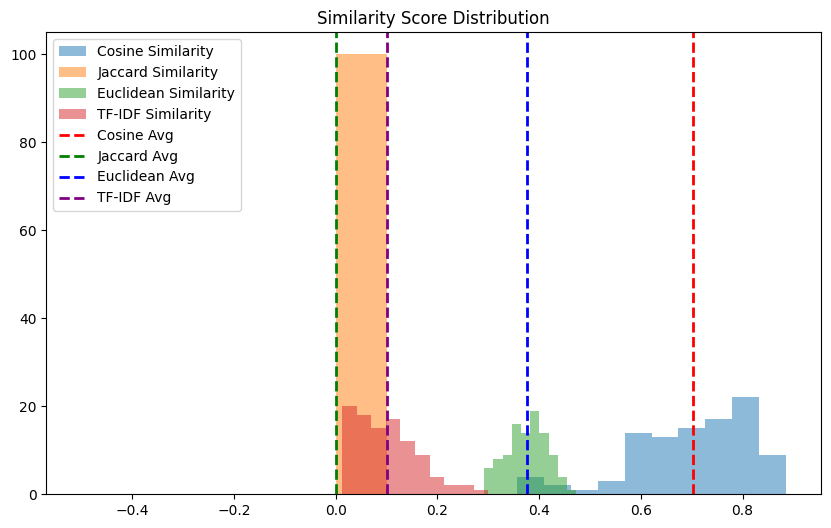

In [149]:
import matplotlib.pyplot as plt

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 각 리스트에 대한 히스토그램 그리기
plt.hist(cosine_list, alpha=0.5, label='Cosine Similarity')
plt.hist(jaccard_list, alpha=0.5, label='Jaccard Similarity')
plt.hist(euclidean_list, alpha=0.5, label='Euclidean Similarity')
plt.hist(tfidf_list, alpha=0.5, label='TF-IDF Similarity')

# 각 리스트의 평균값에 선 그리기
plt.axvline(x=np.mean(cosine_list), color='r', linestyle='dashed', linewidth=2, label='Cosine Avg')
plt.axvline(x=np.mean(jaccard_list), color='g', linestyle='dashed', linewidth=2, label='Jaccard Avg')
plt.axvline(x=np.mean(euclidean_list), color='b', linestyle='dashed', linewidth=2, label='Euclidean Avg')
plt.axvline(x=np.mean(tfidf_list), color='purple', linestyle='dashed', linewidth=2, label='TF-IDF Avg')

# 그래프에 제목과 범례 추가
plt.title('Similarity Score Distribution')
plt.legend()

# 그래프 보여주기
plt.show()


<ipython-input-157-2f2551d97d61>:7: RuntimeWarning: invalid value encountered in divide
  normalized = (data - np.mean(data)) / np.std(data)


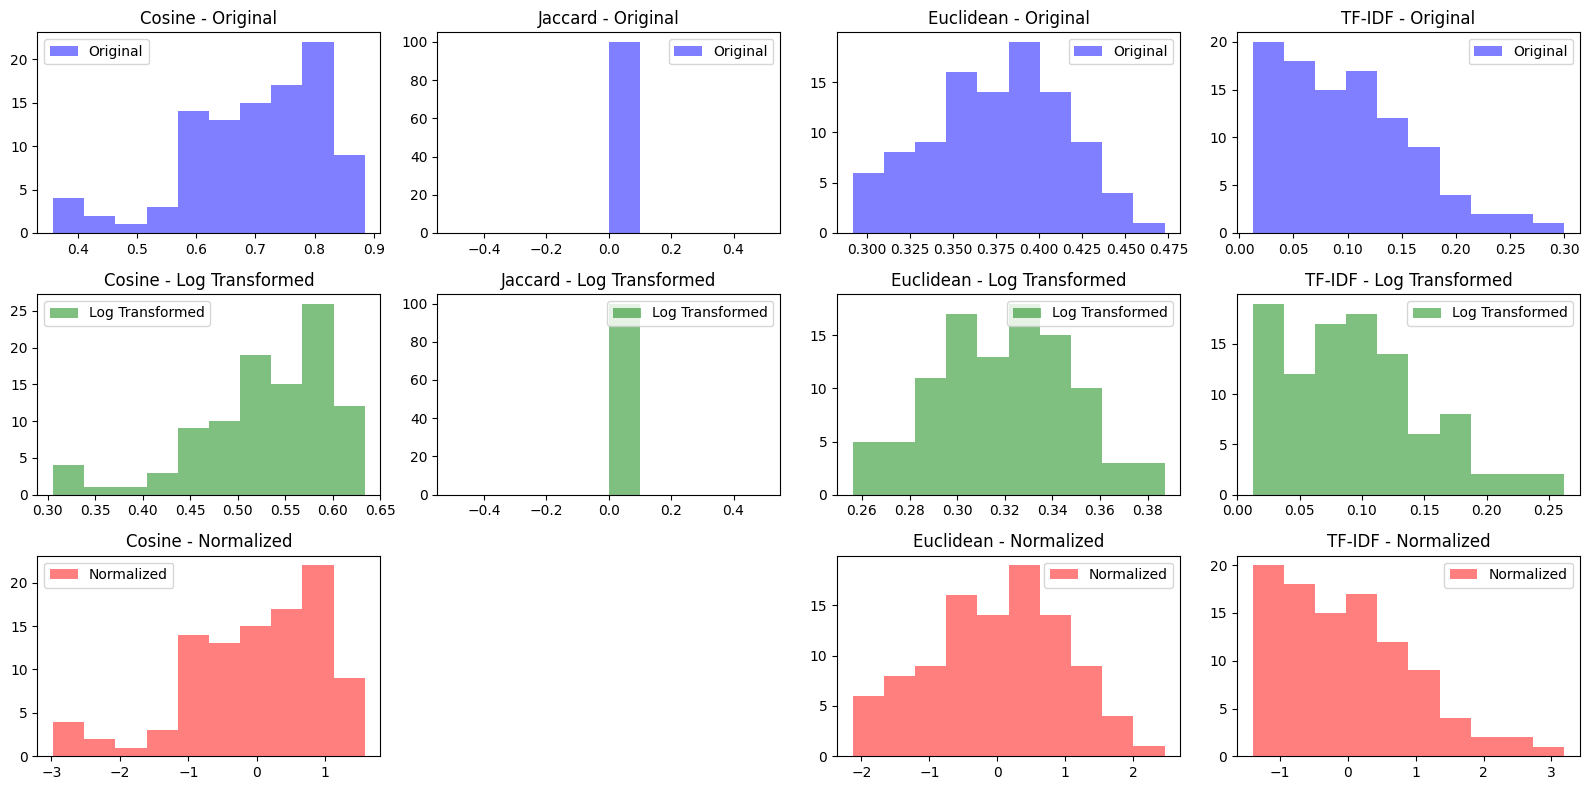

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# 함수 정의: 로그 변환 및 정규화
def transform_and_normalize(data):
    log_transformed = np.log1p(data)
    normalized = (data - np.mean(data)) / np.std(data)
    return log_transformed, normalized

# 데이터 변환
cosine_log, cosine_normalized = transform_and_normalize(cosine_list)
jaccard_log, jaccard_normalized = transform_and_normalize(jaccard_list)
euclidean_log, euclidean_normalized = transform_and_normalize(euclidean_list)
tfidf_log, tfidf_normalized = transform_and_normalize(tfidf_list)

# 그래프 그리기
plt.figure(figsize=(16, 8))

# 원본 데이터
plt.subplot(3, 4, 1)
plt.hist(cosine_list, alpha=0.5, color='b', label='Original')
plt.title('Cosine - Original')
plt.legend()

plt.subplot(3, 4, 2)
plt.hist(jaccard_list, alpha=0.5, color='b', label='Original')
plt.title('Jaccard - Original')
plt.legend()

plt.subplot(3, 4, 3)
plt.hist(euclidean_list, alpha=0.5, color='b', label='Original')
plt.title('Euclidean - Original')
plt.legend()

plt.subplot(3, 4, 4)
plt.hist(tfidf_list, alpha=0.5, color='b', label='Original')
plt.title('TF-IDF - Original')
plt.legend()

# 로그 변환 데이터
plt.subplot(3, 4, 5)
plt.hist(cosine_log, alpha=0.5, color='g', label='Log Transformed')
plt.title('Cosine - Log Transformed')
plt.legend()

plt.subplot(3, 4, 6)
plt.hist(jaccard_log, alpha=0.5, color='g', label='Log Transformed')
plt.title('Jaccard - Log Transformed')
plt.legend()

plt.subplot(3, 4, 7)
plt.hist(euclidean_log, alpha=0.5, color='g', label='Log Transformed')
plt.title('Euclidean - Log Transformed')
plt.legend()

plt.subplot(3, 4, 8)
plt.hist(tfidf_log, alpha=0.5, color='g', label='Log Transformed')
plt.title('TF-IDF - Log Transformed')
plt.legend()

# 정규화 데이터
plt.subplot(3, 4, 9)
plt.hist(cosine_normalized, alpha=0.5, color='r', label='Normalized')
plt.title('Cosine - Normalized')
plt.legend()

# plt.subplot(3, 4, 10)
# plt.hist(jaccard_normalized, alpha=0.5, color='r', label='Normalized')
# plt.title('Jaccard - Normalized')
# plt.legend()

plt.subplot(3, 4, 11)
plt.hist(euclidean_normalized, alpha=0.5, color='r', label='Normalized')
plt.title('Euclidean - Normalized')
plt.legend()

plt.subplot(3, 4, 12)
plt.hist(tfidf_normalized, alpha=0.5, color='r', label='Normalized')
plt.title('TF-IDF - Normalized')
plt.legend()

plt.tight_layout()
plt.show()


In [139]:
test

,id,질문
0,TEST_000,"방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용..."
1,TEST_001,도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
2,TEST_002,"큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?"
3,TEST_003,"철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있..."
4,TEST_004,도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
...,...,...
125,TEST_125,분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를...
126,TEST_126,"압출법 보온판의 가장 큰 장점은 무엇인가요?"""
127,TEST_127,평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어...
128,TEST_128,석고수정이 발생하는 가장 큰 원인은 무엇인가요? 그리고 이를 해결하는 방법에 대해 ...


In [144]:
tfidf_similarity(train_ft['question'][0], train_ft['answer'][0])

0.10616653858513148

# In context Learning

In [37]:
def prompt_chatbot(user_request, model, tokenizer, max_len, device):
    model.eval()

    text = user_request.strip()

    text = "<q>" + text + "</s><a>"
    # x = tokenizer.encode(text, return_tensors='pt').to(device)
    # q_len = len(text)+1

    conversation = [ {'role': 'user', 'content': text} ]

    prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(**inputs,
                             use_cache=True,
                             max_length=max_len,
                            num_return_sequences=1,
                            do_sample=True,
                            temperature=0.87,
                            top_k=27,
                            top_p=0.7
                             )

    output_text = tokenizer.decode(outputs[0])
    output_text = output_text.split("assistant\n-")[1].strip()
    output_text = output_text.replace('\n','').replace('</s>','')

    return output_text

In [40]:
solar_chatbot(test['질문'][0], kogpt_model, kogpt_tokenizer, 200, device)

'방청 페인트는 광명단페인트, 방청산화철페인트, 알미늄페인트, 역청질페인트, 워시프라이머, 크롬산아연페인트, 그리고 규산염페인트가 있습니다.'

# LLM Fewshot Learning